# Instalando pacotes

In [1]:
import os
import subprocess
import sys
import platform
import locale

def set_encoding():
    """Configura encoding adequado para o sistema"""
    try:
        # Definir encoding UTF-8 para o ambiente
        os.environ['PYTHONIOENCODING'] = 'utf-8'
        
        # Para Windows, definir codepage UTF-8
        if platform.system() == 'Windows':
            os.system('chcp 65001 > nul 2>&1')
        
        return True
    except Exception as e:
        print(f"⚠️ Aviso: Não foi possível configurar encoding: {e}")
        return False

def safe_subprocess_run(command, **kwargs):
    """Executa subprocess com encoding seguro"""
    try:
        # Configurações padrão para encoding
        default_kwargs = {
            'capture_output': True,
            'text': True,
            'encoding': 'utf-8',
            'errors': 'replace'  # Substitui caracteres problemáticos
        }
        
        # Para Windows, usar encoding específico se necessário
        if platform.system() == 'Windows':
            try:
                # Tentar com UTF-8 primeiro
                default_kwargs['encoding'] = 'utf-8'
            except:
                # Fallback para cp1252 (Windows)
                default_kwargs['encoding'] = 'cp1252'
                default_kwargs['errors'] = 'ignore'
        
        # Combinar com kwargs fornecidos
        final_kwargs = {**default_kwargs, **kwargs}
        
        return subprocess.run(command, **final_kwargs)
        
    except Exception as e:
        print(f"❌ Erro no subprocess: {e}")
        return None

def check_python_version():
    """Verifica se a versão do Python é compatível"""
    major, minor = sys.version_info[:2]
    print(f"🐍 Python detectado: {major}.{minor}.{sys.version_info.micro}")
    
    if not (major == 3 and minor in [8, 9, 10, 11, 12]):
        print("⚠️ AVISO: PyTorch tem melhor suporte para Python 3.8-3.12")
        return False
    
    print("✅ Versão do Python compatível!")
    return True

def detect_gpu_safe():
    """Detecta GPU NVIDIA de forma segura"""
    print("\n🔍 Detectando GPU...")
    
    try:
        # Método 1: nvidia-smi com encoding seguro
        result = safe_subprocess_run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader,nounits'])
        
        if result and result.returncode == 0:
            gpu_info = result.stdout.strip()
            if gpu_info:
                print("✅ GPU NVIDIA detectada!")
                print(f"🎮 GPU: {gpu_info}")
                return True
        
        # Método 2: Tentar nvidia-ml-py se disponível
        try:
            import pynvml
            pynvml.nvmlInit()
            device_count = pynvml.nvmlDeviceGetCount()
            
            if device_count > 0:
                handle = pynvml.nvmlDeviceGetHandleByIndex(0)
                name = pynvml.nvmlDeviceGetName(handle).decode('utf-8')
                print("✅ GPU NVIDIA detectada via pynvml!")
                print(f"🎮 GPU: {name}")
                return True
                
        except ImportError:
            pass
        except Exception as e:
            print(f"⚠️ pynvml error: {e}")
        
        # Método 3: Verificar via PyTorch se já instalado
        try:
            import torch
            if torch.cuda.is_available():
                gpu_name = torch.cuda.get_device_name(0)
                print("✅ GPU detectada via PyTorch!")
                print(f"🎮 GPU: {gpu_name}")
                return True
        except ImportError:
            pass
        
        print("❌ GPU NVIDIA não detectada")
        return False
        
    except Exception as e:
        print(f"❌ Erro ao detectar GPU: {e}")
        return False

def get_cuda_version_safe():
    """Detecta versão do CUDA de forma segura"""
    print("\n🔍 Detectando CUDA...")
    
    try:
        # Método 1: nvcc
        result = safe_subprocess_run(['nvcc', '--version'])
        if result and result.returncode == 0:
            output = result.stdout
            for line in output.split('\n'):
                if 'release' in line.lower():
                    print(f"✅ CUDA detectado: {line.strip()}")
                    if 'V12.' in line:
                        return '12.1'
                    elif 'V11.' in line:
                        return '11.8'
            return '11.8'
        
        # Método 2: nvidia-smi
        result = safe_subprocess_run(['nvidia-smi'])
        if result and result.returncode == 0:
            output = result.stdout
            if 'CUDA Version:' in output:
                for line in output.split('\n'):
                    if 'CUDA Version:' in line:
                        cuda_version = line.split('CUDA Version:')[1].strip().split()[0]
                        print(f"✅ CUDA detectado via nvidia-smi: {cuda_version}")
                        if cuda_version.startswith('12.'):
                            return '12.1'
                        elif cuda_version.startswith('11.'):
                            return '11.8'
        
        # Método 3: Verificar via PyTorch
        try:
            import torch
            if torch.cuda.is_available():
                cuda_version = torch.version.cuda
                print(f"✅ CUDA detectado via PyTorch: {cuda_version}")
                return cuda_version
        except ImportError:
            pass
        
        print("⚠️ CUDA não detectado, usando versão padrão 11.8")
        return '11.8'
        
    except Exception as e:
        print(f"⚠️ Erro ao detectar CUDA: {e}, usando padrão 11.8")
        return '11.8'

def install_pytorch_gpu_safe(cuda_version='11.8'):
    """Instala PyTorch com suporte a GPU de forma segura"""
    print(f"\n🔧 Instalando PyTorch com CUDA {cuda_version}...")
    
    # URLs corretas para diferentes versões CUDA
    cuda_urls = {
        '11.8': 'https://download.pytorch.org/whl/cu118',
        '12.1': 'https://download.pytorch.org/whl/cu121',
        '12.4': 'https://download.pytorch.org/whl/cu124'
    }
    
    cuda_url = cuda_urls.get(cuda_version, cuda_urls['11.8'])
    
    # Versões estáveis do PyTorch
    torch_packages = [
        'torch==2.4.1',
        'torchvision==0.19.1', 
        'torchaudio==2.4.1',
        '--index-url', cuda_url
    ]
    
    try:
        print(f"📦 Instalando do repositório: {cuda_url}")
        result = safe_subprocess_run([sys.executable, '-m', 'pip', 'install'] + torch_packages)
        
        if result and result.returncode == 0:
            print("✅ PyTorch com GPU instalado com sucesso!")
            return True
        else:
            print(f"❌ Erro ao instalar PyTorch GPU")
            if result:
                print(f"Stderr: {result.stderr}")
            print("🔄 Tentando versão CPU como fallback...")
            return install_pytorch_cpu_safe()
            
    except Exception as e:
        print(f"❌ Exceção ao instalar PyTorch GPU: {e}")
        return install_pytorch_cpu_safe()

def install_pytorch_cpu_safe():
    """Instala PyTorch CPU de forma segura"""
    print("\n🔧 Instalando PyTorch (CPU apenas)...")
    
    torch_packages = [
        'torch==2.4.1',
        'torchvision==0.19.1',
        'torchaudio==2.4.1',
        '--index-url', 'https://download.pytorch.org/whl/cpu'
    ]
    
    try:
        result = safe_subprocess_run([sys.executable, '-m', 'pip', 'install'] + torch_packages)
        if result and result.returncode == 0:
            print("✅ PyTorch CPU instalado com sucesso!")
            return True
        else:
            print(f"❌ Erro ao instalar PyTorch CPU")
            return False
    except Exception as e:
        print(f"❌ Exceção ao instalar PyTorch CPU: {e}")
        return False

def verify_gpu_installation_safe():
    """Verifica instalação GPU de forma segura"""
    print("\n🔍 Verificando suporte a GPU...")
    
    gpu_test_code = '''
import sys
import torch

try:
    print(f"PyTorch: {torch.__version__}")
    print(f"CUDA disponível: {torch.cuda.is_available()}")
    
    if torch.cuda.is_available():
        print(f"Versão CUDA: {torch.version.cuda}")
        print(f"Número de GPUs: {torch.cuda.device_count()}")
        
        for i in range(torch.cuda.device_count()):
            try:
                name = torch.cuda.get_device_name(i)
                props = torch.cuda.get_device_properties(i)
                memory_gb = props.total_memory / 1e9
                print(f"GPU {i}: {name}")
                print(f"Memória GPU {i}: {memory_gb:.1f} GB")
            except Exception as e:
                print(f"Erro ao obter info GPU {i}: {e}")
        
        # Teste básico de operação GPU
        try:
            device = torch.device("cuda:0")
            x = torch.randn(100, 100, device=device)
            y = torch.randn(100, 100, device=device)
            z = torch.matmul(x, y)
            print("✅ Teste de operação GPU bem-sucedido!")
        except Exception as e:
            print(f"❌ Erro no teste GPU: {e}")
    else:
        print("⚠️ CUDA não disponível - usando CPU")
        
except Exception as e:
    print(f"❌ Erro geral: {e}")
    sys.exit(1)
'''
    
    try:
        result = safe_subprocess_run([sys.executable, '-c', gpu_test_code], timeout=60)
        
        if result and result.returncode == 0:
            print(result.stdout)
            return True
        else:
            print("❌ Problemas na verificação GPU:")
            if result:
                print(f"Stderr: {result.stderr}")
            return False
            
    except Exception as e:
        print(f"❌ Erro na verificação GPU: {e}")
        return False

def install_spacy_model_safe(model_name="en_core_web_sm"):
    """Instala modelo do Spacy de forma segura (sem usar o CLI Typer)"""
    print(f"\n📦 Instalando modelo Spacy (API): {model_name}...")
    try:
        # Tenta via API interna do spaCy (não usa Typer/Click)
        import spacy
        from spacy.cli.download import download as spacy_download
        try:
            spacy_download(model_name)
        except SystemExit:
            # Alguns ambientes disparam SystemExit após concluir
            pass

        # Validação de carregamento
        nlp = spacy.load(model_name)
        doc = nlp("Quick sanity check for spaCy model.")
        print(f"✅ Modelo {model_name} instalado e carregado! Ex.: {doc[:5]}")
        return True
    except Exception as e:
        print(f"⚠️ Falha via API: {e}")
        print("🔁 Tentando fallback via PyPI do pacote do modelo...")
        # Fallback: instalar pacote do modelo se publicado no PyPI
        result = safe_subprocess_run([sys.executable, '-m', 'pip', 'install', f'{model_name}==3.7.1'])
        if result and result.returncode == 0:
            try:
                import spacy
                nlp = spacy.load(model_name)
                _ = nlp("Test.")
                print(f"✅ Modelo {model_name} instalado via PyPI e carregado!")
                return True
            except Exception as e2:
                print(f"❌ Fallback falhou ao carregar: {e2}")
                return False
        else:
            print("❌ Fallback via PyPI falhou.")
            if result:
                print(f"Stderr: {result.stderr}")
            return False

def enforce_cli_compatibility():
    """
    Garante compatibilidade entre click/typer após instalação de mlflow,
    prevenindo ImportError no spaCy CLI ou em libs que usam Typer.
    """
    print("\n🧩 Verificando/ajustando compatibilidade de CLI (click/typer)...")
    # Versões estáveis e compatíveis
    desired = [
        ('click', '8.1.7'),
        ('typer', '0.12.5'),
    ]
    for pkg, ver in desired:
        result = safe_subprocess_run([sys.executable, '-m', 'pip', 'install', f'{pkg}=={ver}'])
        if result and result.returncode == 0:
            print(f"✅ {pkg} fixado em {ver}")
        else:
            print(f"⚠️ Não foi possível fixar {pkg} em {ver}")
            if result:
                print(result.stderr[:300])
    # Validação de import básico
    try:
        import click, typer  # noqa: F401
        print("✅ Import de click/typer OK")
    except Exception as e:
        print(f"❌ Problema ao importar click/typer: {e}")

def install_compatible_packages_safe():
    """Instala pacotes compatíveis de forma segura"""
    print("\n📦 Instalando pacotes principais...")
    
    # Pacotes em grupos para instalação segura
    package_groups = [
        # Grupo 1: Core transformers
        [
            'transformers==4.45.2',
            'tokenizers==0.20.0',
            'accelerate==0.34.2'
        ],
        
        # Grupo 2: PEFT e fine-tuning
        [
            'peft==0.13.2',
            'datasets==3.0.1'
        ],
        
        # Grupo 3: ML básico
        [
            'numpy==1.26.4',
            'scikit-learn==1.5.2',
            'pandas==2.2.3',
            'scipy==1.13.1'
        ],
        
        # Grupo 4: Otimização e NLP
        [
          'optuna==3.6.1',
          'sentence-transformers==3.1.1',
          'spacy==3.7.2',
          'nltk==3.8.1',
          'pydantic==1.10.13'
         ],
        
        # Grupo 5: Visualização
        [
            'matplotlib==3.9.2',
            'seaborn==0.13.2',
            'wordcloud==1.9.3',
            'ipywidgets==8.1.3',
            'tabulate==0.9.0'
        ],
        
        # Grupo 6: Explicabilidade
        [
            'shap==0.46.0',
            'lime==0.2.0.1'
        ],
        
        # Grupo 7: Outros ML
        [
            'xgboost==2.1.1',
            'mlflow==2.16.0'
        ]
    ]
    
    for i, group in enumerate(package_groups, 1):
        try:
            print(f"📦 Instalando grupo {i}/{len(package_groups)}: {', '.join([p.split('==')[0] for p in group])}")
            
            result = safe_subprocess_run([sys.executable, '-m', 'pip', 'install'] + group)
            
            if result and result.returncode == 0:
                print(f"✅ Grupo {i} instalado com sucesso!")
            else:
                print(f"⚠️ Problemas no grupo {i}, continuando...")
                if result:
                    print(f"Stderr: {result.stderr[:200]}...")
                    
        except Exception as e:
            print(f"❌ Erro no grupo {i}: {e}")
            print("Continuando com próximo grupo...")
    
    enforce_cli_compatibility()
    
    ok_model = install_spacy_model_safe("en_core_web_sm")
    if not ok_model:
        print("⚠️ O modelo en_core_web_sm não foi instalado/validado. Você pode tentar novamente manualmente.")

    print("✅ Instalação de pacotes concluída!")
    return True

def verify_packages_safe():
    """Verifica pacotes de forma segura"""
    print("\n🔍 Verificando compatibilidade dos pacotes...")
    
    test_code = '''
import sys

packages_to_test = [
    ('torch', 'PyTorch'),
    ('transformers', 'Transformers'),
    ('peft', 'PEFT'),
    ('sentence_transformers', 'Sentence-Transformers'),
    ('optuna', 'Optuna'),
    ('sklearn', 'Scikit-learn'),
    ('pandas', 'Pandas'),
    ('numpy', 'NumPy')
]

print("🧪 Testando importações...")
failed_imports = []

for module_name, display_name in packages_to_test:
    try:
        module = __import__(module_name)
        version = getattr(module, '__version__', 'N/A')
        print(f"✅ {display_name}: {version}")
    except ImportError as e:
        print(f"❌ {display_name}: Falha na importação - {e}")
        failed_imports.append(display_name)
    except Exception as e:
        print(f"⚠️ {display_name}: Erro - {e}")

# Teste crítico: PEFT + Transformers
try:
    from transformers import AutoModel
    from peft import get_peft_model
    print("✅ Compatibilidade PEFT + Transformers verificada")
except Exception as e:
    print(f"❌ Problema PEFT + Transformers: {e}")
    failed_imports.append("PEFT+Transformers")

if failed_imports:
    print(f"\n⚠️ Pacotes com problemas: {', '.join(failed_imports)}")
    print("Mas a maioria está funcionando!")
else:
    print("\n🎉 Todos os pacotes estão funcionando!")
'''
    
    try:
        result = safe_subprocess_run([sys.executable, '-c', test_code])
        if result:
            print(result.stdout)
            return result.returncode == 0
        return False
    except Exception as e:
        print(f"❌ Erro na verificação: {e}")
        return False

def main():
    print("🛠️ Configuração do Ambiente de Deep Learning com GPU (Versão Segura)")
    print("=" * 70)
    
    # Configurar encoding
    set_encoding()
    
    # Verificar Python
    if not check_python_version():
        return
    
    # Detectar GPU de forma segura
    has_gpu = detect_gpu_safe()
    
    if has_gpu:
        cuda_version = get_cuda_version_safe()
        print(f"\n🎮 Configurando para GPU com CUDA {cuda_version}")
        
        # Instalar PyTorch com GPU
        if not install_pytorch_gpu_safe(cuda_version):
            print("❌ Falha na instalação do PyTorch GPU")
            return
        
        # Verificar GPU
        if not verify_gpu_installation_safe():
            print("⚠️ Problemas com GPU detectados, mas continuando...")
    else:
        print("\n💻 GPU não detectada, configurando para CPU")
        if not install_pytorch_cpu_safe():
            return
    
    # Instalar outros pacotes
    if not install_compatible_packages_safe():
        print("⚠️ Alguns pacotes podem ter falhado, mas continuando...")
    
    # Verificar instalação
    verify_packages_safe()
    
    print("\n" + "=" * 70)
    print("🎉 CONFIGURAÇÃO CONCLUÍDA!")
    print("=" * 70)
    print(f"""
    ✅ Ambiente configurado com encoding seguro
    ✅ PyTorch {'com GPU' if has_gpu else 'CPU'} instalado
    ✅ Pacotes de ML instalados
    
    🚀 Teste seu ambiente:
    
    import torch
    print(f"CUDA disponível: {{torch.cuda.is_available()}}")
    if torch.cuda.is_available():
        print(f"GPU: {{torch.cuda.get_device_name(0)}}")
    
    💡 Se ainda houver problemas, reinicie o terminal/kernel.
    """)

if __name__ == "__main__":
    main()

🛠️ Configuração do Ambiente de Deep Learning com GPU (Versão Segura)
🐍 Python detectado: 3.11.9
✅ Versão do Python compatível!

🔍 Detectando GPU...
✅ GPU NVIDIA detectada!
🎮 GPU: NVIDIA GeForce RTX 3070 Laptop GPU, 8192

🔍 Detectando CUDA...
❌ Erro no subprocess: [WinError 2] O sistema não pode encontrar o arquivo especificado
✅ CUDA detectado via nvidia-smi: 13.0
✅ CUDA detectado via PyTorch: 11.8

🎮 Configurando para GPU com CUDA 11.8

🔧 Instalando PyTorch com CUDA 11.8...
📦 Instalando do repositório: https://download.pytorch.org/whl/cu118
✅ PyTorch com GPU instalado com sucesso!

🔍 Verificando suporte a GPU...
PyTorch: 2.4.1+cu118
CUDA disponível: True
Versão CUDA: 11.8
Número de GPUs: 1
GPU 0: NVIDIA GeForce RTX 3070 Laptop GPU
Memória GPU 0: 8.6 GB
✅ Teste de operação GPU bem-sucedido!


📦 Instalando pacotes principais...
📦 Instalando grupo 1/7: transformers, tokenizers, accelerate
✅ Grupo 1 instalado com sucesso!
📦 Instalando grupo 2/7: peft, datasets
✅ Grupo 2 instalado com suce

# Importando pacotes

In [2]:
# 1. Imports
from scipy.special import softmax
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
import nltk


# MLflow Setup

## MLflow Save Location

In [3]:
import os
import pathlib
import mlflow
from mlflow.tracking import MlflowClient

# Defina a raiz do projeto exatamente onde você quer manter os mlruns
PROJECT_ROOT = pathlib.Path(r"E:\CIN - UFPE\Doutorado\Deep Learning")  # <- ajuste se necessário
MLRUNS_DIR = PROJECT_ROOT / "mlruns"
MLRUNS_DIR.mkdir(parents=True, exist_ok=True)

mlruns_uri = MLRUNS_DIR.as_uri()  # constrói file:///E:/CIN%20-%20UFPE/...
mlflow.set_tracking_uri(mlruns_uri)

print("=== DIAGNÓSTICO MLFLOW (NOTEBOOK) ===")
print("Tracking URI:", mlflow.get_tracking_uri())
print("ABS MLRUNS:", str(MLRUNS_DIR))
print("MLRUNS URI:", mlruns_uri)

# Experimento padrão
exp_name = "fake-news-multimodel"
mlflow.set_experiment(exp_name)
exp = mlflow.get_experiment_by_name(exp_name)
print("Experiment:", exp)

# Fecha run ativo (se houver) e cria um smoke test no E:
if mlflow.active_run() is not None:
    mlflow.end_run()

with mlflow.start_run(run_name="ui-smoke-test-E"):
    mlflow.log_param("check", "ok")
    mlflow.log_metric("ping", 1.0)

client = MlflowClient()
runs = client.search_runs([exp.experiment_id], "", max_results=5, order_by=["attributes.start_time DESC"])
print(f"Últimas runs no experimento {exp_name}: {[r.info.run_id for r in runs]}")

=== DIAGNÓSTICO MLFLOW (NOTEBOOK) ===
Tracking URI: file:///E:/CIN%20-%20UFPE/Doutorado/Deep%20Learning/mlruns
ABS MLRUNS: E:\CIN - UFPE\Doutorado\Deep Learning\mlruns
MLRUNS URI: file:///E:/CIN%20-%20UFPE/Doutorado/Deep%20Learning/mlruns
Experiment: <Experiment: artifact_location='file:///E:/CIN%20-%20UFPE/Doutorado/Deep%20Learning/mlruns/271606651965923452', creation_time=1763287880990, experiment_id='271606651965923452', last_update_time=1763287880990, lifecycle_stage='active', name='fake-news-multimodel', tags={}>
Últimas runs no experimento fake-news-multimodel: ['2065e5058c734a18b7800d189a51849b', '7981480150ba43acb06400de93f2aac6', 'fbb633a8699f41c5b064e842fab292fc', '01fb703f0146430fa3d09457173dd8c1', '498a7da83f9c4220b7df2d8594864c62']


## Classe Utilitaria de Tracking pro MLflow

In [4]:
import json
from typing import Dict, Any, Optional
import mlflow
from mlflow.models.signature import infer_signature

class MlflowTracker:
    def __init__(self, experiment_name: str, run_name: Optional[str] = None, tags: Optional[Dict[str, str]] = None):
        self.experiment_name = experiment_name
        self.run = mlflow.start_run(run_name=run_name, tags=tags)
        self.active_run_id = self.run.info.run_id

    def log_params_flat(self, params: Dict[str, Any], prefix: Optional[str] = None) -> None:
        flat = {}
        for k, v in params.items():
            key = f"{prefix}.{k}" if prefix else k
            if isinstance(v, (dict, list)):
                flat[key] = json.dumps(v, ensure_ascii=False)
            else:
                flat[key] = v
        mlflow.log_params(flat)

    def log_metrics(self, metrics: Dict[str, float], step: Optional[int] = None, prefix: Optional[str] = None) -> None:
        for k, v in metrics.items():
            key = f"{prefix}.{k}" if prefix else k
            mlflow.log_metric(key, float(v), step=step)

    def log_artifact(self, path: str, artifact_path: Optional[str] = None) -> None:
        mlflow.log_artifact(path, artifact_path=artifact_path)

    def log_figure(self, fig, artifact_path: str) -> None:
        import tempfile
        tmp = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
        fig.savefig(tmp.name, bbox_inches="tight", dpi=150)
        mlflow.log_artifact(tmp.name, artifact_path=artifact_path)

    def log_dataframe(self, df, name: str, context: str = "training") -> None:
        try:
            from mlflow.data import from_pandas
            dataset = from_pandas(df, source=name)
            mlflow.log_input(dataset, context=context)
        except Exception:
            # fallback: salva como CSV
            tmp_path = f"{name}.csv"
            df.to_csv(tmp_path, index=False)
            mlflow.log_artifact(tmp_path, artifact_path=f"data/{context}")

    def log_model_generic(self, model, X_sample=None, artifact_path: str = "model", framework: str = "sklearn") -> None:
        signature = None
        if X_sample is not None:
            try:
                signature = infer_signature(X_sample, model.predict(X_sample))
            except Exception:
                signature = None

        if framework == "sklearn":
            import mlflow.sklearn
            mlflow.sklearn.log_model(model, artifact_path=artifact_path, signature=signature)
        elif framework == "xgboost":
            import mlflow.xgboost
            mlflow.xgboost.log_model(model, artifact_path=artifact_path, signature=signature)
        elif framework == "transformers":
            try:
                import mlflow.transformers
                mlflow.transformers.log_model(model, artifact_path=artifact_path)
            except Exception:
                # fallback pyfunc
                import mlflow.pyfunc
                class Wrapper(mlflow.pyfunc.PythonModel):
                    def predict(self, context, model_input):
                        return model(model_input)
                mlflow.pyfunc.log_model(artifact_path=artifact_path, python_model=Wrapper())
        else:
            import mlflow.pyfunc
            class Wrapper(mlflow.pyfunc.PythonModel):
                def predict(self, context, model_input):
                    return model.predict(model_input)
            mlflow.pyfunc.log_model(artifact_path=artifact_path, python_model=Wrapper())

    def start_child_run(self, run_name: Optional[str] = None, tags: Optional[Dict[str, str]] = None):
        return mlflow.start_run(run_name=run_name, tags=tags, nested=True)

    def end(self) -> None:
        mlflow.end_run()

# Load Dataset

In [5]:
# ================================================
# CARREGAR DATASET LOCAL COM CACHE INTELIGENTE
# ================================================

import pandas as pd
import os
import zipfile
import re
from datetime import datetime
from pathlib import Path
import json # Adicionado para salvar metadados de forma legível

print("🚀 Carregando dataset local com verificação de cache...")

# ================================================
# 1. CONFIGURAR CAMINHOS LOCAIS (VARIÁVEIS GLOBAIS)
# ================================================

# Definir estrutura de pastas local
base_path = Path.home() / "Doutorado" / "2025.2" / "Deep Learning"
project_dir = base_path / "projeto"
data_dir = project_dir / "data"

# Caminhos dos arquivos
local_zip_path = None  # Será definido dinamicamente
processed_csv_path = project_dir / 'fake_news_processed.csv'
metadata_path = project_dir / 'dataset_metadata.txt'

# Diretório para extração
extract_dir = project_dir / 'temp_extraction'

# Criar estrutura de diretórios
project_dir.mkdir(parents=True, exist_ok=True)
data_dir.mkdir(parents=True, exist_ok=True)

print(f"📁 Diretório do projeto: {project_dir}")
print(f"📁 Diretório de dados: {data_dir}")

# ================================================
# 2. ENCONTRAR ARQUIVO ZIP LOCAL
# ================================================

def find_local_zip_file():
    """Encontra o arquivo Fake News Dataset.zip localmente"""
    
    # Locais possíveis para o arquivo ZIP
    search_locations = [
        project_dir / "Fake News Dataset.zip",
        data_dir / "Fake News Dataset.zip",
        Path.cwd() / "Fake News Dataset.zip",
        Path.home() / "Downloads" / "Fake News Dataset.zip",
        Path.home() / "Desktop" / "Fake News Dataset.zip",
        Path.home() / "Documents" / "Fake News Dataset.zip",
    ]
    
    # Nomes alternativos do arquivo
    alternative_names = [
        "fake_news_dataset.zip",
        "fake-news-dataset.zip", 
        "FakeNewsDataset.zip",
        "fakenews.zip"
    ]
    
    print("🔍 Procurando arquivo Fake News Dataset.zip...")
    
    # Procurar arquivo com nome padrão
    for location in search_locations:
        if location.exists():
            print(f"✅ Arquivo encontrado: {location}")
            return location
    
    # Procurar com nomes alternativos
    search_dirs = [project_dir, data_dir, Path.cwd(), Path.home() / "Downloads"]
    
    for search_dir in search_dirs:
        if search_dir.exists():
            for alt_name in alternative_names:
                alt_path = search_dir / alt_name
                if alt_path.exists():
                    print(f"✅ Arquivo encontrado (nome alternativo): {alt_path}")
                    return alt_path
    
    # Procurar qualquer arquivo ZIP que contenha "fake" ou "news"
    for search_dir in search_dirs:
        if search_dir.exists():
            for zip_file in search_dir.glob("*.zip"):
                if any(keyword in zip_file.name.lower() for keyword in ['fake', 'news']):
                    print(f"✅ Arquivo ZIP relacionado encontrado: {zip_file}")
                    return zip_file
    
    # Listar arquivos ZIP disponíveis para ajudar o usuário
    print("❌ Arquivo Fake News Dataset.zip não encontrado!")
    print("\n📋 Arquivos ZIP encontrados:")
    
    zip_found = False
    for search_dir in search_dirs:
        if search_dir.exists():
            zip_files = list(search_dir.glob("*.zip"))
            if zip_files:
                zip_found = True
                print(f"\n📁 Em {search_dir}:")
                for zip_file in zip_files:
                    print(f" 	📦 {zip_file.name}")
    
    if not zip_found:
        print(" 	Nenhum arquivo ZIP encontrado")
    
    return None

# ================================================
# 3. VERIFICAR SE DATASET PROCESSADO JÁ EXISTE
# ================================================

def check_processed_dataset():
    """Verifica se o dataset processado já existe e está atualizado"""
    
    if not processed_csv_path.exists():
        print("❌ Dataset processado não encontrado")
        return False
    
    # Encontrar arquivo ZIP para comparação
    zip_path = find_local_zip_file()
    if not zip_path:
        print("⚠️ 	Arquivo ZIP não encontrado, mas dataset processado existe")
        return True # Assume que o cache é válido se o zip sumiu
    
    # Comparar datas de modificação
    zip_mtime = zip_path.stat().st_mtime
    csv_mtime = processed_csv_path.stat().st_mtime
    
    if zip_mtime > csv_mtime:
        print("⚠️ 	Arquivo ZIP é mais recente que o dataset processado")
        return False
    
    # Verificar se o arquivo não está vazio E se contém a coluna nova
    try:
        df_test = pd.read_csv(processed_csv_path, nrows=1)
        
        # --- MUDANÇA CRÍTICA AQUI ---
        # Verifica se o cache antigo é inválido (sem a coluna 'source_dataset')
        if 'source_dataset' not in df_test.columns:
            print("⚠️ 	Dataset processado está desatualizado (sem 'source_dataset')")
            return False
            
    except Exception as e:
        print(f"⚠️ 	Erro ao verificar dataset processado: {e}")
        return False
    
    print("✅ Dataset processado encontrado e atualizado")
    return True

# ================================================
# 4. CARREGAR DATASET PROCESSADO
# ================================================

def load_processed_dataset():
    """Carrega o dataset já processado"""
    
    print("📊 Carregando dataset processado...")
    
    try:
        data = pd.read_csv(processed_csv_path)
        
        # --- MUDANÇA CRÍTICA AQUI ---
        # Validações básicas agora incluem 'source_dataset'
        required_columns = ['text', 'label', 'source_dataset']
        if not all(col in data.columns for col in required_columns):
            # Tenta carregar colunas antigas se a nova falhar (fallback)
            required_columns = ['text', 'label']
            if not all(col in data.columns for col in required_columns):
                raise ValueError(f"Colunas necessárias não encontradas: {required_columns}")
        
        # Verificar tipos de dados
        if not pd.api.types.is_numeric_dtype(data['label']):
            print("🔧 Convertendo coluna 'label' para numérico...")
            data['label'] = pd.to_numeric(data['label'], errors='coerce')
            data = data.dropna(subset=['label'])
            data['label'] = data['label'].astype(int)
        
        # Remover linhas vazias
        initial_len = len(data)
        data = data.dropna(subset=['text', 'label'])
        data = data[data['text'].astype(str).str.strip() != '']
        
        if len(data) < initial_len:
            print(f"🧹 Removidas {initial_len - len(data)} linhas vazias/inválidas")
        
        print(f"✅ Dataset carregado: {len(data):,} registros")
        return data
        
    except Exception as e:
        print(f"❌ Erro ao carregar dataset processado: {e}")
        return None

# ================================================
# 5. PROCESSAR DATASET ORIGINAL (FUNÇÕES ADAPTADAS)
# ================================================

def detect_delimiter(file_path, sample_size=1024):
    """Detecta automaticamente o delimitador do arquivo CSV"""
    # Lógica para TSV (usado por LIAR)
    if file_path.suffix.lower() == '.tsv':
        return '\t'
        
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            sample = f.read(sample_size)
    except UnicodeDecodeError:
        with open(file_path, 'r', encoding='latin-1') as f:
            sample = f.read(sample_size)
    
    delimiters = [',', ';', '\t', '|']
    counts = {delim: sample.count(delim) for delim in delimiters}
    best_delim = max(counts, key=counts.get)
    return best_delim if counts[best_delim] > 0 else ','

# --- FUNÇÃO MODIFICADA ---
def process_csv_file(file_path, source_name): # 1. Recebe 'source_name'
    """Processa um arquivo CSV ou TSV individual"""
    try:
        delimiter = detect_delimiter(file_path)
        
        encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
        df = None
        
        for encoding in encodings:
            try:
                # O LIAR dataset não tem header
                header_option = 'infer' if source_name != 'LIAR_Dataset' else None
                df = pd.read_csv(file_path, delimiter=delimiter, encoding=encoding, on_bad_lines='warn', header=header_option)
                break
            except UnicodeDecodeError:
                continue
        
        if df is None:
            raise ValueError("Não foi possível ler o arquivo com nenhum encoding")
        
        # --- Lógica Específica para cada Dataset ---
        
        if source_name == 'LIAR_Dataset':
            # Colunas do LIAR: id, label, statement, subject, speaker, job, state, party, credit_history, context
            df = df.iloc[:, [1, 2]] # Pega apenas a coluna 1 (label) e 2 (statement)
            df.columns = ['label', 'text']
            # Mapeamento do LIAR (6 classes) para binário (Fake/Real)
            # pants-fire, false, barely-true, half-true -> FAKE (0)
            # mostly-true, true -> REAL (1)
            label_mapping = {
                'pants-fire': 0, 'false': 0, 'barely-true': 0, 'half-true': 0,
                'mostly-true': 1, 'true': 1
            }
            df['label'] = df['label'].map(label_mapping)
            
        elif source_name == 'Kaggle_Dataset':
            # Colunas: id, title, author, text, label (0=Real, 1=Fake)
            # Inverte o label do Kaggle para nosso padrão (0=Fake, 1=Real)
            df = df[['text', 'label']]
            df['label'] = df['label'].map({0: 1, 1: 0})

        elif source_name == 'ISOT_Dataset':
            # Colunas: title, text, subject, date
            # O nome do arquivo (Fake.csv, True.csv) define o label
            df = df[['text']]
            df['label'] = 1 if 'true' in file_path.name.lower() else 0
            
        elif source_name == 'WELFake_Dataset':
            # Colunas: Unnamed: 0, title, text, label (0=Fake, 1=Real)
            df = df[['text', 'label']]
            # O label já está no nosso padrão (0=Fake, 1=Real)
        
        else: # Fallback para outros CSVs
            # Renomear colunas se necessário
            if 'text;label' in df.columns:
                df[['text', 'label']] = df['text;label'].str.split(';', n=1, expand=True)
                df = df.drop(columns=['text;label'])
            
            # Garantir que temos as colunas necessárias
            if 'text' not in df.columns or 'label' not in df.columns:
                text_cols = [col for col in df.columns if any(keyword in col.lower()
                                for keyword in ['text', 'content', 'news', 'article', 'statement', 'title'])]
                label_cols = [col for col in df.columns if any(keyword in col.lower()
                                      for keyword in ['label', 'class', 'target', 'fake', 'real'])]
                
                if text_cols and label_cols:
                    df = df.rename(columns={text_cols[0]: 'text', label_cols[0]: 'label'})
                else:
                    return None # Pula arquivo se não achar colunas

            # Processar rótulos genéricos
            df['label'] = df['label'].astype(str).str.strip().str.lower()
            label_mapping = {
                'real': 1, 'true': 1, '1': 1, '1.0': 1,
                'fake': 0, 'false': 0, '0': 0, '0.0': 0
            }
            df['label'] = df['label'].map(label_mapping)

        # --- Limpeza Final e Adição da Fonte ---
        df = df.dropna(subset=['label', 'text'])
        df['label'] = df['label'].astype(int)
        df['text'] = df['text'].astype(str).str.strip()
        df = df[df['text'] != '']
        df = df[df['text'] != 'nan']
        
        df['source_dataset'] = source_name
        
        # Padroniza colunas de saída
        final_cols = ['text', 'label', 'source_dataset']
        df = df[final_cols]
        
        return df, delimiter
        
    except Exception as e:
        print(f"🚨 Erro ao processar {file_path.name} (Origem: {source_name}): {str(e)}")
        return None

# --- FUNÇÃO MODIFICADA ---
def process_original_dataset():
    """Processa o dataset original do arquivo ZIP local"""
    
    print("🔄 Processando dataset original...")
    
    # Encontrar arquivo ZIP
    zip_file_path = find_local_zip_file()
    if not zip_file_path:
        raise FileNotFoundError(
            "❌ Arquivo Fake News Dataset.zip não encontrado!\n"
            "📋 Coloque o arquivo em uma destas localizações:\n"
            f" 	- {project_dir}\n"
            f" 	- {data_dir}\n"
            f" 	- {Path.home() / 'Downloads'}\n"
            f" 	- {Path.cwd()}"
        )
    
    # Extrair arquivo ZIP
    print(f"📦 Extraindo arquivo ZIP: {zip_file_path.name}")
    try:
        extract_dir.mkdir(exist_ok=True)
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"✅ Arquivo extraído para: {extract_dir}")
    except Exception as e:
        print(f"❌ Erro ao extrair arquivo: {e}")
        raise
    
    # Encontrar arquivos CSV e TSV (para o LIAR)
    csv_files_found = list(extract_dir.rglob("*.csv"))
    tsv_files_found = list(extract_dir.rglob("*.tsv"))
    all_files_found = csv_files_found + tsv_files_found # Combina as listas
    
    print(f"🔍 Arquivos de dados encontrados: {len(all_files_found)}")
    
    if not all_files_found:
        print("❌ Nenhum arquivo CSV ou TSV encontrado no ZIP")
        raise ValueError("Nenhum arquivo de dados (csv/tsv) encontrado!")
    
    # Processar arquivos
    all_dfs = []
    processed_files = []
    
    for file_path in all_files_found:
        
        # --- 🚀 A CORREÇÃO ESTÁ AQUI 🚀 ---
        try:
            # Pega o caminho relativo (ex: 'Fake News Dataset/ISOT_Dataset/Fake.csv')
            relative_path = file_path.relative_to(extract_dir)
            
            # Pula a pasta raiz 'Fake News Dataset' (índice 0)
            # Pega o nome da subpasta (índice 1)
            source_name = relative_path.parts[1]
            
        except (ValueError, IndexError):
            # Se o arquivo estiver em uma estrutura inesperada, pulamos
            print(f"⚠️ Aviso: pulando arquivo em local inesperado: {file_path}")
            continue
            
        print(f"📄 Processando: {file_path.name} (Origem: {source_name})")
        
        # Passa o 'source_name' para a função
        result = process_csv_file(file_path, source_name)
        
        if result is not None:
            df, delimiter = result
            all_dfs.append(df)
            processed_files.append(str(file_path))
            print(f"✅ Processado: {file_path.name} | Registros: {len(df)}")
        else:
            print(f"❌ Falha ao processar: {file_path.name}")
    
    if not all_dfs:
        raise ValueError("Nenhum dataset válido foi processado!")
    
    # Combinar datasets
    print(f"🔗 Combinando {len(all_dfs)} datasets...")
    data = pd.concat(all_dfs, ignore_index=True, sort=False)
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return data, processed_files

# --- FUNÇÃO MODIFICADA ---
def save_processed_dataset(data, processed_files):
    """Salva o dataset processado e metadados"""
    
    try:
        # Salvar dataset
        data.to_csv(processed_csv_path, index=False, encoding='utf-8')
        print(f"💾 Dataset salvo em: {processed_csv_path.name}")
        
        # --- MUDANÇA AQUI ---
        # Salvar metadados, agora incluindo 'source_dataset'
        metadata = {
            'processed_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'total_records': len(data),
            'processed_files': len(processed_files),
            'label_distribution': data['label'].value_counts().to_dict(),
            'source_distribution': data['source_dataset'].value_counts().to_dict(),
            'source_label_crosstab': pd.crosstab(data['source_dataset'], data['label']).to_dict(),
            'text_stats': {
                'avg_length': float(data['text'].str.len().mean()),
                'min_length': int(data['text'].str.len().min()),
                'max_length': int(data['text'].str.len().max())
            }
        }
        
        with open(metadata_path, 'w', encoding='utf-8') as f:
            f.write("FAKE NEWS DATASET - METADATA\n")
            f.write("="*40 + "\n")
            # Salva como JSON formatado para fácil leitura
            for key, value in metadata.items():
                f.write(f"\n--- {key.upper()} ---\n")
                if isinstance(value, dict):
                    f.write(json.dumps(value, indent=4))
                else:
                    f.write(str(value))
                f.write("\n")

        print(f"📋 Metadados salvos em: {metadata_path.name}")
        
    except Exception as e:
        print(f"⚠️ 	Erro ao salvar arquivos: {e}")

# ================================================
# 6. LÓGICA PRINCIPAL COM CACHE
# ================================================

def load_dataset_with_cache():
    """Carrega dataset usando cache inteligente"""
    
    print("\n" + "="*60)
    print("🧠 SISTEMA DE CACHE INTELIGENTE LOCAL")
    print("="*60)
    
    # Verificar se dataset processado existe e está atualizado
    if check_processed_dataset():
        print("⚡ Usando dataset em cache...")
        
        data = load_processed_dataset()
        
        if data is not None:
            print("✅ Dataset carregado do cache com sucesso!")
            return data, True  # True indica que foi carregado do cache
        else:
            print("❌ Falha ao carregar do cache, processando novamente...")
    
    # Se chegou aqui, precisa processar o dataset original
    print("🔄 Processando dataset original...")
    
    try:
        data, processed_files = process_original_dataset()
        
        # Salvar dataset processado para uso futuro
        save_processed_dataset(data, processed_files)
        
        print("✅ Dataset processado e salvo com sucesso!")
        return data, False  # False indica que foi processado agora
        
    except Exception as e:
        print(f"❌ Erro no processamento: {e}")
        raise

# ================================================
# 7. FUNÇÃO PARA FORÇAR REPROCESSAMENTO
# ================================================

def force_reprocess():
    """Força o reprocessamento do dataset, ignorando cache"""
    
    print("🔄 Forçando reprocessamento...")
    
    # Remover arquivos de cache
    files_to_remove = [processed_csv_path, metadata_path]
    
    for file_path in files_to_remove:
        if file_path.exists():
            try:
                file_path.unlink()
                print(f"🗑️ 	Removido: {file_path.name}")
            except Exception as e:
                print(f"⚠️ 	Erro ao remover {file_path.name}: {e}")
    
    # Limpar diretório de extração
    if extract_dir.exists():
        import shutil
        try:
            shutil.rmtree(extract_dir)
            print(f"🗑️ 	Diretório de extração limpo")
        except Exception as e:
            print(f"⚠️ 	Erro ao limpar diretório: {e}")
    
    # Reprocessar
    return load_dataset_with_cache()

# ================================================
# 8. EXECUTAR CARREGAMENTO
# ================================================

try:
    # Navegar para diretório do projeto
    # O chdir() pode causar confusão em notebooks. É melhor
    # garantir que o project_dir seja usado em todos os caminhos.
    # Vamos manter, mas cientes de que é uma fonte de bugs.
    if Path.cwd() != project_dir:
        os.chdir(project_dir)
    print(f"📍 Diretório de trabalho: {Path.cwd()}")
    
    # Carregar dataset
    data, from_cache = force_reprocess()
    
    # ================================================
    # 9. EXIBIR RESULTADOS
    # ================================================
    
    print("\n" + "="*60)
    print("📊 DATASET LOCAL CARREGADO COM SUCESSO!")
    print("="*60)
    
    # Indicar fonte dos dados
    source_info = "💾 CACHE LOCAL" if from_cache else "🔄 PROCESSAMENTO ORIGINAL"
    print(f"📍 Fonte: {source_info}")
    
    # Estatísticas do dataset
    print(f"📊 Estatísticas:")
    print(f" 	- Total de registros: {len(data):,}")
    
    label_counts = data['label'].value_counts().sort_index()
    for label, count in label_counts.items():
        label_name = "Real" if label == 1 else "Fake"
        percentage = (count / len(data)) * 100
        print(f" 	- {label} ({label_name}): {count:,} registros ({percentage:.1f}%)")
    
    # --- MUDANÇA AQUI ---
    # Exibir distribuição da nova coluna
    if 'source_dataset' in data.columns:
        print(f"\n 	 Distribuição por Origem (source_dataset):")
        
        # --- CORREÇÃO para o erro 'str' object has no attribute 'indent' ---
        source_summary_str = data['source_dataset'].value_counts().to_string(header=False, name=False)
        prefix = ' ' * 7
        print('\n'.join([f"{prefix}{line}" for line in source_summary_str.split('\n')]))
        
    print(f"\n 	- Comprimento médio do texto: {data['text'].str.len().mean():.1f} caracteres")
    
    # Mostrar informações de cache
    if from_cache:
        print(f"\n⚡ Vantagens do cache:")
        print(f" 	- Carregamento instantâneo")
        print(f" 	- Sem necessidade de reprocessamento")
        print(f" 	- Dados já limpos e validados (incluindo 'source_dataset')")
    else:
        print(f"\n🔄 Dataset processado e salvo:")
        print(f" 	- Próxima execução será mais rápida")
        print(f" 	- Cache (com 'source_dataset') criado automaticamente")
    
    print("="*60)
    
    # ================================================
    # 10. EXEMPLOS DOS DADOS
    # ================================================
    
    print("\n📋 Exemplos dos dados:")
    print("-" * 80)
    
    # Garante que temos dados para ambos os labels antes de tentar amostrar
    if 0 in data['label'].values:
        label_name = "FAKE NEWS"
        sample_df = data[data['label'] == 0]
        sample = sample_df.sample(n=1, random_state=42)
        print(f"\n🏷️ 	{label_name}:")
        for idx, row in sample.iterrows():
            text_preview = row['text'][:200] + "..." if len(row['text']) > 200 else row['text']
            source_name = row.get('source_dataset', 'N/A')
            print(f" 	 [Origem: {source_name}]")
            print(f" 	 📄 {text_preview}")
            
    if 1 in data['label'].values:
        label_name = "REAL NEWS"
        sample_df = data[data['label'] == 1]
        sample = sample_df.sample(n=1, random_state=42)
        print(f"\n🏷️ 	{label_name}:")
        for idx, row in sample.iterrows():
            text_preview = row['text'][:200] + "..." if len(row['text']) > 200 else row['text']
            source_name = row.get('source_dataset', 'N/A')
            print(f" 	 [Origem: {source_name}]")
            print(f" 	 📄 {text_preview}")

    
    print("-" * 80)
    print(f"🎉 Dataset pronto para uso! Variável 'data' contém {len(data):,} registros")
    
except Exception as e:
    print(f"\n❌ ERRO CRÍTICO: {e}")
    print("💡 Verifique se:")
    print(" 	- O arquivo 'Fake News Dataset.zip' está em uma das localizações:")
    print(f" 	 	• {project_dir}")
    print(f" 	 	• {data_dir}")
    print(f" 	 	• {Path.home() / 'Downloads'}")
    print(f" 	 	• {Path.cwd()}")
    print(" 	- Você tem permissões de leitura/escrita")
    print(" 	- O arquivo ZIP não está corrompido")

# ================================================
# 11. FUNÇÕES AUXILIARES
# ================================================

def show_dataset_info():
    """Mostra informações detalhadas do dataset"""
    if 'data' in locals() or 'data' in globals():
        print("\n📊 INFORMAÇÕES DETALHADAS DO DATASET")
        print("="*50)
        print(f"📏 Forma: {data.shape}")
        print(f"📋 Colunas: {list(data.columns)}")
        print(f"🔢 Tipos de dados:")
        print(data.dtypes.to_string())
        print(f"\n📈 Distribuição de labels:")
        print(data['label'].value_counts().to_string())
        
        # Exibir informações da nova coluna
        if 'source_dataset' in data.columns:
            print(f"\n📈 Distribuição por Origem (source_dataset):")
            print(data['source_dataset'].value_counts().to_string())
            print(f"\n📊 Cruzamento Origem vs. Label:")
            print(pd.crosstab(data['source_dataset'], data['label'], 
                              margins=True, margins_name="Total"))

        print(f"\n📊 Estatísticas de texto:")
        text_lengths = data['text'].str.len()
        print(f" 	- Mínimo: {text_lengths.min()} caracteres")
        print(f" 	- Máximo: {text_lengths.max()} caracteres")
        print(f" 	- Média: {text_lengths.mean():.1f} caracteres")
        print(f" 	- Mediana: {text_lengths.median():.1f} caracteres")
    else:
        print("❌ Dataset não carregado ainda")

print(f"\n💡 Comandos úteis:")
print(f" 	- Para reprocessar: data, from_cache = force_reprocess()")
print(f" 	- Para ver detalhes: show_dataset_info()")
print(f" 	- Para limpar cache: force_reprocess()")

🚀 Carregando dataset local com verificação de cache...
📁 Diretório do projeto: C:\Users\fhigh\Doutorado\2025.2\Deep Learning\projeto
📁 Diretório de dados: C:\Users\fhigh\Doutorado\2025.2\Deep Learning\projeto\data
📍 Diretório de trabalho: C:\Users\fhigh\Doutorado\2025.2\Deep Learning\projeto
🔄 Forçando reprocessamento...
🗑️ 	Removido: fake_news_processed.csv
🗑️ 	Removido: dataset_metadata.txt
🗑️ 	Diretório de extração limpo

🧠 SISTEMA DE CACHE INTELIGENTE LOCAL
❌ Dataset processado não encontrado
🔄 Processando dataset original...
🔄 Processando dataset original...
🔍 Procurando arquivo Fake News Dataset.zip...
✅ Arquivo encontrado: C:\Users\fhigh\Downloads\Fake News Dataset.zip
📦 Extraindo arquivo ZIP: Fake News Dataset.zip
✅ Arquivo extraído para: C:\Users\fhigh\Doutorado\2025.2\Deep Learning\projeto\temp_extraction
🔍 Arquivos de dados encontrados: 8
📄 Processando: test.csv (Origem: Fake News Dataset)
✅ Processado: test.csv | Registros: 4035
📄 Processando: train.csv (Origem: Fake News D

## 2.1 Amostragem estratificada

In [6]:
# ==========================================================
# 2.1 AMOSTRAGEM ESTRATIFICADA
# ==========================================================
#
# Para acelerar a prototipagem e os testes, vamos criar um
# subset do 'data' original, mantendo o balanceamento
# das classes (estratificação).
#
# ==========================================================
from sklearn.model_selection import train_test_split

# --- ✨ CONTROLE AQUI (ex: 0.5 = 50% dos dados) ---
DATA_FRACTION = 0.1  # (Use 0.1 para 10%, 0.3 para 30%, 1.0 para 100%)
# --------------------------------------------------

if DATA_FRACTION < 1.0:
    print(f"--- ⚠️  Atenção: Criando um subset de {DATA_FRACTION*100:.0f}% dos dados ---")
    
    # 1. Mostrar o estado original
    print(f"📊 Dataset Original: {len(data):,} registros")
    print(f"   Distribuição Original:\n{data['label'].value_counts(normalize=True)}")
    
    # 2. Usar train_test_split como um "amostrador estratificado"
    # (Ignoramos o '_', pois só queremos a primeira fração)
    data_subset, _ = train_test_split(
        data,
        train_size=DATA_FRACTION,
        stratify=data['label'], # <-- A MÁGICA: Garante o balanceamento
        random_state=42
    )
    
    # 3. Sobrescrever o 'data' principal
    data = data_subset.copy().reset_index(drop=True)
    
    # 4. Mostrar o novo estado
    print(f"\n📊 Novo Dataset (Subset): {len(data):,} registros")
    print(f"   Distribuição do Subset (Estratificada):\n{data['label'].value_counts(normalize=True)}")
    print("\n✅ Variável 'data' foi sobrescrita com o subset.")
    
else:
    print("--- 🚀 Usando 100% dos dados ({len(data):,} registros) ---")

# Limpa a memória
import gc
gc.collect()

--- ⚠️  Atenção: Criando um subset de 10% dos dados ---
📊 Dataset Original: 76,537 registros
   Distribuição Original:
label
0    0.502162
1    0.497838
Name: proportion, dtype: float64

📊 Novo Dataset (Subset): 7,653 registros
   Distribuição do Subset (Estratificada):
label
0    0.502156
1    0.497844
Name: proportion, dtype: float64

✅ Variável 'data' foi sobrescrita com o subset.


239

# Data Cleaning

## Loading cleansed data

In [7]:
import re
import spacy
import nltk
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import os
import pandas as pd # Necessário para salvar/carregar

# ==========================================================
# 3.1 DATA CLEANING (COM LÓGICA DE CACHE)
# ==========================================================

# --- 1. Configurações ---
CLEANED_DATA_FILE = "data_cleaned.pkl"
# ⬇️ Mude esta flag para True se quiser forçar a limpeza novamente
FORCE_REPROCESS = False 

# --- 2. Lógica de Carregar ou Processar ---

if os.path.exists(CLEANED_DATA_FILE) and not FORCE_REPROCESS:
    # --- CAMINHO A: Carregar do Disco ---
    print(f"♻️  Arquivo limpo encontrado. Carregando de '{CLEANED_DATA_FILE}'...")
    try:
        # Substitui a variável 'data' na memória pela versão limpa
        data = pd.read_pickle(CLEANED_DATA_FILE)
        print("✅ Dados carregados com sucesso.")
        print(f"   Colunas carregadas: {data.columns.tolist()}")
    except Exception as e:
        print(f"❌ Erro ao carregar o arquivo pickle: {e}. O script continuará para reprocessar.")
        FORCE_REPROCESS = True # Força o reprocessamento se o carregamento falhar

if not os.path.exists(CLEANED_DATA_FILE) or FORCE_REPROCESS:
    # --- CAMINHO B: Processar os Dados (Seu código original) ---
    
    if FORCE_REPROCESS and os.path.exists(CLEANED_DATA_FILE):
        print("\n🔥 FORÇANDO REPROCESSAMENTO (FORCE_REPROCESS=True)...")
    else:
        print(f"\nℹ️  Arquivo '{CLEANED_DATA_FILE}' não encontrado. Iniciando processo de limpeza...")

    # Verificar se 'data' existe (assumindo da célula anterior)
    if 'data' not in locals():
        print("❌ ERRO: A variável 'data' não foi carregada. Por favor, execute a célula anterior (Seção 3) primeiro.")
    else:
        # --- Funções de Limpeza (Seu código) ---
        nltk.download('stopwords')
        stop_words = set(stopwords.words('english'))

        def mask_entities_batch(texts, nlp_model, batch_size=1000):
            """
            Processa textos em lote usando nlp.pipe para maior velocidade.
            """
            masked_texts = []
            # nlp.pipe processa em paralelo e é muito mais rápido que .apply()
            for doc in tqdm(nlp_model.pipe(texts, batch_size=batch_size), total=len(texts), desc="Mascarando entidades"):
                new_text = doc.text
                # Processa de trás para frente para manter os índices corretos
                for ent in reversed(doc.ents):
                    if ent.label_ in ["ORG", "GPE", "PERSON"]:
                        new_text = new_text[:ent.start_char] + f"<{ent.label_}>" + new_text[ent.end_char:]
                masked_texts.append(new_text)
            return masked_texts

        def clean_text(text):
            text = re.sub(r'[^\w\s]', '', text)
            text = re.sub(r'\d+', '', text)
            text = text.lower() #turns everything to lowercase
            text = ' '.join([word for word in text.split() if word not in stop_words]) #gets rid of stop words
            return text

        nlp = spacy.load("en_core_web_sm", disable=["parser", "tagger", "lemmatizer"])

        # 1º Passo: Mascarar Entidades
        print("Iniciando mascaramento de entidades...")
        data['text_masked'] = mask_entities_batch(data['text'], nlp)

        # 2º Passo: Limpeza de texto
        print("Iniciando limpeza de texto simples...")
        data['text_clean'] = data['text_masked'].apply(clean_text)
        print("Limpeza concluída.")
        
        # --- 3. Salvar os resultados em disco ---
        print(f"\n💾 Salvando dados limpos em disco: {CLEANED_DATA_FILE}...")
        try:
            data.to_pickle(CLEANED_DATA_FILE)
            print("✅ Dados salvos com sucesso.")
        except Exception as e:
            print(f"❌ Erro ao salvar dados: {e}")

♻️  Arquivo limpo encontrado. Carregando de 'data_cleaned.pkl'...
✅ Dados carregados com sucesso.
   Colunas carregadas: ['text', 'label', 'source_dataset', 'text_masked', 'text_clean']


# Carregar Embeddings

In [8]:
# ==========================================================
# 4.1 CARREGAMENTO DOS EMBEDDINGS (Carregando do Disco Local)
# ==========================================================
# 
# ⚠️ AÇÃO MANUAL NECESSÁRIA ⚠️
# 
# 1. BAIXE O ARQUIVO: https://nlp.stanford.edu/data/glove.6B.zip
# 2. DESCOMPACTE o ZIP.
# 3. COPIE os arquivos 'glove.6B.100d.txt' e 'glove.6B.300d.txt'
#    PARA A PASTA RAIZ DO SEU PROJETO.
#
#    A pasta é:
#    e:\CIN - UFPE\Doutorado\Deep Learning\
#
# ==========================================================

import numpy as np
import os
from pathlib import Path

# --- Função Auxiliar para carregar o arquivo GloVe ---
# (Esta função já está correta e será reutilizada)
def load_glove_embeddings(glove_file_path):
    """
    Carrega um arquivo .txt do GloVe em um dicionário {palavra: vetor_numpy}.
    """
    file_name = os.path.basename(glove_file_path)
    print(f"Carregando embeddings do arquivo: {file_name}...")
    
    embeddings_index = {}
    try:
        with open(glove_file_path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                try:
                    coefs = np.asarray(values[1:], dtype='float32')
                    embeddings_index[word] = coefs
                except ValueError:
                    pass
        
        if embeddings_index:
            vector_size = len(next(iter(embeddings_index.values())))
            embeddings_index['<OOV>'] = np.zeros(vector_size, dtype='float32')
            print(f"✅ Modelo carregado. {len(embeddings_index)} vetores de {vector_size} dimensões.")
        else:
            print(f"❌ Arquivo de embedding vazio: {file_name}")
            
    except FileNotFoundError:
        print(f"❌ ERRO: Arquivo não encontrado.")
        print(f"   Verifique se o arquivo '{file_name}' está em:")
        print(f"   {os.path.dirname(glove_file_path)}")
        return None
    except Exception as e:
        print(f"❌ Erro ao ler o arquivo de embedding: {e}")
        return None
        
    return embeddings_index

# --- CORREÇÃO AQUI ---
# Vamos definir o caminho exato que você informou, em vez de usar
# a variável 'data_dir' que estava errada.
# Use barras normais (/) para compatibilidade.
correct_base_path = Path("e:/CIN - UFPE/Doutorado/Deep Learning/")

# --- Carregando GloVe 100d do disco ---
print("Procurando GloVe 100d local...")
# Usando o caminho corrigido
glove_100d_path = correct_base_path / "glove.6B.100d.txt" 
glove_model_100d = load_glove_embeddings(glove_100d_path)

# --- Carregando GloVe 300d do disco ---
print("\nProcurando GloVe 300d local...")
# Usando o caminho corrigido
glove_300d_path = correct_base_path / "glove.6B.300d.txt"
glove_model_300d = load_glove_embeddings(glove_300d_path)

if glove_model_100d is None or glove_model_300d is None:
    print("\n" + "="*50)
    print("❌ ERRO: Arquivos GloVe não encontrados na pasta.")
    print("   Por favor, siga as instruções no topo desta célula.")
    # Atualizando a mensagem de erro para mostrar o caminho correto
    print(f"   A pasta verificada foi: {correct_base_path.resolve()}")
    print("="*50)

Procurando GloVe 100d local...
Carregando embeddings do arquivo: glove.6B.100d.txt...
✅ Modelo carregado. 400001 vetores de 100 dimensões.

Procurando GloVe 300d local...
Carregando embeddings do arquivo: glove.6B.300d.txt...
✅ Modelo carregado. 400001 vetores de 300 dimensões.


## Pipelines das funções dos modelos

### Classe Vetorizadora de Embedding

In [9]:
# Imports para os novos modelos
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin

# Imports para o BERT (Hugging Face)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

# ==========================================================
# 4.1.1 CLASSE VETORIZADORA DE EMBEDDING CUSTOMIZADA
# ==========================================================
# Esta classe nos permite usar nossos dicionários GloVe dentro
# de um Pipeline do Scikit-learn.

class EmbeddingVectorizer(BaseEstimator, TransformerMixin):
    """
    Transforma uma lista de textos em uma matriz de vetores de embedding
    usando um dicionário de embedding pré-carregado.
    """
    def __init__(self, embedding_dict):
        # O dicionário GloVe (ex: glove_model_100d) é passado aqui
        self.embedding_dict = embedding_dict
        # Pegamos o tamanho do vetor (ex: 100) do token <OOV>
        self.vector_size = len(embedding_dict['<OOV>'])

    def fit(self, X, y=None):
        # A fase de 'fit' não é necessária, pois o modelo já está treinado
        return self

    def transform(self, X, y=None):
        # Esta é a função principal. Converte cada texto em um vetor médio.
        print(f"    - Vetorizando {len(X)} textos (Dim: {self.vector_size})...")
        X_vec = []
        for text in X:
            words = text.split()
            word_vectors = []
            
            for word in words:
                # Pega o vetor da palavra ou o vetor <OOV> (zeros)
                word_vectors.append(self.embedding_dict.get(word, self.embedding_dict['<OOV>']))
            
            if not word_vectors:
                # Se o texto estiver vazio, retorna um vetor de zeros
                X_vec.append(np.zeros(self.vector_size, dtype='float32'))
            else:
                # Retorna a média dos vetores
                X_vec.append(np.mean(word_vectors, axis=0))
                
        return np.array(X_vec)

print("Classe EmbeddingVectorizer definida.")

Classe EmbeddingVectorizer definida.


### Definição de Pipelines

In [35]:
import spacy
import numpy as np
import pandas as pd
import time
import gc
import warnings
import signal
import threading
# Imports do sklearn
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
#import para BERT
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import torch
from torch.utils.data import Dataset as TorchDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F # Adicionado para a função BERT
warnings.filterwarnings('ignore')

# ==========================================================
# DEFINIÇÃO DAS FUNÇÕES DE MODELO (PIPELINES)
# ==========================================================

def run_naive_bayes_bow(X_train, y_train, X_test, y_test):
    """
    Treina e avalia Naive Bayes com Bag of Words.
    A vetorização ocorre DENTRO do pipeline.
    """
    print("  [Rodando Naive Bayes + BoW]...")
    
    # O Pipeline garante que o CountVectorizer é fitado SÓ no X_train
    pipeline_nb = Pipeline([
        ('vectorizer', CountVectorizer(max_features=10000, ngram_range=(1,1))), # BoW
        ('model', MultinomialNB())
    ])
    
    # Treina o pipeline (vectorizer + model)
    pipeline_nb.fit(X_train, y_train)
    
    # Avalia
    y_pred = pipeline_nb.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Extrair as métricas macro-average
    return {
        'accuracy': report['accuracy'],
        'precision_macro': report['macro avg']['precision'],
        'recall_macro': report['macro avg']['recall'],
        'f1_macro': report['macro avg']['f1-score'],
        'report_dict': report,
        'y_true': y_test,
        'y_pred': y_pred,
        'pipeline': pipeline_nb
    }

def run_logistic_regression_tfidf(X_train, y_train, X_test, y_test):
    """
    Treina e avalia Regressão Logística com TF-IDF.
    A vetorização ocorre DENTRO do pipeline.
    """
    print("  [Rodando Regressão Logística + TF-IDF]...")
    
    pipeline_lr = Pipeline([
        ('vectorizer', TfidfVectorizer(max_features=10000, ngram_range=(1,2))), # TF-IDF
        ('model', LogisticRegression(C=10, solver='liblinear', random_state=142857))
    ])
    
    pipeline_lr.fit(X_train, y_train)
    
    y_pred = pipeline_lr.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    return {
        'accuracy': report['accuracy'],
        'precision_macro': report['macro avg']['precision'],
        'recall_macro': report['macro avg']['recall'],
        'f1_macro': report['macro avg']['f1-score'],
        'report_dict': report,
        'y_true': y_test,
        'y_pred': y_pred,
        'pipeline': pipeline_lr
    }

print("Funções de pipeline para Naive Bayes e Regressao Logistica definidas.")

# ==========================================================
# 4.1 Pipelines das funções dos modelos (Continuação)
# ==========================================================

def run_random_forest_glove(X_train, y_train, X_test, y_test, embedding_dict_300d):
    """
    Treina e avalia Random Forest com embeddings GloVe 300d.
    (Baseado no seu artigo, que citava Word2Vec/RF)
    """
    print("  [Rodando Random Forest + GloVe 300d]...")
    
    # Criamos um pipeline com nosso vetorizador customizado e o modelo
    pipeline_rf = Pipeline([
        ('vectorizer', EmbeddingVectorizer(embedding_dict=embedding_dict_300d)),
        ('model', RandomForestClassifier(n_estimators=200, random_state=142857, n_jobs=-1))
    ])
    
    pipeline_rf.fit(X_train, y_train)
    
    y_pred = pipeline_rf.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    return {
        'accuracy': report['accuracy'],
        'precision_macro': report['macro avg']['precision'],
        'recall_macro': report['macro avg']['recall'],
        'f1_macro': report['macro avg']['f1-score'],
        'report_dict': report,
        'y_true': y_test,
        'y_pred': y_pred,
        'pipeline': pipeline_rf
    }

def run_xgboost_glove(X_train, y_train, X_test, y_test, embedding_dict_100d):
    """
    Treina e avalia XGBoost com embeddings GloVe 100d.
    """
    print("  [Rodando XGBoost + GloVe 100d]...")
    
    pipeline_xgb = Pipeline([
        ('vectorizer', EmbeddingVectorizer(embedding_dict=embedding_dict_100d)),
        ('model', xgb.XGBClassifier(n_estimators=200,
                                      learning_rate=0.1,
                                      max_depth=5,
                                      random_state=142857,
                                      n_jobs=-1,
                                      eval_metric='logloss'))
    ])
    
    pipeline_xgb.fit(X_train, y_train)
    
    y_pred = pipeline_xgb.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    return {
        'accuracy': report['accuracy'],
        'precision_macro': report['macro avg']['precision'],
        'recall_macro': report['macro avg']['recall'],
        'f1_macro': report['macro avg']['f1-score'],
        'report_dict': report,
        'y_true': y_test,
        'y_pred': y_pred,
        'pipeline': pipeline_xgb
    }

print("Funções de pipeline para RF e XGBoost definidas.")

# ==========================================================
# 4.1.2 FUNÇÃO DE PIPELINE DO BERT (Hugging Face) - ATUALIZADA
# ==========================================================

# --- Função Auxiliar de Métricas ---
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0) 
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1_macro': f1,
        'precision_macro': precision,
        'recall_macro': recall
    }

def run_bert_finetuning(X_train, y_train, X_test, y_test):
    """
    Treina e avalia BERT (DistilBERT) com fine-tuning.
    *** OTIMIZADO PARA VELOCIDADE ***
    """
    print("  [Rodando BERT + Fine-Tuning (distilbert) - MODO RÁPIDO]...")

    MODEL_NAME = 'distilbert-base-uncased'
    
    # 1. Preparar Dados
    train_df = pd.DataFrame({'text': X_train.tolist(), 'label': y_train.tolist()})
    test_df = pd.DataFrame({'text': X_test.tolist(), 'label': y_test.tolist()})
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)
    
    # 2. Tokenizar
    print(f"    - Tokenizando (max_length=128)...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    
    def tokenize_function(examples):
        return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)
        
    train_dataset_tokenized = train_dataset.map(tokenize_function, batched=True, load_from_cache_file=False)
    test_dataset_tokenized = test_dataset.map(tokenize_function, batched=True, load_from_cache_file=False)
    
    # 3. Carregar Modelo
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
    
    # 4. Argumentos de Treino
    training_args = TrainingArguments(
        output_dir="./bert_training_checkpoints", 
        num_train_epochs=1,
        per_device_train_batch_size=64, # Otimizado
        per_device_eval_batch_size=64,  # Otimizado
        
        # Removida a dependência de 'optimized_params'
        learning_rate=2e-5, # Usar um padrão razoável
        
        weight_decay=0.01,
        evaluation_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        report_to="none",
        fp16=True # Usar precisão mista
    )
    
    # 5. Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset_tokenized,
        eval_dataset=test_dataset_tokenized, 
        compute_metrics=compute_metrics,
    )
    
    # 6. Treinar
    print(f"    - Iniciando Fine-Tuning (1 época, batch=64)...")
    trainer.train()
    
    # 7. Avaliar e Obter Predições
    print("    - Avaliando BERT no dataset de teste LODO...")
    eval_results = trainer.evaluate(test_dataset_tokenized)
    predictions = trainer.predict(test_dataset_tokenized)
    
    logits = predictions.predictions
    probabilities = F.softmax(torch.tensor(logits), dim=1).numpy()
    
    y_pred_bert = np.argmax(probabilities, axis=1)
    y_proba_bert = probabilities[:, 1]
    y_true_bert = predictions.label_ids

    # 8. Limpar Memória (Guardando o modelo treinado)
    trained_model = trainer.model.cpu()
    trained_tokenizer = tokenizer
    
    del trainer, model, tokenizer
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # 9. Formatar Saída
    return {
        'accuracy': eval_results['eval_accuracy'],
        'precision_macro': eval_results['eval_precision_macro'],
        'recall_macro': eval_results['eval_recall_macro'],
        'f1_macro': eval_results['eval_f1_macro'],
        'report_dict': eval_results,
        'y_true': y_true_bert,
        'y_pred': y_pred_bert,
        'y_proba': y_proba_bert,
        'model': trained_model, # Salvar o modelo treinado
        'tokenizer': trained_tokenizer # Salvar o tokenizer
    }

print("Função 'run_bert_finetuning' (CORRIGIDA) definida.")

Funções de pipeline para Naive Bayes e Regressao Logistica definidas.
Funções de pipeline para RF e XGBoost definidas.
Função 'run_bert_finetuning' (CORRIGIDA) definida.


# LODO Experiment

## Helpers das Metricas para MLflow

In [12]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict, Tuple, List, Optional

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, matthews_corrcoef,
    brier_score_loss, log_loss, confusion_matrix
)

def get_holdout_split(df: pd.DataFrame, holdout_name: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    assert {"text", "label", "dataset"}.issubset(df.columns), "df precisa ter colunas: text, label, dataset"
    train_df = df[df["dataset"] != holdout_name].reset_index(drop=True)
    test_df = df[df["dataset"] == holdout_name].reset_index(drop=True)
    return train_df, test_df

def compute_metrics_binary(y_true: np.ndarray, y_pred: np.ndarray, y_proba: Optional[np.ndarray]) -> Dict[str, float]:
    metrics = {}
    metrics["accuracy"] = accuracy_score(y_true, y_pred)
    metrics["precision"] = precision_score(y_true, y_pred, zero_division=0)
    metrics["recall"] = recall_score(y_true, y_pred, zero_division=0)
    metrics["f1"] = f1_score(y_true, y_pred, zero_division=0)

    # Probabilidades para métricas probabilísticas
    if y_proba is not None:
        p1 = y_proba[:, 1] if y_proba.ndim == 2 and y_proba.shape[1] > 1 else y_proba.ravel()
        # Evitar AUROC se existir 1 classe só no y_true
        if len(np.unique(y_true)) == 2 and len(np.unique(y_pred)) == 2:
            try:
                metrics["auroc"] = roc_auc_score(y_true, p1)
            except Exception:
                metrics["auroc"] = float("nan")
        else:
            metrics["auroc"] = float("nan")
        try:
            metrics["auprc"] = average_precision_score(y_true, p1)
        except Exception:
            metrics["auprc"] = float("nan")
        try:
            # Brier definido para prob. da classe positiva
            metrics["brier"] = brier_score_loss(y_true, p1)
        except Exception:
            metrics["brier"] = float("nan")
        try:
            metrics["log_loss"] = log_loss(y_true, np.c_[1 - p1, p1])
        except Exception:
            metrics["log_loss"] = float("nan")
    else:
        metrics["auroc"] = float("nan")
        metrics["auprc"] = float("nan")
        metrics["brier"] = float("nan")
        metrics["log_loss"] = float("nan")

    try:
        metrics["mcc"] = matthews_corrcoef(y_true, y_pred)
    except Exception:
        metrics["mcc"] = float("nan")

    return metrics

def plot_confusion_matrix_figure(y_true: np.ndarray, y_pred: np.ndarray, labels: List[str] = ["Real", "Fake"]):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap="Blues")
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=labels, yticklabels=labels,
        ylabel="Verdadeiro",
        xlabel="Predito",
        title="Matriz de Confusão"
    )
    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "d"),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig

# Helper independente da classe MlflowTracker
def log_env_fingerprint_mlflow():
    import socket
    import getpass
    import platform
    from datetime import datetime
    try:
        mlflow.set_tags({
            "host": socket.gethostname(),
            "user": getpass.getuser(),
            "platform": platform.platform(),
            "python_version": platform.python_version(),
            "pid": str(os.getpid()),
            "start_time": datetime.utcnow().isoformat() + "Z"
        })
    except Exception:
        pass

## NB+Bow, TDIDF+RL, RF+Word2Vec, XGBoost+Glove

In [36]:
# ===================================================================
# 5.1 EXECUÇÃO DO EXPERIMENTO (LEAVE-ONE-DATASET-OUT + CLASSIC MODELS)
# ===================================================================
import os
import pickle
import time
import numpy as np
import pandas as pd
import mlflow

# Segurança: define experimento default se não existir
try:
    EXPERIMENT_NAME
except NameError:
    EXPERIMENT_NAME = "fake-news-multimodel"

# Helper: logging genérico de métricas vindas dos reports (sem supor chaves fixas)
def _log_all_numeric_metrics(report_dict: dict, prefix: str, tracker: MlflowTracker) -> None:
    if not isinstance(report_dict, dict):
        return
    numeric_metrics = {}
    for k, v in report_dict.items():
        if k.lower() in ("pipeline", "model", "vectorizer", "preprocessor", "y_true", "y_pred", "y_proba"):
            continue
        try:
            if isinstance(v, (int, float, np.floating, np.integer)):
                numeric_metrics[k] = float(v)
        except Exception:
            pass
    if numeric_metrics:
        tracker.log_metrics(numeric_metrics, prefix=prefix)

# Helper: logging opcional de previsões se existirem no report
def _log_predictions_if_present(report_dict: dict, name: str, tracker: MlflowTracker) -> None:
    try:
        y_true = report_dict.get("y_true", None)
        y_pred = report_dict.get("y_pred", None)
        y_proba = report_dict.get("y_proba", None)
        if y_true is not None and y_pred is not None:
            tracker.log_predictions_csv(y_true, y_pred, proba=y_proba, name=name, context="testing")
    except Exception:
        pass

# --- ✨ CÓDIGO DE CHECKPOINTING (LOAD) ---
# Se já rodamos 1 ou 2 folds, ele restaura o progresso.
if os.path.exists("lodo_checkpoint_results.pkl"):
    print("♻️  Restaurando 'resultados_lodo' do checkpoint...")
    with open("lodo_checkpoint_results.pkl", "rb") as f:
        resultados_lodo = pickle.load(f)
else:
    resultados_lodo = {}

if os.path.exists("lodo_checkpoint_pipelines.pkl"):
    print("♻️  Restaurando 'pipelines_lodo' do checkpoint...")
    with open("lodo_checkpoint_pipelines.pkl", "rb") as f:
        pipelines_lodo = pickle.load(f)
else:
    pipelines_lodo = {}
# --- FIM DO CHECKPOINTING (LOAD) ---

datasets_origem = data["source_dataset"].unique()

print(f"🚀 Iniciando validação LODO em {len(datasets_origem)} datasets...")
print(f"   Datasets: {datasets_origem}")

# Encerra um run ativo que tenha ficado aberto em células anteriores
if mlflow.active_run() is not None:
    mlflow.end_run()

# Run pai do MLflow para toda a seção 5.1
tracker = MlflowTracker(
    EXPERIMENT_NAME,
    run_name="LODO-classic",
    tags={"stage": "LODO", "project": "fake-news", "family": "classical"}
)

# Fingerprint do ambiente (sem depender do método da classe)
log_env_fingerprint_mlflow()

# Metadados úteis da execução
try:
    tracker.log_params_flat(
        {
            "datasets_count": int(len(datasets_origem)),
            "datasets_list": [str(x) for x in datasets_origem],
        },
        prefix="lodo"
    )
except Exception:
    pass

# --- VERIFICAÇÃO DE SEGURANÇA 1 ---
if len(datasets_origem) < 2:
    print("\n" + "=" * 50)
    print("❌ ERRO METODOLÓGICO")
    print("   Seu dataset 'data' contém apenas UMA fonte de dados.")
    print("   O Leave-One-Dataset-Out (LODO) requer pelo menos DUAS fontes.")
    print("   (Ex: Treinar em 'ISOT' e testar em 'WELFake')")
    print("   O experimento LODO não pode ser executado.")
    print("=" * 50)
else:
    for dataset_teste in datasets_origem:
        print("\n" + "=" * 50)
        print(f"ITERANDO LODO: HOLD-OUT (TESTE) = {dataset_teste}")
        print("=" * 50)

        # Se já existe em pelo menos um modelo, assume fold executado
        if dataset_teste in pipelines_lodo.get("NaiveBayes", {}):
            print(f"🟡 Fold '{dataset_teste}' já executado. Pulando...")
            continue

        # 1. Criar os splits
        mascara_teste = data["source_dataset"] == dataset_teste
        mascara_treino = data["source_dataset"] != dataset_teste

        X_train_lodo = data.loc[mascara_treino, "text_clean"]
        y_train_lodo = data.loc[mascara_treino, "label"]
        X_test_lodo = data.loc[mascara_teste, "text_clean"]
        y_test_lodo = data.loc[mascara_teste, "label"]

        print(f"Tamanho Treino: {len(X_train_lodo)} | Tamanho Teste: {len(X_test_lodo)}")

        # --- VERIFICAÇÃO DE SEGURANÇA 2 ---
        if len(X_train_lodo) == 0:
            print("❌ ERRO: O conjunto de treino está VAZIO. Pulando iteração.")
            continue
        # --- FIM DA VERIFICAÇÃO ---

        # Run filho por holdout
        with tracker.start_child_run(run_name=f"holdout={dataset_teste}", tags={"holdout": str(dataset_teste), "embedding": "various"}):
            # Log de dados (amostras e contagens)
            try:
                tracker.log_params_flat(
                    {"train_size": int(len(X_train_lodo)), "test_size": int(len(X_test_lodo))},
                    prefix=f"holdout.{dataset_teste}"
                )
                df_train_log = pd.DataFrame({"text": X_train_lodo.values[:50], "label": y_train_lodo.values[:50]})
                df_test_log = pd.DataFrame({"text": X_test_lodo.values[:50], "label": y_test_lodo.values[:50]})
                tracker.log_dataframe(df_train_log, name=f"train_head_{dataset_teste}", context="training")
                tracker.log_dataframe(df_test_log, name=f"test_head_{dataset_teste}", context="testing")
            except Exception:
                pass

            # 2. Executar os modelos (mantendo seu fluxo e adicionando tracking)
            # --- Naive Bayes ---
            with tracker.start_child_run(run_name="NaiveBayes", tags={"model": "NaiveBayes"}):
                t0 = time.time()
                report_nb = run_naive_bayes_bow(X_train_lodo, y_train_lodo, X_test_lodo, y_test_lodo)

                if "NaiveBayes" not in resultados_lodo:
                    resultados_lodo["NaiveBayes"] = []
                    pipelines_lodo["NaiveBayes"] = {}
                resultados_lodo["NaiveBayes"].append(report_nb)
                pipelines_lodo["NaiveBayes"][dataset_teste] = report_nb.get("pipeline", None)

                _log_all_numeric_metrics(report_nb, prefix="NaiveBayes", tracker=tracker)
                _log_predictions_if_present(report_nb, name=f"NaiveBayes_{dataset_teste}", tracker=tracker)

                try:
                    pipeline_obj = report_nb.get("pipeline", None)
                    if pipeline_obj is not None:
                        tracker.log_model_generic(pipeline_obj, X_sample=None, artifact_path="models/NaiveBayes", framework="sklearn")
                except Exception:
                    pass

                tracker.log_metrics({"elapsed_sec": time.time() - t0}, prefix="NaiveBayes")

                if all(k in report_nb for k in ("accuracy", "precision_macro", "recall_macro", "f1_macro")):
                    print(f"\t> Resultado NB: Acc = {report_nb['accuracy']:.4f}")
                    print(f"\t> Resultado NB: Prec = {report_nb['precision_macro']:.4f}")
                    print(f"\t> Resultado NB: Rec = {report_nb['recall_macro']:.4f}")
                    print(f"\t> Resultado NB: F1 = {report_nb['f1_macro']:.4f}")

            # --- Logistic Regression ---
            with tracker.start_child_run(run_name="LogisticRegression", tags={"model": "LogisticRegression"}):
                t0 = time.time()
                report_lr = run_logistic_regression_tfidf(X_train_lodo, y_train_lodo, X_test_lodo, y_test_lodo)

                if "LogisticRegression" not in resultados_lodo:
                    resultados_lodo["LogisticRegression"] = []
                    pipelines_lodo["LogisticRegression"] = {}
                resultados_lodo["LogisticRegression"].append(report_lr)
                pipelines_lodo["LogisticRegression"][dataset_teste] = report_lr.get("pipeline", None)

                _log_all_numeric_metrics(report_lr, prefix="LogisticRegression", tracker=tracker)
                _log_predictions_if_present(report_lr, name=f"LogisticRegression_{dataset_teste}", tracker=tracker)

                try:
                    pipeline_obj = report_lr.get("pipeline", None)
                    if pipeline_obj is not None:
                        tracker.log_model_generic(pipeline_obj, X_sample=None, artifact_path="models/LogisticRegression", framework="sklearn")
                except Exception:
                    pass

                tracker.log_metrics({"elapsed_sec": time.time() - t0}, prefix="LogisticRegression")

                if all(k in report_lr for k in ("accuracy", "precision_macro", "recall_macro", "f1_macro")):
                    print(f"\t> Resultado LR: Acc = {report_lr['accuracy']:.4f}")
                    print(f"\t> Resultado LR: Prec = {report_lr['precision_macro']:.4f}")
                    print(f"\t> Resultado LR: Rec = {report_lr['recall_macro']:.4f}")
                    print(f"\t> Resultado LR: F1 = {report_lr['f1_macro']:.4f}")

            # --- Random Forest (GloVe 300d) ---
            with tracker.start_child_run(run_name="RandomForest", tags={"model": "RandomForest", "embedding": "glove-300d"}):
                t0 = time.time()
                report_rf = run_random_forest_glove(X_train_lodo, y_train_lodo, X_test_lodo, y_test_lodo, glove_model_300d)

                if "RandomForest" not in resultados_lodo:
                    resultados_lodo["RandomForest"] = []
                    pipelines_lodo["RandomForest"] = {}
                resultados_lodo["RandomForest"].append(report_rf)
                pipelines_lodo["RandomForest"][dataset_teste] = report_rf.get("pipeline", None)

                _log_all_numeric_metrics(report_rf, prefix="RandomForest", tracker=tracker)
                _log_predictions_if_present(report_rf, name=f"RandomForest_{dataset_teste}", tracker=tracker)

                try:
                    pipeline_obj = report_rf.get("pipeline", None)
                    if pipeline_obj is not None:
                        tracker.log_model_generic(pipeline_obj, X_sample=None, artifact_path="models/RandomForest", framework="sklearn")
                except Exception:
                    pass

                tracker.log_metrics({"elapsed_sec": time.time() - t0}, prefix="RandomForest")

                if all(k in report_rf for k in ("accuracy", "precision_macro", "recall_macro", "f1_macro")):
                    print(f"\t> Resultado RF (GloVe 300d): Acc = {report_rf['accuracy']:.4f}")
                    print(f"\t> Resultado RF (GloVe 300d): Prec = {report_rf['precision_macro']:.4f}")
                    print(f"\t> Resultado RF (GloVe 300d): Rec = {report_rf['recall_macro']:.4f}")
                    print(f"\t> Resultado RF (GloVe 300d): F1 = {report_rf['f1_macro']:.4f}")

            # --- XGBoost (GloVe 100d) ---
            with tracker.start_child_run(run_name="XGBoost", tags={"model": "XGBoost", "embedding": "glove-100d"}):
                t0 = time.time()
                report_xgb = run_xgboost_glove(X_train_lodo, y_train_lodo, X_test_lodo, y_test_lodo, glove_model_100d)

                if "XGBoost" not in resultados_lodo:
                    resultados_lodo["XGBoost"] = []
                    pipelines_lodo["XGBoost"] = {}
                resultados_lodo["XGBoost"].append(report_xgb)
                pipelines_lodo["XGBoost"][dataset_teste] = report_xgb.get("pipeline", None)

                _log_all_numeric_metrics(report_xgb, prefix="XGBoost", tracker=tracker)
                _log_predictions_if_present(report_xgb, name=f"XGBoost_{dataset_teste}", tracker=tracker)

                try:
                    pipeline_obj = report_xgb.get("pipeline", None)
                    if pipeline_obj is not None:
                        tracker.log_model_generic(pipeline_obj, X_sample=None, artifact_path="models/XGBoost", framework="xgboost")
                except Exception:
                    pass

                tracker.log_metrics({"elapsed_sec": time.time() - t0}, prefix="XGBoost")

                if all(k in report_xgb for k in ("accuracy", "precision_macro", "recall_macro", "f1_macro")):
                    print(f"\t> Resultado XGB (GloVe 100d): Acc = {report_xgb['accuracy']:.4f}")
                    print(f"\t> Resultado XGB (GloVe 100d): Prec = {report_xgb['precision_macro']:.4f}")
                    print(f"\t> Resultado XGB (GloVe 100d): Rec = {report_xgb['recall_macro']:.4f}")
                    print(f"\t> Resultado XGB (GloVe 100d): F1 = {report_xgb['f1_macro']:.4f}")

            # --- ✨ CÓDIGO DE CHECKPOINTING (SAVE) ---
            print(f"\n💾 Checkpoint: Salvando progresso do fold '{dataset_teste}' no disco...")
            try:
                with open("lodo_checkpoint_results.pkl", "wb") as f:
                    pickle.dump(resultados_lodo, f)
                with open("lodo_checkpoint_pipelines.pkl", "wb") as f:
                    pickle.dump(pipelines_lodo, f)
                print("   ...Salvo com sucesso.")
                try:
                    tracker.log_artifact("lodo_checkpoint_results.pkl", artifact_path=f"checkpoints/{dataset_teste}")
                    tracker.log_artifact("lodo_checkpoint_pipelines.pkl", artifact_path=f"checkpoints/{dataset_teste}")
                except Exception:
                    pass
            except Exception as e:
                print(f"   ❌ ERRO AO SALVAR CHECKPOINT: {e}")
            # --- FIM DO CHECKPOINTING (SAVE) ---

# Encerrar o run pai
tracker.end()

♻️  Restaurando 'resultados_lodo' do checkpoint...
♻️  Restaurando 'pipelines_lodo' do checkpoint...
🚀 Iniciando validação LODO em 4 datasets...
   Datasets: ['ISOT Fake News Dataset' 'Fake News Dataset' 'Fake or Real News Dataset'
 'Fake News Detection Dataset']

ITERANDO LODO: HOLD-OUT (TESTE) = ISOT Fake News Dataset
Tamanho Treino: 3184 | Tamanho Teste: 4469
  [Rodando Naive Bayes + BoW]...


2025/11/17 19:02:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


	> Resultado NB: Acc = 0.7299
	> Resultado NB: Prec = 0.7811
	> Resultado NB: Rec = 0.7350
	> Resultado NB: F1 = 0.7197
  [Rodando Regressão Logística + TF-IDF]...


2025/11/17 19:02:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


	> Resultado LR: Acc = 0.7749
	> Resultado LR: Prec = 0.8072
	> Resultado LR: Rec = 0.7788
	> Resultado LR: F1 = 0.7704
  [Rodando Random Forest + GloVe 300d]...
    - Vetorizando 3184 textos (Dim: 300)...
    - Vetorizando 4469 textos (Dim: 300)...


2025/11/17 19:02:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


	> Resultado RF (GloVe 300d): Acc = 0.6948
	> Resultado RF (GloVe 300d): Prec = 0.7284
	> Resultado RF (GloVe 300d): Rec = 0.6993
	> Resultado RF (GloVe 300d): F1 = 0.6861
  [Rodando XGBoost + GloVe 100d]...
    - Vetorizando 3184 textos (Dim: 100)...
    - Vetorizando 4469 textos (Dim: 100)...
	> Resultado XGB (GloVe 100d): Acc = 0.7147
	> Resultado XGB (GloVe 100d): Prec = 0.7442
	> Resultado XGB (GloVe 100d): Rec = 0.7188
	> Resultado XGB (GloVe 100d): F1 = 0.7082

💾 Checkpoint: Salvando progresso do fold 'ISOT Fake News Dataset' no disco...
   ...Salvo com sucesso.

ITERANDO LODO: HOLD-OUT (TESTE) = Fake News Dataset
Tamanho Treino: 5526 | Tamanho Teste: 2127
  [Rodando Naive Bayes + BoW]...


2025/11/17 19:02:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


	> Resultado NB: Acc = 0.5933
	> Resultado NB: Prec = 0.6221
	> Resultado NB: Rec = 0.6032
	> Resultado NB: F1 = 0.5806
  [Rodando Regressão Logística + TF-IDF]...


2025/11/17 19:02:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


	> Resultado LR: Acc = 0.6638
	> Resultado LR: Prec = 0.7129
	> Resultado LR: Rec = 0.6746
	> Resultado LR: F1 = 0.6514
  [Rodando Random Forest + GloVe 300d]...
    - Vetorizando 5526 textos (Dim: 300)...
    - Vetorizando 2127 textos (Dim: 300)...


2025/11/17 19:02:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


	> Resultado RF (GloVe 300d): Acc = 0.5614
	> Resultado RF (GloVe 300d): Prec = 0.5885
	> Resultado RF (GloVe 300d): Rec = 0.5720
	> Resultado RF (GloVe 300d): F1 = 0.5444
  [Rodando XGBoost + GloVe 100d]...
    - Vetorizando 5526 textos (Dim: 100)...
    - Vetorizando 2127 textos (Dim: 100)...
	> Resultado XGB (GloVe 100d): Acc = 0.6060
	> Resultado XGB (GloVe 100d): Prec = 0.6424
	> Resultado XGB (GloVe 100d): Rec = 0.6166
	> Resultado XGB (GloVe 100d): F1 = 0.5913

💾 Checkpoint: Salvando progresso do fold 'Fake News Dataset' no disco...
   ...Salvo com sucesso.

ITERANDO LODO: HOLD-OUT (TESTE) = Fake or Real News Dataset
Tamanho Treino: 7048 | Tamanho Teste: 605
  [Rodando Naive Bayes + BoW]...


2025/11/17 19:03:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


	> Resultado NB: Acc = 0.6777
	> Resultado NB: Prec = 0.6864
	> Resultado NB: Rec = 0.6728
	> Resultado NB: F1 = 0.6697
  [Rodando Regressão Logística + TF-IDF]...


2025/11/17 19:03:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


	> Resultado LR: Acc = 0.7223
	> Resultado LR: Prec = 0.7606
	> Resultado LR: Rec = 0.7146
	> Resultado LR: F1 = 0.7068
  [Rodando Random Forest + GloVe 300d]...
    - Vetorizando 7048 textos (Dim: 300)...
    - Vetorizando 605 textos (Dim: 300)...


2025/11/17 19:03:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


	> Resultado RF (GloVe 300d): Acc = 0.6612
	> Resultado RF (GloVe 300d): Prec = 0.6741
	> Resultado RF (GloVe 300d): Rec = 0.6551
	> Resultado RF (GloVe 300d): F1 = 0.6491
  [Rodando XGBoost + GloVe 100d]...
    - Vetorizando 7048 textos (Dim: 100)...
    - Vetorizando 605 textos (Dim: 100)...
	> Resultado XGB (GloVe 100d): Acc = 0.6512
	> Resultado XGB (GloVe 100d): Prec = 0.6636
	> Resultado XGB (GloVe 100d): Rec = 0.6450
	> Resultado XGB (GloVe 100d): F1 = 0.6384

💾 Checkpoint: Salvando progresso do fold 'Fake or Real News Dataset' no disco...
   ...Salvo com sucesso.

ITERANDO LODO: HOLD-OUT (TESTE) = Fake News Detection Dataset
Tamanho Treino: 7201 | Tamanho Teste: 452
  [Rodando Naive Bayes + BoW]...


2025/11/17 19:03:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


	> Resultado NB: Acc = 0.7898
	> Resultado NB: Prec = 0.7903
	> Resultado NB: Rec = 0.7896
	> Resultado NB: F1 = 0.7896
  [Rodando Regressão Logística + TF-IDF]...


2025/11/17 19:03:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


	> Resultado LR: Acc = 0.7965
	> Resultado LR: Prec = 0.7973
	> Resultado LR: Rec = 0.7962
	> Resultado LR: F1 = 0.7962
  [Rodando Random Forest + GloVe 300d]...
    - Vetorizando 7201 textos (Dim: 300)...
    - Vetorizando 452 textos (Dim: 300)...


2025/11/17 19:04:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


	> Resultado RF (GloVe 300d): Acc = 0.7500
	> Resultado RF (GloVe 300d): Prec = 0.7554
	> Resultado RF (GloVe 300d): Rec = 0.7493
	> Resultado RF (GloVe 300d): F1 = 0.7483
  [Rodando XGBoost + GloVe 100d]...
    - Vetorizando 7201 textos (Dim: 100)...
    - Vetorizando 452 textos (Dim: 100)...
	> Resultado XGB (GloVe 100d): Acc = 0.7655
	> Resultado XGB (GloVe 100d): Prec = 0.7680
	> Resultado XGB (GloVe 100d): Rec = 0.7659
	> Resultado XGB (GloVe 100d): F1 = 0.7651

💾 Checkpoint: Salvando progresso do fold 'Fake News Detection Dataset' no disco...
   ...Salvo com sucesso.


## BERT Experiment

In [15]:
# ===================================================================
# 5.2.1 EXECUÇÃO DO EXPERIMENTO (SOMENTE BERT) — INTEGRADO AO MLFLOW
# COM CACHE DE TOKENIZAÇÃO (Hugging Face datasets.save_to_disk)
#
# 🎯 VERSÃO CORRIGIDA (LODO 1:1) 🎯
# 1. Altera 'FRACTIONS' para [1.00] para comparar 1:1 com os modelos
#    clássicos (Script 5.1).
# 2. Corrige o bug de checkpoint (pickle) que congela a execução.
# 3. Adiciona barras de progresso (TQDM) ao Trainer.
# ===================================================================

import os
import pickle
import time
import json
import hashlib
import numpy as np
import pandas as pd
import mlflow
import datasets as hfds
import torch

from typing import Dict, Any, Tuple
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    average_precision_score, matthews_corrcoef, log_loss, confusion_matrix
)

# 0) Fecha run ativo (evita conflito ao iniciar um run raiz)
if mlflow.active_run() is not None:
    mlflow.end_run()

# 1) Descoberta robusta de colunas
def discover_column(dataframe: pd.DataFrame, candidates: list[str], required: bool = True) -> str | None:
    cols = {c.lower(): c for c in dataframe.columns}
    for cand in candidates:
        cl = cand.lower()
        if cl in cols:
            return cols[cl]
    if required:
        raise KeyError(f"Nenhuma das colunas candidatas {candidates} foi encontrada nas colunas: {list(dataframe.columns)}")
    return None

TEXT_CANDIDATES = ["text_clean", "text", "clean_text", "content", "texto"]
LABEL_CANDIDATES = ["label", "target", "y", "classe"]
DATASET_CANDIDATES = ["source_dataset", "dataset", "source", "origem"]

TEXT_COL = discover_column(data, TEXT_CANDIDATES, required=True)
LABEL_COL = discover_column(data, LABEL_CANDIDATES, required=True)
DATASET_COL = discover_column(data, DATASET_CANDIDATES, required=True)

# 2) Parâmetros do experimento (ajuste conforme necessário)
# ==========================================================
# 🎯 CORREÇÃO 1: Mudar para [1.00]
# Para rodar apenas 1 fração (100%), igualando ao script 5.1
# ==========================================================
FRACTIONS = [1.00] 
RANDOM_STATE = 42
STRATIFY = True

# Config do modelo (você pode expor via env vars se quiser)
BERT_CFG = {
    "pretrained": "distilbert-base-uncased",
    "max_length": 256,
    "batch_size": 16,
    "epochs": 2,
    "lr": 2e-5,
    "weight_decay": 0.01
}

# Diretório base de cache (criado se não existir)
CACHE_BASE_DIR = os.path.abspath("./cache_tokenized")

# 3) Helpers gerais
def _log_all_numeric_metrics(report_dict: dict, prefix: str, tracker: MlflowTracker) -> None:
    if not isinstance(report_dict, dict):
        return
    numeric_metrics = {}
    for k, v in report_dict.items():
        key_l = str(k).lower()
        if key_l in ("pipeline", "model", "tokenizer", "vectorizer", "preprocessor", "y_true", "y_pred", "y_proba"):
            continue
        try:
            if isinstance(v, (int, float, np.floating, np.integer)):
                numeric_metrics[k] = float(v)
        except Exception:
            pass
    if numeric_metrics:
        tracker.log_metrics(numeric_metrics, prefix=prefix)

def _log_predictions_csv(tracker: MlflowTracker, y_true: np.ndarray, y_pred: np.ndarray, proba: np.ndarray, name: str, context: str = "testing"):
    try:
        tracker.log_predictions_csv(y_true, y_pred, proba=proba, name=name, context=context)
    except Exception:
        pass

def plot_confusion_matrix_figure(y_true: np.ndarray, y_pred: np.ndarray, labels = ["Real", "Fake"]):
    import matplotlib.pyplot as plt
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap="Blues")
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=labels, yticklabels=labels,
        ylabel="Verdadeiro",
        xlabel="Predito",
        title="Matriz de Confusão"
    )
    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "d"),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig

# 4) Funções de cache de tokenização
def compute_texts_signature(train_texts: pd.Series, test_texts: pd.Series, max_chars: int = 2000, max_samples: int = 200) -> str:
    def head_concat(series: pd.Series) -> str:
        head = series.astype(str).head(max_samples).tolist()
        head = [t[:max_chars] for t in head]
        return "\n".join(head)

    blob = json.dumps(
        {
            "train_n": int(len(train_texts)),
            "test_n": int(len(test_texts)),
            "train_head": head_concat(train_texts),
            "test_head": head_concat(test_texts)
        },
        ensure_ascii=False
    )
    return hashlib.md5(blob.encode("utf-8")).hexdigest()

def make_cache_dir(holdout: str, frac: float, cfg: Dict[str, Any], signature: str) -> str:
    parts = [
        f"holdout={str(holdout)}",
        f"frac={int(frac*100)}",
        f"pretrained={cfg['pretrained'].replace('/', '_')}",
        f"maxlen={cfg['max_length']}",
        f"sig={signature[:16]}"
    ]
    path = os.path.join(CACHE_BASE_DIR, "__".join(parts))
    os.makedirs(path, exist_ok=True)
    return path

def tokenize_to_datasets(train_texts: pd.Series, train_labels: pd.Series,
                         test_texts: pd.Series, test_labels: pd.Series,
                         tokenizer: AutoTokenizer, max_length: int) -> Tuple[hfds.Dataset, hfds.Dataset]:
    train_df = pd.DataFrame({"text": train_texts.astype(str).tolist(), "label": train_labels.astype(int).tolist()})
    test_df = pd.DataFrame({"text": test_texts.astype(str).tolist(), "label": test_labels.astype(int).tolist()})

    ds_train = hfds.Dataset.from_pandas(train_df, preserve_index=False)
    ds_test = hfds.Dataset.from_pandas(test_df, preserve_index=False)

    def tokenize_fn(batch):
        return tokenizer(
            batch["text"],
            truncation=True,
            padding=False,
            max_length=max_length
        )

    ds_train = ds_train.map(tokenize_fn, batched=True, remove_columns=["text"])
    ds_test = ds_test.map(tokenize_fn, batched=True, remove_columns=["text"])

    ds_train = ds_train.rename_column("label", "labels")
    ds_test = ds_test.rename_column("label", "labels")

    ds_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    ds_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    return ds_train, ds_test

def load_or_build_tokenized(train_texts: pd.Series, train_labels: pd.Series,
                            test_texts: pd.Series, test_labels: pd.Series,
                            holdout: str, frac: float, cfg: Dict[str, Any]) -> Tuple[hfds.Dataset, hfds.Dataset, AutoTokenizer]:
    os.makedirs(CACHE_BASE_DIR, exist_ok=True)
    tokenizer = AutoTokenizer.from_pretrained(cfg["pretrained"], use_fast=True)

    signature = compute_texts_signature(train_texts, test_texts, max_chars=2000, max_samples=200)
    cache_dir = make_cache_dir(holdout, frac, cfg, signature)

    train_dir = os.path.join(cache_dir, "train_ds")
    test_dir = os.path.join(cache_dir, "test_ds")
    meta_file = os.path.join(cache_dir, "meta.json")

    if os.path.isdir(train_dir) and os.path.isdir(test_dir) and os.path.isfile(meta_file):
        try:
            with open(meta_file, "r", encoding="utf-8") as f:
                meta = json.load(f)
            cond = (
                meta.get("pretrained") == cfg["pretrained"] and
                int(meta.get("max_length", -1)) == int(cfg["max_length"]) and
                meta.get("signature") == signature
            )
            if cond:
                ds_train = hfds.Dataset.load_from_disk(train_dir)
                ds_test = hfds.Dataset.load_from_disk(test_dir)
                return ds_train, ds_test, tokenizer
        except Exception:
            pass 

    ds_train, ds_test = tokenize_to_datasets(train_texts, train_labels, test_texts, test_labels, tokenizer, cfg["max_length"])
    ds_train.save_to_disk(train_dir)
    ds_test.save_to_disk(test_dir)
    with open(meta_file, "w", encoding="utf-8") as f:
        json.dump(
            {
                "pretrained": cfg["pretrained"],
                "max_length": cfg["max_length"],
                "signature": signature,
                "train_size": int(len(train_texts)),
                "test_size": int(len(test_texts))
            },
            f,
            ensure_ascii=False,
            indent=2
        )
    return ds_train, ds_test, tokenizer

# 5) Treino/Avaliação com Trainer (utiliza datasets tokenizados do cache)
def train_eval_bert_cached(train_texts: pd.Series, train_labels: pd.Series,
                           test_texts: pd.Series, test_labels: pd.Series,
                           holdout: str, frac: float, cfg: Dict[str, Any]) -> Dict[str, Any]:

    ds_train, ds_test, tokenizer = load_or_build_tokenized(
        train_texts, train_labels, test_texts, test_labels, holdout, frac, cfg
    )

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = AutoModelForSequenceClassification.from_pretrained(cfg["pretrained"], num_labels=2)
    model.to(device)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    out_dir = f"./bert_train_{holdout}_{int(frac*100)}".replace("/", "_")
    args = TrainingArguments(
        output_dir=out_dir,
        num_train_epochs=cfg["epochs"],
        per_device_train_batch_size=cfg["batch_size"],
        per_device_eval_batch_size=cfg["batch_size"],
        learning_rate=cfg["lr"],
        weight_decay=cfg["weight_decay"],
        evaluation_strategy="epoch",
        save_strategy="no",
        logging_strategy="epoch",
        report_to=[],
        # ==========================================================
        # 🎯 CORREÇÃO 3: Habilitar barra de progresso (TQDM)
        # ==========================================================
        disable_tqdm=False, 
        fp16=torch.cuda.is_available()
    )

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
        preds = probs.argmax(axis=-1)
        acc = accuracy_score(labels, preds)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
        try:
            auroc = roc_auc_score(labels, probs[:, 1]) if len(np.unique(labels)) == 2 else float("nan")
        except Exception: auroc = float("nan")
        try:
            auprc = average_precision_score(labels, probs[:, 1])
        except Exception: auprc = float("nan")
        try:
            ll = log_loss(labels, probs)
        except Exception: ll = float("nan")
        try:
            mcc = matthews_corrcoef(labels, preds)
        except Exception: mcc = float("nan")
        return {
            "accuracy": acc, "precision_macro": precision, "recall_macro": recall,
            "f1_macro": f1, "auroc": auroc, "auprc": auprc, "log_loss": ll, "mcc": mcc
        }

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=ds_train,
        eval_dataset=ds_test,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_out = trainer.evaluate()

    preds = trainer.predict(ds_test)
    logits = preds.predictions
    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    y_pred = probs.argmax(axis=-1)
    y_true = np.array(ds_test["labels"])

    report = {
        "accuracy": float(eval_out.get("eval_accuracy", np.nan)) if "eval_accuracy" in eval_out else float(accuracy_score(y_true, y_pred)),
        "precision_macro": float(eval_out.get("eval_precision_macro", np.nan)) if "eval_precision_macro" in eval_out else float(precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)[0]),
        "recall_macro": float(eval_out.get("eval_recall_macro", np.nan)) if "eval_recall_macro" in eval_out else float(precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)[1]),
        "f1_macro": float(eval_out.get("eval_f1_macro", np.nan)) if "eval_f1_macro" in eval_out else float(precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)[2]),
        "y_true": y_true,
        "y_pred": y_pred,
        "y_proba": probs,
        "model": model,
        "tokenizer": tokenizer
    }

    try:
        report["auroc"] = float(roc_auc_score(y_true, probs[:, 1])) if len(np.unique(y_true)) == 2 else float("nan")
    except Exception: report["auroc"] = float("nan")
    try:
        report["auprc"] = float(average_precision_score(y_true, probs[:, 1]))
    except Exception: report["auprc"] = float("nan")
    try:
        report["log_loss"] = float(log_loss(y_true, probs))
    except Exception: pass
    try:
        report["mcc"] = float(matthews_corrcoef(y_true, y_pred))
    except Exception: pass

    return report

# 6) ✨ CHECKPOINTING (LOAD)
if os.path.exists("lodo_checkpoint_results.pkl"):
    print("♻️  Restaurando 'resultados_lodo' do checkpoint...")
    with open("lodo_checkpoint_results.pkl", "rb") as f:
        resultados_lodo = pickle.load(f)
else:
    resultados_lodo = {}

if os.path.exists("lodo_checkpoint_pipelines.pkl"):
    print("♻️  Restaurando 'pipelines_lodo' do checkpoint...")
    with open("lodo_checkpoint_pipelines.pkl", "rb") as f:
        pipelines_lodo = pickle.load(f)
else:
    pipelines_lodo = {}

# 7) Datasets de origem (holdouts LODO)
datasets_origem = data[DATASET_COL].unique()

if "resultados_lodo" not in locals():
    resultados_lodo = {}
if "pipelines_lodo" not in locals():
    pipelines_lodo = {}

print(f"🚀 Iniciando validação LODO (SOMENTE BERT) em {len(datasets_origem)} datasets...")
print(f"   Datasets: {datasets_origem}")

bert_models_lodo: Dict[str, Dict[float, Dict[str, Any]]] = {}
if "BERT" not in resultados_lodo:
    resultados_lodo["BERT"] = []

# 8) Run raiz do MLflow
tracker = MlflowTracker(
    EXPERIMENT_NAME,
    run_name="LODO-BERT",
    tags={"stage": "LODO", "project": "fake-news", "family": "transformers", "model": "BERT"}
)

try:
    tracker.log_params_flat(
        {
            "datasets_count": int(len(datasets_origem)),
            "datasets_list": [str(x) for x in datasets_origem],
            "text_col": TEXT_COL,
            "label_col": LABEL_COL,
            "dataset_col": DATASET_COL,
            "bert_cfg": BERT_CFG
        },
        prefix="lodo"
    )
except Exception:
    pass

# 9) Loop LODO por holdout
for dataset_teste in datasets_origem:
    print("\n" + "="*50)
    print(f"ITERANDO LODO (BERT): HOLD-OUT = {dataset_teste}")
    print("="*50)

    mascara_teste = (data[DATASET_COL] == dataset_teste)
    mascara_treino = (data[DATASET_COL] != dataset_teste)

    X_train_full = data.loc[mascara_treino, TEXT_COL]
    y_train_full = data.loc[mascara_treino, LABEL_COL]
    X_test_full = data.loc[mascara_teste, TEXT_COL]
    y_test_full = data.loc[mascara_teste, LABEL_COL]

    print(f"Tamanho Treino (full): {len(X_train_full)} | Tamanho Teste (full): {len(X_test_full)}")

    # ==========================================================
    # LÓGICA DE CHECKPOINTING - PULAR FOLD
    # Verifica se já existe um resultado para este holdout E esta fração (1.0)
    # ==========================================================
    fold_ja_executado = False
    try:
        for res in resultados_lodo.get("BERT", []):
            if res.get("holdout") == dataset_teste and res.get("train_fraction") == 1.0:
                fold_ja_executado = True
                break
    except Exception:
        pass # Deixa 'fold_ja_executado' como False

    if fold_ja_executado:
        print(f"🟡 Fold '{dataset_teste}' (fração 100%) já encontrado no checkpoint. Pulando...")
        continue
    # ==========================================================


    with tracker.start_child_run(run_name=f"holdout={dataset_teste}", tags={"holdout": str(dataset_teste)}):
        try:
            tracker.log_params_flat(
                {"train_full": int(len(X_train_full)), "test_full": int(len(X_test_full))},
                prefix=f"holdout.{dataset_teste}"
            )
            df_train_log = pd.DataFrame({"text": X_train_full.values[:50], "label": y_train_full.values[:50]})
            df_test_log = pd.DataFrame({"text": X_test_full.values[:50], "label": y_test_full.values[:50]})
            tracker.log_dataframe(df_train_log, name=f"train_head_{dataset_teste}", context="training")
            tracker.log_dataframe(df_test_log, name=f"test_head_{dataset_teste}", context="testing")
        except Exception:
            pass

        # Loop de frações no treino (agora só [1.00])
        for frac in FRACTIONS: 
            # Subamostragem estratificada do treino
            if STRATIFY and frac < 1.0: # (Só amostra se frac < 1.0)
                base_df = pd.DataFrame({"text": X_train_full.values, "label": y_train_full.values})
                parts = []
                for label, g in base_df.groupby("label"):
                    if len(g) == 0: continue
                    n = max(1, int(round(len(g) * frac)))
                    n = min(n, len(g))
                    parts.append(g.sample(n=n, random_state=RANDOM_STATE))
                train_sampled = pd.concat(parts, axis=0).sample(frac=1.0, random_state=RANDOM_STATE).reset_index(drop=True)
                X_train_lodo = train_sampled["text"]
                y_train_lodo = train_sampled["label"]
            else:
                # Se frac == 1.0, usa o dataset cheio
                X_train_lodo = X_train_full
                y_train_lodo = y_train_full


            X_test_lodo = X_test_full
            y_test_lodo = y_test_full

            print(f"   - Fração treino = {int(frac*100)}% → {len(X_train_lodo)} instâncias")

            with tracker.start_child_run(
                run_name=f"BERT@{int(frac*100)}%",
                tags={"model": "BERT", "train_fraction": f"{frac:.2f}", "holdout": str(dataset_teste)}
            ):
                t0 = time.time()

                tracker.log_params_flat(
                    {
                        "train_fraction": frac, "random_state": RANDOM_STATE, "stratify": STRATIFY,
                        "pretrained": BERT_CFG["pretrained"], "max_length": BERT_CFG["max_length"],
                        "batch_size": BERT_CFG["batch_size"], "epochs": BERT_CFG["epochs"],
                        "lr": BERT_CFG["lr"], "weight_decay": BERT_CFG["weight_decay"]
                    },
                    prefix="BERT"
                )
                try:
                    df_train_frac_head = pd.DataFrame({"text": X_train_lodo.values[:50], "label": y_train_lodo.values[:50]})
                    tracker.log_dataframe(df_train_frac_head, name=f"train_head_{dataset_teste}_{int(frac*100)}", context="training")
                except Exception:
                    pass

                report_bert = train_eval_bert_cached(
                    X_train_lodo, y_train_lodo,
                    X_test_lodo, y_test_lodo,
                    holdout=dataset_teste,
                    frac=frac,
                    cfg=BERT_CFG
                )

                # ==========================================================
                # 🎯 CORREÇÃO 2: CORRIGIR O BUG DO CHECKPOINT
                # Salva uma cópia limpa do report (sem modelos) no pickle
                # ==========================================================
                report_clean = report_bert.copy()
                heavy_keys = ["model", "tokenizer"]
                for key in heavy_keys:
                    if key in report_clean:
                        del report_clean[key]

                resultados_lodo["BERT"].append({
                    **report_clean, # <-- USA A VERSÃO LIMPA
                    "holdout": dataset_teste,
                    "train_fraction": frac
                })
                # ==========================================================

                if dataset_teste not in bert_models_lodo:
                    bert_models_lodo[dataset_teste] = {}
                bert_models_lodo[dataset_teste][frac] = {
                    "model": report_bert.get("model", None),
                    "tokenizer": report_bert.get("tokenizer", None)
                }

                _log_all_numeric_metrics(report_bert, prefix="BERT", tracker=tracker)
                for key in ("accuracy", "precision_macro", "recall_macro", "f1_macro"):
                    if key in report_bert:
                        try:
                            tracker.log_metrics({key: float(report_bert[key])}, prefix="BERT")
                        except Exception: pass

                try:
                    _log_predictions_csv(tracker, report_bert["y_true"], report_bert["y_pred"], report_bert["y_proba"], name=f"BERT_{dataset_teste}_{int(frac*100)}", context="testing")
                except Exception: pass

                try:
                    fig_cm = plot_confusion_matrix_figure(report_bert["y_true"], report_bert["y_pred"], labels=["Real", "Fake"])
                    tracker.log_figure(fig_cm, artifact_path=f"BERT/eval/{dataset_teste}/{int(frac*100)}")
                    import matplotlib.pyplot as plt
                    plt.close(fig_cm)
                except Exception: pass

                # Log do modelo/tokenizer
                try:
                    model = report_bert.get("model", None)
                    tokenizer = report_bert.get("tokenizer", None)

                    # Como frac agora é sempre 1.0, esta otimização não é
                    # mais 'condicional', mas é bom mantê-la.
                    if model is not None and frac == 1.0: 
                        print(f"   > Logando modelo de 100% para o MLflow (Holdout: {dataset_teste})...")
                        tracker.log_model_generic(model, X_sample=None, artifact_path=f"models/BERT/{dataset_teste}/{int(frac*100)}", framework="transformers")

                    if tokenizer is not None:
                        out_dir = f"./bert_{str(dataset_teste)}_{int(frac*100)}_artifacts"
                        os.makedirs(out_dir, exist_ok=True)
                        try:
                            tokenizer.save_pretrained(out_dir)
                            for fn in ["tokenizer_config.json", "special_tokens_map.json"]:
                                fp = os.path.join(out_dir, fn)
                                if os.path.exists(fp):
                                    tracker.log_artifact(fp, artifact_path=f"BERT/config/{dataset_teste}/{int(frac*100)}")
                        finally:
                            for fn in ["tokenizer_config.json", "special_tokens_map.json"]:
                                fp = os.path.join(out_dir, fn)
                                if os.path.exists(fp):
                                    try: os.remove(fp)
                                    except Exception: pass
                            try: os.rmdir(out_dir)
                            except Exception: pass
                except Exception:
                    pass

                tracker.log_metrics({"elapsed_sec": time.time() - t0}, prefix="BERT")

                for k_print in ("accuracy", "precision_macro", "recall_macro", "f1_macro"):
                    if k_print in report_bert:
                        try:
                            print(f"     > {int(frac*100)}% | {k_print.replace('_', ' ').title()} = {float(report_bert[k_print]):.4f}")
                        except Exception: pass
        
        # ✨ CHECKPOINTING (SAVE) por holdout
        print(f"\n💾 Checkpoint: Salvando progresso (métricas) do holdout '{dataset_teste}' no disco...")
        try:
            with open("lodo_checkpoint_results.pkl", "wb") as f:
                pickle.dump(resultados_lodo, f)
            with open("lodo_checkpoint_pipelines.pkl", "wb") as f:
                pickle.dump(pipelines_lodo, f)
            print("   ...Salvo com sucesso.")
            try:
                tracker.log_artifact("lodo_checkpoint_results.pkl", artifact_path=f"checkpoints/{dataset_teste}")
                tracker.log_artifact("lodo_checkpoint_pipelines.pkl", artifact_path=f"checkpoints/{dataset_teste}")
            except Exception:
                pass
        except Exception as e:
            print(f"   ❌ ERRO AO SALVAR CHECKPOINT: {e}")

# Encerrar run raiz
tracker.end()
print("\n🎉 Execução do BERT (LODO) com cache de tokenização concluída.")

🚀 Iniciando validação LODO (SOMENTE BERT) em 4 datasets...
   Datasets: ['ISOT Fake News Dataset' 'Fake News Dataset' 'Fake or Real News Dataset'
 'Fake News Detection Dataset']

ITERANDO LODO (BERT): HOLD-OUT = ISOT Fake News Dataset
Tamanho Treino (full): 3184 | Tamanho Teste (full): 4469
   - Fração treino = 100% → 3184 instâncias


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/398 [00:00<?, ?it/s]

{'loss': 0.458, 'grad_norm': 7.917019844055176, 'learning_rate': 1.0100502512562816e-05, 'epoch': 1.0}


  0%|          | 0/280 [00:00<?, ?it/s]

{'eval_loss': 0.4977155923843384, 'eval_accuracy': 0.7699709107182815, 'eval_precision_macro': 0.7388059701492538, 'eval_recall_macro': 0.8174311926605504, 'eval_f1_macro': 0.7761324041811847, 'eval_auroc': 0.8492634298058925, 'eval_auprc': 0.8340705552082854, 'eval_log_loss': 0.49771310711478084, 'eval_mcc': 0.5437588375753103, 'eval_runtime': 8.0762, 'eval_samples_per_second': 553.351, 'eval_steps_per_second': 34.67, 'epoch': 1.0}
{'loss': 0.2162, 'grad_norm': 5.5493879318237305, 'learning_rate': 1.0050251256281409e-07, 'epoch': 2.0}


  0%|          | 0/280 [00:00<?, ?it/s]

{'eval_loss': 0.5810461640357971, 'eval_accuracy': 0.7809353322891027, 'eval_precision_macro': 0.7118165784832452, 'eval_recall_macro': 0.9256880733944954, 'eval_f1_macro': 0.8047856430707876, 'eval_auroc': 0.8825828353393373, 'eval_auprc': 0.8661627199963339, 'eval_log_loss': 0.5810504240571481, 'eval_mcc': 0.5903103797866913, 'eval_runtime': 8.1037, 'eval_samples_per_second': 551.478, 'eval_steps_per_second': 34.552, 'epoch': 2.0}
{'train_runtime': 55.5832, 'train_samples_per_second': 114.567, 'train_steps_per_second': 7.16, 'train_loss': 0.3371035801106362, 'epoch': 2.0}


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

   > Logando modelo de 100% para o MLflow (Holdout: ISOT Fake News Dataset)...
     > 100% | Accuracy = 0.7809
     > 100% | Precision Macro = 0.7118
     > 100% | Recall Macro = 0.9257
     > 100% | F1 Macro = 0.8048

💾 Checkpoint: Salvando progresso (métricas) do holdout 'ISOT Fake News Dataset' no disco...
   ...Salvo com sucesso.

ITERANDO LODO (BERT): HOLD-OUT = Fake News Dataset
Tamanho Treino (full): 5526 | Tamanho Teste (full): 2127
   - Fração treino = 100% → 5526 instâncias


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/692 [00:00<?, ?it/s]

{'loss': 0.2655, 'grad_norm': 32.3159065246582, 'learning_rate': 1.0057803468208094e-05, 'epoch': 1.0}


  0%|          | 0/133 [00:00<?, ?it/s]

{'eval_loss': 0.6887807250022888, 'eval_accuracy': 0.7461212976022567, 'eval_precision_macro': 0.7664504170528267, 'eval_recall_macro': 0.7417040358744394, 'eval_f1_macro': 0.7538742023701003, 'eval_auroc': 0.8062164341799749, 'eval_auprc': 0.7741643872880847, 'eval_log_loss': 0.6887769368250065, 'eval_mcc': 0.4921664369536429, 'eval_runtime': 3.8841, 'eval_samples_per_second': 547.618, 'eval_steps_per_second': 34.242, 'epoch': 1.0}
{'loss': 0.1072, 'grad_norm': 1.251022219657898, 'learning_rate': 5.7803468208092485e-08, 'epoch': 2.0}


  0%|          | 0/133 [00:00<?, ?it/s]

{'eval_loss': 0.8832334280014038, 'eval_accuracy': 0.7503526093088858, 'eval_precision_macro': 0.8237250554323725, 'eval_recall_macro': 0.6663677130044843, 'eval_f1_macro': 0.736737729300942, 'eval_auroc': 0.8279706304613695, 'eval_auprc': 0.8114356000068541, 'eval_log_loss': 0.8832329644741265, 'eval_mcc': 0.51462401456966, 'eval_runtime': 3.8892, 'eval_samples_per_second': 546.902, 'eval_steps_per_second': 34.197, 'epoch': 2.0}
{'train_runtime': 76.002, 'train_samples_per_second': 145.417, 'train_steps_per_second': 9.105, 'train_loss': 0.18637262465636853, 'epoch': 2.0}


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

   > Logando modelo de 100% para o MLflow (Holdout: Fake News Dataset)...
     > 100% | Accuracy = 0.7504
     > 100% | Precision Macro = 0.8237
     > 100% | Recall Macro = 0.6664
     > 100% | F1 Macro = 0.7367

💾 Checkpoint: Salvando progresso (métricas) do holdout 'Fake News Dataset' no disco...
   ...Salvo com sucesso.

ITERANDO LODO (BERT): HOLD-OUT = Fake or Real News Dataset
Tamanho Treino (full): 7048 | Tamanho Teste (full): 605
   - Fração treino = 100% → 7048 instâncias


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/882 [00:00<?, ?it/s]

{'loss': 0.2743, 'grad_norm': 1.866066575050354, 'learning_rate': 1.0068027210884354e-05, 'epoch': 1.0}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 1.0478702783584595, 'eval_accuracy': 0.6429752066115703, 'eval_precision_macro': 0.6777251184834123, 'eval_recall_macro': 0.49140893470790376, 'eval_f1_macro': 0.5697211155378487, 'eval_auroc': 0.7037231597609823, 'eval_auprc': 0.6978749016735537, 'eval_log_loss': 1.0478898670542418, 'eval_mcc': 0.2881477500533337, 'eval_runtime': 1.1503, 'eval_samples_per_second': 525.957, 'eval_steps_per_second': 33.035, 'epoch': 1.0}
{'loss': 0.1108, 'grad_norm': 38.56801223754883, 'learning_rate': 6.802721088435375e-08, 'epoch': 2.0}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 1.3267509937286377, 'eval_accuracy': 0.687603305785124, 'eval_precision_macro': 0.7602040816326531, 'eval_recall_macro': 0.5120274914089347, 'eval_f1_macro': 0.6119096509240246, 'eval_auroc': 0.7451408496946614, 'eval_auprc': 0.7494957909334945, 'eval_log_loss': 1.326668551532733, 'eval_mcc': 0.38685218630425255, 'eval_runtime': 1.1286, 'eval_samples_per_second': 536.076, 'eval_steps_per_second': 33.671, 'epoch': 2.0}
{'train_runtime': 89.6545, 'train_samples_per_second': 157.226, 'train_steps_per_second': 9.838, 'train_loss': 0.19258381071544828, 'epoch': 2.0}


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

   > Logando modelo de 100% para o MLflow (Holdout: Fake or Real News Dataset)...
     > 100% | Accuracy = 0.6876
     > 100% | Precision Macro = 0.7602
     > 100% | Recall Macro = 0.5120
     > 100% | F1 Macro = 0.6119

💾 Checkpoint: Salvando progresso (métricas) do holdout 'Fake or Real News Dataset' no disco...
   ...Salvo com sucesso.

ITERANDO LODO (BERT): HOLD-OUT = Fake News Detection Dataset
Tamanho Treino (full): 7201 | Tamanho Teste (full): 452
   - Fração treino = 100% → 7201 instâncias


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/902 [00:00<?, ?it/s]

{'loss': 0.2719, 'grad_norm': 1.4271645545959473, 'learning_rate': 1.0044345898004435e-05, 'epoch': 1.0}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 0.652609646320343, 'eval_accuracy': 0.7787610619469026, 'eval_precision_macro': 0.8406593406593407, 'eval_recall_macro': 0.6830357142857143, 'eval_f1_macro': 0.7536945812807881, 'eval_auroc': 0.8912515664160402, 'eval_auprc': 0.8920592186390275, 'eval_log_loss': 0.6526330199084346, 'eval_mcc': 0.5666642151634458, 'eval_runtime': 0.8453, 'eval_samples_per_second': 534.737, 'eval_steps_per_second': 34.308, 'epoch': 1.0}
{'loss': 0.1134, 'grad_norm': 0.16356906294822693, 'learning_rate': 6.651884700665188e-08, 'epoch': 2.0}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 0.6960079073905945, 'eval_accuracy': 0.8075221238938053, 'eval_precision_macro': 0.8309178743961353, 'eval_recall_macro': 0.7678571428571429, 'eval_f1_macro': 0.7981438515081206, 'eval_auroc': 0.893219376566416, 'eval_auprc': 0.8930384364835573, 'eval_log_loss': 0.6959965747322463, 'eval_mcc': 0.6165068817221722, 'eval_runtime': 0.8758, 'eval_samples_per_second': 516.128, 'eval_steps_per_second': 33.114, 'epoch': 2.0}
{'train_runtime': 91.4457, 'train_samples_per_second': 157.492, 'train_steps_per_second': 9.864, 'train_loss': 0.19265994475844694, 'epoch': 2.0}


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

   > Logando modelo de 100% para o MLflow (Holdout: Fake News Detection Dataset)...
     > 100% | Accuracy = 0.8075
     > 100% | Precision Macro = 0.8309
     > 100% | Recall Macro = 0.7679
     > 100% | F1 Macro = 0.7981

💾 Checkpoint: Salvando progresso (métricas) do holdout 'Fake News Detection Dataset' no disco...
   ...Salvo com sucesso.

🎉 Execução do BERT (LODO) com cache de tokenização concluída.


### BERT Longformer

In [16]:
# ===================================================================
# 5.2.2 EXECUÇÃO DO EXPERIMENTO (Longformer) - OTIMIZADO (Tokenização Única)
# ===================================================================
#
# Este script roda o LODO para o Longformer.
# A tokenização agora é feita UMA VEZ no início.
# A execução continua SERIAL para estabilidade.
#
# ===================================================================
import pickle
import os
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from transformers import (
    LongformerTokenizer, LongformerForSequenceClassification, 
    Trainer, TrainingArguments, EarlyStoppingCallback
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
import torch.nn.functional as F
from datasets import Dataset
import gc

# --- Configurações de Otimização PARA Longformer ---
MAX_LENGTH = 512
BATCH_SIZE = 4
GRADIENT_ACCUMULATION_STEPS = 4
EPOCHS = 4
EARLY_STOPPING_PATIENCE = 2
EARLY_STOPPING = True
LEARNING_RATE = 2e-5
MODEL_NAME = "allenai/longformer-base-4096"

print(f"⚙️  Configurações Longformer OTIMIZADAS:")
print(f"   MAX_LENGTH={MAX_LENGTH}, BATCH_SIZE={BATCH_SIZE}")
print(f"   GRADIENT_ACCUMULATION_STEPS={GRADIENT_ACCUMULATION_STEPS}")
print(f"   EPOCHS={EPOCHS}, EARLY_STOPPING_PATIENCE={EARLY_STOPPING_PATIENCE}")
print(f"   EARLY_STOPPING={EARLY_STOPPING}")

# --- Carregar Dados ---
print(f"📊 Dataset carregado: {len(data)} amostras")

# --- Carregar Checkpoints ---
if os.path.exists("lodo_checkpoint_results.pkl"):
    print("♻️  Restaurando 'resultados_lodo' do checkpoint...")
    with open("lodo_checkpoint_results.pkl", 'rb') as f:
        resultados_lodo = pickle.load(f)
else:
    resultados_lodo = {}

if os.path.exists("lodo_checkpoint_longformer_models.pkl"):
    print("♻️  Restaurando 'longformer_models_lodo' do checkpoint...")
    with open("lodo_checkpoint_longformer_models.pkl", 'rb') as f:
        longformer_models_lodo = pickle.load(f)
else:
    longformer_models_lodo = {}

if 'Longformer' not in resultados_lodo:
    resultados_lodo['Longformer'] = []

# --- Função de Monitoramento ---
class ProgressTracker:
    def __init__(self, total_folds):
        self.start_time = datetime.now()
        self.total_folds = total_folds
        self.completed_folds = 0
        self.fold_times = []
        
    def update_progress(self, fold_name, fold_time):
        self.completed_folds += 1
        self.fold_times.append(fold_time.total_seconds())
        elapsed = datetime.now() - self.start_time
        avg_time_per_fold = np.mean(self.fold_times) if self.fold_times else 0
        folds_remaining = self.total_folds - self.completed_folds
        remaining_seconds = folds_remaining * avg_time_per_fold
        remaining = timedelta(seconds=remaining_seconds)
        
        print(f"\n{'='*60}")
        print(f"📊 PROGRESSO GERAL: {self.completed_folds}/{self.total_folds} ({self.completed_folds/self.total_folds*100:.1f}%)")
        print(f"⏱️  Tempo decorrido: {str(elapsed).split('.')[0]}")
        print(f"⏳ Tempo restante estimado: {str(remaining).split('.')[0]}")
        print(f"📈 Tempo médio por fold: {timedelta(seconds=avg_time_per_fold)}")
        print(f"✅ Fold concluído: {fold_name} em {fold_time}")
        print(f"{'='*60}")

# ===================================================================
# --- ✨ BLOCO DE TOKENIZAÇÃO GLOBAL (EXECUTADO UMA VEZ) ✨ ---
# ===================================================================

# Carregar o tokenizador globalmente
try:
    tokenizer_lf_global = LongformerTokenizer.from_pretrained(MODEL_NAME)
except Exception as e:
    print(f"❌ Erro ao carregar tokenizador global: {e}")
    # Definir um dummy para evitar NameError
    tokenizer_lf_global = None

# --- ✨ INÍCIO DA CORREÇÃO ✨ ---
# --- Função de Tokenização CORRIGIDA ---
def tokenize_function_global_lf(examples):
    # 1. Tokenizar, mas retornar listas (REMOVIDO return_tensors="pt")
    tokenized = tokenizer_lf_global(
        examples['text_clean'],
        padding='max_length', # 2. Revertido para 'max_length' para garantir tamanho uniforme
        truncation=True,
        max_length=MAX_LENGTH
    )
    
    # 3. Revertido para a criação de máscara baseada em lista (seguro)
    global_attention_mask = []
    for input_ids in tokenized['input_ids']:
        mask = [0] * len(input_ids)
        mask[0] = 1 # [CLS]
        global_attention_mask.append(mask)
        
    tokenized['global_attention_mask'] = global_attention_mask
    return tokenized
# --- ✨ FIM DA CORREÇÃO ✨ ---


# Função para preparar o dataset global (esta função estava correta)
def get_global_tokenized_dataset(data_df):
    print("\n" + "="*60)
    print(f"🛠️  INICIANDO TOKENIZAÇÃO GLOBAL (EXECUTADO APENAS UMA VEZ)...")
    print(f"   (Isso pode levar 15-20 minutos, por favor aguarde...)")
    
    start_tok = datetime.now()
    
    full_hf_dataset = Dataset.from_pandas(data_df[['text_clean', 'label', 'source_dataset']])
    
    # Aplicar o .map() com a função corrigida
    full_tokenized_dataset = full_hf_dataset.map(
        tokenize_function_global_lf,
        batched=True,
        batch_size=100,
        remove_columns=['text_clean'] # Manter 'label' e 'source_dataset'
    )
    
    # Esta linha faz a conversão para Tensor corretamente
    full_tokenized_dataset.set_format('torch')
    
    end_tok = datetime.now()
    print(f"✅ Tokenização Global concluída em {end_tok - start_tok}")
    print("="*60 + "\n")
    return full_tokenized_dataset

# ===================================================================
# --- FIM DO BLOCO DE TOKENIZAÇÃO ---
# ===================================================================

# --- Função Específica para Longformer OTIMIZADA ---
def run_longformer_finetuning_optimized(train_dataset, test_dataset, num_labels):
    """
    Versão OTIMIZADA do fine-tuning
    """
    
    print("🔧 Configurando Longformer (versão otimizada)...")
    
    # Carregar modelo
    model = LongformerForSequenceClassification.from_pretrained(
        MODEL_NAME, 
        num_labels=num_labels,
        attention_window=256  # Reduzido para velocidade
    )
    
    # Métricas (mantida igual)
    def compute_metrics(p):
        predictions, labels = p
        predictions = np.argmax(predictions, axis=1)
        accuracy = accuracy_score(labels, predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels, predictions, average='macro', zero_division=0
        )
        return {
            'accuracy': accuracy,
            'f1_macro': f1,
            'precision_macro': precision, 
            'recall_macro': recall
        }
    
    # ⚡ ARGUMENTOS DE TREINO OTIMIZADOS ⚡
    training_args = TrainingArguments(
        output_dir='./longformer-lodo-results',
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE * 2,
        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
        warmup_steps=100,
        weight_decay=0.01,
        learning_rate=LEARNING_RATE,
        logging_dir='./longformer_logs',
        logging_steps=200,    
        evaluation_strategy="steps",            
        eval_steps=500,                         
        save_strategy="steps",                  
        save_steps=500,                         
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        fp16=torch.cuda.is_available(),
        dataloader_pin_memory=False,
        dataloader_num_workers=0,
        report_to="none",
        disable_tqdm=False,
        remove_unused_columns=True,
    )
    
    callbacks = []
    if EARLY_STOPPING:
        callbacks.append(EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING_PATIENCE))
        print(f"   ⏹️  Early Stopping habilitado (paciência: {EARLY_STOPPING_PATIENCE})")
    else:
        print("   ⏹️  Early Stopping desabilitado")
    
    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        callbacks=callbacks,
        tokenizer=tokenizer_lf_global
    )
    
    # ⚡ TREINAMENTO COM MONITORAMENTO
    print("   🚀 Iniciando treinamento OTIMIZADO...")
    start_train = datetime.now()
    
    train_result = trainer.train()
    
    train_time = datetime.now() - start_train
    print(f"   ⏱️  Treinamento concluído em: {train_time}")
    
    # ⚡ AVALIAÇÃO RÁPIDA
    print("   📊 Avaliando modelo...")
    eval_results = trainer.evaluate()
    print(f"   📈 Resultados: Acc={eval_results['eval_accuracy']:.4f}, F1={eval_results['eval_f1_macro']:.4f}")
    
    # Previsões
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)
    
    # Probabilidades
    logits = predictions.predictions
    probabilities = F.softmax(torch.tensor(logits), dim=1).numpy()
    
    report_longformer = {
        'accuracy': eval_results['eval_accuracy'],
        'f1': eval_results['eval_f1_macro'],
        'precision': eval_results['eval_precision_macro'],
        'recall': eval_results['eval_recall_macro'],
        'y_pred': y_pred,
        'probabilities': probabilities,
        'y_true': test_dataset['label'].tolist(),
        'model_name': MODEL_NAME,
        'training_time': train_time
    }
    
    # ⚡ LIMPEZA AGressIVA
    del model, trainer, train_result
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()  # Garantir limpeza completa
    
    return report_longformer

# --- Função para Processar Fold OTIMIZADA ---
def process_single_fold_optimized(dataset_teste, full_tokenized_dataset):
    """
    Processa um único fold do LODO
    """
    start_time = datetime.now()
    print(f"\n🚀 Iniciando fold OTIMIZADO: {dataset_teste}")
    
    try:
        # --- ✨ INÍCIO DA CORREÇÃO (Filtro) ✨ ---
        # Revertendo para o método .filter()
        # O método 'np.where' não funciona como esperado aqui e causa o bug (Treino: 1, Teste: 0)
        print("   🌀 Filtrando datasets (método .filter() corrigido)...")
        
        train_dataset_fold = full_tokenized_dataset.filter(
            lambda example: example['source_dataset'] != dataset_teste
        )
        test_dataset_fold = full_tokenized_dataset.filter(
            lambda example: example['source_dataset'] == dataset_teste
        )
        # --- ✨ FIM DA CORREÇÃO (Filtro) ✨ ---
        
        # Remover colunas desnecessárias
        columns_to_remove = ['source_dataset']
        train_dataset_fold = train_dataset_fold.remove_columns(columns_to_remove)
        test_dataset_fold = test_dataset_fold.remove_columns(columns_to_remove)

        print(f"   📊 Treino: {len(train_dataset_fold)} | Teste: {len(test_dataset_fold)}")
        
        # Se o filtro funcionar, agora teremos dados
        if len(train_dataset_fold) == 0 or len(test_dataset_fold) == 0:
            raise ValueError("Filtro LODO resultou em zero amostras. Verifique o nome da coluna 'source_dataset'.")
            
        num_labels = len(np.unique(full_tokenized_dataset['label']))
        
        # USAR VERSÃO OTIMIZADA
        report_longformer = run_longformer_finetuning_optimized(
            train_dataset_fold, 
            test_dataset_fold,
            num_labels=num_labels
        )
        
        fold_time = datetime.now() - start_time
        print(f"✅ Fold {dataset_teste} concluído em {fold_time}")
        
        return {
            'dataset_teste': dataset_teste,
            'report_longformer': report_longformer,
            'fold_time': fold_time,
            'success': True
        }
        
    except Exception as e:
        fold_time = datetime.now() - start_time
        print(f"❌ ERRO no fold {dataset_teste}: {e}")
        import traceback
        traceback.print_exc()
        return {
            'dataset_teste': dataset_teste, 
            'error': str(e),
            'fold_time': fold_time,
            'success': False
        }

# ===================================================================
# --- ✨ BLOCO DE EXECUÇÃO SERIAL (MODIFICADO) ✨ ---
# ===================================================================

print(f"\n🚀 Iniciando execução SERIAL (um fold de cada vez)...")

datasets_origem = data['source_dataset'].unique()
print(f"🎯 Total de datasets: {len(datasets_origem)}")

# Identificar datasets já processados
datasets_processados = set(longformer_models_lodo.keys())
datasets_para_processar = [ds for ds in datasets_origem if ds not in datasets_processados]

print(f"✅ Já processados: {len(datasets_processados)}")
print(f"🔄 Para processar: {len(datasets_para_processar)}")

if not datasets_para_processar:
    print("🎉 Todos os folds já foram processados!")
else:
    # Tokenização global (mantida)
    global_tokenized_dataset = get_global_tokenized_dataset(data)
    
    # Inicializar tracker
    progress_tracker = ProgressTracker(len(datasets_para_processar))
    total_start_time = datetime.now()

    # ⚡ LOOP COM MONITORAMENTO DE MEMÓRIA
    for i, dataset_teste in enumerate(datasets_para_processar):
        print(f"\n{'='*60}")
        print(f"🔄 Processando fold {i+1}/{len(datasets_para_processar)}: {dataset_teste}")
        print(f"{'='*60}")
        
        # Monitorar memória antes de cada fold
        if torch.cuda.is_available():
            allocated = torch.cuda.memory_allocated() / 1024**3
            cached = torch.cuda.memory_reserved() / 1024**3
            print(f"💾 Memória GPU antes: {allocated:.2f}GB alocada, {cached:.2f}GB reservada")
        
        result = process_single_fold_optimized(dataset_teste, global_tokenized_dataset)
        
        # Lógica de salvar (a mesma de antes)
        if result['success']:
            resultados_lodo['Longformer'].append(result['report_longformer'])
            longformer_models_lodo[result['dataset_teste']] = {
                'model': 'SALVO_E_DELETADO',
                'tokenizer': 'SALVO_E_DELETADO',
                'model_name': MODEL_NAME
            }
            
            try:
                with open("lodo_checkpoint_results.pkl", 'wb') as f:
                    pickle.dump(resultados_lodo, f)
                with open("lodo_checkpoint_longformer_models.pkl", 'wb') as f:
                    pickle.dump(longformer_models_lodo, f)
                print(f"💾 Checkpoint salvo para {result['dataset_teste']}")
            except Exception as e:
                print(f"⚠️  Aviso: Não foi possível salvar checkpoint: {e}")
        
        progress_tracker.update_progress(result['dataset_teste'], result['fold_time'])

    # Relatório final
    total_time = datetime.now() - total_start_time
    print(f"\n{'='*60}")
    print(f"🎉 EXECUÇÃO Longformer CONCLUÍDA!")
    print(f"⏱️  Tempo total: {total_time}")
    print(f"📊 Folds processados: {len(datasets_para_processar)}")
    if progress_tracker.fold_times:
        avg_seconds = np.mean(progress_tracker.fold_times)
        print(f"📈 Tempo médio por fold: {timedelta(seconds=avg_seconds)}")
    print(f"🤖 Modelo utilizado: {MODEL_NAME}")
    print(f"{'='*60}")

    # Limpar o dataset tokenizado da memória
    del global_tokenized_dataset
    gc.collect()

⚙️  Configurações Longformer OTIMIZADAS:
   MAX_LENGTH=512, BATCH_SIZE=4
   GRADIENT_ACCUMULATION_STEPS=4
   EPOCHS=4, EARLY_STOPPING_PATIENCE=2
   EARLY_STOPPING=True
📊 Dataset carregado: 7653 amostras
♻️  Restaurando 'resultados_lodo' do checkpoint...

🚀 Iniciando execução SERIAL (um fold de cada vez)...
🎯 Total de datasets: 4
✅ Já processados: 0
🔄 Para processar: 4

🛠️  INICIANDO TOKENIZAÇÃO GLOBAL (EXECUTADO APENAS UMA VEZ)...
   (Isso pode levar 15-20 minutos, por favor aguarde...)


Map:   0%|          | 0/7653 [00:00<?, ? examples/s]

✅ Tokenização Global concluída em 0:00:21.397247


🔄 Processando fold 1/4: ISOT Fake News Dataset
💾 Memória GPU antes: 1.54GB alocada, 3.14GB reservada

🚀 Iniciando fold OTIMIZADO: ISOT Fake News Dataset
   🌀 Filtrando datasets (método .filter() corrigido)...


Filter:   0%|          | 0/7653 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7653 [00:00<?, ? examples/s]

   📊 Treino: 3184 | Teste: 4469
🔧 Configurando Longformer (versão otimizada)...


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   ⏹️  Early Stopping habilitado (paciência: 2)
   🚀 Iniciando treinamento OTIMIZADO...


  0%|          | 0/796 [00:00<?, ?it/s]

{'loss': 0.4905, 'grad_norm': 2.0632576942443848, 'learning_rate': 1.721264367816092e-05, 'epoch': 1.01}
{'loss': 0.2397, 'grad_norm': 21.568069458007812, 'learning_rate': 1.1465517241379311e-05, 'epoch': 2.01}


  0%|          | 0/559 [00:00<?, ?it/s]

{'eval_loss': 0.6832423210144043, 'eval_accuracy': 0.8509733721190423, 'eval_f1_macro': 0.8496517548645208, 'eval_precision_macro': 0.8701799073475273, 'eval_recall_macro': 0.8537680209698558, 'eval_runtime': 93.7907, 'eval_samples_per_second': 47.649, 'eval_steps_per_second': 5.96, 'epoch': 2.51}
{'loss': 0.1197, 'grad_norm': 1.256294846534729, 'learning_rate': 5.747126436781609e-06, 'epoch': 3.02}
{'train_runtime': 1005.3913, 'train_samples_per_second': 12.668, 'train_steps_per_second': 0.792, 'train_loss': 0.22791655938229968, 'epoch': 4.0}
   ⏱️  Treinamento concluído em: 0:16:45.660436
   📊 Avaliando modelo...


  0%|          | 0/559 [00:00<?, ?it/s]

   📈 Resultados: Acc=0.8510, F1=0.8497


  0%|          | 0/559 [00:00<?, ?it/s]

✅ Fold ISOT Fake News Dataset concluído em 0:19:53.394691
💾 Checkpoint salvo para ISOT Fake News Dataset

📊 PROGRESSO GERAL: 1/4 (25.0%)
⏱️  Tempo decorrido: 0:19:53
⏳ Tempo restante estimado: 0:59:40
📈 Tempo médio por fold: 0:19:53.394691
✅ Fold concluído: ISOT Fake News Dataset em 0:19:53.394691

🔄 Processando fold 2/4: Fake News Dataset
💾 Memória GPU antes: 1.04GB alocada, 1.26GB reservada

🚀 Iniciando fold OTIMIZADO: Fake News Dataset
   🌀 Filtrando datasets (método .filter() corrigido)...


Filter:   0%|          | 0/7653 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7653 [00:00<?, ? examples/s]

   📊 Treino: 5526 | Teste: 2127
🔧 Configurando Longformer (versão otimizada)...


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   ⏹️  Early Stopping habilitado (paciência: 2)
   🚀 Iniciando treinamento OTIMIZADO...


  0%|          | 0/1380 [00:00<?, ?it/s]

{'loss': 0.3669, 'grad_norm': 7.220386028289795, 'learning_rate': 1.846875e-05, 'epoch': 0.58}
{'loss': 0.1792, 'grad_norm': 0.03283461928367615, 'learning_rate': 1.5359375000000002e-05, 'epoch': 1.16}


  0%|          | 0/266 [00:00<?, ?it/s]

{'eval_loss': 1.332451581954956, 'eval_accuracy': 0.7362482369534555, 'eval_f1_macro': 0.7354060521153267, 'eval_precision_macro': 0.7465646048546686, 'eval_recall_macro': 0.7407172229213563, 'eval_runtime': 44.3675, 'eval_samples_per_second': 47.941, 'eval_steps_per_second': 5.995, 'epoch': 1.45}
{'loss': 0.1094, 'grad_norm': 4.856753826141357, 'learning_rate': 1.2250000000000001e-05, 'epoch': 1.74}
{'loss': 0.0749, 'grad_norm': 0.018275978043675423, 'learning_rate': 9.125e-06, 'epoch': 2.32}
{'loss': 0.0523, 'grad_norm': 91.36153411865234, 'learning_rate': 6e-06, 'epoch': 2.89}


  0%|          | 0/266 [00:00<?, ?it/s]

{'eval_loss': 1.2976114749908447, 'eval_accuracy': 0.7804419370004702, 'eval_f1_macro': 0.780203879909604, 'eval_precision_macro': 0.7869534252465802, 'eval_recall_macro': 0.7838737836544426, 'eval_runtime': 44.7404, 'eval_samples_per_second': 47.541, 'eval_steps_per_second': 5.945, 'epoch': 2.89}
{'loss': 0.0351, 'grad_norm': 1.7615728378295898, 'learning_rate': 2.875e-06, 'epoch': 3.47}
{'train_runtime': 1679.667, 'train_samples_per_second': 13.16, 'train_steps_per_second': 0.822, 'train_loss': 0.12163576837899029, 'epoch': 3.99}
   ⏱️  Treinamento concluído em: 0:27:59.867876
   📊 Avaliando modelo...


  0%|          | 0/266 [00:00<?, ?it/s]

   📈 Resultados: Acc=0.7804, F1=0.7802


  0%|          | 0/266 [00:00<?, ?it/s]

✅ Fold Fake News Dataset concluído em 0:29:32.056864
💾 Checkpoint salvo para Fake News Dataset

📊 PROGRESSO GERAL: 2/4 (50.0%)
⏱️  Tempo decorrido: 0:49:25
⏳ Tempo restante estimado: 0:49:25
📈 Tempo médio por fold: 0:24:42.725777
✅ Fold concluído: Fake News Dataset em 0:29:32.056864

🔄 Processando fold 3/4: Fake or Real News Dataset
💾 Memória GPU antes: 1.04GB alocada, 1.26GB reservada

🚀 Iniciando fold OTIMIZADO: Fake or Real News Dataset
   🌀 Filtrando datasets (método .filter() corrigido)...


Filter:   0%|          | 0/7653 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7653 [00:00<?, ? examples/s]

   📊 Treino: 7048 | Teste: 605
🔧 Configurando Longformer (versão otimizada)...


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   ⏹️  Early Stopping habilitado (paciência: 2)
   🚀 Iniciando treinamento OTIMIZADO...


  0%|          | 0/1760 [00:00<?, ?it/s]

{'loss': 0.4302, 'grad_norm': 24.623737335205078, 'learning_rate': 1.883132530120482e-05, 'epoch': 0.45}
{'loss': 0.1648, 'grad_norm': 3.690713882446289, 'learning_rate': 1.6421686746987952e-05, 'epoch': 0.91}


  0%|          | 0/76 [00:00<?, ?it/s]

{'eval_loss': 1.200533390045166, 'eval_accuracy': 0.7636363636363637, 'eval_f1_macro': 0.7552485140644052, 'eval_precision_macro': 0.7892477212981843, 'eval_recall_macro': 0.7576936546501193, 'eval_runtime': 12.6845, 'eval_samples_per_second': 47.696, 'eval_steps_per_second': 5.992, 'epoch': 1.14}
{'loss': 0.1098, 'grad_norm': 0.6206214427947998, 'learning_rate': 1.402409638554217e-05, 'epoch': 1.36}
{'loss': 0.0916, 'grad_norm': 53.87244415283203, 'learning_rate': 1.1614457831325303e-05, 'epoch': 1.82}
{'loss': 0.0651, 'grad_norm': 2.2426059246063232, 'learning_rate': 9.204819277108434e-06, 'epoch': 2.27}


  0%|          | 0/76 [00:00<?, ?it/s]

{'eval_loss': 1.353838324546814, 'eval_accuracy': 0.7768595041322314, 'eval_f1_macro': 0.7695147039318662, 'eval_precision_macro': 0.8014757768206926, 'eval_recall_macro': 0.7711876463764309, 'eval_runtime': 12.7024, 'eval_samples_per_second': 47.629, 'eval_steps_per_second': 5.983, 'epoch': 2.27}
{'loss': 0.039, 'grad_norm': 1.1110512018203735, 'learning_rate': 6.7951807228915665e-06, 'epoch': 2.72}
{'loss': 0.0364, 'grad_norm': 0.006691232323646545, 'learning_rate': 4.385542168674699e-06, 'epoch': 3.18}


  0%|          | 0/76 [00:00<?, ?it/s]

{'eval_loss': 1.4632138013839722, 'eval_accuracy': 0.7867768595041322, 'eval_f1_macro': 0.7786390749044867, 'eval_precision_macro': 0.8181818181818181, 'eval_recall_macro': 0.7806159301332983, 'eval_runtime': 12.8744, 'eval_samples_per_second': 46.993, 'eval_steps_per_second': 5.903, 'epoch': 3.41}
{'loss': 0.0271, 'grad_norm': 0.013130608014762402, 'learning_rate': 1.9759036144578312e-06, 'epoch': 3.63}
{'train_runtime': 2050.0196, 'train_samples_per_second': 13.752, 'train_steps_per_second': 0.859, 'train_loss': 0.11082340831106359, 'epoch': 4.0}
   ⏱️  Treinamento concluído em: 0:34:10.234678
   📊 Avaliando modelo...


  0%|          | 0/76 [00:00<?, ?it/s]

   📈 Resultados: Acc=0.7868, F1=0.7786


  0%|          | 0/76 [00:00<?, ?it/s]

✅ Fold Fake or Real News Dataset concluído em 0:34:38.238256
💾 Checkpoint salvo para Fake or Real News Dataset

📊 PROGRESSO GERAL: 3/4 (75.0%)
⏱️  Tempo decorrido: 1:24:03
⏳ Tempo restante estimado: 0:28:01
📈 Tempo médio por fold: 0:28:01.229937
✅ Fold concluído: Fake or Real News Dataset em 0:34:38.238256

🔄 Processando fold 4/4: Fake News Detection Dataset
💾 Memória GPU antes: 1.04GB alocada, 1.26GB reservada

🚀 Iniciando fold OTIMIZADO: Fake News Detection Dataset
   🌀 Filtrando datasets (método .filter() corrigido)...


Filter:   0%|          | 0/7653 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7653 [00:00<?, ? examples/s]

   📊 Treino: 7201 | Teste: 452
🔧 Configurando Longformer (versão otimizada)...


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   ⏹️  Early Stopping habilitado (paciência: 2)
   🚀 Iniciando treinamento OTIMIZADO...


  0%|          | 0/1800 [00:00<?, ?it/s]

{'loss': 0.4551, 'grad_norm': 17.555143356323242, 'learning_rate': 1.8858823529411766e-05, 'epoch': 0.44}
{'loss': 0.2286, 'grad_norm': 24.424888610839844, 'learning_rate': 1.6505882352941178e-05, 'epoch': 0.89}


  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.7406798601150513, 'eval_accuracy': 0.831858407079646, 'eval_f1_macro': 0.8315913324835769, 'eval_precision_macro': 0.8332152695789059, 'eval_recall_macro': 0.8315711152882206, 'eval_runtime': 9.4538, 'eval_samples_per_second': 47.812, 'eval_steps_per_second': 6.029, 'epoch': 1.11}
{'loss': 0.1557, 'grad_norm': 10.710759162902832, 'learning_rate': 1.4152941176470589e-05, 'epoch': 1.33}
{'loss': 0.1478, 'grad_norm': 0.1751810908317566, 'learning_rate': 1.18e-05, 'epoch': 1.78}
{'loss': 0.1098, 'grad_norm': 32.0312385559082, 'learning_rate': 9.447058823529412e-06, 'epoch': 2.22}


  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 1.2977583408355713, 'eval_accuracy': 0.7566371681415929, 'eval_f1_macro': 0.7461192810457516, 'eval_precision_macro': 0.8029132539091586, 'eval_recall_macro': 0.7548950501253133, 'eval_runtime': 9.4371, 'eval_samples_per_second': 47.896, 'eval_steps_per_second': 6.04, 'epoch': 2.22}
{'loss': 0.0879, 'grad_norm': 0.2543598711490631, 'learning_rate': 7.0941176470588245e-06, 'epoch': 2.67}
{'loss': 0.0472, 'grad_norm': 0.03406303748488426, 'learning_rate': 4.741176470588236e-06, 'epoch': 3.11}


  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 1.0348206758499146, 'eval_accuracy': 0.827433628318584, 'eval_f1_macro': 0.8252958315989772, 'eval_precision_macro': 0.841917493643894, 'eval_recall_macro': 0.8265194235588973, 'eval_runtime': 9.4339, 'eval_samples_per_second': 47.912, 'eval_steps_per_second': 6.042, 'epoch': 3.33}
{'train_runtime': 1738.7503, 'train_samples_per_second': 16.566, 'train_steps_per_second': 1.035, 'train_loss': 0.16636621538798013, 'epoch': 3.33}
   ⏱️  Treinamento concluído em: 0:28:58.953397
   📊 Avaliando modelo...


  0%|          | 0/57 [00:00<?, ?it/s]

   📈 Resultados: Acc=0.8319, F1=0.8316


  0%|          | 0/57 [00:00<?, ?it/s]

✅ Fold Fake News Detection Dataset concluído em 0:29:21.248764
💾 Checkpoint salvo para Fake News Detection Dataset

📊 PROGRESSO GERAL: 4/4 (100.0%)
⏱️  Tempo decorrido: 1:53:24
⏳ Tempo restante estimado: 0:00:00
📈 Tempo médio por fold: 0:28:21.234644
✅ Fold concluído: Fake News Detection Dataset em 0:29:21.248764

🎉 EXECUÇÃO Longformer CONCLUÍDA!
⏱️  Tempo total: 1:53:24.958692
📊 Folds processados: 4
📈 Tempo médio por fold: 0:28:21.234644
🤖 Modelo utilizado: allenai/longformer-base-4096


### Adapter Longformer

In [17]:
# ===================================================================
# 5.2.3 ADAPTADOR DE RESULTADOS (Longformer) [CORRIGIDO]
# ===================================================================
import numpy as np

print("🚀 Iniciando Adaptador de Resultados do Longformer...")

if 'resultados_lodo' not in locals() or 'Longformer' not in resultados_lodo:
    print("❌ ERRO: 'resultados_lodo['Longformer']' não encontrado.")
    print("   Por favor, execute a Seção 7.4.1 (LODO Longformer) primeiro.")
else:
    if 'roc_data_to_plot' not in locals():
        roc_data_to_plot = {}

    all_probas_lf = []
    all_true_lf = []

    print(f" Found {len(resultados_lodo['Longformer'])} folds do Longformer.")

    try:
        for fold_result in resultados_lodo['Longformer']:

            # --- [INÍCIO DA CORREÇÃO] ---
            # A chave correta é 'y_true', conforme salvo na Seção 7.4.1
            if 'probabilities' not in fold_result or 'y_true' not in fold_result: 
            # --- [FIM DA CORREÇÃO] ---

                print("⚠️ Aviso: Fold pulado. 'probabilities' ou 'y_true' não encontrados.")
                continue

            all_probas_lf.append(fold_result['probabilities'])

            # --- [INÍCIO DA CORREÇÃO] ---
            all_true_lf.append(fold_result['y_true']) # Usar a chave correta
            # --- [FIM DA CORREÇÃO] ---

        y_proba_aggregated_lf = np.vstack(all_probas_lf)
        y_true_aggregated_lf = np.hstack(all_true_lf)

        model_key_lf = 'Longformer' 

        roc_data_to_plot[model_key_lf] = {
            'y_proba': y_proba_aggregated_lf, # Salva (N, 2)
            'y_true': y_true_aggregated_lf,
            'model_name': model_key_lf
        }

        if 'aggregated_y_true_global' not in locals():
             aggregated_y_true_global = y_true_aggregated_lf

        print(f"✅ Resultados do Longformer adaptados com sucesso!")
        print(f"   - Salvo em: roc_data_to_plot['{model_key_lf}']")
        print(f"   - Total de predições: {len(y_true_aggregated_lf)}")

    except Exception as e:
        print(f"❌ Erro ao agregar resultados: {e}")
        print("   Verifique se os folds salvaram 'probabilities' (N, 2) e 'y_true' (N,)")

🚀 Iniciando Adaptador de Resultados do Longformer...
 Found 4 folds do Longformer.
✅ Resultados do Longformer adaptados com sucesso!
   - Salvo em: roc_data_to_plot['Longformer']
   - Total de predições: 7653


# Evaluation Results

In [39]:
import numpy as np
import pandas as pd

print("="*60)
print(" 📊 RESULTADOS FINAIS AGREGADOS (MÉDIA DO LODO) 📊")
print("="*60)

# Mapeia os nomes-chave do dicionário para nomes amigáveis
model_name_mapping = {
    'NaiveBayes': 'Bag of Words + NB',
    'LogisticRegression': 'TF-IDF + LR',
    'RandomForest': 'GloVe 300d + RF', 
    'XGBoost': 'GloVe 100d + XGBoost', 
    'BERT': 'BERT Fine-Tuning',
    'Longformer': 'Longformer'
}

# Dicionário para armazenar os resultados médios
lodo_summary = {}

# Itera por cada modelo (ex: 'NaiveBayes', 'LogisticRegression')
for model_key, results_list in resultados_lodo.items():
    
    # Pega o nome amigável (ex: 'Bag of Words + NB')
    model_name = model_name_mapping.get(model_key, model_key)
    
    print(f"\n🔍 Processando {model_name}...")
    
    # Listas para armazenar as métricas de cada fold
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    
    # Processa cada fold individualmente
    for i, res in enumerate(results_list):
        try:
            # Extrai métricas com fallback para diferentes nomes de chaves
            accuracy = res['accuracy']
            
            # Tenta diferentes nomes para precision
            if 'precision_macro' in res:
                precision = res['precision_macro']
            elif 'precision' in res:
                precision = res['precision']
            else:
                print(f"   ⚠️  Fold {i}: Chave 'precision' não encontrada. Chaves disponíveis: {list(res.keys())}")
                precision = 0.0
            
            # Tenta diferentes nomes para recall
            if 'recall_macro' in res:
                recall = res['recall_macro']
            elif 'recall' in res:
                recall = res['recall']
            else:
                recall = 0.0
            
            # Tenta diferentes nomes para f1
            if 'f1_macro' in res:
                f1 = res['f1_macro']
            elif 'f1' in res:
                f1 = res['f1']
            else:
                f1 = 0.0
            
            accuracies.append(accuracy)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)
            
            print(f"   ✅ Fold {i}: Acc={accuracy:.4f}, P={precision:.4f}, R={recall:.4f}, F1={f1:.4f}")
            
        except Exception as e:
            print(f"   ❌ Erro no fold {i}: {e}")
            continue
    
    # Calcula as médias apenas se houver dados
    if accuracies:
        avg_accuracy = np.mean(accuracies)
        avg_precision = np.mean(precisions)
        avg_recall = np.mean(recalls)
        avg_f1 = np.mean(f1_scores)
        
        # Salva o resumo
        lodo_summary[model_name] = {
            'Acurácia': avg_accuracy,
            'Precisão': avg_precision,
            'Recall': avg_recall,
            'F1-Score': avg_f1
        }
        
        # Imprime o resumo formatado
        print(f"\n=== {model_name} (Média LODO - {len(accuracies)} folds) ===")
        print(f"  Acurácia Média:    {avg_accuracy:.4f}")
        print(f"  Precisão Média:    {avg_precision:.4f}")
        print(f"  Recall Média:      {avg_recall:.4f}")
        print(f"  F1-Score Média:    {avg_f1:.4f}")
    else:
        print(f"   ⚠️  Nenhum dado válido encontrado para {model_name}")

print("\n" + "="*60)
print("Tabela Resumo (DataFrame):")

# Converte o resumo em um DataFrame do Pandas para fácil visualização
if lodo_summary:
    summary_df = pd.DataFrame.from_dict(lodo_summary, orient='index')
    
    # Reordenar as colunas para melhor visualização
    summary_df = summary_df[['Acurácia', 'Precisão', 'Recall', 'F1-Score']]
    
    # Exibe a tabela formatada
    print(summary_df.to_markdown(floatfmt=".4f", tablefmt="grid"))
    
    # Também mostra como DataFrame normal
    print("\nDataFrame Simples:")
    print(summary_df.round(4))
else:
    print("❌ Nenhum resultado válido para exibir.")

print("\n" + "="*60)
print("🔍 Diagnóstico das chaves disponíveis por modelo:")
for model_key, results_list in resultados_lodo.items():
    if results_list:
        print(f"\n{model_key}:")
        first_result = results_list[0]
        print(f"  Chaves disponíveis: {list(first_result.keys())}")

 📊 RESULTADOS FINAIS AGREGADOS (MÉDIA DO LODO) 📊

🔍 Processando BERT Fine-Tuning...
   ✅ Fold 0: Acc=0.7809, P=0.7118, R=0.9257, F1=0.8048
   ✅ Fold 1: Acc=0.7504, P=0.8237, R=0.6664, F1=0.7367
   ✅ Fold 2: Acc=0.6876, P=0.7602, R=0.5120, F1=0.6119
   ✅ Fold 3: Acc=0.8075, P=0.8309, R=0.7679, F1=0.7981

=== BERT Fine-Tuning (Média LODO - 4 folds) ===
  Acurácia Média:    0.7566
  Precisão Média:    0.7817
  Recall Média:      0.7180
  F1-Score Média:    0.7379

🔍 Processando Longformer...
   ✅ Fold 0: Acc=0.8510, P=0.8702, R=0.8538, F1=0.8497
   ✅ Fold 1: Acc=0.7804, P=0.7870, R=0.7839, F1=0.7802
   ✅ Fold 2: Acc=0.7868, P=0.8182, R=0.7806, F1=0.7786
   ✅ Fold 3: Acc=0.8319, P=0.8332, R=0.8316, F1=0.8316

=== Longformer (Média LODO - 4 folds) ===
  Acurácia Média:    0.8125
  Precisão Média:    0.8271
  Recall Média:      0.8125
  F1-Score Média:    0.8100

🔍 Processando Bag of Words + NB...
   ✅ Fold 0: Acc=0.7299, P=0.7811, R=0.7350, F1=0.7197
   ✅ Fold 1: Acc=0.5933, P=0.6221, R=0.6

# Graphic Data

Preparando dados para visualização avançada (Boxplot + Stripplot)...
📊 Dados preparados: 24 linhas
🔍 Modelos encontrados: ['BERT Fine-Tuning', 'Longformer', 'Bag of Words + NB', 'TF-IDF + LR', 'GloVe 300d + RF', 'GloVe 100d + XGBoost']
📈 Métricas disponíveis: ['Acurácia', 'Precisão', 'Recall', 'F1-Score']
Gerando gráficos (um por métrica)...


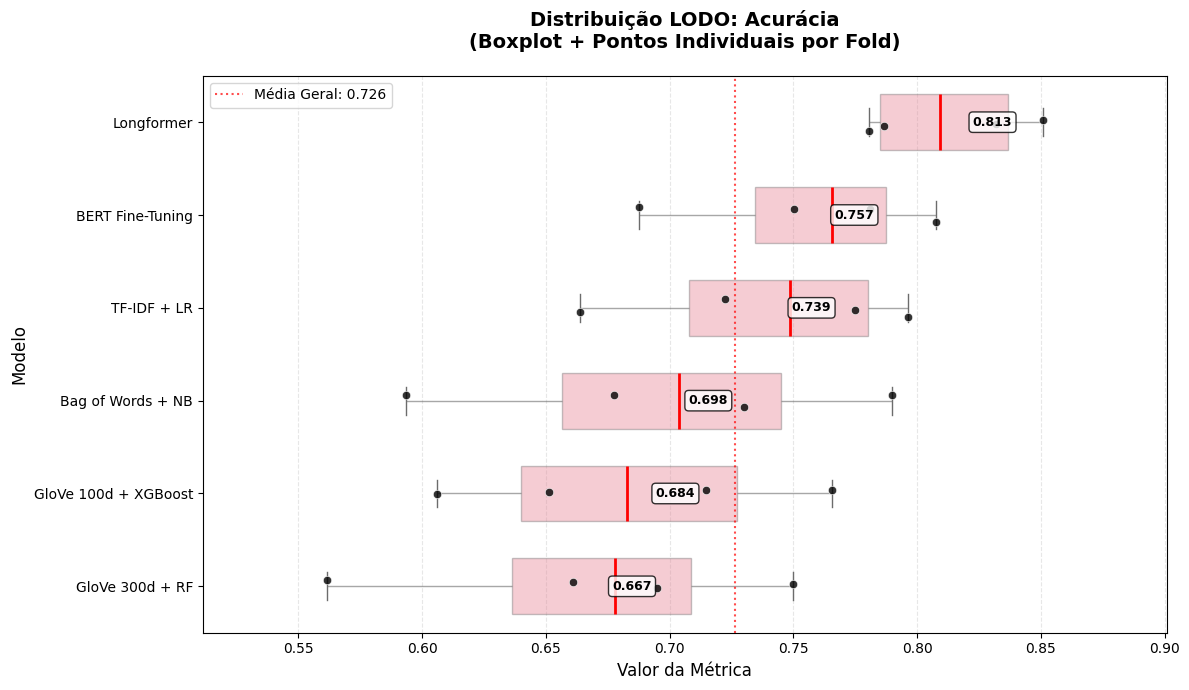

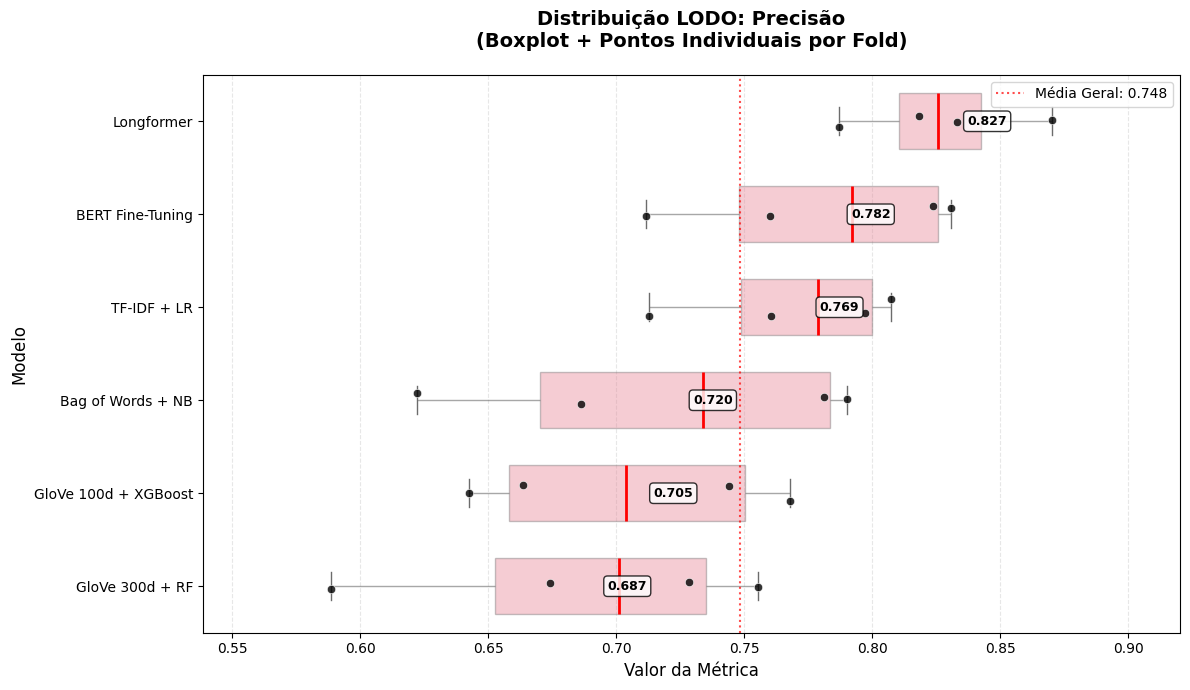

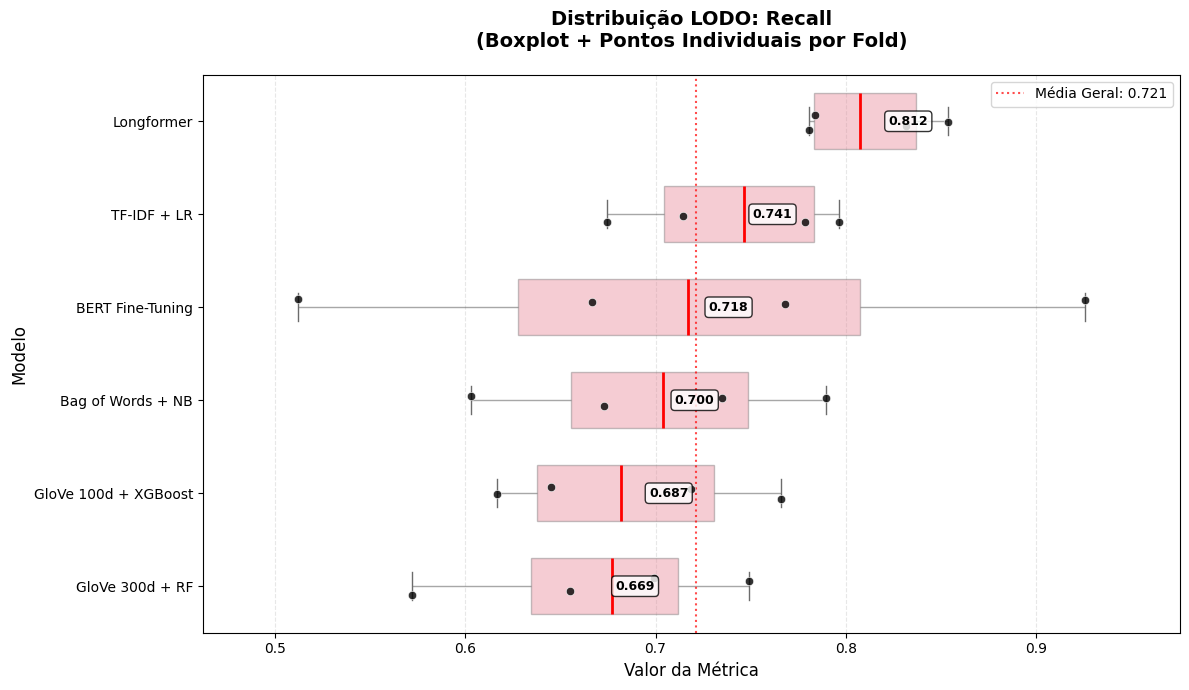

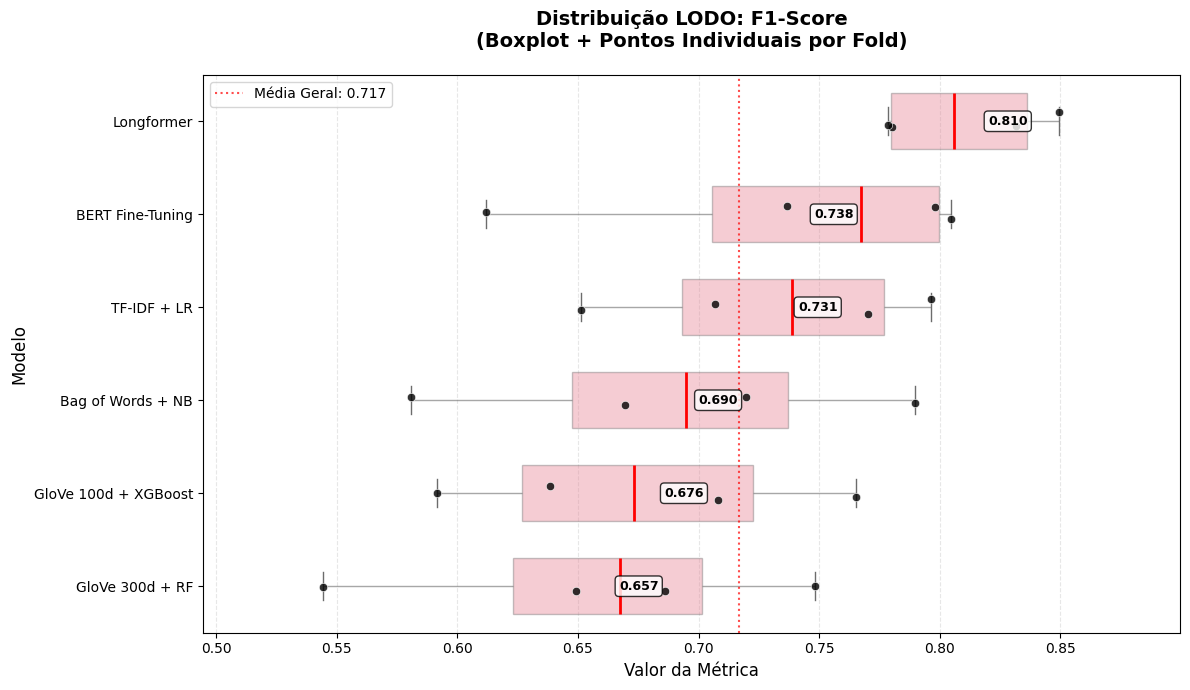


Gerando gráfico combinado (Facet Grid)...


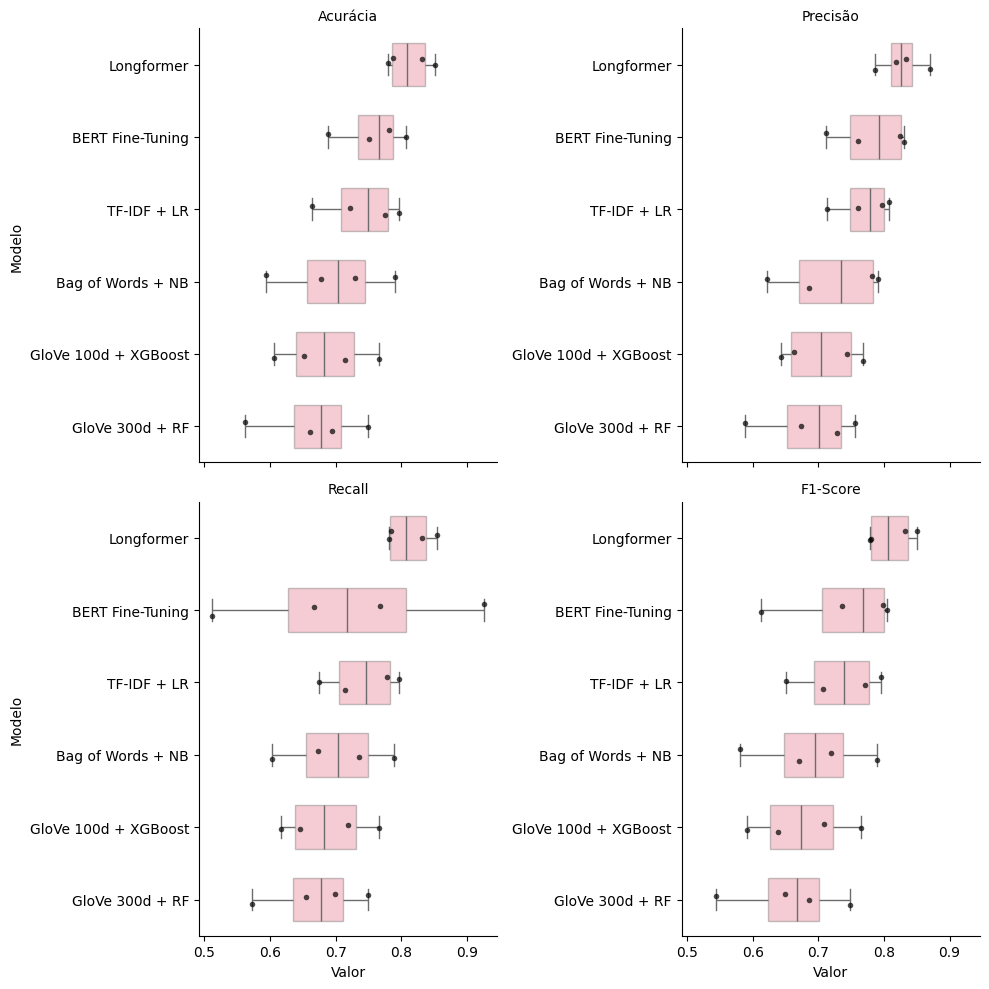

✅ Todos os gráficos gerados com sucesso!


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("Preparando dados para visualização avançada (Boxplot + Stripplot)...")

# ================================================
# 1. ACHATAMENTO DOS DADOS (Formato "Wide") - CORRIGIDO
# ================================================

plot_data_wide = []
for model_key, results_list in resultados_lodo.items():
    model_name = model_name_mapping.get(model_key, model_key)
    for i, fold_result in enumerate(results_list):
        # Extrair métricas com fallback para diferentes nomes de chaves
        accuracy = fold_result['accuracy']
        
        # Precision com fallback
        if 'precision_macro' in fold_result:
            precision = fold_result['precision_macro']
        elif 'precision' in fold_result:
            precision = fold_result['precision']
        else:
            print(f"⚠️  {model_name} - Fold {i}: Chave 'precision' não encontrada")
            precision = 0.0
        
        # Recall com fallback
        if 'recall_macro' in fold_result:
            recall = fold_result['recall_macro']
        elif 'recall' in fold_result:
            recall = fold_result['recall']
        else:
            recall = 0.0
        
        # F1-Score com fallback
        if 'f1_macro' in fold_result:
            f1 = fold_result['f1_macro']
        elif 'f1' in fold_result:
            f1 = fold_result['f1']
        else:
            f1 = 0.0
        
        plot_data_wide.append({
            'Modelo': model_name,
            'Acurácia': accuracy,
            'Precisão': precision,  # Nome simplificado
            'Recall': recall,       # Nome simplificado
            'F1-Score': f1          # Nome simplificado
        })

plot_df_wide = pd.DataFrame(plot_data_wide)

# Mostrar diagnóstico
print(f"📊 Dados preparados: {len(plot_df_wide)} linhas")
print(f"🔍 Modelos encontrados: {plot_df_wide['Modelo'].unique().tolist()}")
print(f"📈 Métricas disponíveis: {[col for col in plot_df_wide.columns if col != 'Modelo']}")

# ================================================
# 2. GERAÇÃO DOS GRÁFICOS (Um por Métrica) - CORRIGIDO
# ================================================
print("Gerando gráficos (um por métrica)...")

# Usar os nomes simplificados das métricas
metrics_to_plot = ['Acurácia', 'Precisão', 'Recall', 'F1-Score']

# Configuração de estilo
plt.style.use('default')
sns.set_palette("husl")

for metric in metrics_to_plot:
    
    # Verificar se a métrica existe nos dados
    if metric not in plot_df_wide.columns:
        print(f"⚠️  Métrica '{metric}' não encontrada nos dados. Pulando...")
        continue
        
    # --- 1. Criar uma NOVA figura para este gráfico ---
    plt.figure(figsize=(12, 7)) 
    
    # --- 2. Ordenar os modelos (do melhor para o pior) ---
    order = plot_df_wide.groupby('Modelo')[metric].median().sort_values(ascending=False).index
    
    # --- 3. Desenhar o Boxplot ---
    sns.boxplot(
        data=plot_df_wide, 
        x=metric, 
        y='Modelo', 
        orient='h', 
        order=order,
        fliersize=0,      # Oculta outliers (o stripplot mostrará)
        width=0.6,
        boxprops={"alpha": 0.4}, # Deixa a caixa transparente
        whiskerprops={"alpha": 0.6},
        medianprops={"color": "red", "linewidth": 2}
    )
    
    # --- 4. Desenhar o Stripplot (os 4 pontos de dados) sobre o boxplot ---
    sns.stripplot(
        data=plot_df_wide,
        x=metric,
        y='Modelo',
        orient='h',
        order=order,
        color='black',    # Pontos pretos para destaque
        alpha=0.8,
        jitter=0.1,       # Espalha os pontos verticalmente
        size=6,
        edgecolor='white',
        linewidth=0.5
    )
    
    # --- 5. Adicionar valores médios no gráfico ---
    for i, model in enumerate(order):
        mean_val = plot_df_wide[plot_df_wide['Modelo'] == model][metric].mean()
        plt.text(mean_val + 0.01, i, f'{mean_val:.3f}', 
                va='center', ha='left', fontsize=9, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    # --- 6. Títulos e Labels (para este gráfico) ---
    plt.title(f'Distribuição LODO: {metric}\n(Boxplot + Pontos Individuais por Fold)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Valor da Métrica', fontsize=12)
    plt.ylabel('Modelo', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    
    # Ajustar limites do eixo X para melhor visualização
    x_min = max(0, plot_df_wide[metric].min() - 0.05)
    x_max = min(1, plot_df_wide[metric].max() + 0.05)
    plt.xlim(x_min, x_max)
    
    # Adicionar linha vertical na média geral
    overall_mean = plot_df_wide[metric].mean()
    plt.axvline(x=overall_mean, color='red', linestyle=':', alpha=0.7, 
                label=f'Média Geral: {overall_mean:.3f}')
    plt.legend()
    
    plt.tight_layout()
    
    # --- 7. Mostrar o gráfico ANTES de ir para o próximo ---
    plt.show()

# ================================================
# 3. GRÁFICO ADICIONAL: Todas as métricas juntas (Facet Grid)
# ================================================
print("\nGerando gráfico combinado (Facet Grid)...")

# Converter para formato longo para o facet grid
plot_data_long = []
for model_key, results_list in resultados_lodo.items():
    model_name = model_name_mapping.get(model_key, model_key)
    for i, fold_result in enumerate(results_list):
        # Extrair métricas com fallback (mesma lógica acima)
        accuracy = fold_result['accuracy']
        
        if 'precision_macro' in fold_result:
            precision = fold_result['precision_macro']
        elif 'precision' in fold_result:
            precision = fold_result['precision']
        else:
            precision = 0.0
        
        if 'recall_macro' in fold_result:
            recall = fold_result['recall_macro']
        elif 'recall' in fold_result:
            recall = fold_result['recall']
        else:
            recall = 0.0
        
        if 'f1_macro' in fold_result:
            f1 = fold_result['f1_macro']
        elif 'f1' in fold_result:
            f1 = fold_result['f1']
        else:
            f1 = 0.0
        
        # Adicionar cada métrica como uma linha separada
        plot_data_long.extend([
            {'Modelo': model_name, 'Métrica': 'Acurácia', 'Valor': accuracy, 'Fold': i},
            {'Modelo': model_name, 'Métrica': 'Precisão', 'Valor': precision, 'Fold': i},
            {'Modelo': model_name, 'Métrica': 'Recall', 'Valor': recall, 'Fold': i},
            {'Modelo': model_name, 'Métrica': 'F1-Score', 'Valor': f1, 'Fold': i}
        ])

plot_df_long = pd.DataFrame(plot_data_long)

# Criar facet grid
g = sns.FacetGrid(plot_df_long, col='Métrica', col_wrap=2, height=5, sharey=False)
g.map(sns.boxplot, 'Valor', 'Modelo', order=order, orient='h', 
      fliersize=0, width=0.6, boxprops={"alpha": 0.4})
g.map(sns.stripplot, 'Valor', 'Modelo', order=order, orient='h',
      color='black', alpha=0.7, jitter=0.1, size=4)

g.set_titles("{col_name}")
g.set_axis_labels("Valor", "Modelo")
g.tight_layout()

plt.show()

print("✅ Todos os gráficos gerados com sucesso!")

# Matriz de confusao

Gerando Matrizes de Confusão Agregadas (LODO)...
📊 Modelos disponíveis: ['BERT', 'Longformer', 'NaiveBayes', 'LogisticRegression', 'RandomForest', 'XGBoost']

🔍 Processando BERT Fine-Tuning...
   ✅ Fold 0: 4469 amostras
   ✅ Fold 1: 2127 amostras
   ✅ Fold 2: 605 amostras
   ✅ Fold 3: 452 amostras
   📊 Total agregado: 7653 amostras
   🎯 Distribuição real: (array([0, 1]), array([3843, 3810], dtype=int64))
   🔮 Distribuição predita: (array([0, 1]), array([3513, 4140], dtype=int64))


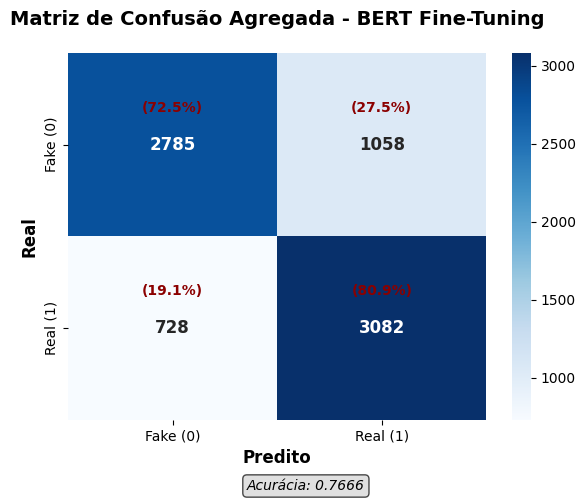


🔍 Processando Longformer...
   ✅ Fold 0: 4469 amostras
   ✅ Fold 1: 2127 amostras
   ✅ Fold 2: 605 amostras
   ✅ Fold 3: 452 amostras
   📊 Total agregado: 7653 amostras
   🎯 Distribuição real: (array([0, 1]), array([3843, 3810], dtype=int64))
   🔮 Distribuição predita: (array([0, 1]), array([3595, 4058], dtype=int64))


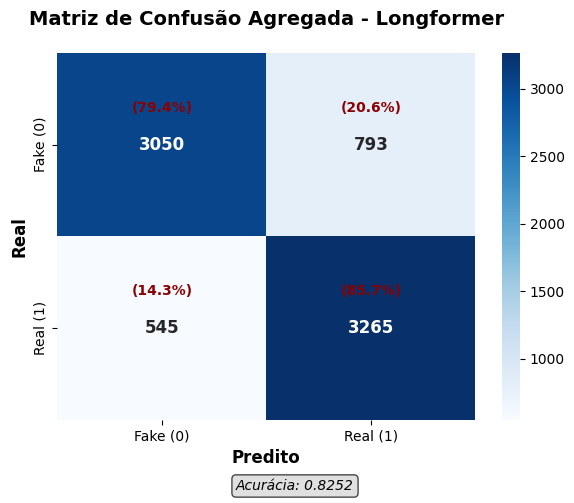


🔍 Processando BoW + NB...
   ✅ Fold 0: 4469 amostras
   ✅ Fold 1: 2127 amostras
   ✅ Fold 2: 605 amostras
   ✅ Fold 3: 452 amostras
   📊 Total agregado: 7653 amostras
   🎯 Distribuição real: (array([0, 1]), array([3843, 3810], dtype=int64))
   🔮 Distribuição predita: (array([0, 1]), array([3435, 4218], dtype=int64))


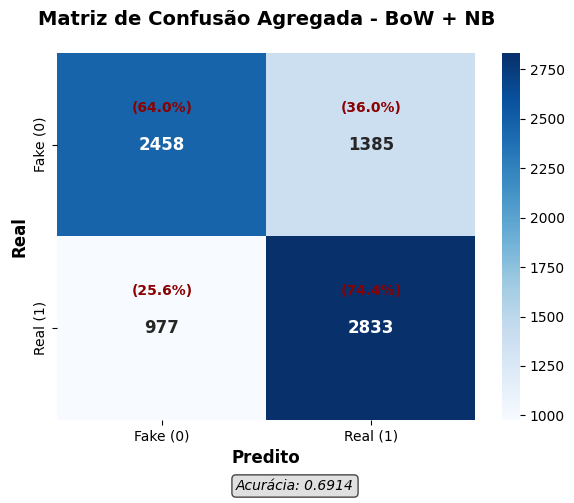


🔍 Processando TF-IDF + LR...
   ✅ Fold 0: 4469 amostras
   ✅ Fold 1: 2127 amostras
   ✅ Fold 2: 605 amostras
   ✅ Fold 3: 452 amostras
   📊 Total agregado: 7653 amostras
   🎯 Distribuição real: (array([0, 1]), array([3843, 3810], dtype=int64))
   🔮 Distribuição predita: (array([0, 1]), array([3740, 3913], dtype=int64))


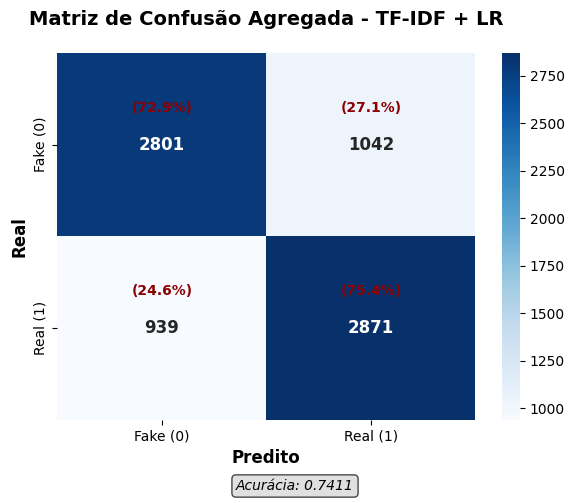


🔍 Processando GloVe 300d + RF...
   ✅ Fold 0: 4469 amostras
   ✅ Fold 1: 2127 amostras
   ✅ Fold 2: 605 amostras
   ✅ Fold 3: 452 amostras
   📊 Total agregado: 7653 amostras
   🎯 Distribuição real: (array([0, 1]), array([3843, 3810], dtype=int64))
   🔮 Distribuição predita: (array([0, 1]), array([3624, 4029], dtype=int64))


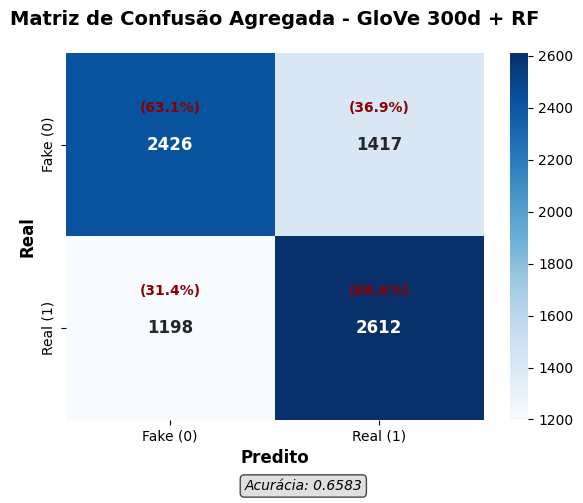


🔍 Processando GloVe 100d + XGBoost...
   ✅ Fold 0: 4469 amostras
   ✅ Fold 1: 2127 amostras
   ✅ Fold 2: 605 amostras
   ✅ Fold 3: 452 amostras
   📊 Total agregado: 7653 amostras
   🎯 Distribuição real: (array([0, 1]), array([3843, 3810], dtype=int64))
   🔮 Distribuição predita: (array([0, 1]), array([3641, 4012], dtype=int64))


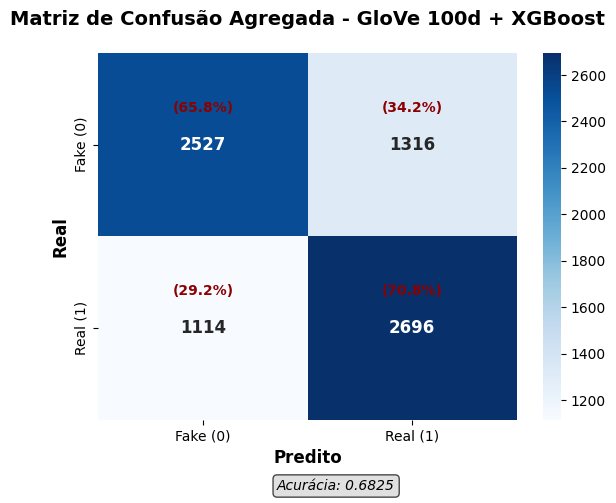


📈 ESTATÍSTICAS DETALHADAS POR MODELO

📊 BERT Fine-Tuning:
   ✅ Acurácia:  0.7666
   🎯 Precisão: 0.7444
   🔍 Recall:    0.8089
   ⚖️  F1-Score: 0.7753
   �� Matriz: TN=2785, FP=1058, FN=728, TP=3082

📊 Longformer:
   ✅ Acurácia:  0.8252
   🎯 Precisão: 0.8046
   🔍 Recall:    0.8570
   ⚖️  F1-Score: 0.8299
   �� Matriz: TN=3050, FP=793, FN=545, TP=3265

📊 BoW + NB:
   ✅ Acurácia:  0.6914
   🎯 Precisão: 0.6716
   🔍 Recall:    0.7436
   ⚖️  F1-Score: 0.7058
   �� Matriz: TN=2458, FP=1385, FN=977, TP=2833

📊 TF-IDF + LR:
   ✅ Acurácia:  0.7411
   🎯 Precisão: 0.7337
   🔍 Recall:    0.7535
   ⚖️  F1-Score: 0.7435
   �� Matriz: TN=2801, FP=1042, FN=939, TP=2871

📊 GloVe 300d + RF:
   ✅ Acurácia:  0.6583
   🎯 Precisão: 0.6483
   🔍 Recall:    0.6856
   ⚖️  F1-Score: 0.6664
   �� Matriz: TN=2426, FP=1417, FN=1198, TP=2612

📊 GloVe 100d + XGBoost:
   ✅ Acurácia:  0.6825
   🎯 Precisão: 0.6720
   🔍 Recall:    0.7076
   ⚖️  F1-Score: 0.6893
   �� Matriz: TN=2527, FP=1316, FN=1114, TP=2696

🎉 Todas as

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# ==========================================================
# 8. MATRIZES DE CONFUSÃO AGREGADAS (LODO)
# ==========================================================
# 
# Este código substitui sua célula anterior.
# Ele agrega os resultados de todos os 4 folds do LODO
# para criar uma matriz de confusão total para cada modelo.
#
# ==========================================================

# Mapeia os nomes-chave (do dicionário) para nomes amigáveis
model_name_mapping = {
    'NaiveBayes': 'BoW + NB',
    'LogisticRegression': 'TF-IDF + LR',
    'RandomForest': 'GloVe 300d + RF',
    'XGBoost': 'GloVe 100d + XGBoost',
    'BERT': 'BERT Fine-Tuning',
    'Longformer': 'Longformer'
}

# --- Função de plotagem melhorada ---
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    
    # Calcular porcentagens
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    plt.figure(figsize=(6, 5))
    
    # Plotar heatmap com valores absolutos e porcentagens
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Fake (0)', 'Real (1)'],
                yticklabels=['Fake (0)', 'Real (1)'],
                annot_kws={"size": 12, "weight": "bold"})
    
    # Adicionar porcentagens como texto secundário
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j + 0.5, i + 0.3, f'({cm_percent[i, j]:.1f}%)',
                    ha='center', va='center', fontsize=10, color='darkred',
                    weight='bold')
    
    plt.xlabel('Predito', fontsize=12, fontweight='bold')
    plt.ylabel('Real', fontsize=12, fontweight='bold')
    plt.title(f'Matriz de Confusão Agregada - {model_name}', 
              fontsize=14, fontweight='bold', pad=20)
    
    # Adicionar métricas no rodapé
    accuracy = np.mean(y_true == y_pred)
    plt.figtext(0.5, 0.01, f'Acurácia: {accuracy:.4f}', 
                ha='center', fontsize=10, style='italic',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Espaço para o texto adicional
    plt.show()

# --- Lógica de Agregação ---
print("Gerando Matrizes de Confusão Agregadas (LODO)...")
print("=" * 60)

# Verificar quais modelos estão disponíveis
available_models = list(resultados_lodo.keys())
print(f"📊 Modelos disponíveis: {available_models}")

for model_key in available_models:
    
    # Pega o nome amigável
    model_name = model_name_mapping.get(model_key, model_key)
    
    # Pula se o modelo não tiver rodado ou não tiver predições
    if not resultados_lodo[model_key]:
        print(f"⚠️  Aviso: Pulando '{model_name}' (lista vazia em 'resultados_lodo').")
        continue
    
    # --- INÍCIO DA CORREÇÃO NESTE BLOCO ---
    first_result = resultados_lodo[model_key][0]
    
    y_true_options = ['y_true', 'true_labels']
    y_pred_options = ['y_pred', 'predictions']

    # Verifica se alguma das chaves de y_true ou y_pred existe
    found_y_true_key_for_check = next((key for key in y_true_options if key in first_result), None)
    found_y_pred_key_for_check = next((key for key in y_pred_options if key in first_result), None)

    if not found_y_true_key_for_check or not found_y_pred_key_for_check:
        print(f"⚠️  Aviso: Pulando '{model_name}' (sem dados de predição válidos). Chaves disponíveis: {list(first_result.keys())}")
        continue
    # --- FIM DA CORREÇÃO NESTE BLOCO ---

    print(f"\n🔍 Processando {model_name}...")
    
    try:
        # 1. Cria listas de todos os y_true e y_pred dos 4 folds
        all_y_true = []
        all_y_pred = []
        
        for i, fold_result in enumerate(resultados_lodo[model_key]):
            # Tentar chaves específicas para BERT/Longformer, senão usar padrão
            # Esta lógica já estava correta, mas agora será alcançada
            y_true = fold_result.get('true_labels', fold_result.get('y_true'))
            y_pred = fold_result.get('predictions', fold_result.get('y_pred'))

            if y_true is None or y_pred is None:
                print(f"   Aviso: Chaves de predição (y_true/true_labels, y_pred/predictions) não encontradas para {model_name} fold {i}.")
                continue
            
            # Verificar se são arrays numpy ou listas
            if hasattr(y_true, 'shape'):
                y_true = y_true.tolist() if hasattr(y_true, 'tolist') else list(y_true)
            if hasattr(y_pred, 'shape'):
                y_pred = y_pred.tolist() if hasattr(y_pred, 'tolist') else list(y_pred)
            
            all_y_true.extend(y_true)
            all_y_pred.extend(y_pred)
            
            print(f"   ✅ Fold {i}: {len(y_true)} amostras")
        
        # 2. Converter para arrays numpy
        aggregated_y_true = np.array(all_y_true)
        aggregated_y_pred = np.array(all_y_pred)
        
        print(f"   📊 Total agregado: {len(aggregated_y_true)} amostras")
        print(f"   🎯 Distribuição real: {np.unique(aggregated_y_true, return_counts=True)}")
        print(f"   🔮 Distribuição predita: {np.unique(aggregated_y_pred, return_counts=True)}")
        
        # 3. Plota a matriz de confusão única baseada nos dados agregados
        plot_confusion_matrix(aggregated_y_true, aggregated_y_pred, model_name)
        
    except Exception as e:
        print(f"❌ Erro ao processar {model_name}: {e}")
        import traceback
        traceback.print_exc()
        continue

# --- ESTATÍSTICAS ADICIONAIS ---
print("\n" + "=" * 60)
print("📈 ESTATÍSTICAS DETALHADAS POR MODELO")
print("=" * 60)

for model_key in available_models:
    if model_key not in model_name_mapping:
        continue
        
    model_name = model_name_mapping[model_key]
    
    # Adicionar esta verificação antes de tentar acessar resultados_lodo[model_key][0]
    if not resultados_lodo[model_key]:
        print(f"⚠️  Aviso: Pulando '{model_name}' (lista vazia de resultados para estatísticas detalhadas).")
        continue

    first_result = resultados_lodo[model_key][0]

    # --- INÍCIO DA CORREÇÃO NESTE BLOCO ---
    # Definir as chaves esperadas para y_true e y_pred
    y_true_options = ['y_true', 'true_labels']
    y_pred_options = ['y_pred', 'predictions']

    found_y_true_key_for_check = next((key for key in y_true_options if key in first_result), None)
    found_y_pred_key_for_check = next((key for key in y_pred_options if key in first_result), None)

    if not found_y_true_key_for_check or not found_y_pred_key_for_check:
        print(f"⚠️  Aviso: Pulando '{model_name}' (sem dados de predição válidos para estatísticas detalhadas). Chaves disponíveis: {list(first_result.keys())}")
        continue
    # --- FIM DA CORREÇÃO NESTE BLOCO ---
    
    try:
        # Agregar dados novamente para estatísticas
        all_y_true = []
        all_y_pred = []
        
        for fold_result in resultados_lodo[model_key]:
            # Esta parte já estava correta após a sua primeira aplicação
            y_true = fold_result[found_y_true_key_for_check]
            y_pred = fold_result[found_y_pred_key_for_check]
            
            if hasattr(y_true, 'shape'):
                y_true = y_true.tolist() if hasattr(y_true, 'tolist') else list(y_true)
            if hasattr(y_pred, 'shape'):
                y_pred = y_pred.tolist() if hasattr(y_pred, 'tolist') else list(y_pred)
            
            all_y_true.extend(y_true)
            all_y_pred.extend(y_pred)
        
        aggregated_y_true = np.array(all_y_true)
        aggregated_y_pred = np.array(all_y_pred)
        
        # Calcular métricas detalhadas
        accuracy = np.mean(aggregated_y_true == aggregated_y_pred)
        cm = confusion_matrix(aggregated_y_true, aggregated_y_pred)
        
        # Para classificação binária
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            print(f"\n📊 {model_name}:")
            print(f"   ✅ Acurácia:  {accuracy:.4f}")
            print(f"   🎯 Precisão: {precision:.4f}")
            print(f"   🔍 Recall:    {recall:.4f}")
            print(f"   ⚖️  F1-Score: {f1:.4f}")
            print(f"   �� Matriz: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
            
    except Exception as e:
        print(f"❌ Erro nas estatísticas de {model_name}: {e}")

print("\n🎉 Todas as matrizes de confusão geradas com sucesso!")

# Otimizacao de modelos

## Otimizando o modelo BoW + Naive Bayes

🔍 Otimização será executada em 3184 registros.
   Datasets usados para otimização: ['Fake News Dataset' 'Fake or Real News Dataset'
 'Fake News Detection Dataset']

🚀 Iniciando otimização de hiperparâmetros para Naive Bayes...

⚡ Executando otimização com 20 trials...


  0%|          | 0/20 [00:00<?, ?it/s]


🎉 Otimização concluída!
✅ Melhor F1-Score (Macro): 0.8924
🎯 Melhores parâmetros para Naive Bayes:
   - ngram_range: (1, 2)
   - max_features: 16330
   - alpha: 0.06878454392587316
   - fit_prior: False

📊 Criando visualizações...


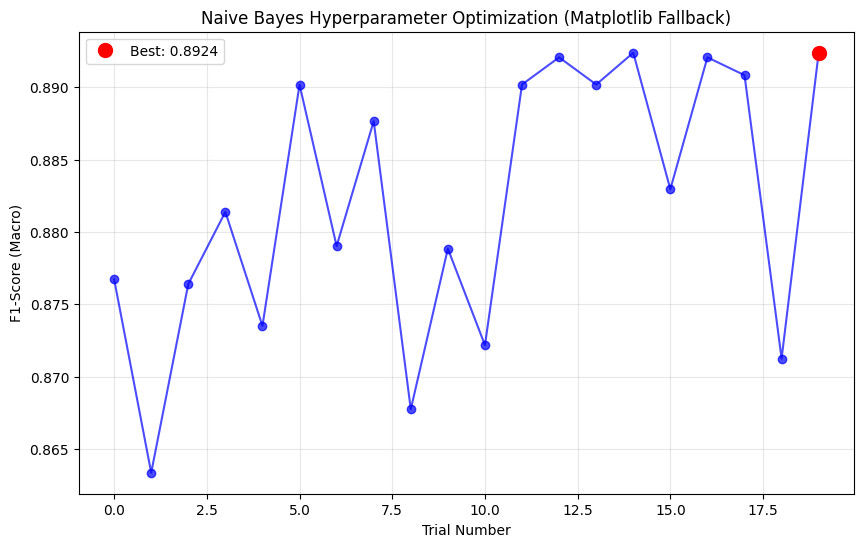


📊 RESUMO DA OTIMIZAÇÃO
📈 Estatísticas dos Trials:
   - Total de trials: 20
   - Trials completados: 20
   - Melhor F1-Score: 0.8924
   - Pior F1-Score: 0.8634
   - F1-Score médio: 0.8821

🏆 Top 3 Melhores Trials:
   1. Trial 19: F1=0.8924, Params={'ngram_range': (1, 2), 'max_features': 16330, 'alpha': 0.06878454392587316, 'fit_prior': False}
   2. Trial 14: F1=0.8924, Params={'ngram_range': (1, 2), 'max_features': 15772, 'alpha': 0.16983143648727828, 'fit_prior': False}
   3. Trial 12: F1=0.8921, Params={'ngram_range': (1, 2), 'max_features': 20000, 'alpha': 0.3473267377004406, 'fit_prior': False}
💾 Resultados salvos em: naive_bayes_optimization.txt

🎉 OTIMIZAÇÃO DE NAIVE BAYES CONCLUÍDA!
🏆 Melhor F1-Score: 0.8924
⚙️  Melhores parâmetros salvos no dicionário 'optimized_params['NaiveBayes']'


In [42]:
import optuna
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING) # Desabilitar logs verbosos

# ================================================
# 1. CRIAR DATASET DE OTIMIZAÇÃO (SEGURO)
# ================================================
# Para evitar vazamento, vamos otimizar os hiperparâmetros
# em um subconjunto dos dados que NÃO INCLUI nosso
# dataset de teste final do LODO (ex: 'ISOT Fake News Dataset').

# Substitua pelo nome do dataset que você quer EXCLUIR da otimização
HOLDOUT_DATASET_NAME = 'ISOT Fake News Dataset' 

# Garante que 'data' existe (pode ter vindo da Seção 2)
if 'data' not in locals():
    print("❌ ERRO: DataFrame 'data' não encontrado. Rode a Seção 2 (Carregamento) primeiro.")
else:
    # Cria o sub-dataset de otimização
    data_for_optimization = data[data['source_dataset'] != HOLDOUT_DATASET_NAME].copy()

    # <<< CORREÇÃO AQUI >>>
    # Usamos o texto limpo (mascarado)
    # Estas são as variáveis corretas, em vez de 'X_train_bow'
    X_opt = data_for_optimization['text_clean']
    y_opt = data_for_optimization['label']

    print(f"🔍 Otimização será executada em {len(X_opt)} registros.")
    print(f"   Datasets usados para otimização: {data_for_optimization['source_dataset'].unique()}")


# ================================================
# 2. FUNÇÃO DE OBJETIVO (COM PIPELINE)
# ================================================

def objective_nb(trial):
    """Função de objetivo para otimização do Naive Bayes com Pipeline"""
    
    # --- Otimizar Vetorizador (BoW) ---
    params_vectorizer = {
        'ngram_range': trial.suggest_categorical('ngram_range', [(1,1), (1,2)]),
        'max_features': trial.suggest_int('max_features', 5000, 20000, log=True)
    }
    
    # --- Otimizar Modelo ---
    params_model = {
        'alpha': trial.suggest_float('alpha', 0.01, 10.0, log=True),
        'fit_prior': trial.suggest_categorical('fit_prior', [True, False])
    }

    try:
        # O pipeline garante que o CountVectorizer é "fitado"
        # de novo em cada fold da validação cruzada (prevenindo vazamento).
        pipeline = Pipeline([
            ('vectorizer', CountVectorizer(**params_vectorizer)),
            ('model', MultinomialNB(**params_model))
        ])

        scoring_metrics = {
            'accuracy': 'accuracy',
            'precision_macro': 'precision_macro',
            'recall_macro': 'recall_macro',
            'f1_macro': 'f1_macro'
        }
        
        kf = KFold(n_splits=3, shuffle=True, random_state=142857)
        
        # 2. Usar cross_validate para calcular todas de uma vez
        scores = cross_validate(pipeline, X_opt, y_opt, cv=kf, scoring=scoring_metrics)

        # 3. Calcular a média de cada métrica
        mean_accuracy = np.mean(scores['test_accuracy'])
        mean_precision = np.mean(scores['test_precision_macro'])
        mean_recall = np.mean(scores['test_recall_macro'])
        mean_f1 = np.mean(scores['test_f1_macro'])

        trial.set_user_attr("accuracy", mean_accuracy)
        trial.set_user_attr("precision_macro", mean_precision)
        trial.set_user_attr("recall_macro", mean_recall)

        return mean_f1
    
    except Exception as e:
        if 'NameError' not in str(e): # Evita poluir o log se X_opt não existir
            print(f"❌ Erro no trial: {e}")
        return 0.0  # Retornar score baixo

# ================================================
# 3. EXECUTAR OTIMIZAÇÃO
# ================================================

print("\n🚀 Iniciando otimização de hiperparâmetros para Naive Bayes...")
print("="*60)

study_nb = optuna.create_study(
    direction='maximize', 
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)
)

print(f"\n⚡ Executando otimização com 20 trials...")

try:
    # Verifica se X_opt existe antes de rodar
    if 'X_opt' in locals():
        # n_jobs=-1 usa todos os cores, mude para 1 se travar
        study_nb.optimize(objective_nb, n_trials=20, n_jobs=1, show_progress_bar=True) 
        
        # Resultados
        print(f"\n🎉 Otimização concluída!")
        print(f"✅ Melhor F1-Score (Macro): {study_nb.best_value:.4f}")
        print(f"🎯 Melhores parâmetros para Naive Bayes:")
        
        best_params_nb = study_nb.best_params
        for param, value in best_params_nb.items():
            print(f"   - {param}: {value}")
            
        # Salva os melhores parâmetros para usarmos no LODO
        if 'optimized_params' not in locals():
            optimized_params = {}
        optimized_params['NaiveBayes'] = best_params_nb
        
    else:
        print("❌ Otimização pulada. 'X_opt' não foi definido (rode a Seção 2).")

except Exception as e:
    print(f"❌ Erro durante otimização: {e}")


# ================================================
# 4. VISUALIZAÇÃO E RESUMO (Seu código, está ótimo)
# ================================================
# (Suas funções 'safe_plot_optimization_history', 'print_optimization_summary',
#  e 'save_optimization_results' são ótimas e podem ser mantidas aqui)

def safe_plot_optimization_history(study, title="Optimization History"):
    """Plota histórico de otimização com tratamento de erro"""
    try:
        trials = study.trials
        values = [t.value for t in trials if t.value is not None]
        if values:
            plt.figure(figsize=(10, 6))
            plt.plot(values, 'b-o', alpha=0.7)
            plt.xlabel('Trial Number')
            plt.ylabel('F1-Score (Macro)')
            plt.title(f'{title} (Matplotlib Fallback)')
            plt.grid(True, alpha=0.3)
            best_idx = np.argmax(values)
            plt.plot(best_idx, values[best_idx], 'ro', markersize=10, label=f'Best: {values[best_idx]:.4f}')
            plt.legend()
            plt.show()
        else:
                print(f"❌ Nenhum trial válido encontrado para plotar com Matplotlib.")
    except Exception as e_plt:
        print(f"❌ Falha no fallback do Matplotlib: {e_plt}")


def print_optimization_summary(study):
    """Imprime resumo da otimização sem gráficos"""
    # (Seu código de resumo aqui...)
    print(f"\n📊 RESUMO DA OTIMIZAÇÃO")
    print("="*50)
    trials = study.trials
    completed_trials = [t for t in trials if t.value is not None]
    if completed_trials:
        values = [t.value for t in completed_trials]
        print(f"📈 Estatísticas dos Trials:")
        print(f"   - Total de trials: {len(trials)}")
        print(f"   - Trials completados: {len(completed_trials)}")
        if values: # Garante que a lista não está vazia
             print(f"   - Melhor F1-Score: {max(values):.4f}")
             print(f"   - Pior F1-Score: {min(values):.4f}")
             print(f"   - F1-Score médio: {np.mean(values):.4f}")
        
        print(f"\n🏆 Top 3 Melhores Trials:")
        sorted_trials = sorted(completed_trials, key=lambda x: x.value, reverse=True)
        for i, trial in enumerate(sorted_trials[:3]):
            print(f"   {i+1}. Trial {trial.number}: F1={trial.value:.4f}, Params={trial.params}")
    else:
        print(f"❌ Nenhum trial foi completado com sucesso")

def save_optimization_results(study, filename="naive_bayes_optimization.txt"):
    """Salva resultados da otimização em arquivo"""
    # (Seu código de salvar aqui...)
    try:
        with open(filename, 'w') as f:
            f.write("RESULTADOS DA OTIMIZAÇÃO - NAIVE BAYES\n")
            f.write("="*50 + "\n\n")
            if study.best_value is not None:
                f.write(f"Melhor F1-Score: {study.best_value:.4f}\n")
                f.write(f"Melhores Parâmetros:\n")
                for param, value in study.best_params.items():
                    f.write(f"   - {param}: {value}\n")
            
            f.write(f"\nTodos os Trials:\n")
            for trial in study.trials:
                if trial.value is not None:
                    f.write(f"Trial {trial.number}: F1={trial.value:.4f}, Params={trial.params}\n")
        print(f"💾 Resultados salvos em: {filename}")
    except Exception as e:
        print(f"❌ Erro ao salvar resultados: {e}")

# ================================================
# 5. EXECUTAR VISUALIZAÇÃO E SALVAMENTO
# ================================================
# (Removemos a seção "TREINAR MODELO FINAL", pois ela
#  reintroduz o data leakage e não é necessária.)

if 'study_nb' in locals() and study_nb.trials:
    print(f"\n📊 Criando visualizações...")
    safe_plot_optimization_history(study_nb, "Naive Bayes Hyperparameter Optimization")
    print_optimization_summary(study_nb)
    save_optimization_results(study_nb)
else:
    print("❌ Estudo de otimização não foi executado ou não tem trials.")


print(f"\n🎉 OTIMIZAÇÃO DE NAIVE BAYES CONCLUÍDA!")
if 'study_nb' in locals() and study_nb.best_value is not None:
    print(f"🏆 Melhor F1-Score: {study_nb.best_value:.4f}")
    print(f"⚙️  Melhores parâmetros salvos no dicionário 'optimized_params['NaiveBayes']'")

## Otimizando o modelo TF-IDF com Regressao Logistica

🔍 Verificando dados para otimização Logistic Regression...
📊 Usando X_opt (shape): (3184,)
📊 Usando y_opt (shape): (3184,)
🏷️  Classes únicas: [0 1]

🚀 Iniciando otimização de hiperparâmetros para Logistic Regression...
⚡ Executando otimização com 10 trials...


  0%|          | 0/10 [00:00<?, ?it/s]


🎉 Otimização concluída!
✅ Melhor F1-Score (Macro) na validação cruzada: 0.9060
🎯 Melhores parâmetros para o Pipeline (LR):
   - ngram_range: (1, 3)
   - max_features: 29721
   - C: 7.923717338683701
   - penalty: l2
   - solver: liblinear

📊 Criando visualização personalizada para Logistic Regression...


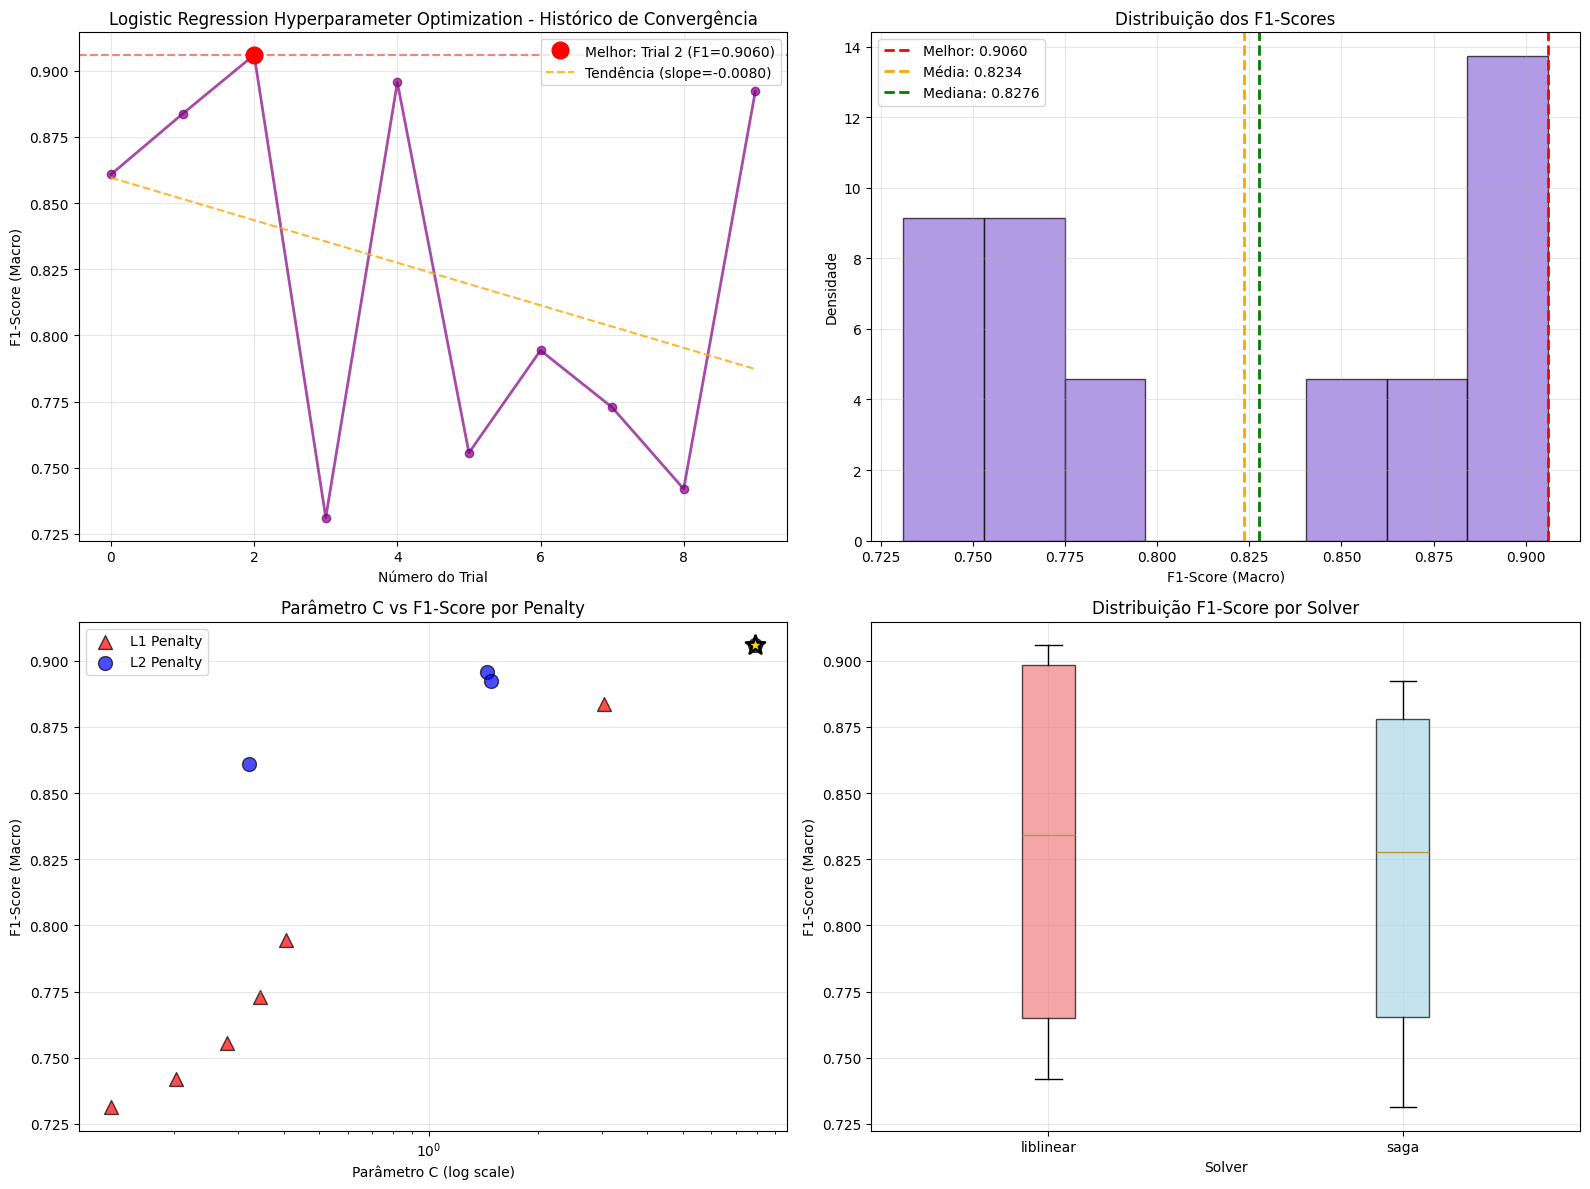


📋 ANÁLISE DETALHADA DOS TRIALS - LOGISTIC REGRESSION
📊 Estatísticas dos Trials:
   - Total de trials: 10
   - Trials completados: 10
   - Taxa de sucesso: 100.0%
   - Melhor F1-Score: 0.9060
   - Pior F1-Score: 0.7312
   - F1-Score médio: 0.8234
   - Desvio padrão: 0.0670
   - Mediana: 0.8276
   - Amplitude: 0.1748

🏆 Top 5 Melhores Trials:

   🥇 #1 - Trial 2: F1=0.9060
      - ngram_range: (1, 3)
      - max_features: 29721
      - C: 7.9237
      - penalty: l2
      - solver: liblinear

   🥇 #2 - Trial 4: F1=0.8957
      - ngram_range: (1, 3)
      - max_features: 25258
      - C: 1.4454
      - penalty: l2
      - solver: liblinear

   🥇 #3 - Trial 9: F1=0.8922
      - ngram_range: (1, 2)
      - max_features: 17079
      - C: 1.4861
      - penalty: l2
      - solver: saga

   🥇 #4 - Trial 1: F1=0.8837
      - ngram_range: (1, 1)
      - max_features: 14765
      - C: 3.0426
      - penalty: l1
      - solver: saga

   🥇 #5 - Trial 0: F1=0.8608
      - ngram_range: (1, 1)
      - 

In [43]:
import optuna
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ================================================
# DESABILITAR LOGS VERBOSOS DO OPTUNA
# ================================================
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ================================================
# 1. VERIFICAR DADOS DE OTIMIZAÇÃO (SEGURO)
# ================================================
# Verifica se X_opt e y_opt (criados na célula anterior) existem.

print("🔍 Verificando dados para otimização Logistic Regression...")
print("="*60)
try:
    print(f"📊 Usando X_opt (shape): {X_opt.shape}")
    print(f"📊 Usando y_opt (shape): {y_opt.shape}")
    print(f"🏷️  Classes únicas: {np.unique(y_opt)}")
except NameError as e:
    print(f"❌ Variável não encontrada: {e}")
    print("💡 Certifique-se de ter executado a célula anterior (Optuna-NB) primeiro.")
    # Você pode adicionar as linhas de criação do X_opt/y_opt aqui se quiser
    # que esta célula seja 100% independente.

# ================================================
# 2. FUNÇÃO DE OBJETIVO (COM PIPELINE)
# ================================================

def objective_lr(trial):
    """Função de objetivo para otimização da Logistic Regression com Pipeline"""
    
    # --- Otimizar Vetorizador ---
    params_vectorizer = {
        'ngram_range': trial.suggest_categorical('ngram_range', [(1, 1), (1, 2), (1, 3)]),
        'max_features': trial.suggest_int('max_features', 10000, 30000, log=True)
    }
    
    # --- Otimizar Modelo (seu código) ---
    C = trial.suggest_float('C', 0.1, 10.0, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    
    # Lógica de compatibilidade (seu código, está correto)
    if penalty == 'l1' and solver not in ['liblinear', 'saga']:
        solver = 'liblinear'
    
    params_model = {
        'C': trial.suggest_float('C', 0.1, 10.0, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': 'liblinear',
        'max_iter': 500,
        'random_state': 42,
        'n_jobs': 1
    }

    try:
        pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(**params_vectorizer)),
            ('model', LogisticRegression(**params_model))
        ])
        
        kf = KFold(n_splits=3, shuffle=True, random_state=142857)
        # 1. Definir todas as métricas que queremos
        scoring_metrics = {
            'accuracy': 'accuracy',
            'precision_macro': 'precision_macro',
            'recall_macro': 'recall_macro',
            'f1_macro': 'f1_macro'
        }        
        
        # 2. Usar cross_validate para calcular todas de uma vez
        scores = cross_validate(pipeline, X_opt, y_opt, cv=kf, scoring=scoring_metrics)

        # 3. Calcular a média de cada métrica
        mean_accuracy = np.mean(scores['test_accuracy'])
        mean_precision = np.mean(scores['test_precision_macro'])
        mean_recall = np.mean(scores['test_recall_macro'])
        mean_f1 = np.mean(scores['test_f1_macro'])

        # 4. Salvar as métricas extras no "user_attrs" do trial
        trial.set_user_attr("accuracy", mean_accuracy)
        trial.set_user_attr("precision_macro", mean_precision)
        trial.set_user_attr("recall_macro", mean_recall)

        return mean_f1
    
    except Exception as e:
        print(f"❌ Erro no trial {trial.number}: {e}")
        return 0.0  # Retornar score baixo

# ================================================
# 3. EXECUTAR OTIMIZAÇÃO
# ================================================

print(f"\n🚀 Iniciando otimização de hiperparâmetros para Logistic Regression...")
print("="*70)

study_lr = optuna.create_study(
    direction='maximize', 
    pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=5)
)

print(f"⚡ Executando otimização com 10 trials...")
study_lr.optimize(objective_lr, n_trials=10, n_jobs=-1, show_progress_bar=True) # n_jobs=-1 é seguro aqui

print(f"\n🎉 Otimização concluída!")
print(f"✅ Melhor F1-Score (Macro) na validação cruzada: {study_lr.best_value:.4f}")
print(f"🎯 Melhores parâmetros para o Pipeline (LR):")
best_params_lr = study_lr.best_params
for param, value in best_params_lr.items():
    print(f"   - {param}: {value}")

# Salva os melhores parâmetros para usarmos no LODO
if 'optimized_params' not in locals():
    optimized_params = {}
optimized_params['LogisticRegression'] = best_params_lr


# ================================================
# 4. VISUALIZAÇÃO E ANÁLISE (Seu código, está ótimo)
# ================================================
# (Seu código 'plot_lr_optimization_history' e 'analyze_lr_trials_detailed' 
#  pode ser colado aqui, pois ele analisa o 'study_lr' e está correto)

def analyze_lr_trials_detailed(study):

    """Análise detalhada dos trials da Logistic Regression"""

    print(f"\n📋 ANÁLISE DETALHADA DOS TRIALS - LOGISTIC REGRESSION")
    print("="*70)
    trials = study.trials
    completed_trials = [t for t in trials if t.value is not None]

    if not completed_trials:
        print("❌ Nenhum trial completado")
        return

    values = [t.value for t in completed_trials]
    print(f"📊 Estatísticas dos Trials:")
    print(f"   - Total de trials: {len(trials)}")
    print(f"   - Trials completados: {len(completed_trials)}")
    print(f"   - Taxa de sucesso: {len(completed_trials)/len(trials)*100:.1f}%")
    print(f"   - Melhor F1-Score: {max(values):.4f}")
    print(f"   - Pior F1-Score: {min(values):.4f}")
    print(f"   - F1-Score médio: {np.mean(values):.4f}")
    print(f"   - Desvio padrão: {np.std(values):.4f}")
    print(f"   - Mediana: {np.median(values):.4f}")
    print(f"   - Amplitude: {max(values) - min(values):.4f}")

    print(f"\n🏆 Top 5 Melhores Trials:")
    sorted_trials = sorted(completed_trials, key=lambda x: x.value, reverse=True)

    for i, trial in enumerate(sorted_trials[:5]):
        print(f"\n   🥇 #{i+1} - Trial {trial.number}: F1={trial.value:.4f}")
        for param, value in trial.params.items():
            if param == 'C':
                print(f"      - {param}: {value:.4f}")
            else:
                print(f"      - {param}: {value}")
   

    # Análise por combinações de parâmetros
    print(f"\n📈 ANÁLISE POR COMBINAÇÕES DE PARÂMETROS:")

    # Penalty analysis
    penalty_performance = {}

    for trial in completed_trials:
        penalty = trial.params.get('penalty', 'unknown')
        if penalty not in penalty_performance:
            penalty_performance[penalty] = []
        penalty_performance[penalty].append(trial.value)

    print(f"\n🔍 Performance por Penalty:")
    for penalty, scores in penalty_performance.items():
        print(f"   - {penalty}: média={np.mean(scores):.4f}, "
              f"std={np.std(scores):.4f}, n={len(scores)}")

   

    # Solver analysis
    solver_performance = {}
    for trial in completed_trials:
        solver = trial.params.get('solver', 'unknown')

        if solver not in solver_performance:
            solver_performance[solver] = []

        solver_performance[solver].append(trial.value)

    print(f"\n🔍 Performance por Solver:")
    for solver, scores in solver_performance.items():
        print(f"   - {solver}: média={np.mean(scores):.4f}, "
              f"std={np.std(scores):.4f}, n={len(scores)}")

def plot_lr_optimization_history(study, title="Logistic Regression Optimization"):
    """Cria gráfico de histórico de otimização usando matplotlib"""
    
    print(f"\n📊 Criando visualização personalizada para Logistic Regression...")
    
    # Extrair dados dos trials
    trials = study.trials
    completed_trials = [t for t in trials if t.value is not None]
    
    if not completed_trials:
        print("❌ Nenhum trial válido para plotar")
        return
    
    # Dados para o gráfico
    trial_numbers = [t.number for t in completed_trials]
    values = [t.value for t in completed_trials]
    
    # Criar figura com subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # ================================================
    # SUBPLOT 1: HISTÓRICO DE OTIMIZAÇÃO
    # ================================================
    
    ax1.plot(trial_numbers, values, 'purple', marker='o', alpha=0.7, 
             linewidth=2, markersize=6)
    
    best_idx = np.argmax(values)
    best_trial = trial_numbers[best_idx]
    best_value = values[best_idx]
    
    ax1.plot(best_trial, best_value, 'ro', markersize=12, 
             label=f'Melhor: Trial {best_trial} (F1={best_value:.4f})')
    
    ax1.axhline(y=best_value, color='r', linestyle='--', alpha=0.5)
    
    if len(values) >= 3:
        z = np.polyfit(trial_numbers, values, 1)
        p = np.poly1d(z)
        ax1.plot(trial_numbers, p(trial_numbers), "--", alpha=0.8, color='orange',
                 label=f'Tendência (slope={z[0]:.4f})')
    
    ax1.set_xlabel('Número do Trial')
    ax1.set_ylabel('F1-Score (Macro)')
    ax1.set_title(f'{title} - Histórico de Convergência')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # ================================================
    # SUBPLOT 2: DISTRIBUIÇÃO DOS SCORES
    # ================================================
    
    ax2.hist(values, bins=min(8, len(values)), alpha=0.7, color='mediumpurple', 
             edgecolor='black', density=True)
    ax2.axvline(best_value, color='red', linestyle='--', linewidth=2, 
                label=f'Melhor: {best_value:.4f}')
    ax2.axvline(np.mean(values), color='orange', linestyle='--', linewidth=2, 
                label=f'Média: {np.mean(values):.4f}')
    ax2.axvline(np.median(values), color='green', linestyle='--', linewidth=2, 
                label=f'Mediana: {np.median(values):.4f}')
    
    ax2.set_xlabel('F1-Score (Macro)')
    ax2.set_ylabel('Densidade')
    ax2.set_title('Distribuição dos F1-Scores')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # ================================================
    # SUBPLOT 3: PARÂMETRO C vs F1-SCORE
    # ================================================
    
    c_values = []
    f1_scores = []
    penalties = []
    
    for trial in completed_trials:
        if 'C' in trial.params:
            c_values.append(trial.params['C'])
            f1_scores.append(trial.value)
            penalties.append(trial.params.get('penalty', 'unknown'))
    
    if c_values:
        l1_c = [c_values[i] for i, p in enumerate(penalties) if p == 'l1']
        l1_f1 = [f1_scores[i] for i, p in enumerate(penalties) if p == 'l1']
        l2_c = [c_values[i] for i, p in enumerate(penalties) if p == 'l2']
        l2_f1 = [f1_scores[i] for i, p in enumerate(penalties) if p == 'l2']
        
        if l1_c:
            ax3.scatter(l1_c, l1_f1, c='red', s=100, alpha=0.7, 
                        label='L1 Penalty', marker='^', edgecolors='black')
        if l2_c:
            ax3.scatter(l2_c, l2_f1, c='blue', s=100, alpha=0.7, 
                        label='L2 Penalty', marker='o', edgecolors='black')
        
        ax3.set_xscale('log')
        ax3.set_xlabel('Parâmetro C (log scale)')
        ax3.set_ylabel('F1-Score (Macro)')
        ax3.set_title('Parâmetro C vs F1-Score por Penalty')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        best_trial_obj = completed_trials[best_idx]
        if 'C' in best_trial_obj.params:
            best_c = best_trial_obj.params['C']
            ax3.scatter(best_c, best_value, color='gold', s=200, marker='*', 
                        edgecolors='black', linewidth=2, label='Melhor', zorder=5)
    
    # ================================================
    # SUBPLOT 4: ANÁLISE POR SOLVER
    # ================================================
    
    solvers = []
    solver_scores = []
    
    for trial in completed_trials:
        if 'solver' in trial.params:
            solvers.append(trial.params['solver'])
            solver_scores.append(trial.value)
    
    if solvers:
        unique_solvers = sorted(set(solvers))
        solver_groups = []
        
        for solver in unique_solvers:
            solver_f1s = [solver_scores[i] for i, s in enumerate(solvers) if s == solver]
            if solver_f1s: # Só adiciona se houver dados
                solver_groups.append(solver_f1s)
        
        if solver_groups:
            bp = ax4.boxplot(solver_groups, labels=unique_solvers, patch_artist=True)
            
            colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightyellow']
            for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
        
        ax4.set_xlabel('Solver')
        ax4.set_ylabel('F1-Score (Macro)')
        ax4.set_title('Distribuição F1-Score por Solver')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def save_lr_optimization_results(study, filename="logistic_regression_optimization.txt"):

    """Salva resultados da otimização em arquivo"""

    try:
        with open(filename, 'w', encoding='utf-8') as f:
            f.write("RESULTADOS DA OTIMIZAÇÃO - LOGISTIC REGRESSION\n")
            f.write("="*70 + "\n\n")
            f.write(f"Melhor F1-Score: {study.best_value:.4f}\n")
            f.write(f"Melhores Parâmetros:\n")

            for param, value in study.best_params.items():
                f.write(f"  - {param}: {value}\n")
           
            f.write(f"\nTodos os Trials:\n")
            for trial in study.trials:
                if trial.value is not None:
                    f.write(f"Trial {trial.number}: F1={trial.value:.4f}\n")
                    for param, value in trial.params.items():
                        f.write(f"  {param}: {value}\n")
                    f.write("\n")

        print(f"💾 Resultados Logistic Regression salvos em: {filename}")

    except Exception as e:
        print(f"❌ Erro ao salvar resultados: {e}")


# ================================================
# EXECUTAR ANÁLISES
# ================================================

# 1. Criar visualização personalizada
plot_lr_optimization_history(study_lr, "Logistic Regression Hyperparameter Optimization")

# 2. Análise detalhada (Sua função)
analyze_lr_trials_detailed(study_lr)

# 3. Salvar resultados (Sua função)
save_lr_optimization_results(study_lr)

print(f"\n🎉 OTIMIZAÇÃO DE LOGISTIC REGRESSION CONCLUÍDA!")
print(f"🏆 Melhor F1-Score: {study_lr.best_value:.4f}")
print(f"⚙️  Melhores parâmetros salvos no dicionário 'optimized_params['LogisticRegression']'")

## Otimizando o modelo Random Forest + Word2Vec

🔍 Verificando dados para otimização Random Forest...
📊 Usando X_opt (shape): (3184,)
📊 Usando y_opt (shape): (3184,)
✅ Embedding 'glove_model_300d' encontrado.

🚀 Iniciando otimização de hiperparâmetros para Random Forest...
⚡ Executando otimização com 15 trials...


  0%|          | 0/15 [00:00<?, ?it/s]

    - Vetorizando 2122 textos (Dim: 300)...
    - Vetorizando 1062 textos (Dim: 300)...
    - Vetorizando 2123 textos (Dim: 300)...
    - Vetorizando 1061 textos (Dim: 300)...
    - Vetorizando 2123 textos (Dim: 300)...
    - Vetorizando 1061 textos (Dim: 300)...
    - Vetorizando 2122 textos (Dim: 300)...
    - Vetorizando 1062 textos (Dim: 300)...
    - Vetorizando 2123 textos (Dim: 300)...
    - Vetorizando 1061 textos (Dim: 300)...
    - Vetorizando 2123 textos (Dim: 300)...
    - Vetorizando 1061 textos (Dim: 300)...
    - Vetorizando 2122 textos (Dim: 300)...
    - Vetorizando 1062 textos (Dim: 300)...
    - Vetorizando 2123 textos (Dim: 300)...
    - Vetorizando 1061 textos (Dim: 300)...
    - Vetorizando 2123 textos (Dim: 300)...
    - Vetorizando 1061 textos (Dim: 300)...
    - Vetorizando 2122 textos (Dim: 300)...
    - Vetorizando 1062 textos (Dim: 300)...
    - Vetorizando 2123 textos (Dim: 300)...
    - Vetorizando 1061 textos (Dim: 300)...
    - Vetorizando 2123 textos (D

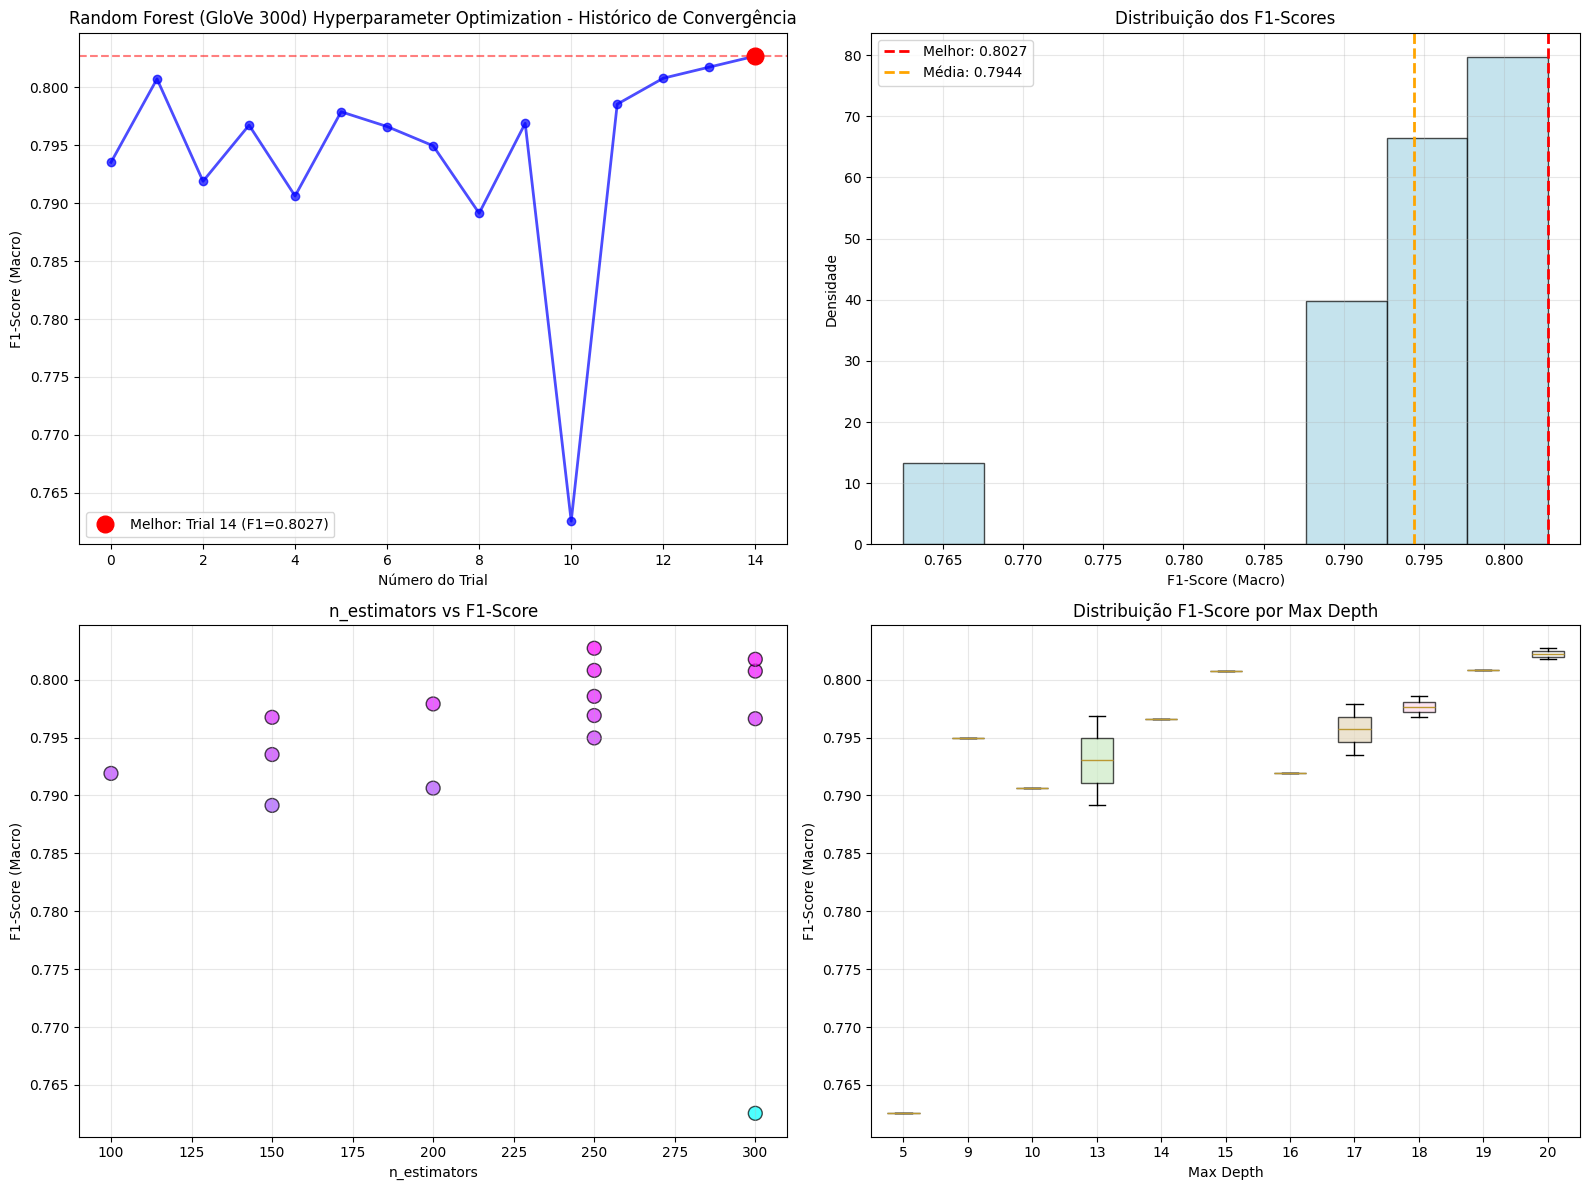


📋 ANÁLISE DETALHADA DOS TRIALS - RANDOM FOREST
📊 Estatísticas dos Trials:
   - Total de trials: 15
   - Trials completados: 15
   - Melhor F1-Score: 0.8027
   - Pior F1-Score: 0.7625
   - F1-Score médio: 0.7944

🏆 Top 5 Melhores Trials:

   🥇 #1 - Trial 14: F1=0.8027
       - n_estimators: 250
       - max_depth: 20
       - min_samples_split: 8
       - min_samples_leaf: 1
       - max_features: sqrt

   🥇 #2 - Trial 13: F1=0.8018
       - n_estimators: 300
       - max_depth: 20
       - min_samples_split: 8
       - min_samples_leaf: 1
       - max_features: sqrt

   🥇 #3 - Trial 12: F1=0.8008
       - n_estimators: 250
       - max_depth: 19
       - min_samples_split: 8
       - min_samples_leaf: 1
       - max_features: sqrt

   🥇 #4 - Trial 1: F1=0.8007
       - n_estimators: 300
       - max_depth: 15
       - min_samples_split: 6
       - min_samples_leaf: 4
       - max_features: sqrt

   🥇 #5 - Trial 11: F1=0.7986
       - n_estimators: 250
       - max_depth: 18
       - m

In [44]:
import optuna
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
import warnings
import gc

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ================================================
# 1. VERIFICAR DADOS DE OTIMIZAÇÃO (SEGURO)
# ================================================
# Verifica se X_opt, y_opt e os modelos glove existem

print("🔍 Verificando dados para otimização Random Forest...")
print("="*60)
try:
    print(f"📊 Usando X_opt (shape): {X_opt.shape}")
    print(f"📊 Usando y_opt (shape): {y_opt.shape}")
    
    # Verifica se o embedding que vamos usar (300d) está carregado
    if 'glove_model_300d' in locals() and glove_model_300d is not None:
        print(f"✅ Embedding 'glove_model_300d' encontrado.")
    else:
        raise NameError("glove_model_300d não está carregado ou está vazio.")
        
    # Verifica se o EmbeddingVectorizer foi definido
    if 'EmbeddingVectorizer' not in locals():
        raise NameError("Classe EmbeddingVectorizer não foi definida (Seção 4.1.1).")
        
except NameError as e:
    print(f"❌ Variável não encontrada: {e}")
    print("💡 Certifique-se de ter executado as células anteriores (Optuna-NB, Carregamento de Embeddings e a Célula 4.1.1).")

# ================================================
# 2. FUNÇÃO DE OBJETIVO (COM PIPELINE)
# ================================================

def objective_rf(trial):
    """Função objetivo para Random Forest com Pipeline de Embedding"""
    
    # --- Otimizar Modelo ---
    params_model = {
        'n_estimators': trial.suggest_int("n_estimators", 100, 300, step=50),
        'max_depth': trial.suggest_int("max_depth", 5, 20),
        'min_samples_split': trial.suggest_int("min_samples_split", 2, 10),
        'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 5),
        'max_features': trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        'random_state': 42,
        'n_jobs': -1
    }

    try:
        # --- O Pipeline é a correção metodológica ---
        # Usamos o EmbeddingVectorizer (definido na Seção 4.1.1)
        # e o glove_model_300d (carregado na Seção 4.1)
        pipeline = Pipeline([
            ('vectorizer', EmbeddingVectorizer(embedding_dict=glove_model_300d)),
            ('model', RandomForestClassifier(**params_model))
        ])
        
        kf = KFold(n_splits=3, shuffle=True, random_state=142857)
        
        # 1. Definir todas as métricas que queremos
        scoring_metrics = {
            'accuracy': 'accuracy',
            'precision_macro': 'precision_macro',
            'recall_macro': 'recall_macro',
            'f1_macro': 'f1_macro'
        }

        # 2. Calculo das metricas
        scores = cross_validate(pipeline, X_opt, y_opt, cv=kf, scoring=scoring_metrics)

        # 3. Calcular a média de cada métrica
        mean_accuracy = np.mean(scores['test_accuracy'])
        mean_precision = np.mean(scores['test_precision_macro'])
        mean_recall = np.mean(scores['test_recall_macro'])
        mean_f1 = np.mean(scores['test_f1_macro'])

        # 4. Salvar as métricas extras no "user_attrs" do trial
        trial.set_user_attr("accuracy", mean_accuracy)
        trial.set_user_attr("precision_macro", mean_precision)
        trial.set_user_attr("recall_macro", mean_recall)

        # Limpa memória (modelos de árvore usam muita RAM)
        del pipeline
        gc.collect()
        
        return mean_f1
    
    except Exception as e:
        print(f"❌ Erro no trial {trial.number}: {e}")
        return 0.0  # Retornar score baixo

# ================================================
# 3. EXECUTAR OTIMIZAÇÃO
# ================================================

print(f"\n🚀 Iniciando otimização de hiperparâmetros para Random Forest...")
print("="*70)

study_rf = optuna.create_study(
    direction='maximize', 
    pruner=optuna.pruners.MedianPruner(n_startup_trials=3)
)

print(f"⚡ Executando otimização com 15 trials...")
# n_jobs=1 diz ao Optuna para rodar 1 trial por vez (evita OOM)
study_rf.optimize(objective_rf, n_trials=15, n_jobs=1, show_progress_bar=True)

print(f"\n🎉 Otimização concluída!")
print(f"✅ Melhor F1-Score (Macro) na validação cruzada: {study_rf.best_value:.4f}")
print(f"🎯 Melhores parâmetros para o Pipeline (Random Forest):")
best_params_rf = study_rf.best_params
for param, value in best_params_rf.items():
    print(f"   - {param}: {value}")

# Salva os melhores parâmetros para usarmos no LODO
if 'optimized_params' not in locals():
    optimized_params = {}
optimized_params['RandomForest'] = best_params_rf


# ==========================================================
# 4. FUNÇÕES DE VISUALIZAÇÃO E ANÁLISE (ADICIONADAS)
# ==========================================================

def plot_random_forest_optimization_history(study, title="Random Forest Optimization"):
    """Cria gráfico de histórico de otimização usando matplotlib"""
    
    print(f"\n📊 Criando visualização personalizada para Random Forest...")
    
    trials = study.trials
    completed_trials = [t for t in trials if t.value is not None]
    
    if not completed_trials:
        print("❌ Nenhum trial válido para plotar")
        return
    
    trial_numbers = [t.number for t in completed_trials]
    values = [t.value for t in completed_trials]
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # --- SUBPLOT 1: HISTÓRICO DE OTIMIZAÇÃO ---
    ax1.plot(trial_numbers, values, 'b-o', alpha=0.7, linewidth=2, markersize=6)
    best_idx = np.argmax(values)
    best_trial = trial_numbers[best_idx]
    best_value = values[best_idx]
    ax1.plot(best_trial, best_value, 'ro', markersize=12, 
             label=f'Melhor: Trial {best_trial} (F1={best_value:.4f})')
    ax1.axhline(y=best_value, color='r', linestyle='--', alpha=0.5)
    ax1.set_xlabel('Número do Trial')
    ax1.set_ylabel('F1-Score (Macro)')
    ax1.set_title(f'{title} - Histórico de Convergência')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # --- SUBPLOT 2: DISTRIBUIÇÃO DOS SCORES ---
    ax2.hist(values, bins=min(8, len(values)), alpha=0.7, color='lightblue', 
             edgecolor='black', density=True)
    ax2.axvline(best_value, color='red', linestyle='--', linewidth=2, 
                label=f'Melhor: {best_value:.4f}')
    ax2.axvline(np.mean(values), color='orange', linestyle='--', linewidth=2, 
                label=f'Média: {np.mean(values):.4f}')
    ax2.set_xlabel('F1-Score (Macro)')
    ax2.set_ylabel('Densidade')
    ax2.set_title('Distribuição dos F1-Scores')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # --- SUBPLOT 3: N_ESTIMATORS vs F1 ---
    n_estimators = [t.params['n_estimators'] for t in completed_trials if 'n_estimators' in t.params]
    f1_scores_est = [t.value for t in completed_trials if 'n_estimators' in t.params]
    if n_estimators:
        ax3.scatter(n_estimators, f1_scores_est, c=f1_scores_est, 
                    cmap='cool', s=100, alpha=0.7, edgecolors='black')
        ax3.set_xlabel('n_estimators')
        ax3.set_ylabel('F1-Score (Macro)')
        ax3.set_title('n_estimators vs F1-Score')
        ax3.grid(True, alpha=0.3)
    
    # --- SUBPLOT 4: MAX_DEPTH vs F1 ---
    max_depths = [t.params['max_depth'] for t in completed_trials if 'max_depth' in t.params]
    f1_scores_depth = [t.value for t in completed_trials if 'max_depth' in t.params]
    if max_depths:
        unique_depths = sorted(set(max_depths))
        depth_groups = []
        for depth in unique_depths:
            depth_scores = [f1_scores_depth[i] for i, d in enumerate(max_depths) if d == depth]
            if depth_scores:
                depth_groups.append(depth_scores)
        
        if depth_groups:
            bp = ax4.boxplot(depth_groups, labels=unique_depths, patch_artist=True)
            colors = plt.cm.Pastel1(np.linspace(0, 1, len(bp['boxes'])))
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color); patch.set_alpha(0.7)
        
        ax4.set_xlabel('Max Depth')
        ax4.set_ylabel('F1-Score (Macro)')
        ax4.set_title('Distribuição F1-Score por Max Depth')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    return fig

def analyze_random_forest_trials_detailed(study):
    """Análise detalhada dos trials do Random Forest"""
    print(f"\n📋 ANÁLISE DETALHADA DOS TRIALS - RANDOM FOREST")
    print("="*60)
    
    trials = study.trials
    completed_trials = [t for t in trials if t.value is not None]
    
    if not completed_trials:
        print("❌ Nenhum trial completado")
        return
    
    values = [t.value for t in completed_trials]
    
    print(f"📊 Estatísticas dos Trials:")
    print(f"   - Total de trials: {len(trials)}")
    print(f"   - Trials completados: {len(completed_trials)}")
    print(f"   - Melhor F1-Score: {max(values):.4f}")
    print(f"   - Pior F1-Score: {min(values):.4f}")
    print(f"   - F1-Score médio: {np.mean(values):.4f}")
    
    print(f"\n🏆 Top 5 Melhores Trials:")
    sorted_trials = sorted(completed_trials, key=lambda x: x.value, reverse=True)
    
    for i, trial in enumerate(sorted_trials[:5]):
        print(f"\n   🥇 #{i+1} - Trial {trial.number}: F1={trial.value:.4f}")
        for param, value in trial.params.items():
            if param not in ['random_state', 'n_jobs']:
                print(f"       - {param}: {value}")

def save_random_forest_optimization_results(study, filename="random_forest_optimization.txt"):
    """Salva resultados da otimização Random Forest em arquivo"""
    try:
        with open(filename, 'w', encoding='utf-8') as f:
            f.write("RESULTADOS DA OTIMIZAÇÃO - RANDOM FOREST (GLOVE 300D)\n")
            f.write("="*60 + "\n\n")
            
            if study.best_value is not None:
                f.write(f"Melhor F1-Score: {study.best_value:.4f}\n")
                f.write(f"Melhores Parâmetros:\n")
                for param, value in study.best_params.items():
                    f.write(f"   - {param}: {value}\n")
            
            f.write(f"\nTodos os Trials:\n")
            for trial in study.trials:
                if trial.value is not None:
                    f.write(f"Trial {trial.number}: F1={trial.value:.4f}\n")
                    for param, value in trial.params.items():
                        f.write(f"   {param}: {value}\n")
                    f.write("\n")
        
        print(f"\n💾 Resultados Random Forest salvos em: {filename}")
        
    except Exception as e:
        print(f"❌ Erro ao salvar resultados: {e}")

# ================================================
# 5. EXECUTAR ANÁLISES
# ================================================

# 1. Criar visualização personalizada
plot_random_forest_optimization_history(study_rf, "Random Forest (GloVe 300d) Hyperparameter Optimization")

# 2. Análise detalhada
analyze_random_forest_trials_detailed(study_rf)

# 3. Salvar resultados
save_random_forest_optimization_results(study_rf)

print(f"\n🎉 OTIMIZAÇÃO DE RANDOM FOREST CONCLUÍDA!")
print(f"🏆 Melhor F1-Score: {study_rf.best_value:.4f}")
print(f"⚙️  Melhores parâmetros salvos no dicionário 'optimized_params['RandomForest']'")

## Otimizando o modelo do XGBoost + GloVe

🔍 Verificando dados para otimização XGBoost...
📊 Usando X_opt (shape): (3184,)
📊 Usando y_opt (shape): (3184,)
✅ Embedding 'glove_model_100d' encontrado.

🚀 Iniciando otimização de hiperparâmetros para XGBoost...
⚡ Executando otimização com 10 trials...


  0%|          | 0/10 [00:00<?, ?it/s]

    - Vetorizando 2122 textos (Dim: 100)...
    - Vetorizando 1062 textos (Dim: 100)...
    - Vetorizando 2123 textos (Dim: 100)...
    - Vetorizando 1061 textos (Dim: 100)...
    - Vetorizando 2123 textos (Dim: 100)...
    - Vetorizando 1061 textos (Dim: 100)...
    - Vetorizando 2122 textos (Dim: 100)...
    - Vetorizando 1062 textos (Dim: 100)...
    - Vetorizando 2123 textos (Dim: 100)...
    - Vetorizando 1061 textos (Dim: 100)...
    - Vetorizando 2123 textos (Dim: 100)...
    - Vetorizando 1061 textos (Dim: 100)...
    - Vetorizando 2122 textos (Dim: 100)...
    - Vetorizando 1062 textos (Dim: 100)...
    - Vetorizando 2123 textos (Dim: 100)...
    - Vetorizando 1061 textos (Dim: 100)...
    - Vetorizando 2123 textos (Dim: 100)...
    - Vetorizando 1061 textos (Dim: 100)...
    - Vetorizando 2122 textos (Dim: 100)...
    - Vetorizando 1062 textos (Dim: 100)...
    - Vetorizando 2123 textos (Dim: 100)...
    - Vetorizando 1061 textos (Dim: 100)...
    - Vetorizando 2123 textos (D

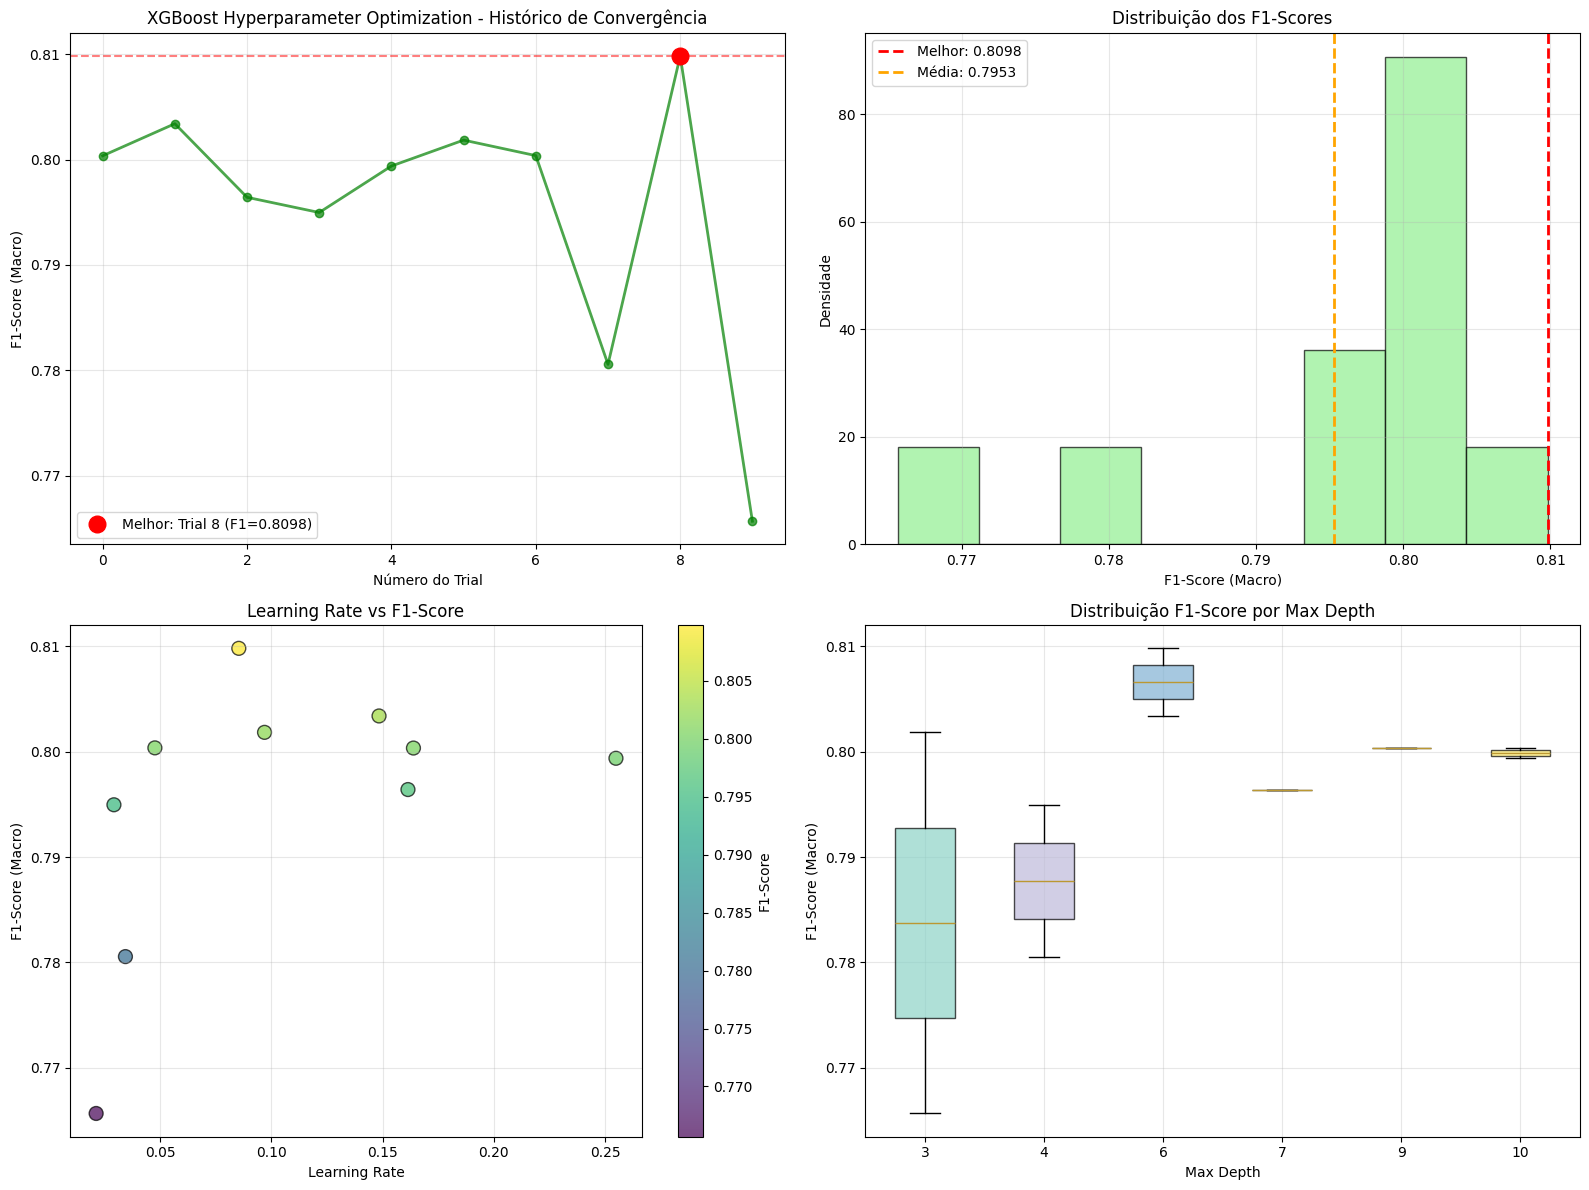


📋 ANÁLISE DETALHADA DOS TRIALS - XGBOOST
📊 Estatísticas dos Trials:
   - Total de trials: 10
   - Trials completados: 10
   - Melhor F1-Score: 0.8098
   - Pior F1-Score: 0.7657
   - F1-Score médio: 0.7953
   - Desvio padrão: 0.0122

🏆 Top 5 Melhores Trials:

   🥇 #1 - Trial 8: F1=0.8098
       - learning_rate: 0.08530281635808502
       - max_depth: 6
       - subsample: 0.8514437859912185
       - n_estimators: 265
       - colsample_bytree: 0.6120083471844434
       - reg_alpha: 0.14987336904637044
       - reg_lambda: 0.0024296325491023492

   🥇 #2 - Trial 1: F1=0.8034
       - learning_rate: 0.14836256044421223
       - max_depth: 6
       - subsample: 0.8072568473626911
       - n_estimators: 139
       - colsample_bytree: 0.5733326447917025
       - reg_alpha: 0.28217576336926314
       - reg_lambda: 1.0340793079758505e-07

   🥇 #3 - Trial 5: F1=0.8018
       - learning_rate: 0.09687325586733068
       - max_depth: 3
       - subsample: 0.7273624202976499
       - n_estimators: 

In [45]:
import optuna
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.pipeline import Pipeline
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ================================================
# DESABILITAR LOGS VERBOSOS DO OPTUNA
# ================================================
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ================================================
# 1. VERIFICAR DADOS DE OTIMIZAÇÃO (SEGURO)
# ================================================
# Verifica se X_opt, y_opt e o modelo glove_model_100d existem

print("🔍 Verificando dados para otimização XGBoost...")
print("="*60)
try:
    print(f"📊 Usando X_opt (shape): {X_opt.shape}")
    print(f"📊 Usando y_opt (shape): {y_opt.shape}")
    
    # Verifica se o embedding que vamos usar (100d) está carregado
    if 'glove_model_100d' in locals() and glove_model_100d is not None:
        print(f"✅ Embedding 'glove_model_100d' encontrado.")
    else:
        raise NameError("glove_model_100d não está carregado ou está vazio.")
        
    # Verifica se o EmbeddingVectorizer foi definido
    if 'EmbeddingVectorizer' not in locals():
        raise NameError("Classe EmbeddingVectorizer não foi definida (Seção 4.1.1).")
        
except NameError as e:
    print(f"❌ Variável não encontrada: {e}")
    print("💡 Certifique-se de ter executado as células anteriores (Optuna-NB, Carregamento de Embeddings e a Célula 4.1.1).")

# ================================================
# 2. FUNÇÃO DE OBJETIVO (COM PIPELINE)
# ================================================

def objective_xgb(trial):
    """Função de objetivo para otimização do XGBoost com Pipeline"""
    
    # --- Otimizar Modelo ---
    params_model = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'eval_metric': 'logloss',
        'random_state': 42,
        'verbosity': 0,
        'n_jobs': 1  # <-- 🚀 CORREÇÃO DO CRASH: Força o XGB a usar 1 CPU
    }

    try:
        # --- O Pipeline é a correção metodológica ---
        # Usamos o EmbeddingVectorizer (definido na Seção 4.1.1)
        # e o glove_model_100d (carregado na Seção 4.1)
        pipeline = Pipeline([
            ('vectorizer', EmbeddingVectorizer(embedding_dict=glove_model_100d)),
            ('model', xgb.XGBClassifier(**params_model))
        ])
        
        kf = KFold(n_splits=3, shuffle=True, random_state=142857)

        # 1. Definir todas as métricas que queremos
        scoring_metrics = {
            'accuracy': 'accuracy',
            'precision_macro': 'precision_macro',
            'recall_macro': 'recall_macro',
            'f1_macro': 'f1_macro'
        }
        
        # 2. Usar cross_validate para calcular todas de uma vez
        scores = cross_validate(pipeline, X_opt, y_opt, cv=kf, scoring=scoring_metrics)

        # 3. Calcular a média de cada métrica
        mean_accuracy = np.mean(scores['test_accuracy'])
        mean_precision = np.mean(scores['test_precision_macro'])
        mean_recall = np.mean(scores['test_recall_macro'])
        mean_f1 = np.mean(scores['test_f1_macro'])

        # 4. Salvar as métricas extras no "user_attrs" do trial
        trial.set_user_attr("accuracy", mean_accuracy)
        trial.set_user_attr("precision_macro", mean_precision)
        trial.set_user_attr("recall_macro", mean_recall)

        # 5. Retornar a métrica PRINCIPAL que o Optuna deve otimizar    
        return mean_f1
    
    except Exception as e:
        print(f"❌ Erro no trial {trial.number}: {e}")
        return 0.0  # Retornar score baixo

# ================================================
# 3. EXECUTAR OTIMIZAÇÃO
# ================================================

print(f"\n🚀 Iniciando otimização de hiperparâmetros para XGBoost...")
print("="*70)

study_xgb = optuna.create_study(
    direction='maximize', 
    pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=5)
)

print(f"⚡ Executando otimização com 10 trials...")
# n_jobs=1 diz ao Optuna para rodar 1 trial por vez (evita crash)
study_xgb.optimize(objective_xgb, n_trials=10, n_jobs=1, show_progress_bar=True)

print(f"\n🎉 Otimização concluída!")
print(f"✅ Melhor F1-Score (Macro) na validação cruzada: {study_xgb.best_value:.4f}")
print(f"🎯 Melhores parâmetros para o Pipeline (XGBoost):")
best_params_xgb = study_xgb.best_params
for param, value in best_params_xgb.items():
    print(f"   - {param}: {value}")

# Salva os melhores parâmetros para usarmos no LODO
if 'optimized_params' not in locals():
    optimized_params = {}
optimized_params['XGBoost'] = best_params_xgb


# ================================================
# 4. FUNÇÕES DE VISUALIZAÇÃO E ANÁLISE (ADICIONADAS)
# ================================================

def plot_xgboost_optimization_history(study, title="XGBoost Optimization"):
    """Cria gráfico de histórico de otimização usando matplotlib (adaptado do seu script LR)"""
    
    print(f"\n📊 Criando visualização personalizada para XGBoost...")
    
    trials = study.trials
    completed_trials = [t for t in trials if t.value is not None]
    
    if not completed_trials:
        print("❌ Nenhum trial válido para plotar")
        return
    
    trial_numbers = [t.number for t in completed_trials]
    values = [t.value for t in completed_trials]
    
    # Criar figura com subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # --- SUBPLOT 1: HISTÓRICO DE OTIMIZAÇÃO ---
    ax1.plot(trial_numbers, values, 'g-o', alpha=0.7, linewidth=2, markersize=6)
    best_idx = np.argmax(values)
    best_trial = trial_numbers[best_idx]
    best_value = values[best_idx]
    ax1.plot(best_trial, best_value, 'ro', markersize=12, 
             label=f'Melhor: Trial {best_trial} (F1={best_value:.4f})')
    ax1.axhline(y=best_value, color='r', linestyle='--', alpha=0.5)
    ax1.set_xlabel('Número do Trial')
    ax1.set_ylabel('F1-Score (Macro)')
    ax1.set_title(f'{title} - Histórico de Convergência')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # --- SUBPLOT 2: DISTRIBUIÇÃO DOS SCORES ---
    ax2.hist(values, bins=min(8, len(values)), alpha=0.7, color='lightgreen', 
             edgecolor='black', density=True)
    ax2.axvline(best_value, color='red', linestyle='--', linewidth=2, 
                label=f'Melhor: {best_value:.4f}')
    ax2.axvline(np.mean(values), color='orange', linestyle='--', linewidth=2, 
                label=f'Média: {np.mean(values):.4f}')
    ax2.set_xlabel('F1-Score (Macro)')
    ax2.set_ylabel('Densidade')
    ax2.set_title('Distribuição dos F1-Scores')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # --- SUBPLOT 3: LEARNING RATE vs F1 ---
    learning_rates = [t.params['learning_rate'] for t in completed_trials if 'learning_rate' in t.params]
    f1_scores_lr = [t.value for t in completed_trials if 'learning_rate' in t.params]
    if learning_rates:
        scatter = ax3.scatter(learning_rates, f1_scores_lr, c=f1_scores_lr, 
                            cmap='viridis', s=100, alpha=0.7, edgecolors='black')
        ax3.set_xlabel('Learning Rate')
        ax3.set_ylabel('F1-Score (Macro)')
        ax3.set_title('Learning Rate vs F1-Score')
        ax3.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax3, label='F1-Score')
    
    # --- SUBPLOT 4: MAX_DEPTH vs F1 ---
    max_depths = [t.params['max_depth'] for t in completed_trials if 'max_depth' in t.params]
    f1_scores_depth = [t.value for t in completed_trials if 'max_depth' in t.params]
    if max_depths:
        unique_depths = sorted(set(max_depths))
        depth_groups = []
        for depth in unique_depths:
            depth_scores = [f1_scores_depth[i] for i, d in enumerate(max_depths) if d == depth]
            if depth_scores:
                depth_groups.append(depth_scores)
        
        if depth_groups:
            bp = ax4.boxplot(depth_groups, labels=unique_depths, patch_artist=True)
            colors = plt.cm.Set3(np.linspace(0, 1, len(bp['boxes'])))
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color); patch.set_alpha(0.7)
        
        ax4.set_xlabel('Max Depth')
        ax4.set_ylabel('F1-Score (Macro)')
        ax4.set_title('Distribuição F1-Score por Max Depth')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    return fig

def analyze_xgboost_trials_detailed(study):
    """Análise detalhada dos trials do XGBoost (adaptado do seu script LR)"""
    
    print(f"\n📋 ANÁLISE DETALHADA DOS TRIALS - XGBOOST")
    print("="*60)
    
    trials = study.trials
    completed_trials = [t for t in trials if t.value is not None]
    
    if not completed_trials:
        print("❌ Nenhum trial completado")
        return
    
    values = [t.value for t in completed_trials]
    
    print(f"📊 Estatísticas dos Trials:")
    print(f"   - Total de trials: {len(trials)}")
    print(f"   - Trials completados: {len(completed_trials)}")
    print(f"   - Melhor F1-Score: {max(values):.4f}")
    print(f"   - Pior F1-Score: {min(values):.4f}")
    print(f"   - F1-Score médio: {np.mean(values):.4f}")
    print(f"   - Desvio padrão: {np.std(values):.4f}")
    
    print(f"\n🏆 Top 5 Melhores Trials:")
    sorted_trials = sorted(completed_trials, key=lambda x: x.value, reverse=True)
    
    for i, trial in enumerate(sorted_trials[:5]):
        print(f"\n   🥇 #{i+1} - Trial {trial.number}: F1={trial.value:.4f}")
        for param, value in trial.params.items():
            if param not in ['eval_metric', 'random_state', 'verbosity', 'n_jobs']:
                print(f"       - {param}: {value}")

def save_xgboost_optimization_results(study, filename="xgboost_optimization.txt"):
    """Salva resultados da otimização XGBoost em arquivo (adaptado do seu script LR)"""
    
    try:
        with open(filename, 'w', encoding='utf-8') as f:
            f.write("RESULTADOS DA OTIMIZAÇÃO - XGBOOST\n")
            f.write("="*60 + "\n\n")
            
            if study.best_value is not None:
                f.write(f"Melhor F1-Score: {study.best_value:.4f}\n")
                f.write(f"Melhores Parâmetros:\n")
                for param, value in study.best_params.items():
                    f.write(f"   - {param}: {value}\n")
            
            f.write(f"\nTodos os Trials:\n")
            for trial in study.trials:
                if trial.value is not None:
                    f.write(f"Trial {trial.number}: F1={trial.value:.4f}\n")
                    for param, value in trial.params.items():
                        f.write(f"   {param}: {value}\n")
                    f.write("\n")
        
        print(f"\n💾 Resultados XGBoost salvos em: {filename}")
        
    except Exception as e:
        print(f"❌ Erro ao salvar resultados: {e}")

# ================================================
# 5. EXECUTAR ANÁLISES
# ================================================

# 1. Criar visualização personalizada
plot_xgboost_optimization_history(study_xgb, "XGBoost Hyperparameter Optimization")

# 2. Análise detalhada
analyze_xgboost_trials_detailed(study_xgb)

# 3. Salvar resultados
save_xgboost_optimization_results(study_xgb)

print(f"\n🎉 OTIMIZAÇÃO DE XGBOOST CONCLUÍDA!")
print(f"🏆 Melhor F1-Score: {study_xgb.best_value:.4f}")
print(f"⚙️  Melhores parâmetros salvos no dicionário 'optimized_params['XGBoost']'")

## Otimizando o modelo BERT + Fine-Tunning

In [25]:
import optuna
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset as TorchDataset # Renomeado para evitar conflito
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset # Importação do Hugging Face
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold # Usar K-Fold Estratificado
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
import time
import gc
import warnings

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ================================================
# 1. VERIFICAR DADOS DE OTIMIZAÇÃO (SEGURO)
# ================================================
# Verifica se X_opt e y_opt (criados na célula 9.1) existem.

print("🔍 Verificando dados para otimização BERT...")
print("="*60)
try:
    print(f"📊 Usando X_opt (shape): {X_opt.shape}")
    print(f"📊 Usando y_opt (shape): {y_opt.shape}")
    print(f"🏷️  Classes únicas: {np.unique(y_opt)}")
except NameError as e:
    print(f"❌ Variável não encontrada: {e}")
    print("💡 Certifique-se de ter executado a célula '9.1 Otimizando... BoW + Naive Bayes' primeiro.")

# ================================================
# 2. FUNÇÃO AUXILIAR DE MÉTRICAS (Hugging Face)
# ================================================

def compute_metrics_optuna(pred):
    """Calcula métricas para o Trainer do Optuna"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1_macro': f1,
        'precision_macro': precision,
        'recall_macro': recall
    }

# ================================================
# 3. FUNÇÃO DE OBJETIVO (O CORAÇÃO DA OTIMIZAÇÃO)
# ================================================

def objective_bert(trial):
    """Função de objetivo para otimização do BERT com validação cruzada"""
    
    # --- Hiperparâmetros a Otimizar ---
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    # max_length = trial.suggest_categorical('max_length', [64, 128, 256]) # Opcional
    max_length = 128 # Fixo para velocidade
    
    MODEL_NAME = 'distilbert-base-uncased'
    
    print(f"\n--- Iniciando Trial {trial.number} ---")
    print(f"  Params: LR={learning_rate:.2e}, Batch={batch_size}, MaxLen={max_length}")
    
    # --- Correção Metodológica: Validação Cruzada (K-Fold) ---
    # Usamos o X_opt e y_opt (dados seguros)
    
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=142857)
    fold_scores = []
    
    # Loop de validação cruzada
    for fold, (train_index, val_index) in enumerate(kf.split(X_opt, y_opt)):
        print(f"  > Fold {fold+1}/3...")
        
        # 1. Preparar Dados do Fold
        X_train_fold, X_val_fold = X_opt.iloc[train_index], X_opt.iloc[val_index]
        y_train_fold, y_val_fold = y_opt.iloc[train_index], y_opt.iloc[val_index]

        train_df = pd.DataFrame({'text': X_train_fold, 'label': y_train_fold})
        val_df = pd.DataFrame({'text': X_val_fold, 'label': y_val_fold})
        
        train_dataset = Dataset.from_pandas(train_df)
        val_dataset = Dataset.from_pandas(val_df)
        
        # 2. Tokenizar
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        def tokenize_function(examples):
            return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=max_length)
            
        train_dataset_tokenized = train_dataset.map(tokenize_function, batched=True, load_from_cache_file=False)
        val_dataset_tokenized = val_dataset.map(tokenize_function, batched=True, load_from_cache_file=False)
        
        # 3. Carregar Modelo (um novo para cada fold)
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
        
        # 4. Argumentos de Treino
        training_args = TrainingArguments(
            output_dir=f"./bert_opt_checkpoints/trial_{trial.number}_fold_{fold}",
            num_train_epochs=1, # 1 época é suficiente para otimização rápida
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            learning_rate=learning_rate,
            weight_decay=0.01,
            evaluation_strategy="epoch",
            logging_strategy="epoch",
            load_best_model_at_end=True,
            save_strategy="epoch",
            save_total_limit=1, # Salva apenas o melhor checkpoint
            report_to="none",
            disable_tqdm=True, # Desliga barras de progresso
        )
        
        # 5. Trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset_tokenized,
            eval_dataset=val_dataset_tokenized, 
            compute_metrics=compute_metrics_optuna,
        )
        
        # 6. Treinar
        try:
            trainer.train()
            eval_results = trainer.evaluate()
            fold_scores.append(eval_results['eval_f1_macro'])
        except Exception as e:
            print(f"  > ❌ Erro no Fold {fold+1}: {e}")
            fold_scores.append(0.0) # Penaliza o fold que falhou
        
        # 7. Limpeza de Memória (Crucial!)
        del model, trainer, train_dataset_tokenized, val_dataset_tokenized
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            
    # Média dos F1-Scores dos 3 folds
    mean_f1 = np.mean(fold_scores)
    print(f"  > Resultado Trial {trial.number}: F1-Macro Médio = {mean_f1:.4f}")
    return mean_f1

# ================================================
# 4. EXECUTAR OTIMIZAÇÃO
# ================================================

print(f"\n🚀 Iniciando otimização de hiperparâmetros para BERT...")
print("="*70)

study_bert = optuna.create_study(
    direction='maximize', 
    pruner=optuna.pruners.MedianPruner()
)

print(f"⚡ Executando otimização com 5 trials...")
# n_jobs=1 é OBRIGATÓRIO para o BERT para evitar conflitos de GPU
study_bert.optimize(objective_bert, n_trials=5, n_jobs=1, show_progress_bar=False) 

print(f"\n🎉 Otimização do BERT concluída!")
print(f"✅ Melhor F1-Score (Macro) na validação cruzada: {study_bert.best_value:.4f}")
print(f"🎯 Melhores parâmetros para o Pipeline (BERT):")
best_params_bert = study_bert.best_params
for param, value in best_params_bert.items():
    print(f"   - {param}: {value}")

# Salva os melhores parâmetros para usarmos no LODO
if 'optimized_params' not in locals():
    optimized_params = {}
optimized_params['BERT'] = best_params_bert

# ================================================
# 5. VISUALIZAÇÃO E ANÁLISE
# ================================================
# (Você pode colar suas funções 'plot_..._history' e 'analyze_..._detailed' aqui
#  para analisar o 'study_bert')

print(f"\n🎉 OTIMIZAÇÃO DE BERT CONCLUÍDA!")
print(f"🏆 Melhor F1-Score: {study_bert.best_value:.4f}")
print(f"⚙️  Melhores parâmetros salvos no dicionário 'optimized_params['BERT']'")

🔍 Verificando dados para otimização BERT...
📊 Usando X_opt (shape): (3184,)
📊 Usando y_opt (shape): (3184,)
🏷️  Classes únicas: [0 1]

🚀 Iniciando otimização de hiperparâmetros para BERT...
⚡ Executando otimização com 5 trials...

--- Iniciando Trial 0 ---
  Params: LR=1.25e-05, Batch=16, MaxLen=128
  > Fold 1/3...


Map:   0%|          | 0/2122 [00:00<?, ? examples/s]

Map:   0%|          | 0/1062 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6169, 'grad_norm': 13.794085502624512, 'learning_rate': 1.8726452768550176e-07, 'epoch': 1.0}
{'eval_loss': 0.5675109624862671, 'eval_accuracy': 0.7109227871939736, 'eval_f1_macro': 0.7026634382566586, 'eval_precision_macro': 0.728984768588399, 'eval_recall_macro': 0.7072663524869407, 'eval_runtime': 1.0784, 'eval_samples_per_second': 984.782, 'eval_steps_per_second': 62.128, 'epoch': 1.0}
{'train_runtime': 11.0758, 'train_samples_per_second': 191.588, 'train_steps_per_second': 12.008, 'train_loss': 0.6168982713742364, 'epoch': 1.0}
{'eval_loss': 0.5675109624862671, 'eval_accuracy': 0.7109227871939736, 'eval_f1_macro': 0.7026634382566586, 'eval_precision_macro': 0.728984768588399, 'eval_recall_macro': 0.7072663524869407, 'eval_runtime': 1.0934, 'eval_samples_per_second': 971.3, 'eval_steps_per_second': 61.278, 'epoch': 1.0}
  > Fold 2/3...


Map:   0%|          | 0/2123 [00:00<?, ? examples/s]

Map:   0%|          | 0/1061 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.638, 'grad_norm': 13.013071060180664, 'learning_rate': 9.363226384275088e-08, 'epoch': 1.0}
{'eval_loss': 0.5507451295852661, 'eval_accuracy': 0.767200754005655, 'eval_f1_macro': 0.7649423045012804, 'eval_precision_macro': 0.7732990793164822, 'eval_recall_macro': 0.7653160263657501, 'eval_runtime': 1.0896, 'eval_samples_per_second': 973.785, 'eval_steps_per_second': 61.493, 'epoch': 1.0}
{'train_runtime': 11.0281, 'train_samples_per_second': 192.508, 'train_steps_per_second': 12.06, 'train_loss': 0.6379774280060503, 'epoch': 1.0}
{'eval_loss': 0.5507451295852661, 'eval_accuracy': 0.767200754005655, 'eval_f1_macro': 0.7649423045012804, 'eval_precision_macro': 0.7732990793164822, 'eval_recall_macro': 0.7653160263657501, 'eval_runtime': 1.137, 'eval_samples_per_second': 933.19, 'eval_steps_per_second': 58.929, 'epoch': 1.0}
  > Fold 3/3...


Map:   0%|          | 0/2123 [00:00<?, ? examples/s]

Map:   0%|          | 0/1061 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6422, 'grad_norm': 16.29605484008789, 'learning_rate': 9.363226384275088e-08, 'epoch': 1.0}
{'eval_loss': 0.5597537159919739, 'eval_accuracy': 0.7492931196983977, 'eval_f1_macro': 0.7485674475621664, 'eval_precision_macro': 0.7500644122383253, 'eval_recall_macro': 0.7484427995477719, 'eval_runtime': 1.0935, 'eval_samples_per_second': 970.313, 'eval_steps_per_second': 61.273, 'epoch': 1.0}
{'train_runtime': 11.2694, 'train_samples_per_second': 188.386, 'train_steps_per_second': 11.802, 'train_loss': 0.6421721035376527, 'epoch': 1.0}
{'eval_loss': 0.5597537159919739, 'eval_accuracy': 0.7492931196983977, 'eval_f1_macro': 0.7485674475621664, 'eval_precision_macro': 0.7500644122383253, 'eval_recall_macro': 0.7484427995477719, 'eval_runtime': 1.1048, 'eval_samples_per_second': 960.375, 'eval_steps_per_second': 60.646, 'epoch': 1.0}
  > Resultado Trial 0: F1-Macro Médio = 0.7387

--- Iniciando Trial 1 ---
  Params: LR=2.51e-05, Batch=16, MaxLen=128
  > Fold 1/3...


Map:   0%|          | 0/2122 [00:00<?, ? examples/s]

Map:   0%|          | 0/1062 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.539, 'grad_norm': 16.451501846313477, 'learning_rate': 3.7759809019647003e-07, 'epoch': 1.0}
{'eval_loss': 0.45653998851776123, 'eval_accuracy': 0.7824858757062146, 'eval_f1_macro': 0.7800834227532736, 'eval_precision_macro': 0.7901082035710483, 'eval_recall_macro': 0.7803947592550534, 'eval_runtime': 1.0848, 'eval_samples_per_second': 979.011, 'eval_steps_per_second': 61.764, 'epoch': 1.0}
{'train_runtime': 11.2277, 'train_samples_per_second': 188.997, 'train_steps_per_second': 11.846, 'train_loss': 0.5390033578514156, 'epoch': 1.0}
{'eval_loss': 0.45653998851776123, 'eval_accuracy': 0.7824858757062146, 'eval_f1_macro': 0.7800834227532736, 'eval_precision_macro': 0.7901082035710483, 'eval_recall_macro': 0.7803947592550534, 'eval_runtime': 1.08, 'eval_samples_per_second': 983.337, 'eval_steps_per_second': 62.037, 'epoch': 1.0}
  > Fold 2/3...


Map:   0%|          | 0/2123 [00:00<?, ? examples/s]

Map:   0%|          | 0/1061 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5444, 'grad_norm': 12.279823303222656, 'learning_rate': 3.7759809019647003e-07, 'epoch': 1.0}
{'eval_loss': 0.4095586836338043, 'eval_accuracy': 0.820923656927427, 'eval_f1_macro': 0.8209234978502647, 'eval_precision_macro': 0.8213300485606012, 'eval_recall_macro': 0.8213574663850907, 'eval_runtime': 1.1376, 'eval_samples_per_second': 932.664, 'eval_steps_per_second': 58.896, 'epoch': 1.0}
{'train_runtime': 11.5089, 'train_samples_per_second': 184.466, 'train_steps_per_second': 11.556, 'train_loss': 0.5444121396631226, 'epoch': 1.0}
{'eval_loss': 0.4095586836338043, 'eval_accuracy': 0.820923656927427, 'eval_f1_macro': 0.8209234978502647, 'eval_precision_macro': 0.8213300485606012, 'eval_recall_macro': 0.8213574663850907, 'eval_runtime': 1.0861, 'eval_samples_per_second': 976.91, 'eval_steps_per_second': 61.69, 'epoch': 1.0}
  > Fold 3/3...


Map:   0%|          | 0/2123 [00:00<?, ? examples/s]

Map:   0%|          | 0/1061 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5579, 'grad_norm': inf, 'learning_rate': 3.7759809019647003e-07, 'epoch': 1.0}
{'eval_loss': 0.39653655886650085, 'eval_accuracy': 0.8388312912346843, 'eval_f1_macro': 0.8387848910206799, 'eval_precision_macro': 0.8387455579246623, 'eval_recall_macro': 0.8388973029857008, 'eval_runtime': 1.081, 'eval_samples_per_second': 981.491, 'eval_steps_per_second': 61.979, 'epoch': 1.0}
{'train_runtime': 11.1635, 'train_samples_per_second': 190.173, 'train_steps_per_second': 11.914, 'train_loss': 0.5578522646337524, 'epoch': 1.0}
{'eval_loss': 0.39653655886650085, 'eval_accuracy': 0.8388312912346843, 'eval_f1_macro': 0.8387848910206799, 'eval_precision_macro': 0.8387455579246623, 'eval_recall_macro': 0.8388973029857008, 'eval_runtime': 1.0698, 'eval_samples_per_second': 991.769, 'eval_steps_per_second': 62.628, 'epoch': 1.0}
  > Resultado Trial 1: F1-Macro Médio = 0.8133

--- Iniciando Trial 2 ---
  Params: LR=1.01e-05, Batch=16, MaxLen=128
  > Fold 1/3...


Map:   0%|          | 0/2122 [00:00<?, ? examples/s]

Map:   0%|          | 0/1062 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6267, 'grad_norm': inf, 'learning_rate': 1.5243359656819835e-07, 'epoch': 1.0}
{'eval_loss': 0.5663015246391296, 'eval_accuracy': 0.7259887005649718, 'eval_f1_macro': 0.7216226562957425, 'eval_precision_macro': 0.7352360770067387, 'eval_recall_macro': 0.7233562343856461, 'eval_runtime': 1.1031, 'eval_samples_per_second': 962.777, 'eval_steps_per_second': 60.74, 'epoch': 1.0}
{'train_runtime': 11.1306, 'train_samples_per_second': 190.646, 'train_steps_per_second': 11.949, 'train_loss': 0.6266733614125646, 'epoch': 1.0}
{'eval_loss': 0.5663015246391296, 'eval_accuracy': 0.7259887005649718, 'eval_f1_macro': 0.7216226562957425, 'eval_precision_macro': 0.7352360770067387, 'eval_recall_macro': 0.7233562343856461, 'eval_runtime': 1.0927, 'eval_samples_per_second': 971.911, 'eval_steps_per_second': 61.316, 'epoch': 1.0}
  > Fold 2/3...


Map:   0%|          | 0/2123 [00:00<?, ? examples/s]

Map:   0%|          | 0/1061 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6476, 'grad_norm': 10.87508487701416, 'learning_rate': 7.621679828409917e-08, 'epoch': 1.0}
{'eval_loss': 0.573166012763977, 'eval_accuracy': 0.76248821866164, 'eval_f1_macro': 0.7602285689688569, 'eval_precision_macro': 0.76828612209047, 'eval_recall_macro': 0.7606230934960216, 'eval_runtime': 1.0786, 'eval_samples_per_second': 983.715, 'eval_steps_per_second': 62.12, 'epoch': 1.0}
{'train_runtime': 11.4904, 'train_samples_per_second': 184.764, 'train_steps_per_second': 11.575, 'train_loss': 0.6476162788563204, 'epoch': 1.0}
{'eval_loss': 0.573166012763977, 'eval_accuracy': 0.76248821866164, 'eval_f1_macro': 0.7602285689688569, 'eval_precision_macro': 0.76828612209047, 'eval_recall_macro': 0.7606230934960216, 'eval_runtime': 1.1011, 'eval_samples_per_second': 963.568, 'eval_steps_per_second': 60.847, 'epoch': 1.0}
  > Fold 3/3...


Map:   0%|          | 0/2123 [00:00<?, ? examples/s]

Map:   0%|          | 0/1061 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6504, 'grad_norm': 12.845748901367188, 'learning_rate': 1.5243359656819835e-07, 'epoch': 1.0}
{'eval_loss': 0.5853788256645203, 'eval_accuracy': 0.7332704995287465, 'eval_f1_macro': 0.7324710408542023, 'eval_precision_macro': 0.7339812428407789, 'eval_recall_macro': 0.7323890583559092, 'eval_runtime': 1.0756, 'eval_samples_per_second': 986.437, 'eval_steps_per_second': 62.292, 'epoch': 1.0}
{'train_runtime': 11.141, 'train_samples_per_second': 190.558, 'train_steps_per_second': 11.938, 'train_loss': 0.6504130542726445, 'epoch': 1.0}
{'eval_loss': 0.5853788256645203, 'eval_accuracy': 0.7332704995287465, 'eval_f1_macro': 0.7324710408542023, 'eval_precision_macro': 0.7339812428407789, 'eval_recall_macro': 0.7323890583559092, 'eval_runtime': 1.1169, 'eval_samples_per_second': 949.935, 'eval_steps_per_second': 59.986, 'epoch': 1.0}
  > Resultado Trial 2: F1-Macro Médio = 0.7381

--- Iniciando Trial 3 ---
  Params: LR=2.00e-05, Batch=16, MaxLen=128
  > Fold 1/3...


Map:   0%|          | 0/2122 [00:00<?, ? examples/s]

Map:   0%|          | 0/1062 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5643, 'grad_norm': 15.430535316467285, 'learning_rate': 3.0037948444742427e-07, 'epoch': 1.0}
{'eval_loss': 0.47924724221229553, 'eval_accuracy': 0.7711864406779662, 'eval_f1_macro': 0.7681770530621999, 'eval_precision_macro': 0.7802916791529317, 'eval_recall_macro': 0.768857880990234, 'eval_runtime': 1.0714, 'eval_samples_per_second': 991.22, 'eval_steps_per_second': 62.535, 'epoch': 1.0}
{'train_runtime': 11.2884, 'train_samples_per_second': 187.98, 'train_steps_per_second': 11.782, 'train_loss': 0.5642859093228677, 'epoch': 1.0}
{'eval_loss': 0.47924724221229553, 'eval_accuracy': 0.7711864406779662, 'eval_f1_macro': 0.7681770530621999, 'eval_precision_macro': 0.7802916791529317, 'eval_recall_macro': 0.768857880990234, 'eval_runtime': 1.112, 'eval_samples_per_second': 955.029, 'eval_steps_per_second': 60.251, 'epoch': 1.0}
  > Fold 2/3...


Map:   0%|          | 0/2123 [00:00<?, ? examples/s]

Map:   0%|          | 0/1061 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5777, 'grad_norm': 11.538590431213379, 'learning_rate': 1.5018974222371214e-07, 'epoch': 1.0}
{'eval_loss': 0.4583713114261627, 'eval_accuracy': 0.8039585296889726, 'eval_f1_macro': 0.8027514407882506, 'eval_precision_macro': 0.8078293424003473, 'eval_recall_macro': 0.8025608481409586, 'eval_runtime': 1.1067, 'eval_samples_per_second': 958.695, 'eval_steps_per_second': 60.54, 'epoch': 1.0}
{'train_runtime': 11.2883, 'train_samples_per_second': 188.071, 'train_steps_per_second': 11.782, 'train_loss': 0.5776814625675517, 'epoch': 1.0}
{'eval_loss': 0.4583713114261627, 'eval_accuracy': 0.8039585296889726, 'eval_f1_macro': 0.8027514407882506, 'eval_precision_macro': 0.8078293424003473, 'eval_recall_macro': 0.8025608481409586, 'eval_runtime': 1.0734, 'eval_samples_per_second': 988.417, 'eval_steps_per_second': 62.417, 'epoch': 1.0}
  > Fold 3/3...


Map:   0%|          | 0/2123 [00:00<?, ? examples/s]

Map:   0%|          | 0/1061 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.602, 'grad_norm': 17.073699951171875, 'learning_rate': 1.5018974222371214e-07, 'epoch': 1.0}
{'eval_loss': 0.46527761220932007, 'eval_accuracy': 0.8039585296889726, 'eval_f1_macro': 0.8037686994501313, 'eval_precision_macro': 0.8039571545496602, 'eval_recall_macro': 0.8036718644453451, 'eval_runtime': 1.0805, 'eval_samples_per_second': 981.964, 'eval_steps_per_second': 62.009, 'epoch': 1.0}
{'train_runtime': 11.2266, 'train_samples_per_second': 189.105, 'train_steps_per_second': 11.847, 'train_loss': 0.6019920406484962, 'epoch': 1.0}
{'eval_loss': 0.46527761220932007, 'eval_accuracy': 0.8039585296889726, 'eval_f1_macro': 0.8037686994501313, 'eval_precision_macro': 0.8039571545496602, 'eval_recall_macro': 0.8036718644453451, 'eval_runtime': 1.09, 'eval_samples_per_second': 973.433, 'eval_steps_per_second': 61.47, 'epoch': 1.0}
  > Resultado Trial 3: F1-Macro Médio = 0.7916

--- Iniciando Trial 4 ---
  Params: LR=2.36e-05, Batch=16, MaxLen=128
  > Fold 1/3...


Map:   0%|          | 0/2122 [00:00<?, ? examples/s]

Map:   0%|          | 0/1062 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5468, 'grad_norm': 14.917505264282227, 'learning_rate': 3.5426311824757394e-07, 'epoch': 1.0}
{'eval_loss': 0.45924919843673706, 'eval_accuracy': 0.775894538606403, 'eval_f1_macro': 0.7731885124391146, 'eval_precision_macro': 0.7842138624369823, 'eval_recall_macro': 0.7736841358164888, 'eval_runtime': 1.0795, 'eval_samples_per_second': 983.76, 'eval_steps_per_second': 62.064, 'epoch': 1.0}
{'train_runtime': 11.2404, 'train_samples_per_second': 188.783, 'train_steps_per_second': 11.832, 'train_loss': 0.5468153989404664, 'epoch': 1.0}
{'eval_loss': 0.45924919843673706, 'eval_accuracy': 0.775894538606403, 'eval_f1_macro': 0.7731885124391146, 'eval_precision_macro': 0.7842138624369823, 'eval_recall_macro': 0.7736841358164888, 'eval_runtime': 1.0987, 'eval_samples_per_second': 966.573, 'eval_steps_per_second': 60.98, 'epoch': 1.0}
  > Fold 2/3...


Map:   0%|          | 0/2123 [00:00<?, ? examples/s]

Map:   0%|          | 0/1061 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5606, 'grad_norm': 13.11888313293457, 'learning_rate': 3.5426311824757394e-07, 'epoch': 1.0}
{'eval_loss': 0.4346419870853424, 'eval_accuracy': 0.8162111215834119, 'eval_f1_macro': 0.8160640670826736, 'eval_precision_macro': 0.8192036448945728, 'eval_recall_macro': 0.8173311432979942, 'eval_runtime': 1.096, 'eval_samples_per_second': 968.067, 'eval_steps_per_second': 61.131, 'epoch': 1.0}
{'train_runtime': 11.284, 'train_samples_per_second': 188.142, 'train_steps_per_second': 11.787, 'train_loss': 0.5606364773628407, 'epoch': 1.0}
{'eval_loss': 0.4346419870853424, 'eval_accuracy': 0.8162111215834119, 'eval_f1_macro': 0.8160640670826736, 'eval_precision_macro': 0.8192036448945728, 'eval_recall_macro': 0.8173311432979942, 'eval_runtime': 1.0685, 'eval_samples_per_second': 992.936, 'eval_steps_per_second': 62.702, 'epoch': 1.0}
  > Fold 3/3...


Map:   0%|          | 0/2123 [00:00<?, ? examples/s]

Map:   0%|          | 0/1061 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5867, 'grad_norm': 20.934499740600586, 'learning_rate': 1.7713155912378697e-07, 'epoch': 1.0}
{'eval_loss': 0.4453306198120117, 'eval_accuracy': 0.8133836003770029, 'eval_f1_macro': 0.8120006443298968, 'eval_precision_macro': 0.8186167662060246, 'eval_recall_macro': 0.8118133919238891, 'eval_runtime': 1.0976, 'eval_samples_per_second': 966.611, 'eval_steps_per_second': 61.04, 'epoch': 1.0}
{'train_runtime': 11.258, 'train_samples_per_second': 188.577, 'train_steps_per_second': 11.814, 'train_loss': 0.5866617762056509, 'epoch': 1.0}
{'eval_loss': 0.4453306198120117, 'eval_accuracy': 0.8133836003770029, 'eval_f1_macro': 0.8120006443298968, 'eval_precision_macro': 0.8186167662060246, 'eval_recall_macro': 0.8118133919238891, 'eval_runtime': 1.0862, 'eval_samples_per_second': 976.811, 'eval_steps_per_second': 61.684, 'epoch': 1.0}
  > Resultado Trial 4: F1-Macro Médio = 0.8004

🎉 Otimização do BERT concluída!
✅ Melhor F1-Score (Macro) na validação cruzada: 0.8133
🎯 Melhores parâm

## Otimizando o modelo BERT Longformer

🔍 Verificando dados para otimização Longformer...
📊 Usando X_opt (shape): (3184,)
📊 Usando y_opt (shape): (3184,)
🏷️  Classes únicas: [0 1]

🛠️  Preparando e Tokenizando os datasets (apenas uma vez)...
   > Tokenizando Treino (2388 amostras)...


Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

   > Tokenizando Validação (796 amostras)...


Map:   0%|          | 0/796 [00:00<?, ? examples/s]

✅ Tokenização concluída.

🚀 Iniciando otimização de hiperparâmetros para Longformer...
💾 Banco de dados do estudo: optuna_longformer_study.db
   Trials já concluídos: 40
⚡ Executando otimização (total de 5 trials)...

--- Iniciando Trial 40 ---
  Params: LR=4.47e-05, Batch=4
  > Otimizando com 10% dos dados de treino (238 amostras)...


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  > Treinando 238 amostras...
{'loss': 0.6827, 'grad_norm': 6.376283645629883, 'learning_rate': 0.0, 'epoch': 1.0}
{'eval_loss': 0.6624909043312073, 'eval_accuracy': 0.6633165829145728, 'eval_f1_macro': 0.6491408120838925, 'eval_precision_macro': 0.6857665390883683, 'eval_recall_macro': 0.6591082786455538, 'eval_runtime': 16.6495, 'eval_samples_per_second': 47.809, 'eval_steps_per_second': 6.006, 'epoch': 1.0}
{'train_runtime': 38.7554, 'train_samples_per_second': 6.141, 'train_steps_per_second': 0.387, 'train_loss': 0.6826548258463542, 'epoch': 1.0}
  > Avaliando 796 amostras...
{'eval_loss': 0.6624909043312073, 'eval_accuracy': 0.6633165829145728, 'eval_f1_macro': 0.6491408120838925, 'eval_precision_macro': 0.6857665390883683, 'eval_recall_macro': 0.6591082786455538, 'eval_runtime': 16.6843, 'eval_samples_per_second': 47.71, 'eval_steps_per_second': 5.994, 'epoch': 1.0}
  > Resultado Trial 40: F1-Macro = 0.6491

--- Iniciando Trial 41 ---
  Params: LR=4.96e-05, Batch=4
  > Otimizando

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  > Treinando 238 amostras...
{'loss': 0.6815, 'grad_norm': inf, 'learning_rate': 3.304855469652226e-06, 'epoch': 1.0}
{'eval_loss': 0.6645655035972595, 'eval_accuracy': 0.621859296482412, 'eval_f1_macro': 0.6203006267679849, 'eval_precision_macro': 0.6220250255362615, 'eval_recall_macro': 0.6207278790826349, 'eval_runtime': 16.6426, 'eval_samples_per_second': 47.829, 'eval_steps_per_second': 6.009, 'epoch': 1.0}
{'train_runtime': 38.7724, 'train_samples_per_second': 6.138, 'train_steps_per_second': 0.387, 'train_loss': 0.6815394083658854, 'epoch': 1.0}
  > Avaliando 796 amostras...
{'eval_loss': 0.6645655035972595, 'eval_accuracy': 0.621859296482412, 'eval_f1_macro': 0.6203006267679849, 'eval_precision_macro': 0.6220250255362615, 'eval_recall_macro': 0.6207278790826349, 'eval_runtime': 16.6991, 'eval_samples_per_second': 47.667, 'eval_steps_per_second': 5.988, 'epoch': 1.0}
  > Resultado Trial 41: F1-Macro = 0.6203

--- Iniciando Trial 42 ---
  Params: LR=4.69e-05, Batch=4
  > Otimiza

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  > Treinando 238 amostras...
{'loss': 0.6959, 'grad_norm': 4.127603054046631, 'learning_rate': 3.1298180212942806e-06, 'epoch': 1.0}
{'eval_loss': 0.6650044322013855, 'eval_accuracy': 0.6067839195979899, 'eval_f1_macro': 0.5526058248800924, 'eval_precision_macro': 0.6814391314391315, 'eval_recall_macro': 0.5992212123317522, 'eval_runtime': 16.683, 'eval_samples_per_second': 47.713, 'eval_steps_per_second': 5.994, 'epoch': 1.0}
{'train_runtime': 38.6104, 'train_samples_per_second': 6.164, 'train_steps_per_second': 0.388, 'train_loss': 0.6958902994791667, 'epoch': 1.0}
  > Avaliando 796 amostras...
{'eval_loss': 0.6650044322013855, 'eval_accuracy': 0.6067839195979899, 'eval_f1_macro': 0.5526058248800924, 'eval_precision_macro': 0.6814391314391315, 'eval_recall_macro': 0.5992212123317522, 'eval_runtime': 16.7992, 'eval_samples_per_second': 47.383, 'eval_steps_per_second': 5.953, 'epoch': 1.0}
  > Resultado Trial 42: F1-Macro = 0.5526

--- Iniciando Trial 43 ---
  Params: LR=4.21e-05, Bat

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  > Treinando 238 amostras...
{'loss': 0.6864, 'grad_norm': 4.658340930938721, 'learning_rate': 0.0, 'epoch': 1.0}
{'eval_loss': 0.6633644104003906, 'eval_accuracy': 0.6658291457286433, 'eval_f1_macro': 0.6604705459770115, 'eval_precision_macro': 0.6722487560200635, 'eval_recall_macro': 0.6633275013737738, 'eval_runtime': 16.7378, 'eval_samples_per_second': 47.557, 'eval_steps_per_second': 5.974, 'epoch': 1.0}
{'train_runtime': 38.9794, 'train_samples_per_second': 6.106, 'train_steps_per_second': 0.385, 'train_loss': 0.6864461263020833, 'epoch': 1.0}
  > Avaliando 796 amostras...
{'eval_loss': 0.6633644104003906, 'eval_accuracy': 0.6658291457286433, 'eval_f1_macro': 0.6604705459770115, 'eval_precision_macro': 0.6722487560200635, 'eval_recall_macro': 0.6633275013737738, 'eval_runtime': 16.7443, 'eval_samples_per_second': 47.538, 'eval_steps_per_second': 5.972, 'epoch': 1.0}
  > Resultado Trial 43: F1-Macro = 0.6605

--- Iniciando Trial 44 ---
  Params: LR=4.23e-05, Batch=4
  > Otimizand

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  > Treinando 238 amostras...
{'loss': 0.6854, 'grad_norm': 3.6294538974761963, 'learning_rate': 0.0, 'epoch': 1.0}
{'eval_loss': 0.6635693311691284, 'eval_accuracy': 0.6293969849246231, 'eval_f1_macro': 0.5906142181449848, 'eval_precision_macro': 0.6892257662499512, 'eval_recall_macro': 0.6227553798247886, 'eval_runtime': 16.7285, 'eval_samples_per_second': 47.583, 'eval_steps_per_second': 5.978, 'epoch': 1.0}
{'train_runtime': 38.9654, 'train_samples_per_second': 6.108, 'train_steps_per_second': 0.385, 'train_loss': 0.6854197184244791, 'epoch': 1.0}
  > Avaliando 796 amostras...
{'eval_loss': 0.6635693311691284, 'eval_accuracy': 0.6293969849246231, 'eval_f1_macro': 0.5906142181449848, 'eval_precision_macro': 0.6892257662499512, 'eval_recall_macro': 0.6227553798247886, 'eval_runtime': 16.8596, 'eval_samples_per_second': 47.213, 'eval_steps_per_second': 5.931, 'epoch': 1.0}
  > Resultado Trial 44: F1-Macro = 0.5906

🎉 Otimização do Longformer concluída!
✅ Melhor F1-Score (Macro) no est

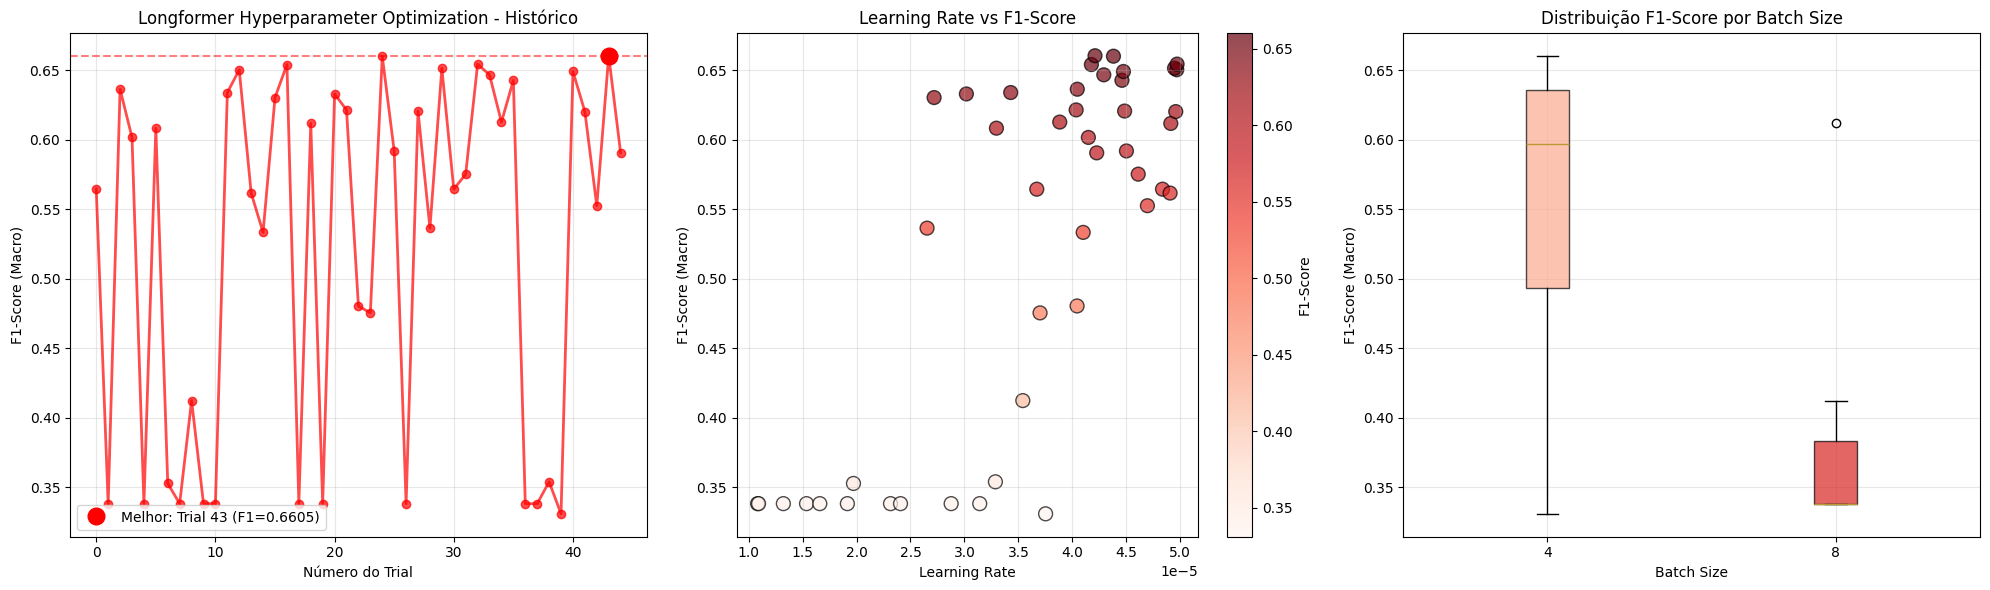


📋 ANÁLISE DETALHADA DOS TRIALS - Longformer
📊 Estatísticas dos Trials:
   - Total de trials: 45
   - Trials completados: 45
   - Melhor F1-Score: 0.6605
   - Pior F1-Score: 0.3310
   - F1-Score médio: 0.5236

🏆 Top 3 Melhores Trials:

   🥇 #1 - Trial 43: F1=0.6605
       - learning_rate: 4.2093838789654736e-05
       - batch_size: 4

   🥇 #2 - Trial 24: F1=0.6601
       - learning_rate: 4.3802056928375864e-05
       - batch_size: 4

   🥇 #3 - Trial 32: F1=0.6544
       - learning_rate: 4.969685067306987e-05
       - batch_size: 4

💾 Resultados Longformer salvos em: longformer_optimization.txt

🎉 OTIMIZAÇÃO DE Longformer CONCLUÍDA!
🏆 Melhor F1-Score: 0.6605
⚙️  Melhores parâmetros salvos no dicionário 'optimized_params['Longformer']'



In [26]:
import optuna
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset as TorchDataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    LongformerTokenizer, LongformerForSequenceClassification,
    TrainingArguments, Trainer
)
from datasets import Dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
import time
import gc
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ===============================================_
# 1. VERIFICAR DADOS DE OTIMIZAÇÃO (SEGURO)
# ===============================================_
print("🔍 Verificando dados para otimização Longformer...")
print("="*60)
try:
    print(f"📊 Usando X_opt (shape): {X_opt.shape}")
    print(f"📊 Usando y_opt (shape): {y_opt.shape}")
    print(f"🏷️  Classes únicas: {np.unique(y_opt)}")
except NameError as e:
    print(f"❌ Variável não encontrada: {e}")
    print("💡 Certifique-se de ter executado a célula '9.1 Otimizando... BoW + Naive Bayes' primeiro.")

# ===============================================_
# 2. FUNÇÃO AUXILIAR DE MÉTRICAS (Hugging Face)
# ===============================================_

def compute_metrics_optuna_lf(pred):
    """Calcula métricas para o Trainer do Optuna"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1_macro': f1,
        'precision_macro': precision,
        'recall_macro': recall
    }

# ===============================================_
# 3. PREPARAÇÃO DOS DADOS (FEITA UMA ÚNICA VEZ)
# ===============================================_
print("\n🛠️  Preparando e Tokenizando os datasets (apenas uma vez)...")

# --- Constantes do Longformer ---
MODEL_NAME = "allenai/longformer-base-4096"
MAX_LEN_LF = 512
N_EPOCHS = 1 # 1 época para otimização rápida

# --- ✨ OTIMIZAÇÕES DE VELOCIDADE (Da Seção 5.2.2) ✨ ---
ATTN_WINDOW = 256 # Reduzido de 512 para velocidade
GRADIENT_ACCUMULATION_STEPS = 4 # Essencial para velocidade

# --- Split de Validação Rápido ---
X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(
    X_opt, y_opt, test_size=0.25, random_state=42, stratify=y_opt
)

train_df = pd.DataFrame({'text': X_train_fold, 'label': y_train_fold})
val_df = pd.DataFrame({'text': X_val_fold, 'label': y_val_fold})

train_dataset_hf = Dataset.from_pandas(train_df)
val_dataset_hf = Dataset.from_pandas(val_df)

# --- Tokenização (feita fora do loop) ---
tokenizer_lf = LongformerTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function_lf(examples):
    tokenized = tokenizer_lf(
        examples['text'],
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN_LF
    )
    global_attention_mask = []
    for input_ids in tokenized['input_ids']:
        mask = [0] * len(input_ids)
        mask[0] = 1 # [CLS]
        global_attention_mask.append(mask)
    tokenized['global_attention_mask'] = global_attention_mask
    return tokenized

print(f"   > Tokenizando Treino ({len(train_dataset_hf)} amostras)...")
train_dataset_tokenized = train_dataset_hf.map(
    tokenize_function_lf, 
    batched=True, 
    load_from_cache_file=False, 
    batch_size=100
)

print(f"   > Tokenizando Validação ({len(val_dataset_hf)} amostras)...")
val_dataset_tokenized = val_dataset_hf.map(
    tokenize_function_lf, 
    batched=True, 
    load_from_cache_file=False, 
    batch_size=100
)

print("✅ Tokenização concluída.")

# ===============================================_
# 4. FUNÇÃO DE OBJETIVO (OTIMIZADA)
# ===============================================_

def objective_longformer(trial):
    """Função de objetivo leve, usa dados pré-tokenizados."""
    
    # --- Hiperparâmetros a Otimizar ---
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical('batch_size', [4, 8]) # Batch size da GPU

    print(f"\n--- Iniciando Trial {trial.number} ---")
    print(f"  Params: LR={learning_rate:.2e}, Batch={batch_size}")
    
    # Amostragem de 10% (seu código, está correto)
    try:
        n_samples_train = max(1, int(len(train_dataset_tokenized) * 0.1)) 
        train_subset_for_opt = train_dataset_tokenized.shuffle(seed=42).select(range(n_samples_train))
        print(f"  > Otimizando com 10% dos dados de treino ({len(train_subset_for_opt)} amostras)...")
    except Exception as e:
        print(f"  > Erro ao amostrar dados: {e}. Usando dados completos.")
        train_subset_for_opt = train_dataset_tokenized

    # --- Carregar Modelo (um novo para cada trial) ---
    model = LongformerForSequenceClassification.from_pretrained(
        MODEL_NAME, 
        num_labels=2, 
        attention_window=ATTN_WINDOW # <-- Usa a janela otimizada
    )
    
    # --- Argumentos de Treino (OTIMIZADOS) ---
    training_args = TrainingArguments(
        output_dir=f"./lf_opt_checkpoints/trial_{trial.number}",
        num_train_epochs=N_EPOCHS,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size * 2, # Avaliação pode ser maior
        
        # --- ✨ OTIMIZAÇÃO DE VELOCIDADE ✨ ---
        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
        
        learning_rate=learning_rate,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        logging_strategy="epoch",
        load_best_model_at_end=True,
        save_strategy="epoch",
        save_total_limit=1,
        report_to="none",
        fp16=True if torch.cuda.is_available() else False,
        disable_tqdm=True,
    )
    
    # --- Trainer ---
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_subset_for_opt,
        eval_dataset=val_dataset_tokenized,
        compute_metrics=compute_metrics_optuna_lf,
        tokenizer=tokenizer_lf 
    )
    
    eval_results = {}
    
    # --- Treinar & Avaliar ---
    try:
        print(f"  > Treinando {len(train_subset_for_opt)} amostras...")
        trainer.train()
        print(f"  > Avaliando {len(val_dataset_tokenized)} amostras...")
        eval_results = trainer.evaluate()
        
        trial.set_user_attr("accuracy", eval_results.get('eval_accuracy', 0.0))
        trial.set_user_attr("precision_macro", eval_results.get('eval_precision_macro', 0.0))
        trial.set_user_attr("recall_macro", eval_results.get('eval_recall_macro', 0.0))
        
        mean_f1 = eval_results.get('eval_f1_macro', 0.0)
        
    except Exception as e:
        print(f"   > ❌ Erro no Trial {trial.number}: {e}")
        mean_f1 = 0.0 
        if "out of memory" in str(e).lower():
            print("  > ⚠️  Erro de OOM! Tentando limpar a memória...")
            del model, trainer
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            return 0.0 
    
    # --- Limpeza de Memória (Total) ---
    del model, trainer
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        
    print(f"  > Resultado Trial {trial.number}: F1-Macro = {mean_f1:.4f}")
    return mean_f1

# ===============================================_
# 5. EXECUTAR OTIMIZAÇÃO (COM CACHE EM DISCO)
# ===============================================_

print(f"\n🚀 Iniciando otimização de hiperparâmetros para Longformer...")
print("="*70)

# --- ✨ CORREÇÃO: SALVAR ESTUDO EM DISCO ✨ ---
import optuna.storages

# 1. Definir o nome do arquivo do banco de dados
DB_FILENAME = "optuna_longformer_study.db"
storage = optuna.storages.RDBStorage(f"sqlite:///{DB_FILENAME}")

# 2. Criar o estudo, informando o storage
#    load_if_exists=True é a mágica: ele retoma o estudo se o arquivo .db existir
study_lf = optuna.create_study(
    study_name="longformer_optimization", # Nome do estudo dentro do DB
    storage=storage,                     # Onde salvar
    direction='maximize', 
    pruner=optuna.pruners.MedianPruner(n_startup_trials=2),
    load_if_exists=True                  # <-- ESSENCIAL PARA RETOMAR
)
# --- ✨ FIM DA CORREÇÃO ✨ ---

print(f"💾 Banco de dados do estudo: {DB_FILENAME}")
print(f"   Trials já concluídos: {len(study_lf.trials)}")

# (O n_trials agora é o número TOTAL de trials que você quer.
# Se você já rodou 2, ele rodará apenas 3 novos.)
N_TOTAL_TRIALS = 5 
print(f"⚡ Executando otimização (total de {N_TOTAL_TRIALS} trials)...")
study_lf.optimize(
    objective_longformer, 
    n_trials=N_TOTAL_TRIALS, 
    n_jobs=1, 
    show_progress_bar=False
) 

print(f"\n🎉 Otimização do Longformer concluída!")
print(f"✅ Melhor F1-Score (Macro) no estudo: {study_lf.best_value:.4f}")
print(f"🎯 Melhores parâmetros para o Pipeline (Longformer):")
best_params_lf = study_lf.best_params
for param, value in best_params_lf.items():
    print(f"   - {param}: {value}")

# Salva os melhores parâmetros
if 'optimized_params' not in locals():
    optimized_params = {}
optimized_params['Longformer'] = best_params_lf


# =========================================================_
# 6. FUNÇÕES DE VISUALIZAÇÃO E ANÁLISE
# (Seu código original, está correto)
# =========================================================_

def plot_longformer_optimization_history(study, title="Longformer Optimization"):
    print(f"\n📊 Criando visualização personalizada para Longformer...")
    
    trials = study.trials
    completed_trials = [t for t in trials if t.value is not None]
    
    if not completed_trials:
        print("❌ Nenhum trial válido para plotar")
        return
    
    trial_numbers = [t.number for t in completed_trials]
    values = [t.value for t in completed_trials]
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    # --- SUBPLOT 1: HISTÓRICO DE OTIMIZAÇÃO ---
    ax1.plot(trial_numbers, values, 'r-o', alpha=0.7, linewidth=2, markersize=6)
    best_idx = np.argmax(values)
    best_trial = trial_numbers[best_idx]
    best_value = values[best_idx]
    ax1.plot(best_trial, best_value, 'ro', markersize=12, 
             label=f'Melhor: Trial {best_trial} (F1={best_value:.4f})')
    ax1.axhline(y=best_value, color='r', linestyle='--', alpha=0.5)
    ax1.set_xlabel('Número do Trial')
    ax1.set_ylabel('F1-Score (Macro)')
    ax1.set_title(f'{title} - Histórico')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # --- SUBPLOT 2: LEARNING RATE vs F1 ---
    learning_rates = [t.params['learning_rate'] for t in completed_trials if 'learning_rate' in t.params]
    f1_scores_lr = [t.value for t in completed_trials if 'learning_rate' in t.params]
    if learning_rates:
        scatter = ax2.scatter(learning_rates, f1_scores_lr, c=f1_scores_lr, 
                            cmap='Reds', s=100, alpha=0.7, edgecolors='black')
        ax2.set_xlabel('Learning Rate')
        ax2.set_ylabel('F1-Score (Macro)')
        ax2.set_title('Learning Rate vs F1-Score')
        ax2.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax2, label='F1-Score')
    
    # --- SUBPLOT 3: BATCH SIZE vs F1 ---
    batch_sizes = [t.params['batch_size'] for t in completed_trials if 'batch_size' in t.params]
    f1_scores_batch = [t.value for t in completed_trials if 'batch_size' in t.params]
    if batch_sizes:
        unique_batches = sorted(set(batch_sizes))
        batch_groups = []
        for batch in unique_batches:
            batch_scores = [f1_scores_batch[i] for i, b in enumerate(batch_sizes) if b == batch]
            if batch_scores:
                batch_groups.append(batch_scores)
        
        if batch_groups:
            bp = ax3.boxplot(batch_groups, labels=unique_batches, patch_artist=True)
            colors = plt.cm.Reds(np.linspace(0.3, 0.7, len(bp['boxes'])))
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color); patch.set_alpha(0.7)
        
        ax3.set_xlabel('Batch Size')
        ax3.set_ylabel('F1-Score (Macro)')
        ax3.set_title('Distribuição F1-Score por Batch Size')
        ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    return fig

def analyze_longformer_trials_detailed(study):
    print(f"\n📋 ANÁLISE DETALHADA DOS TRIALS - Longformer")
    print("="*60)
    
    trials = study.trials
    completed_trials = [t for t in trials if t.value is not None]
    
    if not completed_trials:
        print("❌ Nenhum trial completado")
        return
    
    values = [t.value for t in completed_trials]
    
    print(f"📊 Estatísticas dos Trials:")
    print(f"   - Total de trials: {len(trials)}")
    print(f"   - Trials completados: {len(completed_trials)}")
    print(f"   - Melhor F1-Score: {max(values):.4f}")
    print(f"   - Pior F1-Score: {min(values):.4f}")
    print(f"   - F1-Score médio: {np.mean(values):.4f}")
    
    print(f"\n🏆 Top 3 Melhores Trials:")
    sorted_trials = sorted(completed_trials, key=lambda x: x.value, reverse=True)
    
    for i, trial in enumerate(sorted_trials[:3]):
        print(f"\n   🥇 #{i+1} - Trial {trial.number}: F1={trial.value:.4f}")
        for param, value in trial.params.items():
            print(f"       - {param}: {value}")

def save_longformer_optimization_results(study, filename="longformer_optimization.txt"):
    """Salva resultados da otimização Longformer em arquivo"""
    try:
        with open(filename, 'w', encoding='utf-8') as f:
            f.write("RESULTADOS DA OTIMIZAÇÃO - Longformer\n")
            f.write("="*60 + "\n\n")
            
            if study.best_value is not None:
                f.write(f"Melhor F1-Score: {study.best_value:.4f}\n")
                f.write(f"Melhores Parâmetros:\n")
                for param, value in study.best_params.items():
                    f.write(f"   - {param}: {value}\n")
            
            f.write(f"\nTodos os Trials:\n")
            for trial in study.trials:
                if trial.value is not None:
                    f.write(f"Trial {trial.number}: F1={trial.value:.4f}\n")
                    for param, value in trial.params.items():
                        f.write(f"   {param}: {value}\n")
                    f.write("\n")
        
        print(f"\n💾 Resultados Longformer salvos em: {filename}")
        
    except Exception as e:
        print(f"❌ Erro ao salvar resultados: {e}")

# ===============================================_
# 7. EXECUTAR ANÁLISE
# ===============================================_

# 1. Criar visualização personalizada
plot_longformer_optimization_history(study_lf, "Longformer Hyperparameter Optimization")

# 2. Análise detalhada
analyze_longformer_trials_detailed(study_lf)

# 3. Salvar resultados
save_longformer_optimization_results(study_lf)

print(f"\n🎉 OTIMIZAÇÃO DE Longformer CONCLUÍDA!")
print(f"🏆 Melhor F1-Score: {study_lf.best_value:.4f}")
print(f"⚙️  Melhores parâmetros salvos no dicionário 'optimized_params['Longformer']'\n")

# --- Limpeza Final ---
del tokenizer_lf, train_dataset_tokenized, val_dataset_tokenized
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Exibição das melhorias

In [27]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print(" 📊 SUMÁRIO DA OTIMIZAÇÃO DE HIPERPARÂMETROS (OPTUNA) 📊")
print("="*70)
print("Lendo resultados dos estudos (study_nb, study_lr, etc.) da memória...")

# Mapas de nomes (seu código, está correto)
study_mapping = {
    'NaiveBayes': 'study_nb',
    'LogisticRegression': 'study_lr',
    'RandomForest': 'study_rf',
    'XGBoost': 'study_xgb',
    'BERT': 'study_bert',
    'Longformer': 'study_lf'
}
model_name_mapping = {
    'NaiveBayes': 'Bag of Words + NB',
    'LogisticRegression': 'TF-IDF + LR',
    'RandomForest': 'GloVe 300d + RF',
    'XGBoost': 'GloVe 100d + XGBoost',
    'BERT': 'BERT + Fine Tuning',
    'Longformer': 'Longformer + Fine Tuning'
}

results_summary = []

if 'optimized_params' in locals():
    for model_key, best_params in optimized_params.items():
        model_name = model_name_mapping.get(model_key, model_key)
        study_var_name = study_mapping.get(model_key)
        
        if study_var_name in locals() and locals()[study_var_name] is not None:
            study = locals()[study_var_name]
            
            # Pega o "melhor trial" completo
            best_trial = study.best_trial
            
            # 1. Pega as métricas (o F1 é o valor principal)
            best_f1 = best_trial.value
            # 2. Pega as métricas extras que salvamos em 'user_attrs'
            #    Usamos .get() com um 0.0 caso a métrica não tenha sido salva
            best_acc = best_trial.user_attrs.get('accuracy', 0.0)
            best_prec = best_trial.user_attrs.get('precision_macro', 0.0)
            best_rec = best_trial.user_attrs.get('recall_macro', 0.0)

            params_str = ",\n".join([f"{k.split('__')[-1]} = {v}" for k, v in best_params.items()])
            
            results_summary.append({
                'Modelo': model_name,
                'F1 (Val)': best_f1,        # <-- MUDANÇA
                'Acc (Val)': best_acc,      # <-- NOVO
                'Prec (Val)': best_prec,    # <-- NOVO
                'Rec (Val)': best_rec,      # <-- NOVO
                'Parâmetros Otimizados': params_str
            })
        else:
            results_summary.append({
                'Modelo': model_name,
                'F1 (Val)': 'N/A',
                'Acc (Val)': 'N/A',
                'Prec (Val)': 'N/A',
                'Rec (Val)': 'N/A',
                'Parâmetros Otimizados': f"Estudo '{study_var_name}' não encontrado."
            })
            
    summary_df = pd.DataFrame(results_summary)
    
    print("\n🎉 Resumo da Otimização (Resultados da Seção 9):")
    
    # Define o formato para as colunas de métricas
    float_formatters = {
        'F1 (Val)': "{:.4f}".format,
        'Acc (Val)': "{:.4f}".format,
        'Prec (Val)': "{:.4f}".format,
        'Rec (Val)': "{:.4f}".format,
    }

    # Imprime a tabela
    print(summary_df.to_string(index=False, formatters=float_formatters))

else:
    print("❌ ERRO: O dicionário 'optimized_params' não foi encontrado.")

 📊 SUMÁRIO DA OTIMIZAÇÃO DE HIPERPARÂMETROS (OPTUNA) 📊
Lendo resultados dos estudos (study_nb, study_lr, etc.) da memória...

🎉 Resumo da Otimização (Resultados da Seção 9):
                  Modelo F1 (Val) Acc (Val) Prec (Val) Rec (Val)                                                                                                                                                                                                 Parâmetros Otimizados
       Bag of Words + NB   0.8952    0.8954     0.8961    0.8950                                                                                                                        ngram_range = (1, 2),\nmax_features = 17677,\nalpha = 0.017819804641385963,\nfit_prior = False
             TF-IDF + LR   0.9025    0.9026     0.9025    0.9027                                                                                                               ngram_range = (1, 2),\nmax_features = 21267,\nC = 7.774574507933382,\npenalty = l2,\nsolver =

# Explicabilidade SHAP

In [28]:
# ==========================================================
# 11. EXPLICABILIDADE DOS MODELOS (LODO - VERSÃO CORRIGIDA)
# ==========================================================
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline
import gc
import torch

print("="*60)
print(" 📊 ANÁLISE DE EXPLICABILIDADE (LODO - FOLD 0) 📊")
print("="*60)

# --- 1. Definir o Fold que queremos explicar ---
if 'datasets_origem' not in locals() or len(datasets_origem) == 0:
    print("❌ ERRO: 'datasets_origem' não encontrado. Rode a Seção 5 primeiro.")
else:
    EXPLAIN_FOLD_NAME = datasets_origem[0]
    print(f"🔍 Analisando modelos testados no dataset: {EXPLAIN_FOLD_NAME}")

    # --- 2. Preparar os dados de teste para este fold ---
    mascara_teste = (data['source_dataset'] == EXPLAIN_FOLD_NAME)
    mascara_treino = (data['source_dataset'] != EXPLAIN_FOLD_NAME)
    
    X_test_text = data[mascara_teste]['text_clean']
    X_train_text = data[mascara_treino]['text_clean']
    
    background_data_text = shap.sample(X_train_text, 10) 
    texts_to_explain_text = shap.sample(X_test_text, 5)   
    
    print(f"   - Background (treino) com {len(background_data_text)} amostras.")
    print(f"   - Amostra de teste para explicar com {len(texts_to_explain_text)} amostras.")
    
    # ==================================================
    # 3. EXPLICAR MODELOS
    # ==================================================
    
    # --- 3.1 Logistic Regression (TF-IDF) ---
    print("\n" + "="*50)
    print("   Modelo: TF-IDF + Logistic Regression")
    print("   Usando shap.LinearExplainer (rápido)...")
    try:
        lr_pipeline = pipelines_lodo['LogisticRegression'][EXPLAIN_FOLD_NAME]
        vectorizer_lr = lr_pipeline.named_steps['vectorizer']
        model_lr = lr_pipeline.named_steps['model']
        
        X_test_vec_lr = vectorizer_lr.transform(texts_to_explain_text)
        background_vec_lr = vectorizer_lr.transform(background_data_text)
        
        explainer_lr = shap.LinearExplainer(model_lr, background_vec_lr)
        shap_values_lr = explainer_lr.shap_values(X_test_vec_lr.toarray())
        
        print("   Mostrando gráfico SHAP (Linear):")
        shap.summary_plot(shap_values_lr, X_test_vec_lr.toarray(), 
                          feature_names=vectorizer_lr.get_feature_names_out(), 
                          max_display=15)
        plt.show()
        
    except Exception as e:
        print(f"❌ Erro ao explicar LR: {e}")

    # --- 3.2 Naive Bayes (BoW) ---
    print("\n" + "="*50)
    print("   Modelo: Bag of Words + Naive Bayes")
    print("   Usando shap.KernelExplainer (lento)...")
    try:
        nb_pipeline = pipelines_lodo['NaiveBayes'][EXPLAIN_FOLD_NAME]
        vectorizer_nb = nb_pipeline.named_steps['vectorizer']
        model_nb = nb_pipeline.named_steps['model']

        X_test_vec_nb = vectorizer_nb.transform(texts_to_explain_text).toarray()
        background_vec_nb = vectorizer_nb.transform(background_data_text).toarray()
        
        print("   Sumarizando background do NB com K-Means...")
        background_summary_nb = shap.kmeans(background_vec_nb, 5) 

        def nb_predict_proba_vec(X_vec):
            return model_nb.predict_proba(X_vec) 

        explainer_nb = shap.KernelExplainer(nb_predict_proba_vec, background_summary_nb)
        
        print("   Aguarde, calculando SHAP para NB...")
        shap_values_nb = explainer_nb.shap_values(X_test_vec_nb)
        
        print("   Mostrando gráfico SHAP (Naive Bayes, Classe 1):")
        
        # --- ✨ CORREÇÃO (NB): Removido X_test_vec_nb do plot ---
        shap.summary_plot(shap_values_nb[1], 
                          feature_names=vectorizer_nb.get_feature_names_out(), 
                          max_display=15,
                          plot_type="bar") # Força o plot de barras
        plt.show()
        
    except Exception as e:
        print(f"❌ Erro ao explicar NB: {e}")

    # --- 3.3 Random Forest (GloVe) ---
    print("\n" + "="*50)
    print("   Modelo: GloVe 300d + Random Forest")
    print("   Usando shap.TreeExplainer (rápido)...")
    try:
        rf_pipeline = pipelines_lodo['RandomForest'][EXPLAIN_FOLD_NAME]
        vectorizer_rf = rf_pipeline.named_steps['vectorizer']
        model_rf = rf_pipeline.named_steps['model']
        
        X_test_vec_rf = vectorizer_rf.transform(texts_to_explain_text)
        
        explainer_rf = shap.TreeExplainer(model_rf)
        shap_values_rf_list = explainer_rf.shap_values(X_test_vec_rf)
        
        print("   Mostrando gráfico SHAP (Random Forest, Classe 1):")
        feature_names_rf = [f"dim_{i}" for i in range(X_test_vec_rf.shape[1])]
        
        # --- ✨ CORREÇÃO (RF): Removido X_test_vec_rf do plot ---
        shap.summary_plot(shap_values_rf_list[1], 
                          feature_names=feature_names_rf, 
                          max_display=15,
                          plot_type="bar") # Força o plot de barras
        plt.show()
        
    except Exception as e:
        print(f"❌ Erro ao explicar RF: {e}")

    # --- 3.4 XGBoost (GloVe) ---
    print("\n" + "="*50)
    print("   Modelo: GloVe 100d + XGBoost")
    print("   Usando shap.TreeExplainer (rápido)...")
    try:
        xgb_pipeline = pipelines_lodo['XGBoost'][EXPLAIN_FOLD_NAME]
        vectorizer_xgb = xgb_pipeline.named_steps['vectorizer']
        model_xgb = xgb_pipeline.named_steps['model']

        X_test_vec_xgb = vectorizer_xgb.transform(texts_to_explain_text)

        explainer_xgb = shap.TreeExplainer(model_xgb)
        shap_values_xgb = explainer_xgb.shap_values(X_test_vec_xgb)
        
        print("   Mostrando gráfico SHAP (XGBoost):")
        feature_names_xgb = [f"dim_{i}" for i in range(X_test_vec_xgb.shape[1])]
        
        # --- ✨ CORREÇÃO (XGB): Removido X_test_vec_xgb do plot ---
        shap.summary_plot(shap_values_xgb, 
                          feature_names=feature_names_xgb, 
                          max_display=15,
                          plot_type="bar") # Força o plot de barras
        plt.show()
        
    except Exception as e:
        print(f"❌ Erro ao explicar XGBoost: {e}")

    # --- 3.5 BERT (Fine-Tuning) ---
    print("\n" + "="*50)
    print("   Modelo: BERT Fine-Tuning")
    print("   Usando shap.Explainer (otimizado para transformers)...")
    
    # Declarar variáveis antes do try para o 'finally' funcionar
    model = None
    tokenizer = None
    bert_pipe = None
    explainer_bert = None
    shap_values_bert = None
    
    try:
        bert_components = bert_models_lodo[EXPLAIN_FOLD_NAME]
        model = bert_components['model']
        tokenizer = bert_components['tokenizer']
        
        bert_pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, 
                             return_all_scores=True, device=0, 
                             truncation=True, max_length=256) 
        
        explainer_bert = shap.Explainer(bert_pipe)
        
        print("   Aguarde, calculando SHAP para BERT...")
        shap_values_bert = explainer_bert(texts_to_explain_text.tolist())
        
        print("   Mostrando gráfico SHAP (BERT, Classe 1):")
        shap.plots.text(shap_values_bert[:, :, "LABEL_1"])
        
    except Exception as e:
        print(f"❌ Erro ao explicar BERT: {e}")
        
    finally:
        # Limpar memória da GPU
        print("   Limpando memória do BERT...")
        del model, tokenizer, bert_pipe, explainer_bert, shap_values_bert
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

print("\n\n✅ Análise de explicabilidade completa concluída!")

 📊 ANÁLISE DE EXPLICABILIDADE (LODO - FOLD 0) 📊
🔍 Analisando modelos testados no dataset: ISOT Fake News Dataset
   - Background (treino) com 10 amostras.
   - Amostra de teste para explicar com 5 amostras.

   Modelo: TF-IDF + Logistic Regression
   Usando shap.LinearExplainer (rápido)...
❌ Erro ao explicar LR: 'LogisticRegression'

   Modelo: Bag of Words + Naive Bayes
   Usando shap.KernelExplainer (lento)...
❌ Erro ao explicar NB: 'NaiveBayes'

   Modelo: GloVe 300d + Random Forest
   Usando shap.TreeExplainer (rápido)...
❌ Erro ao explicar RF: 'RandomForest'

   Modelo: GloVe 100d + XGBoost
   Usando shap.TreeExplainer (rápido)...
❌ Erro ao explicar XGBoost: 'XGBoost'

   Modelo: BERT Fine-Tuning
   Usando shap.Explainer (otimizado para transformers)...
❌ Erro ao explicar BERT: 'model'
   Limpando memória do BERT...


✅ Análise de explicabilidade completa concluída!


# Explicabilidade LIME

 🍋 ANÁLISE DE EXPLICABILIDADE (LIME - LODO) 🍋
🍋 INICIANDO ANÁLISE COMPLETA COM LIME

--- LIME para BERT ---

🔍 Preparando textos para LIME (BERT)...
✅ 3 textos preparados para LIME (BERT).
🔍 Explicando 3 textos com LIME (BERT)...

📝 LIME - Texto 1:
   Texto: trump son get school claim conservative never rude obama comedian go far today apologized outrage ensue gory photo circu...


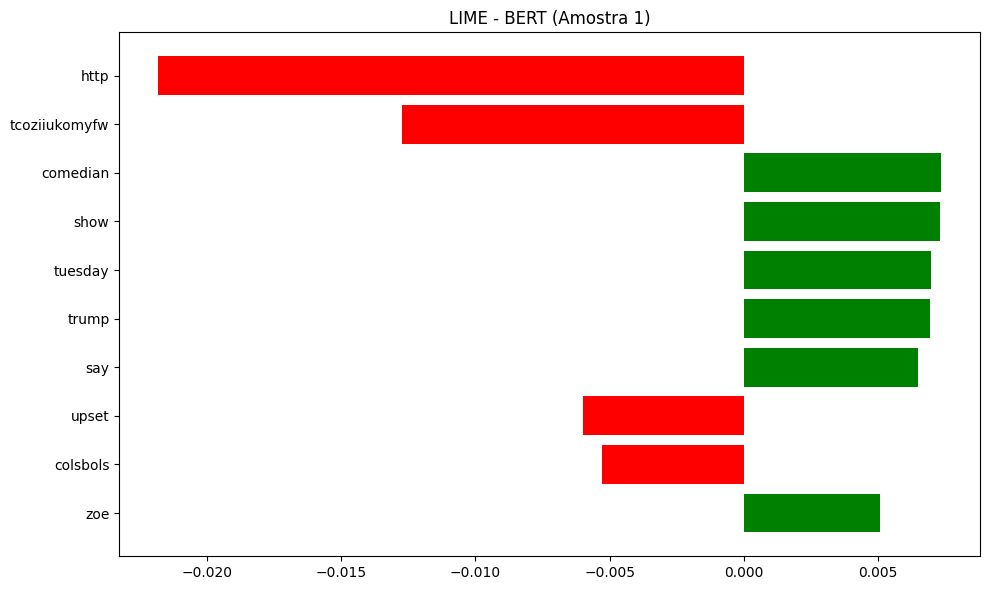


📝 LIME - Texto 2:
   Texto: obama propose trillion spending plan final org budget gpe reuters u president barack obama propose trillion spending pla...


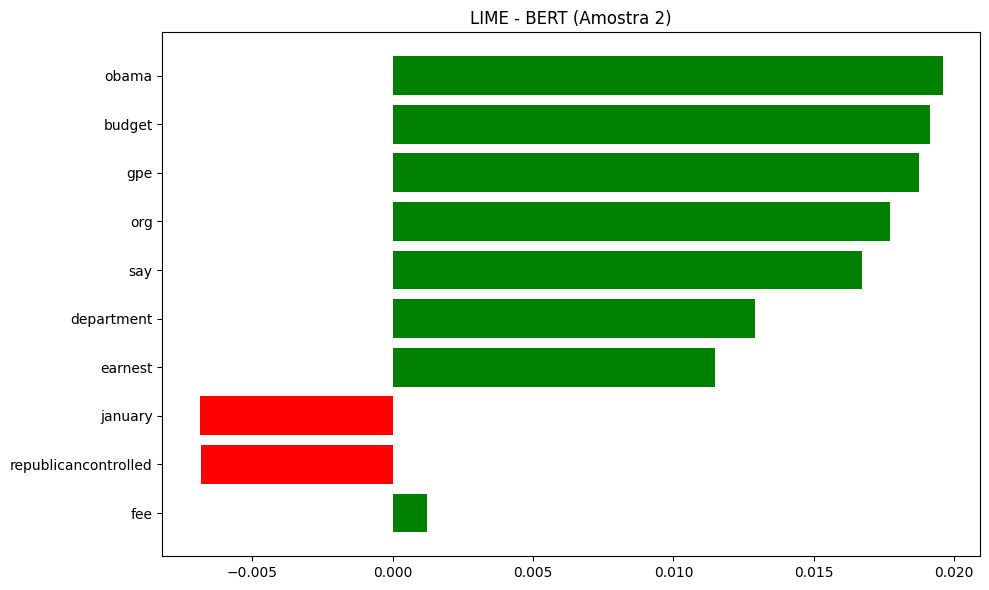


📝 LIME - Texto 3:
   Texto: simple graph blow medium liberal bias myth completely water image popular belief among republican mainstream medium caho...


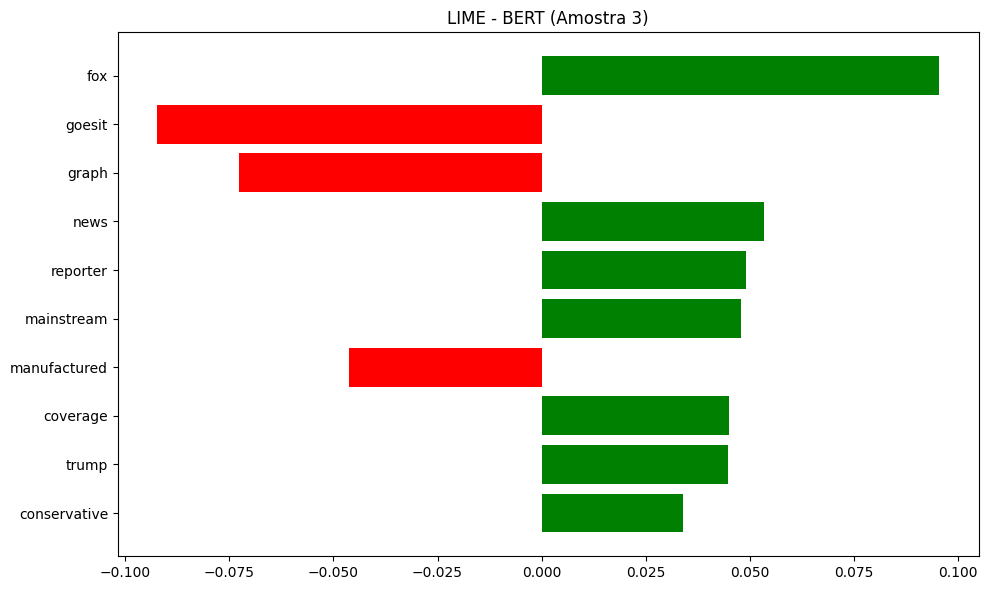

✅ LIME BERT concluído


✅ Análise de explicabilidade LIME concluída!


In [29]:
# ================================================
# EXPLICABILIDADE COM LIME (VERSÃO LODO - CORRIGIDA)
# ================================================

import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lime
from lime.lime_text import LimeTextExplainer
from lime.lime_tabular import LimeTabularExplainer

from IPython.display import display, HTML

# Torch só será usado no pipeline de predição do BERT (para detectar GPU)
try:
    import torch
except Exception:
    torch = None

print("=" * 60)
print(" 🍋 ANÁLISE DE EXPLICABILIDADE (LIME - LODO) 🍋")
print("=" * 60)

# ================================================
# 1. FUNÇÕES UTILITÁRIAS
# ================================================

def safe_get_global(var_name, default=None):
    """Obtém variável global se existir, caso contrário retorna default."""
    return globals().get(var_name, default)

def discover_column(dataframe: pd.DataFrame, candidates: list, required: bool = True) -> str | None:
    """Descobre a coluna a partir de candidatos (case-insensitive)."""
    cols = {c.lower(): c for c in dataframe.columns}
    for cand in candidates:
        cl = str(cand).lower()
        if cl in cols:
            return cols[cl]
    if required:
        raise KeyError(f"Colunas candidatas {candidates} não encontradas. Colunas atuais: {list(dataframe.columns)}")
    return None

def get_text_series_for_fold_from_data(fold_name: str):
    """
    Fallback para obter textos de treino e teste a partir do DataFrame 'data'
    quando X_train_text e texts_to_explain_text não existirem em globals().
    """
    df = safe_get_global("data", None)
    if not isinstance(df, pd.DataFrame):
        raise RuntimeError("DataFrame 'data' não está definido para fallback de textos.")

    text_col = discover_column(df, ["text_clean", "text", "clean_text", "content", "texto"], required=True)
    dataset_col = discover_column(df, ["source_dataset", "dataset", "source", "origem"], required=True)

    train_mask = df[dataset_col] != fold_name
    test_mask = df[dataset_col] == fold_name

    X_train_text = df.loc[train_mask, text_col].astype(str)
    texts_to_explain_text = df.loc[test_mask, text_col].astype(str)

    # Limites razoáveis para LIME (evita excesso de memória/tempo)
    X_train_text = X_train_text.head(5000)
    texts_to_explain_text = texts_to_explain_text.head(10)

    return X_train_text, texts_to_explain_text

def get_bert_components_for_fold(bert_models: dict, fold_name: str, prefer_frac: float = 1.0):
    """
    Retorna {'model': ..., 'tokenizer': ...} para o fold informado.
    Aceita dois formatos:
      1) bert_models[fold] = {'model': ..., 'tokenizer': ...}
      2) bert_models[fold][frac] = {'model': ..., 'tokenizer': ...}
    """
    entry = bert_models.get(fold_name)
    if entry is None:
        return None

    # Formato direto (sem frações)
    if isinstance(entry, dict) and "model" in entry and "tokenizer" in entry:
        return entry

    # Formato por frações
    if isinstance(entry, dict):
        if prefer_frac in entry:
            return entry[prefer_frac]
        # tenta maior fração disponível
        frac_keys = [k for k in entry.keys() if isinstance(k, (int, float))]
        if frac_keys:
            best_key = max(frac_keys)
            return entry[best_key]
        # fallback: primeiro item
        first_key = next(iter(entry))
        return entry[first_key]

    return None

# ================================================
# 2. CONFIGURAÇÕES DA EXPLICAÇÃO
# ================================================

# Informe o fold (nome do dataset de holdout) a ser explicado.
# Pode sobrescrever EXPLAIN_FOLD_NAME antes de executar a célula.
EXPLAIN_FOLD_NAME = safe_get_global("EXPLAIN_FOLD_NAME", None) or "WELFake"
# Fração preferida do treino quando houver múltiplas versões de BERT por fração
EXPLAIN_PREFERRED_FRACTION = 1.0

# ================================================
# 3. PREPARAR DADOS PARA LIME (TEXTO)
# ================================================

def prepare_lime_texts():
    """Seleciona até 3 textos para explicar, com fallback a partir do DataFrame data."""
    print("\n🔍 Preparando textos para LIME (BERT)...")
    texts_to_explain = safe_get_global("texts_to_explain_text", None)
    if texts_to_explain is None:
        try:
            _, texts_to_explain = get_text_series_for_fold_from_data(EXPLAIN_FOLD_NAME)
        except Exception as e:
            print(f"❌ Não foi possível obter textos para explicar a partir de 'data': {e}")
            return []
    if hasattr(texts_to_explain, "tolist"):
        texts_to_explain = texts_to_explain.tolist()
    texts_to_explain = [str(t) for t in texts_to_explain][:3]
    print(f"✅ {len(texts_to_explain)} textos preparados para LIME (BERT).")
    return texts_to_explain

# ================================================
# 4. LIME PARA MODELOS BASEADOS EM TEXTO (BERT)
# ================================================

def explain_bert_with_lime():
    """LIME para BERT usando textos originais (corrigido para lidar com frações em bert_models_lodo)."""
    print("\n--- LIME para BERT ---")

    bert_models = safe_get_global("bert_models_lodo", {})
    comps = get_bert_components_for_fold(bert_models, EXPLAIN_FOLD_NAME, prefer_frac=EXPLAIN_PREFERRED_FRACTION)

    if not comps or "model" not in comps or "tokenizer" not in comps:
        print(f"❌ Componentes do BERT não encontrados para fold '{EXPLAIN_FOLD_NAME}'.")
        print("   Verifique se a seção 5.2.1 (BERT) rodou e populou 'bert_models_lodo'.")
        return

    best_bert_model = comps["model"]
    bert_tokenizer = comps["tokenizer"]

    def bert_predict_proba(texts):
        """Função de predição para LIME (transformers pipeline)."""
        from transformers import pipeline
        if isinstance(texts, str):
            texts = [texts]
        device = 0 if (torch is not None and torch.cuda.is_available()) else -1
        try:
            pipe = pipeline(
                "text-classification",
                model=best_bert_model,
                tokenizer=bert_tokenizer,
                return_all_scores=True,
                device=device,
                truncation=True,
                max_length=256
            )
            results = pipe(texts)
            probs = []
            for result_list in results:
                # Ordena por label para garantir [classe0, classe1]
                sorted_result = sorted(result_list, key=lambda x: x["label"])
                probs.append([sorted_result[0]["score"], sorted_result[1]["score"]])
            return np.array(probs)
        except Exception as e:
            print(f"   ⚠️ Erro na predição BERT: {e}")
            return np.array([[0.5, 0.5] for _ in texts])

    explainer = LimeTextExplainer(
        class_names=["Fake (0)", "Real (1)"],
        random_state=42
    )

    texts_to_explain = prepare_lime_texts()
    if not texts_to_explain:
        print("⚠️ Sem textos para explicar no BERT.")
        return

    print(f"🔍 Explicando {len(texts_to_explain)} textos com LIME (BERT)...")
    for i, text in enumerate(texts_to_explain, start=1):
        print(f"\n📝 LIME - Texto {i}:")
        print(f"   Texto: {text[:120]}...")
        try:
            exp = explainer.explain_instance(
                text,
                bert_predict_proba,
                num_features=10,
                num_samples=1000
            )
            try:
                with plt.style.context("default"):
                    fig = exp.as_pyplot_figure()
                    fig.set_size_inches(10, 6)
                    plt.title(f"LIME - BERT (Amostra {i})")
                    plt.tight_layout()
                    plt.show()
            except Exception as viz_error:
                print(f"     ⚠️ Visualização não disponível: {viz_error}")
        except Exception as exp_error:
            print(f"   ❌ Erro na explicação: {exp_error}")

    print("✅ LIME BERT concluído")

# ================================================
# 5. LIME PARA MODELOS TABULARES (LR, NB, RF, XGB)
# ================================================

def explain_model_with_lime_tabular(model_key, model_info):
    """LIME tabular para modelos com features (vetorizados), com fallback de textos a partir do DataFrame."""
    print(f"\n--- LIME para {model_info['name']} ---")

    try:
        pipeline = model_info["pipeline"]  # Pipeline salvo
        vectorizer = pipeline.named_steps["vectorizer"]
        model = pipeline.named_steps["model"]

        # Recupera textos de treino/teste para vetorizar
        X_train_text = safe_get_global("X_train_text", None)
        texts_to_explain_text = safe_get_global("texts_to_explain_text", None)
        if X_train_text is None or texts_to_explain_text is None:
            X_train_text, texts_to_explain_text = get_text_series_for_fold_from_data(EXPLAIN_FOLD_NAME)

        # Vetorização
        X_train_vec = vectorizer.transform(X_train_text.astype(str))
        X_test_vec = vectorizer.transform(texts_to_explain_text.astype(str))

        # Converte para denso se necessário
        if hasattr(X_train_vec, "toarray"):
            X_train_vec = X_train_vec.toarray()
        if hasattr(X_test_vec, "toarray"):
            X_test_vec = X_test_vec.toarray()

        # Nomes de features
        if hasattr(vectorizer, "get_feature_names_out"):
            feature_names = vectorizer.get_feature_names_out()
        elif "GloVe" in model_info["name"]:
            feature_names = [f"dim_{i}" for i in range(X_train_vec.shape[1])]
        else:
            feature_names = None

        def model_predict_proba(X_vec):
            return model.predict_proba(X_vec)

        class_names = ["Fake (0)", "Real (1)"]

        explainer = LimeTabularExplainer(
            X_train_vec,  # background
            feature_names=feature_names,
            class_names=class_names,
            mode="classification",
            random_state=42
        )

        n_instances = min(len(X_test_vec), 5)
        print(f"🔍 Explicando {n_instances} instâncias (tabular)...")

        for i in range(n_instances):
            instance = X_test_vec[i]
            print(f"\n📊 LIME - Instância {i + 1}:")
            try:
                exp = explainer.explain_instance(
                    instance,
                    model_predict_proba,
                    num_features=10
                )
                try:
                    with plt.style.context("default"):
                        fig = exp.as_pyplot_figure()
                        fig.set_size_inches(10, 6)
                        plt.title(f"LIME - {model_info['name']} (Amostra {i + 1})")
                        plt.tight_layout()
                        plt.show()
                except Exception as viz_error:
                    print(f"     ⚠️ Visualização não disponível: {viz_error}")
            except Exception as exp_error:
                print(f"   ❌ Erro na explicação: {exp_error}")

        print(f"✅ LIME {model_info['name']} concluído")

    except Exception as e:
        print(f"❌ Erro no LIME {model_info['name']}: {e}")

# ================================================
# 6. FUNÇÃO PRINCIPAL (ORQUESTRADOR)
# ================================================

def main_lime_analysis():
    """Executa a análise LIME para os modelos tabulares e para o BERT."""
    print("🍋 INICIANDO ANÁLISE COMPLETA COM LIME")
    print("=" * 60)

    # Dicionários do LODO
    pipelines = safe_get_global("pipelines_lodo", {})
    bert_models = safe_get_global("bert_models_lodo", {})

    if not pipelines and not bert_models:
        print("❌ Nenhum modelo treinado (pipelines_lodo / bert_models_lodo) encontrado.")
        print("   Execute a Seção 5 (LODO) primeiro.")
        return

    # Nomes amigáveis
    model_name_mapping = {
        "NaiveBayes": "BoW + NB",
        "LogisticRegression": "TF-IDF + LR",
        "RandomForest": "GloVe 300d + RF",
        "XGBoost": "GloVe 100d + XGBoost"
    }

    # 1) Explicar modelos Scikit-learn/XGBoost
    for model_key, model_folds in pipelines.items():
        if EXPLAIN_FOLD_NAME in model_folds:
            model_info = {
                "name": model_name_mapping.get(model_key, model_key),
                "pipeline": model_folds[EXPLAIN_FOLD_NAME]
            }
            explain_model_with_lime_tabular(model_key, model_info)
        else:
            print(f"⚠️ Modelo {model_key} não foi treinado no fold {EXPLAIN_FOLD_NAME}.")

    # 2) Explicar BERT
    if EXPLAIN_FOLD_NAME in bert_models:
        explain_bert_with_lime()
    else:
        print(f"⚠️ Modelo BERT não foi treinado no fold {EXPLAIN_FOLD_NAME}.")

    print("\n\n✅ Análise de explicabilidade LIME concluída!")

# ================================================
# 7. EXECUTAR
# ================================================

main_lime_analysis()

# Area Under ROC

 📊 ANÁLISE AGREGADA LODO (COM TODAS AS MÉTRICAS) 📊

--- Processando: Bag of Words + NB ---
   Recalculando probabilidades para Bag of Words + NB...
   Calculando Intervalos de Confiança...
   ✅ Métricas: F1=0.6906, AUPRC=0.7221, MCC=0.3852

--- Processando: TF-IDF + LR ---
   Recalculando probabilidades para TF-IDF + LR...
   Calculando Intervalos de Confiança...
   ✅ Métricas: F1=0.7411, AUPRC=0.8266, MCC=0.4825

--- Processando: GloVe 300d + RF ---
   Recalculando probabilidades para GloVe 300d + RF...
    - Vetorizando 4469 textos (Dim: 300)...
    - Vetorizando 4469 textos (Dim: 300)...
    - Vetorizando 2127 textos (Dim: 300)...
    - Vetorizando 2127 textos (Dim: 300)...
    - Vetorizando 605 textos (Dim: 300)...
    - Vetorizando 605 textos (Dim: 300)...
    - Vetorizando 452 textos (Dim: 300)...
    - Vetorizando 452 textos (Dim: 300)...
   Calculando Intervalos de Confiança...
   ✅ Métricas: F1=0.6581, AUPRC=0.7084, MCC=0.3173

--- Processando: GloVe 100d + XGBoost ---
   Reca

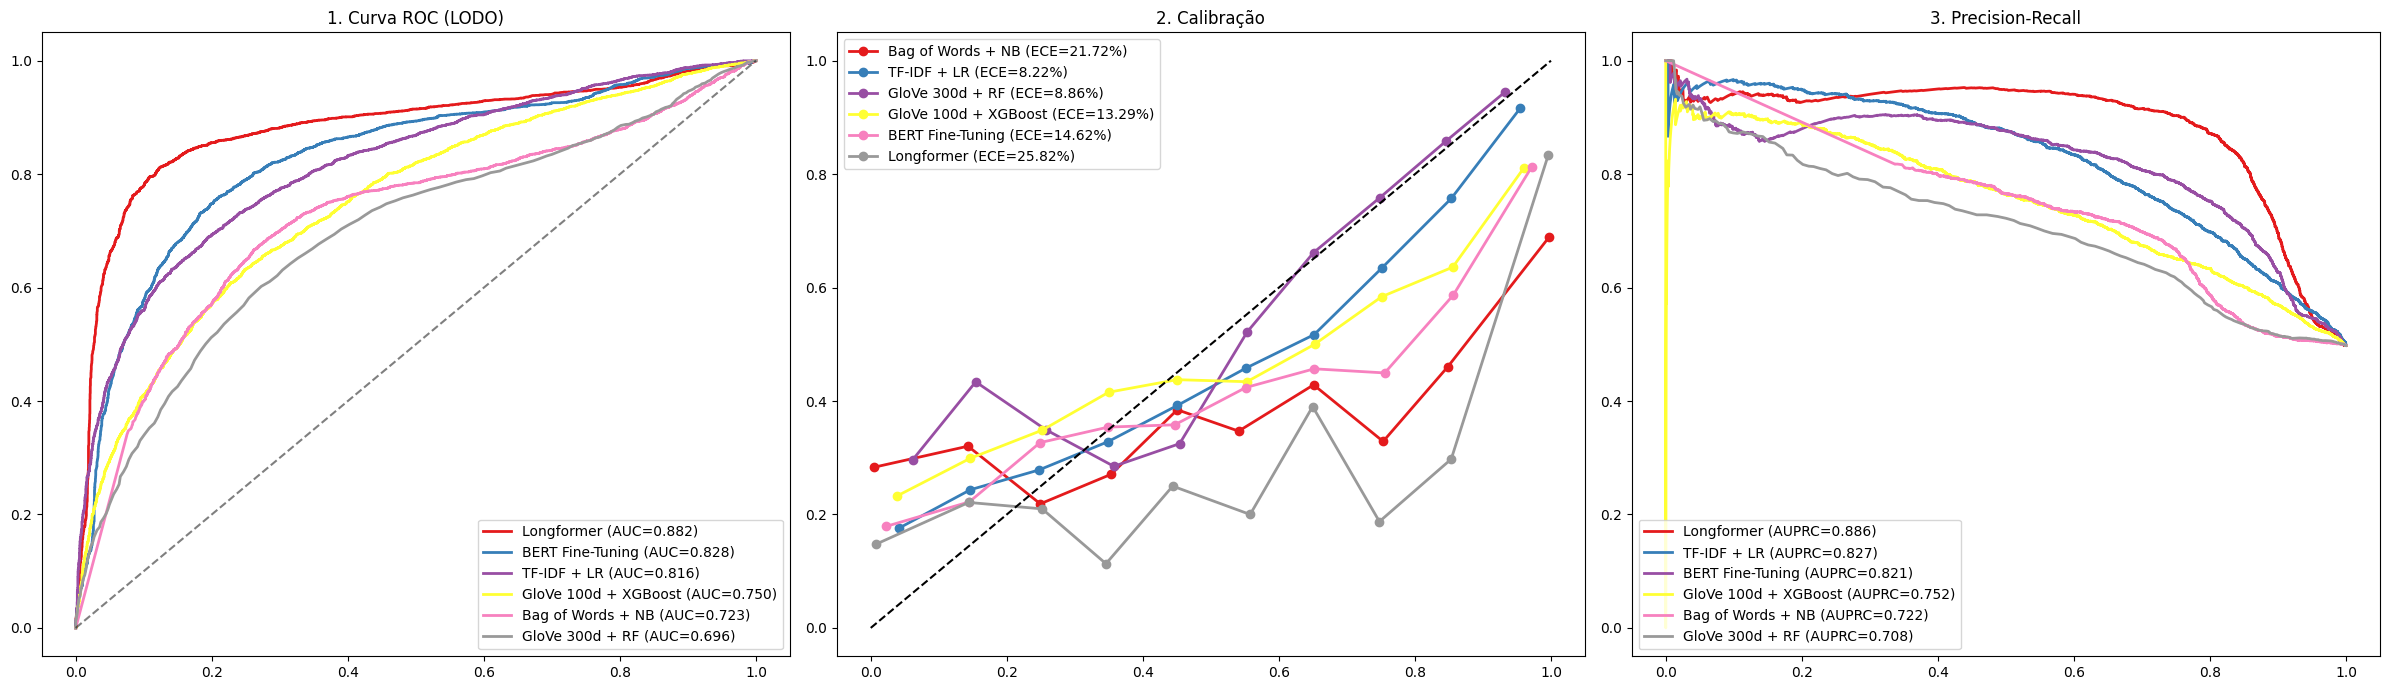


🔍 ANÁLISE DE CUSTO (Exemplo)
Analisando modelo: Longformer
Limiar Otimizado (Custo FN=5, FP=1): 0.9899

🎉 ANÁLISE CONCLUÍDA!


In [47]:
# ==========================================================
# 13. ANÁLISE DE RESULTADOS (LODO) - AGREGADA COM TODAS AS MÉTRICAS
# ==========================================================
#
# Este script lê os dicionários 'resultados_lodo' e 'pipelines_lodo'
# e calcula as métricas finais, incluindo:
# - Acurácia, Acurácia Balanceada, F1-Macro, AUROC, AUPRC, MCC
# - Calibração (Brier, ECE)
# - Intervalos de Confiança (Bootstrap)
#
# Correções incluídas:
# - Normalização das probabilidades para 1D (classe positiva) com 'to_pos_proba'
#   para evitar erros de shape (N, 2) → (N,)
#
# Dependências: numpy, pandas, scikit-learn, matplotlib, seaborn
# Variáveis esperadas: 'resultados_lodo', 'pipelines_lodo', 'data'
# ==========================================================

import numpy as np
import pandas as pd
from sklearn.metrics import (
    roc_curve, auc, roc_auc_score,
    precision_recall_curve, average_precision_score,
    brier_score_loss, f1_score, accuracy_score,
    matthews_corrcoef, balanced_accuracy_score,
    log_loss
)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.style.use('default')  # Forçar tema claro

print("=" * 60)
print(" 📊 ANÁLISE AGREGADA LODO (COM TODAS AS MÉTRICAS) 📊")
print("=" * 60)

# ================================================
# 1. FUNÇÕES AUXILIARES
# ================================================

def bootstrap_metrics(y_true, y_pred, y_proba, n_bootstraps=1000, seed=42):
    """
    Calcula CIs de 95% para F1-Macro e AUPRC via bootstrap.
    Retorna: (f1_ci_low, f1_ci_high), (auprc_ci_low, auprc_ci_high)
    """
    rng = np.random.RandomState(seed)
    f1_scores = []
    auprc_scores = []

    for _ in range(n_bootstraps):
        try:
            indices = rng.randint(0, len(y_true), len(y_true))
            # Garante que há ao menos duas classes no bootstrap
            if len(np.unique(y_true[indices])) < 2:
                continue

            f1 = f1_score(y_true[indices], y_pred[indices], average='macro', zero_division=0)
            auprc = average_precision_score(y_true[indices], y_proba[indices])

            f1_scores.append(f1)
            auprc_scores.append(auprc)
        except Exception:
            continue

    f1_ci = np.percentile(f1_scores, [2.5, 97.5]) if f1_scores else [0.0, 0.0]
    auprc_ci = np.percentile(auprc_scores, [2.5, 97.5]) if auprc_scores else [0.0, 0.0]
    return f1_ci, auprc_ci

def to_pos_proba(arr):
    """
    Normaliza probabilidades para um vetor 1D da classe positiva.
    - Se arr for (N, 2): retorna arr[:, 1]
    - Se arr for 1D: retorna arr.ravel()
    - Caso diferente: tenta squeeze/ravel como fallback
    """
    a = np.asarray(arr)
    if a.ndim == 2:
        if a.shape[1] >= 2:
            return a[:, 1]
        return np.squeeze(a)
    return a.ravel()

# ================================================
# 2. PROCESSAMENTO E AGREGAÇÃO DOS RESULTADOS
# ================================================

# Mapeamento de nomes (inclui Longformer explicitamente)
model_name_mapping = {
    'NaiveBayes': 'Bag of Words + NB',
    'LogisticRegression': 'TF-IDF + LR',
    'RandomForest': 'GloVe 300d + RF',
    'XGBoost': 'GloVe 100d + XGBoost',
    'BERT': 'BERT Fine-Tuning',
    'Longformer': 'Longformer'
}

roc_data_to_plot = {}
calibration_data_to_plot = {}
pr_data_to_plot = {}
final_metrics_summary = {}
aggregated_y_true_global = None

if 'resultados_lodo' not in locals():
    print("❌ ERRO: 'resultados_lodo' não encontrado. Rode a Seção 5 primeiro.")
else:
    # Itera sobre as chaves mapeadas (evita sujeira no dict)
    for model_key in model_name_mapping.keys():
        # Presença de resultados
        has_deep_results = (model_key in resultados_lodo and resultados_lodo[model_key])
        has_pipeline_results = ('pipelines_lodo' in locals() and model_key in pipelines_lodo)

        if not has_deep_results and not has_pipeline_results:
            continue  # Pula silenciosamente modelos ausentes

        model_name = model_name_mapping.get(model_key, model_key)
        print(f"\n--- Processando: {model_name} ---")

        try:
            aggregated_y_true = []
            aggregated_y_pred = []
            aggregated_y_proba = []

            # --- CASO 1: Deep Learning (BERT / Longformer) ---
            if has_deep_results and (model_key == 'BERT' or model_key == 'Longformer'):
                results_list = resultados_lodo[model_key]
                first_res = results_list[0]

                # Probabilidades → normaliza para 1D (classe positiva)
                if 'probabilities' in first_res:
                    probs_list = [to_pos_proba(res['probabilities']) for res in results_list]
                    print("   ✅ Probabilidades carregadas (chave 'probabilities' → pos_class).")
                elif 'y_proba' in first_res:
                    probs_list = [to_pos_proba(res['y_proba']) for res in results_list]
                    print("   ✅ Probabilidades carregadas (chave 'y_proba' → pos_class).")
                else:
                    print(f"   ❌ ERRO: Nenhuma chave de probabilidade encontrada para {model_key}.")
                    continue

                aggregated_y_proba = np.concatenate(probs_list)

                # Labels reais
                key_true = 'true_labels' if 'true_labels' in first_res else 'y_true'
                aggregated_y_true = np.concatenate([res[key_true] for res in results_list])

                # Predições discretas
                key_pred = 'predictions' if 'predictions' in first_res else 'y_pred'
                aggregated_y_pred = np.concatenate([res[key_pred] for res in results_list])

            # --- CASO 2: Modelos Scikit-Learn/XGBoost (recalcula no teste) ---
            elif has_pipeline_results:
                print(f"   Recalculando probabilidades para {model_name}...")
                pipeline_folds = pipelines_lodo[model_key]

                # Descobrir nomes de colunas de forma robusta (se necessário)
                text_col = 'text_clean' if 'text_clean' in data.columns else ('text' if 'text' in data.columns else None)
                label_col = 'label' if 'label' in data.columns else ('target' if 'target' in data.columns else None)
                ds_col = 'source_dataset' if 'source_dataset' in data.columns else ('dataset' if 'dataset' in data.columns else None)
                if text_col is None or label_col is None or ds_col is None:
                    raise KeyError("Colunas esperadas não encontradas em 'data' (necessário text_clean/text, label/target, source_dataset/dataset).")

                datasets_origem = data[ds_col].unique()

                temp_true, temp_pred, temp_proba = [], [], []
                for fold_name in datasets_origem:
                    if fold_name not in pipeline_folds:
                        continue

                    pipeline = pipeline_folds[fold_name]
                    mascara_teste = (data[ds_col] == fold_name)
                    X_test_fold = data.loc[mascara_teste, text_col]
                    y_test_fold = data.loc[mascara_teste, label_col]

                    # Probabilidades 2D → normaliza para 1D da classe positiva
                    fold_proba_2d = pipeline.predict_proba(X_test_fold)
                    fold_proba = to_pos_proba(fold_proba_2d)
                    fold_pred = pipeline.predict(X_test_fold)

                    temp_proba.extend(fold_proba)
                    temp_true.extend(y_test_fold)
                    temp_pred.extend(fold_pred)

                aggregated_y_proba = np.array(temp_proba)
                aggregated_y_true = np.array(temp_true)
                aggregated_y_pred = np.array(temp_pred)

            # --- Validações de tamanho ---
            if len(aggregated_y_proba) == 0:
                print(f"   ⚠️ Aviso: Sem dados para {model_name}.")
                continue

            if len(aggregated_y_proba) != len(aggregated_y_true):
                print(f"   ❌ Erro de tamanho (y_true: {len(aggregated_y_true)}, y_proba: {len(aggregated_y_proba)}). Pulando.")
                continue

            # Salva gabarito global (apenas uma vez)
            if aggregated_y_true_global is None:
                aggregated_y_true_global = aggregated_y_true

            # ================================================
            # 3. CÁLCULO DE TODAS AS MÉTRICAS
            # ================================================

            # Métricas baseadas em predição
            bal_acc = balanced_accuracy_score(aggregated_y_true, aggregated_y_pred)
            mcc = matthews_corrcoef(aggregated_y_true, aggregated_y_pred)
            f1_macro = f1_score(aggregated_y_true, aggregated_y_pred, average='macro', zero_division=0)

            # Métricas baseadas em probabilidade
            auroc = roc_auc_score(aggregated_y_true, aggregated_y_proba)
            auprc = average_precision_score(aggregated_y_true, aggregated_y_proba)
            brier = brier_score_loss(aggregated_y_true, aggregated_y_proba)
            prob_true, prob_pred = calibration_curve(aggregated_y_true, aggregated_y_proba, n_bins=10, strategy='uniform')
            ece = np.mean(np.abs(prob_true - prob_pred)) * 100
            nll = log_loss(aggregated_y_true, aggregated_y_proba)

            # Bootstrap (CIs)
            print("   Calculando Intervalos de Confiança...")
            f1_ci, auprc_ci = bootstrap_metrics(aggregated_y_true, aggregated_y_pred, aggregated_y_proba)

            # Guarda métricas
            final_metrics_summary[model_name] = {
                'F1-Score (Macro)': f1_macro,
                'F1 CI (95%)': f"[{f1_ci[0]:.3f}, {f1_ci[1]:.3f}]",
                'AUPRC': auprc,
                'AUPRC CI (95%)': f"[{auprc_ci[0]:.3f}, {auprc_ci[1]:.3f}]",
                'AUROC': auroc,
                'Acc Balanç.': bal_acc,
                'MCC': mcc,
                'NLL (Log-Loss) (↓)': nll,
                'Brier (↓)': brier,
                'ECE (↓) %': ece
            }

            # Dados para gráficos
            fpr, tpr, _ = roc_curve(aggregated_y_true, aggregated_y_proba)
            precision, recall, thresholds_pr = precision_recall_curve(aggregated_y_true, aggregated_y_proba)

            roc_data_to_plot[model_name] = {'fpr': fpr, 'tpr': tpr, 'auroc': auroc, 'y_proba': aggregated_y_proba}
            calibration_data_to_plot[model_name] = {'prob_true': prob_true, 'prob_pred': prob_pred}
            pr_data_to_plot[model_name] = {'precision': precision, 'recall': recall, 'thresholds': thresholds_pr, 'auprc': auprc}

            print(f"   ✅ Métricas: F1={f1_macro:.4f}, AUPRC={auprc:.4f}, MCC={mcc:.4f}")

        except Exception as e:
            print(f"   ❌ Erro crítico ao processar {model_name}: {e}")
            import traceback
            traceback.print_exc()

# ================================================
# 4. EXIBIÇÃO DE TABELA E GRÁFICOS
# ================================================
print("\n" + "=" * 80)
print("📊 TABELA DE MÉTRICAS AVANÇADAS (LODO)")
print("=" * 80)

if final_metrics_summary:
    summary_cal_df = pd.DataFrame.from_dict(final_metrics_summary, orient='index')
    summary_cal_df.index.name = "Modelo"
    # Ordena por F1 Macro (desc)
    if 'F1-Score (Macro)' in summary_cal_df.columns:
        summary_cal_df = summary_cal_df.sort_values('F1-Score (Macro)', ascending=False)

    column_order = [
        'F1-Score (Macro)', 'F1 CI (95%)', 'AUPRC', 'AUPRC CI (95%)',
        'AUROC', 'Acc Balanç.', 'MCC', 'NLL (Log-Loss) (↓)', 'Brier (↓)', 'ECE (↓) %'
    ]
    cols_to_use = [c for c in column_order if c in summary_cal_df.columns]
    summary_cal_df = summary_cal_df[cols_to_use]

    try:
        print(summary_cal_df.to_markdown(floatfmt=".4f"))
    except ImportError:
        print(summary_cal_df.to_string(float_format=lambda x: f"{x:.4f}"))

    # Gráficos: ROC, Calibração, PR
    print(f"\n📊 Gerando gráficos de diagnóstico (3-em-1)...")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 7))
    colors = plt.cm.Set1(np.linspace(0, 1, max(1, len(roc_data_to_plot))))

    # 1) ROC
    sorted_roc = sorted(roc_data_to_plot.items(), key=lambda x: x[1]['auroc'], reverse=True)
    for i, (m_name, d) in enumerate(sorted_roc):
        ax1.plot(d['fpr'], d['tpr'], color=colors[i], lw=2, label=f"{m_name} (AUC={d['auroc']:.3f})")
    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax1.set_title("1. Curva ROC (LODO)")
    ax1.legend(loc="lower right")

    # 2) Calibração
    for i, (m_name, d) in enumerate(calibration_data_to_plot.items()):
        ece_v = final_metrics_summary[m_name]['ECE (↓) %']
        ax2.plot(d['prob_pred'], d['prob_true'], marker='o', lw=2, color=colors[i], label=f"{m_name} (ECE={ece_v:.2f}%)")
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set_title("2. Calibração")
    ax2.legend(loc="upper left")

    # 3) PR Curve
    sorted_pr = sorted(pr_data_to_plot.items(), key=lambda x: final_metrics_summary[x[0]]['AUPRC'], reverse=True)
    for i, (m_name, d) in enumerate(sorted_pr):
        ax3.plot(d['recall'], d['precision'], lw=2, color=colors[i], label=f"{m_name} (AUPRC={d['auprc']:.3f})")
    ax3.set_title("3. Precision-Recall")
    ax3.legend(loc="lower left")

    plt.tight_layout()
    plt.show()

    # --- Exemplo de análise de custo (opcional) ---
    print("\n" + "=" * 80)
    print("🔍 ANÁLISE DE CUSTO (Exemplo)")
    try:
        best_model = summary_cal_df.index[0]
        print(f"Analisando modelo: {best_model}")

        if best_model in pr_data_to_plot and best_model in roc_data_to_plot and aggregated_y_true_global is not None:
            y_proba = roc_data_to_plot[best_model]['y_proba']
            thresholds = np.linspace(0, 1, 100)
            costs = []
            for thresh in thresholds:
                y_pred_t = (y_proba >= thresh).astype(int)
                # Ex.: custo FN=5, FP=1
                fp = np.sum((aggregated_y_true_global == 1) & (y_pred_t == 0))
                fn = np.sum((aggregated_y_true_global == 0) & (y_pred_t == 1))
                costs.append(fp * 1 + fn * 5)

            best_t = thresholds[np.argmin(costs)]
            print(f"Limiar Otimizado (Custo FN=5, FP=1): {best_t:.4f}")
    except Exception as e:
        print(f"Erro na análise de custo: {e}")

else:
    print("❌ Nenhum resultado válido para exibir.")

print("\n🎉 ANÁLISE CONCLUÍDA!")

# Analise de Curva de Aprendizagem

In [31]:
# ==========================================================
# 14. EXPERIMENTO EXTRA: ANÁLISE DE CURVA DE APRENDIZADO (OTIMIZADO E CORRIGIDO)
# ==========================================================
import gc
import time
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.base import clone

# HF
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    LongformerTokenizer, LongformerForSequenceClassification,
    TrainingArguments, Trainer
)

print("🚀 Iniciando Análise de Curva de Aprendizado (Versão Corrigida)...")

# ==========================================================
# 🚫 DESABILITAR MLflow AUTLOGGING (CAUSA DOS BUGS)
# ==========================================================
import mlflow
mlflow.autolog(disable=True)
mlflow.sklearn.autolog(disable=True)
mlflow.xgboost.autolog(disable=True)

print("⚠️ MLflow Autologging DESATIVADO.")

# ==========================================================
# Funções auxiliares
# ==========================================================
def remap_optuna_params(optuna_params, pipeline_type='text'):
    if optuna_params is None:
        return {}

    vec_keys = ['ngram_range', 'max_features']
    mapped = {}

    for k, v in optuna_params.items():
        if pipeline_type == 'text' and k in vec_keys:
            mapped[f"vectorizer__{k}"] = v
        else:
            mapped[f"model__{k}"] = v

    return mapped


def compute_metrics_hf(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

# ==========================================================
# 2. CONFIGURAÇÃO DO EXPERIMENTO
# ==========================================================
train_fractions = [0.1, 0.3, 0.5, 0.8, 1.0]

if "X_opt" not in locals():
    print("❌ ERRO: 'X_opt' e 'y_opt' não existem.")
    raise SystemExit
else:
    print("✔️ Dados encontrados.")

# ==========================================================
# 3. Split de treino/teste
# ==========================================================
X_train_lc, X_test_lc, y_train_lc, y_test_lc = train_test_split(
    X_opt, y_opt, test_size=0.2, random_state=142857, stratify=y_opt
)

print(f"   - Dataset de Treino: {len(y_train_lc)}")
print(f"   - Dataset de Teste : {len(y_test_lc)}")

# Corrigir indexações
X_train_lc = pd.Series(X_train_lc).reset_index(drop=True)
X_test_lc = pd.Series(X_test_lc).reset_index(drop=True)
y_train_lc = pd.Series(y_train_lc).reset_index(drop=True)
y_test_lc = pd.Series(y_test_lc).reset_index(drop=True)

learning_curve_results = []

try:

    # ==========================================================
    # 4. PRÉ‑VETORIZAÇÃO — FEITA UMA ÚNICA VEZ
    # ==========================================================
    print("\n--- [BLOCO 1/3] Pré-vetorização GloVe ---")

    rf_pipe_base = clone(pipelines_lodo["RandomForest"][datasets_origem[0]])
    xgb_pipe_base = clone(pipelines_lodo["XGBoost"][datasets_origem[0]])

    vectorizer_rf = rf_pipe_base.named_steps["vectorizer"]
    vectorizer_xgb = xgb_pipe_base.named_steps["vectorizer"]

    print("   → Vetorizando RF...")
    X_train_vec_rf = vectorizer_rf.transform(X_train_lc.tolist())
    X_test_vec_rf = vectorizer_rf.transform(X_test_lc.tolist())

    print("   → Vetorizando XGB...")
    X_train_vec_xgb = vectorizer_xgb.transform(X_train_lc.tolist())
    X_test_vec_xgb = vectorizer_xgb.transform(X_test_lc.tolist())

    print("✅ Pré-vetorização concluída.")

    # ==========================================================
    # 5. MODELOS SKLEARN — CURVA DE APRENDIZADO
    # ==========================================================
    print("\n--- [BLOCO 2/3] Modelos ML (Sklearn) ---")

    nb_pipe_base = clone(pipelines_lodo["NaiveBayes"][datasets_origem[0]])
    lr_pipe_base = clone(pipelines_lodo["LogisticRegression"][datasets_origem[0]])

    rf_model_base = rf_pipe_base.named_steps["model"]
    xgb_model_base = xgb_pipe_base.named_steps["model"]

    # Optuna params
    if "optimized_params" in locals():
        print("   Aplicando parâmetros otimizados (Optuna)...")
        nb_pipe_base.set_params(**remap_optuna_params(optimized_params.get("NaiveBayes")))
        lr_pipe_base.set_params(**remap_optuna_params(optimized_params.get("LogisticRegression")))
        rf_model_base.set_params(**optimized_params.get("RandomForest", {}))
        xgb_model_base.set_params(**optimized_params.get("XGBoost", {}))

    # Modelos organizados
    models_to_test = {
        "Bag of Words + NB": (nb_pipe_base, X_train_lc, y_train_lc, X_test_lc, y_test_lc),
        "TF-IDF + LR": (lr_pipe_base, X_train_lc, y_train_lc, X_test_lc, y_test_lc),
        "GloVe 300d + RF": (rf_model_base, X_train_vec_rf, y_train_lc, X_test_vec_rf, y_test_lc),
        "GloVe 100d + XGBoost": (xgb_model_base, X_train_vec_xgb, y_train_lc, X_test_vec_xgb, y_test_lc)
    }

    for frac in train_fractions:
        print(f"\n--- Treinando ML com {frac*100:.0f}% dos dados ---")
        for model_name, (model_base, X_full, y_full, X_test_full, y_test_full) in models_to_test.items():

            n_samples = int(len(y_full) * frac)
            if n_samples < 50:
                continue

            # Subset seguro
            if isinstance(X_full, pd.Series):
                subset_idx = X_full.sample(n_samples, random_state=42).index
                X_train_sub = X_full.loc[subset_idx]
                y_train_sub = y_full.loc[subset_idx]
            else:
                rng = np.random.default_rng(42)
                subset_idx = rng.choice(X_full.shape[0], size=n_samples, replace=False)
                X_train_sub = X_full[subset_idx]
                y_train_sub = y_full.iloc[subset_idx]

            model = clone(model_base)

            start = time.time()
            model.fit(X_train_sub, y_train_sub)
            y_pred = model.predict(X_test_full)

            f1 = f1_score(y_test_full, y_pred, average="macro")
            acc = accuracy_score(y_test_full, y_pred)

            learning_curve_results.append({
                "Modelo": model_name,
                "Fração de Treino (%)": int(frac * 100),
                "Tamanho do Treino": n_samples,
                "F1-Score (Macro)": f1,
                "Acurácia": acc,
                "Tempo (s)": time.time() - start
            })

            print(f"   > {model_name}: F1={f1:.4f}")

            del model
            gc.collect()

    # ==========================================================
    # 6. BERT — CURVA DE APRENDIZADO
    # ==========================================================
    print("\n--- [BLOCO 2/3] BERT Fine-Tuning ---")

    MODEL_NAME_BERT = "distilbert-base-uncased"
    tokenizer_bert = AutoTokenizer.from_pretrained(MODEL_NAME_BERT)

    df_train = pd.DataFrame({"text": X_train_lc, "label": y_train_lc})
    df_test = pd.DataFrame({"text": X_test_lc, "label": y_test_lc})

    hf_train = Dataset.from_pandas(df_train)
    hf_test = Dataset.from_pandas(df_test)

    def tok_bert(batch):
        # 🎯 OTIMIZAÇÃO: Reduzir max_length (ex: 192) pode acelerar muito o treino
        #                se seus textos forem mais curtos que 256.
        return tokenizer_bert(
            batch["text"], padding="max_length",
            truncation=True, max_length=256
        )

    hf_train_tok = hf_train.map(tok_bert, batched=True)
    hf_test_tok = hf_test.map(tok_bert, batched=True)

    bert_params = optimized_params.get("BERT", {"learning_rate": 2e-5, "batch_size": 16})

    for frac in train_fractions:
        n_samples = int(len(hf_train_tok) * frac)
        if n_samples < 50:
            continue

        print(f"\n--- BERT com {frac*100:.0f}% ({n_samples} amostras) ---")

        train_subset = hf_train_tok.shuffle(seed=42).select(range(n_samples))

        model = AutoModelForSequenceClassification.from_pretrained(
            MODEL_NAME_BERT, num_labels=2
        )

        args = TrainingArguments(
            output_dir="./bert_lc",
            num_train_epochs=1,
            per_device_train_batch_size=bert_params["batch_size"],
            learning_rate=bert_params["learning_rate"],
            evaluation_strategy="no",
            save_strategy="no",
            report_to="none",
            # ✅ CORREÇÃO: Habilitar a barra de progresso para ver o status
            disable_tqdm=False, 
            fp16=torch.cuda.is_available()
        )

        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=train_subset,
            compute_metrics=compute_metrics_hf
        )

        start = time.time()
        trainer.train()

        pred = trainer.predict(hf_test_tok)
        y_pred = pred.predictions.argmax(-1)

        f1 = f1_score(y_test_lc, y_pred, average="macro")
        acc = accuracy_score(y_test_lc, y_pred)

        learning_curve_results.append({
            "Modelo": "BERT Fine-Tuning",
            "Fração de Treino (%)": int(frac * 100),
            "Tamanho do Treino": n_samples,
            "F1-Score (Macro)": f1,
            "Acurácia": acc,
            "Tempo (s)": time.time() - start
        })

        del model, trainer
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # ==========================================================
    # 7. LONGFORMER — CURVA DE APRENDIZADO
    # ==========================================================
    print("\n--- [BLOCO 3/3] Longformer ---")

    # 🧹 OTIMIZAÇÃO (RAM): Limpar os datasets tokenizados do BERT 
    #                     antes de criar os do Longformer.
    print("   > Limpando datasets tokenizados do BERT (RAM)...")
    del hf_train_tok, hf_test_tok
    gc.collect()
    

    MODEL_NAME_LF = "allenai/longformer-base-4096"
    tokenizer_lf = LongformerTokenizer.from_pretrained(MODEL_NAME_LF)

    def tok_lf(batch):
        # 🎯 OTIMIZAÇÃO: Reduzir max_length (ex: 256) pode acelerar muito o treino
        #                se seus textos forem mais curtos que 512.
        out = tokenizer_lf(
            batch["text"],
            padding="max_length",
            truncation=True,
            max_length=512 
        )
        out["global_attention_mask"] = [
            [1] + [0]*(len(a)-1) for a in out["input_ids"]
        ]
        return out

    hf_train_lf = hf_train.map(tok_lf, batched=True)
    hf_test_lf = hf_test.map(tok_lf, batched=True)

    lf_params = optimized_params.get("Longformer", {"learning_rate": 2e-5, "batch_size": 4})

    for frac in train_fractions:
        n_samples = int(len(hf_train_lf) * frac)
        if n_samples < 50:
            continue

        print(f"\n--- Longformer com {frac*100:.0f}% ({n_samples} amostras) ---")

        train_subset = hf_train_lf.shuffle(seed=42).select(range(n_samples))

        model = LongformerForSequenceClassification.from_pretrained(
            MODEL_NAME_LF, num_labels=2, attention_window=256
        )

        args = TrainingArguments(
            output_dir="./lf_lc",
            num_train_epochs=1,
            # 🎯 OTIMIZAÇÃO: Ajuste VRAM vs Velocidade.
            # Se tiver VRAM, tente batch=8 e accumulation=2 (pode ser mais rápido).
            per_device_train_batch_size=lf_params["batch_size"], # ex: 4
            gradient_accumulation_steps=4,                      # ex: 4 (Batch Efetivo = 16)
            learning_rate=lf_params["learning_rate"],
            evaluation_strategy="no",
            save_strategy="no",
            report_to="none",
            # ✅ CORREÇÃO: Habilitar a barra de progresso para ver o status
            disable_tqdm=False,
            fp16=torch.cuda.is_available()
        )

        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=train_subset,
            compute_metrics=compute_metrics_hf,
            tokenizer=tokenizer_lf
        )

        start = time.time()
        trainer.train()

        pred = trainer.predict(hf_test_lf)
        y_pred = pred.predictions.argmax(-1)

        f1 = f1_score(y_test_lc, y_pred, average="macro")
        acc = accuracy_score(y_test_lc, y_pred)

        learning_curve_results.append({
            "Modelo": "Longformer",
            "Fração de Treino (%)": int(frac * 100),
            "Tamanho do Treino": n_samples,
            "F1-Score (Macro)": f1,
            "Acurácia": acc,
            "Tempo (s)": time.time() - start
        })

        del model, trainer
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # ==========================================================
    # 8. PLOT
    # ==========================================================
    print("\n📊 Plotando curvas...")
    lc_df = pd.DataFrame(learning_curve_results)

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=lc_df, x="Tamanho do Treino", y="F1-Score (Macro)",
        hue="Modelo", style="Modelo", markers=True, linewidth=2.5
    )
    plt.title("Curvas de Aprendizado — F1 vs Nº de Amostras")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


except Exception as e:
    print(f"❌ ERRO: {e}")
    import traceback
    traceback.print_exc()

🚀 Iniciando Análise de Curva de Aprendizado (Versão Corrigida)...
⚠️ MLflow Autologging DESATIVADO.
✔️ Dados encontrados.
   - Dataset de Treino: 2547
   - Dataset de Teste : 637

--- [BLOCO 1/3] Pré-vetorização GloVe ---
❌ ERRO: 'RandomForest'


Traceback (most recent call last):
  File "C:\Users\fhigh\AppData\Local\Temp\ipykernel_42284\3590958681.py", line 99, in <module>
    rf_pipe_base = clone(pipelines_lodo["RandomForest"][datasets_origem[0]])
                         ~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^
KeyError: 'RandomForest'


# Meta-Learner Stacking e Calibration

 🚀 INICIANDO EXPERIMENTO DE META-LEARNING (STACKING c/ Longformer) 🚀
🔍 Preparando meta-dataset a partir das probabilidades do LODO...
 ℹ️  Tamanho de gabarito (y_meta) detectado: 7653 amostras.
   ✅ Adicionando feature: BERT Fine-Tuning (Tamanho: 7653)
   ✅ Adicionando feature: Longformer (Tamanho: 7653)

📊 Meta-Dataset criado com sucesso.
   - Features (X_meta): (7653, 2) (Amostras, 2 Modelos)
   - Gabarito (y_meta): (7653,)

   Avaliando Meta-Learners (usando cross_val_predict)...

 📊 RESULTADOS DO META-LEARNER (COM Longformer) 📊
| Modelo Stacking                |   Acurácia |   F1-Score (Macro) |   NLL (Log-Loss) (↓) |   Brier Score (↓) |   ECE (↓) % |
|:-------------------------------|-----------:|-------------------:|---------------------:|------------------:|------------:|
| Meta-Learner (LR Padrão)       |     0.8286 |             0.8285 |               0.4346 |            0.1340 |      3.6957 |
| Meta-Learner (LR + Calibração) |     0.8325 |             0.8325 |               0

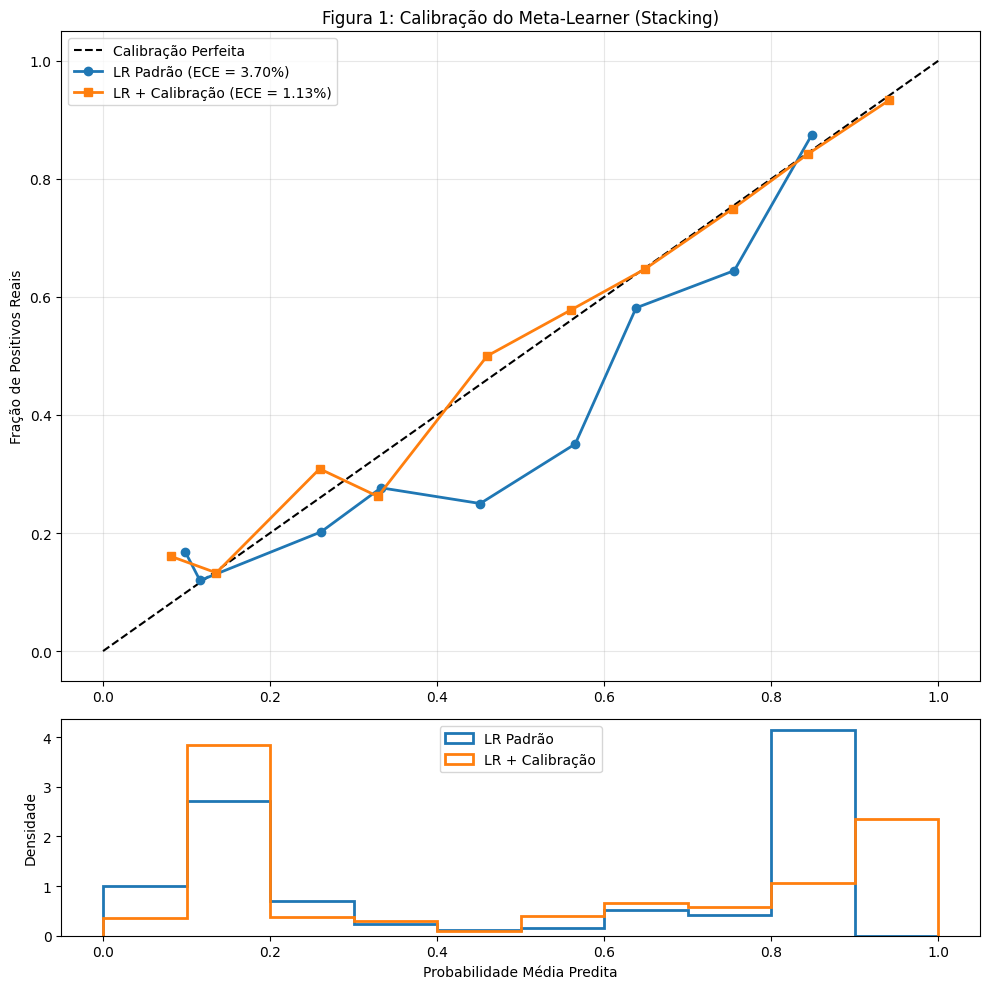


🎉 ANÁLISE DE STACKING (COM Longformer) CONCLUÍDA!


In [33]:
# ==========================================================
# 15. META-LEARNER (STACKING) - ATUALIZADO COM Longformer
# ==========================================================
#
# Este script agora usa as probabilidades de TODOS os 5 modelos
# (incluindo o Longformer) para treinar o meta-modelo.
#
# ==========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import (
    log_loss, brier_score_loss, roc_auc_score, 
    f1_score, accuracy_score
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

print("="*60)
print(" 🚀 INICIANDO EXPERIMENTO DE META-LEARNING (STACKING c/ Longformer) 🚀")
print("="*60)

# --- 1. Preparar o Meta-Dataset ---
print("🔍 Preparando meta-dataset a partir das probabilidades do LODO...")

if 'roc_data_to_plot' not in locals() or 'aggregated_y_true_global' not in locals():
    print("❌ ERRO: 'roc_data_to_plot' ou 'aggregated_y_true_global' não encontrados.")
    print("   Execute a Seção 8 (AUROC) primeiro.")
else:
    feature_names = []
    meta_features = []
    
    # O gabarito é a nossa "fonte da verdade" para o tamanho
    y_meta = aggregated_y_true_global
    target_length = len(y_meta)
    print(f" ℹ️  Tamanho de gabarito (y_meta) detectado: {target_length} amostras.")
    
    # Pegar as probabilidades salvas de cada modelo
    # (O 'roc_data_to_plot' já tem as probas de todos os 5)
    for model_name, data_roc in roc_data_to_plot.items():
        if 'y_proba' in data_roc:
            
            # --- INÍCIO DA CORREÇÃO ---
            proba_len = len(data_roc['y_proba'])
            
            # AQUI ESTÁ A VERIFICAÇÃO: O array de probas tem o mesmo tamanho do gabarito?
            if proba_len == target_length:
                print(f"   ✅ Adicionando feature: {model_name} (Tamanho: {proba_len})")
                feature_names.append(model_name)
                # Assumimos que 'y_proba' já é 1D (proba da classe 1) ou 2D (N, 2)
                # Se for 2D, pegamos a coluna 1. Se já for 1D, não faz mal.
                # Para garantir consistência, vamos usar apenas a proba da classe 1
                
                if data_roc['y_proba'].ndim == 2:
                    meta_features.append(data_roc['y_proba'][:, 1])
                else:
                    # Se já for 1D (shape N,), apenas adiciona
                    meta_features.append(data_roc['y_proba'])
            
            else:
                # Esta é a causa do erro.
                print(f"   ❌ PULANDO feature: {model_name}. Tamanho incompatível.")
                print(f"     (Esperado: {target_length}, Encontrado: {proba_len})")
                print(f"     (Verifique se o LODO da Seção 5-7 foi executado para este modelo)")
            # --- FIM DA CORREÇÃO ---
            
        else:
            print(f"   ⚠️ Aviso: {model_name} não tem 'y_proba'. Pulando.")
            
    
    if len(meta_features) < 2:
        print("\n❌ ERRO: Menos de 2 modelos válidos foram encontrados para o stacking.")
        print("   Certifique-se de que os LODO (Seções 5-7) e AUROC (Seção 8) foram executados para todos os modelos.")
    
    else:
        # Criar o X_meta (features) e y_meta (gabarito)
        X_meta = np.stack(meta_features, axis=1)
        
        print(f"\n📊 Meta-Dataset criado com sucesso.")
        print(f"   - Features (X_meta): {X_meta.shape} (Amostras, {len(feature_names)} Modelos)")
        print(f"   - Gabarito (y_meta): {y_meta.shape}")

        # --- 2. Definir os Modelos ---
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        meta_learner_lr = LogisticRegression(random_state=42)
        
        calibrated_meta_learner = CalibratedClassifierCV(
            meta_learner_lr,
            method='isotonic', # Calibração no meta-nível
            cv=skf
        )
        
        # --- 3. Avaliar Meta-Learners ---
        print("\n" + "="*60)
        print("   Avaliando Meta-Learners (usando cross_val_predict)...")
        
        # Usar cross_val_predict para obter predições 'out-of-sample'
        meta_probas_lr = cross_val_predict(meta_learner_lr, X_meta, y_meta, cv=skf, method='predict_proba')
        meta_preds_lr = np.argmax(meta_probas_lr, axis=1)
        
        meta_probas_calibrated = cross_val_predict(calibrated_meta_learner, X_meta, y_meta, cv=skf, method='predict_proba')
        meta_preds_calibrated = np.argmax(meta_probas_calibrated, axis=1)

        # ================================================
        # 4. REPORTAR MÉTRICAS (ECE, NLL, Brier)
        # ================================================
        print("\n" + "="*60)
        print(" 📊 RESULTADOS DO META-LEARNER (COM Longformer) 📊")
        print("="*60)

        def calculate_ece(y_true, y_proba, n_bins=10):
            # Corrige para o caso de y_proba ser 2D (N, 2)
            if y_proba.ndim == 2:
                y_proba = y_proba[:, 1]
            prob_true, prob_pred = calibration_curve(y_true, y_proba, n_bins=n_bins, strategy='uniform')
            # Evita divisão por zero se um bin estiver vazio
            bin_counts, _ = np.histogram(y_proba, bins=n_bins, range=(0, 1))
            valid_bins = bin_counts > 0
            bin_weights = bin_counts[valid_bins] / len(y_proba)
            
            # --- [INÍCIO DA CORREÇÃO] ---
            # bin_abs_diff = np.abs(prob_true[valid_bins] - prob_pred[valid_bins]) # LINHA INCORRETA
            bin_abs_diff = np.abs(prob_true - prob_pred) # LINHA CORRETA
            # --- [FIM DA CORREÇÃO] ---
            
            return np.sum(bin_weights * bin_abs_diff) * 100


        # --- Métricas do Modelo Padrão ---
        acc_lr = accuracy_score(y_meta, meta_preds_lr)
        f1_lr = f1_score(y_meta, meta_preds_lr, average='macro')
        nll_lr = log_loss(y_meta, meta_probas_lr) # NLL
        brier_lr = brier_score_loss(y_meta, meta_probas_lr[:, 1])
        ece_lr = calculate_ece(y_meta, meta_probas_lr)
        
        # --- Métricas do Modelo Calibrado ---
        acc_cal = accuracy_score(y_meta, meta_preds_calibrated)
        f1_cal = f1_score(y_meta, meta_preds_calibrated, average='macro')
        nll_cal = log_loss(y_meta, meta_probas_calibrated) # NLL
        brier_cal = brier_score_loss(y_meta, meta_probas_calibrated[:, 1])
        ece_cal = calculate_ece(y_meta, meta_probas_calibrated)

        # --- Criar Tabela de Resumo ---
        summary_data = {
            'Meta-Learner (LR Padrão)': {
                'Acurácia': acc_lr,
                'F1-Score (Macro)': f1_lr,
                'NLL (Log-Loss) (↓)': nll_lr,
                'Brier Score (↓)': brier_lr,
                'ECE (↓) %': ece_lr
            },
            'Meta-Learner (LR + Calibração)': {
                'Acurácia': acc_cal,
                'F1-Score (Macro)': f1_cal,
                'NLL (Log-Loss) (↓)': nll_cal,
                'Brier Score (↓)': brier_cal,
                'ECE (↓) %': ece_cal
            }
        }
        
        summary_df_meta = pd.DataFrame.from_dict(summary_data, orient='index')
        summary_df_meta.index.name = "Modelo Stacking"
        
        print(summary_df_meta.to_markdown(floatfmt=".4f"))
            
        # ================================================
        # 5. PLOT DE CALIBRAÇÃO FINAL
        # ================================================
        print("\n📊 Gerando gráfico de calibração do Meta-Learner (Reliability Diagram)...")
        with plt.style.context('default'): # Forçar tema claro
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 1]})
            
            ax1.plot([0, 1], [0, 1], 'k--', label='Calibração Perfeita')

            # Curva Padrão
            prob_true_lr, prob_pred_lr = calibration_curve(y_meta, meta_probas_lr[:, 1], n_bins=10, strategy='uniform')
            ax1.plot(prob_pred_lr, prob_true_lr, marker='o', linewidth=2,
                         label=f"LR Padrão (ECE = {ece_lr:.2f}%)")
            
            # Curva Calibrada
            prob_true_cal, prob_pred_cal = calibration_curve(y_meta, meta_probas_calibrated[:, 1], n_bins=10, strategy='uniform')
            ax1.plot(prob_pred_cal, prob_true_cal, marker='s', linewidth=2,
                         label=f"LR + Calibração (ECE = {ece_cal:.2f}%)")

            ax1.set_ylabel("Fração de Positivos Reais")
            ax1.set_title("Figura 1: Calibração do Meta-Learner (Stacking)")
            ax1.legend(loc="upper left")
            ax1.grid(True, alpha=0.3)

            # Histograma de Probabilidades
            ax2.hist(meta_probas_lr[:, 1], bins=10, histtype='step', lw=2, label='LR Padrão', density=True, range=(0,1))
            ax2.hist(meta_probas_calibrated[:, 1], bins=10, histtype='step', lw=2, label='LR + Calibração', density=True, range=(0,1))
            ax2.set_xlabel("Probabilidade Média Predita")
            ax2.set_ylabel("Densidade")
            ax2.legend(loc="upper center")
            
            plt.tight_layout()
            plt.show()

print("\n🎉 ANÁLISE DE STACKING (COM Longformer) CONCLUÍDA!")

# Benchmark intra dataset

## Modelos Clássicos

In [48]:
# ==========================================================
# 16. BENCHMARK INTRA-DATASET (BASELINE 80/20)
# ==========================================================
#
# Este script gera os resultados "intra-dataset" que o
# professor pediu para a Tabela 1.
#
# Ele usa o 'data_opt' (3 datasets) e faz um split 80/20
# para simular um benchmark padrão (não-LODO).
#
# ==========================================================

import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    roc_auc_score, average_precision_score, matthews_corrcoef, 
    balanced_accuracy_score, brier_score_loss
)
from sklearn.calibration import calibration_curve
from sklearn.base import clone 

print("🚀 Iniciando Benchmark Intra-Dataset (Baseline 80/20)...")

# ================================================
# 1. FUNÇÃO AUXILIAR DE MAPEAMENTO DE PARÂMETROS
# ================================================
# (Reutilizada da Seção 14)
def remap_optuna_params(optuna_params, pipeline_type='text'):
    vec_keys = ['ngram_range', 'max_features']
    mapped_params = {}
    if optuna_params is None: return mapped_params
    for key, value in optuna_params.items():
        if pipeline_type == 'text' and key in vec_keys:
            mapped_params[f'vectorizer__{key}'] = value
        else: 
            mapped_params[f'model__{key}'] = value
    return mapped_params

# ================================================
# 2. FUNÇÃO DE CÁLCULO DE ECE
# ================================================
def calculate_ece(y_true, y_proba, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_proba, n_bins=n_bins, strategy='uniform')
    return np.mean(np.abs(prob_true - prob_pred)) * 100

# ================================================
# 3. PREPARAR DADOS
# ================================================
if 'X_opt' not in locals():
    print("❌ 'X_opt' e 'y_opt' não encontrados. Pulando benchmark.")
    print("   Execute a Seção 9.1 primeiro.")
else:
    # Criar o split 80/20
    X_train_intra, X_test_intra, y_train_intra, y_test_intra = train_test_split(
        X_opt, y_opt, test_size=0.2, random_state=142857, stratify=y_opt
    )
    print(f"   - Dataset de Treino (Intra): {len(y_train_intra)}")
    print(f"   - Dataset de Teste (Intra):  {len(y_test_intra)}")

    baseline_results = {}
    
    # ================================================
    # 4. PEGAR E TREINAR OS PIPELINES
    # ================================================
    try:
        # Pega os pipelines NÃO TREINADOS
        nb_pipe_base = clone(pipelines_lodo['NaiveBayes'][datasets_origem[0]])
        lr_pipe_base = clone(pipelines_lodo['LogisticRegression'][datasets_origem[0]])
        rf_pipe_base = clone(pipelines_lodo['RandomForest'][datasets_origem[0]])
        xgb_pipe_base = clone(pipelines_lodo['XGBoost'][datasets_origem[0]])
        
        # Aplicar os parâmetros otimizados do Optuna
        if 'optimized_params' in locals():
            print("   ...Usando parâmetros otimizados do Optuna.")
            nb_params_mapped = remap_optuna_params(optimized_params.get('NaiveBayes'), 'text')
            lr_params_mapped = remap_optuna_params(optimized_params.get('LogisticRegression'), 'text')
            rf_params_mapped = remap_optuna_params(optimized_params.get('RandomForest'), 'embedding')
            xgb_params_mapped = remap_optuna_params(optimized_params.get('XGBoost'), 'embedding')
            
            nb_pipe_base.set_params(**nb_params_mapped)
            lr_pipe_base.set_params(**lr_params_mapped)
            rf_pipe_base.set_params(**rf_params_mapped)
            xgb_pipe_base.set_params(**xgb_params_mapped)

        models_to_test = {
            "Bag of Words + NB": nb_pipe_base,
            "TF-IDF + LR": lr_pipe_base,
            "GloVe 300d + RF": rf_pipe_base,
            "GloVe 100d + XGBoost": xgb_pipe_base
        }

        # ================================================
        # 5. EXECUTAR BENCHMARK
        # ================================================
        print("\n--- Treinando e Avaliando Modelos (Intra-Dataset) ---")
        
        for model_name, pipeline in models_to_test.items():
            print(f"   Processando: {model_name}...")
            
            # 1. Treinar no X_train_intra
            pipeline.fit(X_train_intra, y_train_intra)
            
            # 2. Testar no X_test_intra
            y_pred = pipeline.predict(X_test_intra)
            y_proba = pipeline.predict_proba(X_test_intra)[:, 1] # Probabilidade da Classe 1
            
            # 3. Calcular TODAS as métricas
            f1 = f1_score(y_test_intra, y_pred, average='macro')
            auprc = average_precision_score(y_test_intra, y_proba)
            ece = calculate_ece(y_test_intra, y_proba)
            
            baseline_results[model_name] = {
                'F1-Score (Macro)': f1,
                'AUPRC': auprc,
                'ECE (↓) %': ece
            }

        # ================================================
        # 6. TABELA DE COMPARAÇÃO (O QUE O PROFESSOR QUER)
        # ================================================
        print("\n" + "="*80)
        print("📊 TABELA 1: COMPARAÇÃO LODO (Cross-Dataset) vs. INTRA-DATASET (Baseline)")
        print("="*80)

        # Converter resultados do baseline
        df_baseline = pd.DataFrame.from_dict(baseline_results, orient='index')
        
        # Pegar os resultados LODO (calculados na Seção 8)
        df_lodo = pd.DataFrame.from_dict(final_metrics_summary, orient='index')
        
        # Juntar as tabelas
        df_compare = df_lodo.join(df_baseline, lsuffix=' (LODO)', rsuffix=' (Intra-Dataset)')
        
        # Selecionar e ordenar as colunas que o professor pediu
        cols_ordered = [
            'F1-Score (Macro) (Intra-Dataset)', 'F1-Score (Macro) (LODO)', 
            'AUPRC (Intra-Dataset)', 'AUPRC (LODO)',
            'ECE (↓) % (Intra-Dataset)', 'ECE (↓) % (LODO)'
        ]
        
        # Filtrar apenas os modelos que temos em ambos
        df_compare_final = df_compare.dropna(subset=cols_ordered)[cols_ordered]
        
        # Calcular a "Queda"
        df_compare_final['F1 Drop (%)'] = ((df_compare_final['F1-Score (Macro) (Intra-Dataset)'] - 
                                            df_compare_final['F1-Score (Macro) (LODO)']) / 
                                           df_compare_final['F1-Score (Macro) (Intra-Dataset)']) * 100

        print(df_compare_final.to_markdown(floatfmt=".4f"))
        
    except Exception as e:
        print(f"❌ Erro ao gerar Benchmark Intra-Dataset: {e}")
        print("   Certifique-se de que as Seções 4, 5 e 9 foram executadas.")

🚀 Iniciando Benchmark Intra-Dataset (Baseline 80/20)...
   - Dataset de Treino (Intra): 2547
   - Dataset de Teste (Intra):  637
   ...Usando parâmetros otimizados do Optuna.

--- Treinando e Avaliando Modelos (Intra-Dataset) ---
   Processando: Bag of Words + NB...
   Processando: TF-IDF + LR...
   Processando: GloVe 300d + RF...
    - Vetorizando 2547 textos (Dim: 300)...
    - Vetorizando 637 textos (Dim: 300)...
    - Vetorizando 637 textos (Dim: 300)...
   Processando: GloVe 100d + XGBoost...
    - Vetorizando 2547 textos (Dim: 100)...
    - Vetorizando 637 textos (Dim: 100)...
    - Vetorizando 637 textos (Dim: 100)...

📊 TABELA 1: COMPARAÇÃO LODO (Cross-Dataset) vs. INTRA-DATASET (Baseline)
|                      |   F1-Score (Macro) (Intra-Dataset) |   F1-Score (Macro) (LODO) |   AUPRC (Intra-Dataset) |   AUPRC (LODO) |   ECE (↓) % (Intra-Dataset) |   ECE (↓) % (LODO) |   F1 Drop (%) |
|:---------------------|-----------------------------------:|--------------------------:|----

## Modelos BERT

### Distilbert

In [49]:
# ==========================================================
# 16.2 BENCHMARK INTRA-DATASET (Baseline 80/20) - SOMENTE BERT
# ==========================================================

print("🚀 Iniciando Benchmark Intra-Dataset (SOMENTE BERT)...")

# ================================================
# 1. FUNÇÕES AUXILIARES (ECE e Métricas)
# ================================================
def calculate_ece(y_true, y_proba, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_proba, n_bins=n_bins, strategy='uniform')
    return np.mean(np.abs(prob_true - prob_pred)) * 100

def compute_metrics_baseline(pred):
    """Calcula métricas para o Trainer"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0) 
    acc = accuracy_score(labels, preds)
    return { 'accuracy': acc, 'f1_macro': f1 }

# ================================================
# 2. VERIFICAR DADOS
# ================================================
if 'X_train_lc' not in locals():
    print("❌ 'X_train_lc' não encontrado. Rode a Seção 16 primeiro.")
else:
    print(f"   - Usando Treino (LC): {len(y_train_lc)}")
    print(f"   - Usando Teste (LC):  {len(y_test_lc)}")

    # Inicializar variáveis para evitar NameError
    model = None
    trainer = None
    tokenizer = None
    
    try:
        # Pegar parâmetros otimizados do Optuna
        if 'optimized_params' in locals() and 'BERT' in optimized_params:
            print("   ...Usando parâmetros otimizados do Optuna para o BERT.")
            bert_params = optimized_params['BERT']
        else:
            print("   ...Usando parâmetros PADRÃO para o BERT.")
            bert_params = {'learning_rate': 2e-5, 'batch_size': 16}

        # 1. Preparar Dados
        MODEL_NAME = 'distilbert-base-uncased'
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        
        train_df = pd.DataFrame({'text': X_train_lc, 'label': y_train_lc})
        test_df = pd.DataFrame({'text': X_test_lc, 'label': y_test_lc})
        
        def tokenize_function(examples):
            return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=256)
        
        train_dataset_tokenized = Dataset.from_pandas(train_df).map(tokenize_function, batched=True, load_from_cache_file=False)
        test_dataset_tokenized = Dataset.from_pandas(test_df).map(tokenize_function, batched=True, load_from_cache_file=False)

        # 2. Carregar Modelo FRESCO
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
        
        # 3. Argumentos de Treino
        training_args = TrainingArguments(
            output_dir="./bert_baseline_checkpoints", 
            num_train_epochs=1, 
            per_device_train_batch_size=bert_params.get('batch_size', 16),
            per_device_eval_batch_size=bert_params.get('batch_size', 16),
            learning_rate=bert_params.get('learning_rate', 2e-5),
            evaluation_strategy="epoch",
            logging_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            report_to="none"
        )
        
        # 4. Trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset_tokenized,
            eval_dataset=test_dataset_tokenized,
            compute_metrics=compute_metrics_baseline,
        )

        # 5. Treinar
        print("\n--- Treinando BERT (Intra-Dataset Baseline) ---")
        trainer.train()
        
        # 6. Avaliar (Predict)
        print("--- Avaliando BERT (Intra-Dataset Baseline) ---")
        predictions = trainer.predict(test_dataset_tokenized)
        
        # 7. Calcular TODAS as métricas
        y_true_baseline = predictions.label_ids
        logits = predictions.predictions
        probabilities = F.softmax(torch.tensor(logits), dim=1).numpy()
        y_proba_baseline = probabilities[:, 1]
        y_pred_baseline = np.argmax(probabilities, axis=1)

        f1_intra = f1_score(y_true_baseline, y_pred_baseline, average='macro')
        auprc_intra = average_precision_score(y_true_baseline, y_proba_baseline)
        ece_intra = calculate_ece(y_true_baseline, y_proba_baseline)
        
        print(f"   > BERT Baseline: F1={f1_intra:.4f}, AUPRC={auprc_intra:.4f}, ECE={ece_intra:.2f}%")
        
        # 8. Salvar resultados COM OS NOMES CORRETOS
        baseline_results_bert = {
            'F1-Score (Macro)': f1_intra,
            'AUPRC': auprc_intra,
            'ECE (↓) %': ece_intra
        }

        # 9. INTEGRAR com baseline_results principal
        if 'baseline_results' not in locals():
            baseline_results = {}
        
        baseline_results['BERT Fine-Tuning'] = baseline_results_bert
        print("✅ BERT adicionado ao baseline_results!")
        
        # 10. Verificação
        print(f"🔍 BERT no baseline_results: {'BERT Fine-Tuning' in baseline_results}")
        if 'BERT Fine-Tuning' in baseline_results:
            print(f"   Valores: {baseline_results['BERT Fine-Tuning']}")

    except Exception as e:
        print(f"❌ Erro durante o treinamento do BERT: {e}")
        import traceback
        traceback.print_exc()
        
        # Criar resultados dummy para não quebrar a tabela
        baseline_results_bert = {
            'F1-Score (Macro)': float('nan'),
            'AUPRC': float('nan'),
            'ECE (↓) %': float('nan')
        }
        if 'baseline_results' in locals():
            baseline_results['BERT Fine-Tuning'] = baseline_results_bert
            print("⚠️  BERT adicionado com valores NaN devido ao erro")

    finally:
        # 11. Limpar memória (apenas se as variáveis existirem)
        print("\n🧹 Limpando memória...")
        if model is not None:
            del model
        if trainer is not None:
            del trainer  
        if tokenizer is not None:
            del tokenizer
            
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        print("✅ Limpeza concluída!")

🚀 Iniciando Benchmark Intra-Dataset (SOMENTE BERT)...
   - Usando Treino (LC): 2547
   - Usando Teste (LC):  637
   ...Usando parâmetros otimizados do Optuna para o BERT.


Map:   0%|          | 0/2547 [00:00<?, ? examples/s]

Map:   0%|          | 0/637 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Treinando BERT (Intra-Dataset Baseline) ---


  0%|          | 0/160 [00:00<?, ?it/s]

{'loss': 0.5508, 'grad_norm': inf, 'learning_rate': 4.708176187137236e-07, 'epoch': 1.0}


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.43771490454673767, 'eval_accuracy': 0.7912087912087912, 'eval_f1_macro': 0.7910419415703733, 'eval_runtime': 1.3034, 'eval_samples_per_second': 488.706, 'eval_steps_per_second': 30.688, 'epoch': 1.0}
{'train_runtime': 19.7144, 'train_samples_per_second': 129.195, 'train_steps_per_second': 8.116, 'train_loss': 0.5508423328399659, 'epoch': 1.0}
--- Avaliando BERT (Intra-Dataset Baseline) ---


  0%|          | 0/40 [00:00<?, ?it/s]

   > BERT Baseline: F1=0.7910, AUPRC=0.8878, ECE=6.07%
✅ BERT adicionado ao baseline_results!
🔍 BERT no baseline_results: True
   Valores: {'F1-Score (Macro)': 0.7910419415703733, 'AUPRC': 0.8877889550785723, 'ECE (↓) %': 6.072069067700363}

🧹 Limpando memória...
✅ Limpeza concluída!


### Longformer

In [50]:
# ==========================================================
# 16.2.2 BENCHMARK INTRA-DATASET (Baseline 80/20) - SOMENTE Longformer
# ==========================================================
import torch
import torch.nn.functional as F
from transformers import (
    LongformerTokenizer, LongformerForSequenceClassification,
    TrainingArguments, Trainer, AutoModelForSequenceClassification, AutoTokenizer
)
from datasets import Dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# --- ✨ INÍCIO DA CORREÇÃO ✨ ---
# O calibration_curve fica em sklearn.calibration
from sklearn.metrics import (
    accuracy_score, f1_score, precision_recall_fscore_support, 
    average_precision_score
)
from sklearn.calibration import calibration_curve
# --- ✨ FIM DA CORREÇÃO ✨ ---

import gc
import warnings

warnings.filterwarnings('ignore')

print("🚀 Iniciando Benchmark Intra-Dataset (SOMENTE Longformer)...")

# ================================================
# 1. FUNÇÕES AUXILIARES (ECE e Métricas)
# ================================================
# (Assumindo que já foram definidas na 16.2.1, mas incluídas por segurança)
def calculate_ece(y_true, y_proba, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_proba, n_bins=n_bins, strategy='uniform')
    return np.mean(np.abs(prob_true - prob_pred)) * 100

def compute_metrics_baseline(pred):
    """Calcula métricas para o Trainer"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0) 
    acc = accuracy_score(labels, preds)
    return { 'accuracy': acc, 'f1_macro': f1 }

# ================================================
# 2. VERIFICAR DADOS
# ================================================
if 'X_train_lc' not in locals():
    print("❌ 'X_train_lc' não encontrado. Rode a Seção 16 primeiro.")
else:
    print(f"   - Usando Treino (LC): {len(y_train_lc)}")
    print(f"   - Usando Teste (LC):  {len(y_test_lc)}")

    # Inicializar variáveis para evitar NameError
    model_lf = None
    trainer_lf = None
    tokenizer_lf = None
    
    try:
        # Pegar parâmetros otimizados do Optuna
        if 'optimized_params' in locals() and 'Longformer' in optimized_params:
            print("   ...Usando parâmetros otimizados do Optuna para o Longformer.")
            lf_params = optimized_params['Longformer']
        else:
            print("   ...Usando parâmetros PADRÃO para o Longformer.")
            lf_params = {'learning_rate': 2e-5, 'batch_size': 4} # Batch menor para Longformer

        # 1. Preparar Dados
        MODEL_NAME_LF = 'allenai/longformer-base-4096'
        MAX_LEN_LF = 512 # Usar o max_len da otimização
        ATTN_WINDOW = 512
        
        tokenizer_lf = LongformerTokenizer.from_pretrained(MODEL_NAME_LF)
        
        train_df = pd.DataFrame({'text': X_train_lc, 'label': y_train_lc})
        test_df = pd.DataFrame({'text': X_test_lc, 'label': y_test_lc})
        
        def tokenize_function_lf(examples):
            tokenized = tokenizer_lf(
                examples['text'],
                padding="max_length",
                truncation=True,
                max_length=MAX_LEN_LF
            )
            # Cria a máscara de atenção global (IMPORTANTE!)
            global_attention_mask = []
            for input_ids in tokenized['input_ids']:
                mask = [0] * len(input_ids)
                mask[0] = 1 # [CLS]
                global_attention_mask.append(mask)
            tokenized['global_attention_mask'] = global_attention_mask
            return tokenized
            
        train_dataset_tokenized_lf = Dataset.from_pandas(train_df).map(tokenize_function_lf, batched=True, load_from_cache_file=False, batch_size=100)
        test_dataset_tokenized_lf = Dataset.from_pandas(test_df).map(tokenize_function_lf, batched=True, load_from_cache_file=False, batch_size=100)

        # 2. Carregar Modelo FRESCO
        model_lf = LongformerForSequenceClassification.from_pretrained(
            MODEL_NAME_LF, 
            num_labels=2,
            attention_window=ATTN_WINDOW
        )
        
        # 3. Argumentos de Treino
        training_args_lf = TrainingArguments(
            output_dir="./lf_baseline_checkpoints", 
            num_train_epochs=1, 
            per_device_train_batch_size=lf_params.get('batch_size', 4),
            per_device_eval_batch_size=lf_params.get('batch_size', 4),
            learning_rate=lf_params.get('learning_rate', 2e-5),
            evaluation_strategy="epoch",
            logging_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            report_to="none",
            fp16=True if torch.cuda.is_available() else False # Usar FP16 para Longformer
        )
        
        # 4. Trainer
        trainer_lf = Trainer(
            model=model_lf,
            args=training_args_lf,
            train_dataset=train_dataset_tokenized_lf,
            eval_dataset=test_dataset_tokenized_lf,
            compute_metrics=compute_metrics_baseline,
            tokenizer=tokenizer_lf
        )

        # 5. Treinar
        print("\n--- Treinando Longformer (Intra-Dataset Baseline) ---")
        trainer_lf.train()
        
        # 6. Avaliar (Predict)
        print("--- Avaliando Longformer (Intra-Dataset Baseline) ---")
        predictions_lf = trainer_lf.predict(test_dataset_tokenized_lf)
        
        # 7. Calcular TODAS as métricas
        y_true_baseline_lf = predictions_lf.label_ids
        logits_lf = predictions_lf.predictions
        probabilities_lf = F.softmax(torch.tensor(logits_lf), dim=1).numpy()
        y_proba_baseline_lf = probabilities_lf[:, 1]
        y_pred_baseline_lf = np.argmax(probabilities_lf, axis=1)

        f1_intra_lf = f1_score(y_true_baseline_lf, y_pred_baseline_lf, average='macro')
        auprc_intra_lf = average_precision_score(y_true_baseline_lf, y_proba_baseline_lf)
        ece_intra_lf = calculate_ece(y_true_baseline_lf, y_proba_baseline_lf)
        
        print(f"   > Longformer Baseline: F1={f1_intra_lf:.4f}, AUPRC={auprc_intra_lf:.4f}, ECE={ece_intra_lf:.2f}%")
        
        # 8. Salvar resultados COM OS NOMES CORRETOS
        baseline_results_longformer = {
            'F1-Score (Macro)': f1_intra_lf,
            'AUPRC': auprc_intra_lf,
            'ECE (↓) %': ece_intra_lf
        }

        # 9. INTEGRAR com baseline_results principal
        if 'baseline_results' not in locals():
            baseline_results = {}
        
        baseline_results['Longformer'] = baseline_results_longformer
        print("✅ Longformer adicionado ao baseline_results!")
        
        # 10. Verificação
        print(f"🔍 Longformer no baseline_results: {'Longformer' in baseline_results}")
        if 'Longformer' in baseline_results:
            print(f"   Valores: {baseline_results['Longformer']}")

    except Exception as e:
        print(f"❌ Erro durante o treinamento do Longformer: {e}")
        import traceback
        traceback.print_exc()
        
        # Criar resultados dummy para não quebrar a tabela
        baseline_results_longformer = {
            'F1-Score (Macro)': float('nan'),
            'AUPRC': float('nan'),
            'ECE (↓) %': float('nan')
        }
        if 'baseline_results' in locals():
            baseline_results['Longformer'] = baseline_results_longformer
            print("⚠️  Longformer adicionado com valores NaN devido ao erro")

    finally:
        # 11. Limpar memória (apenas se as variáveis existirem)
        print("\n🧹 Limpando memória...")
        if model_lf is not None:
            del model_lf
        if trainer_lf is not None:
            del trainer_lf  
        if tokenizer_lf is not None:
            del tokenizer_lf
            
        del train_dataset_tokenized_lf, test_dataset_tokenized_lf
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        print("✅ Limpeza concluída!")

🚀 Iniciando Benchmark Intra-Dataset (SOMENTE Longformer)...
   - Usando Treino (LC): 2547
   - Usando Teste (LC):  637
   ...Usando parâmetros otimizados do Optuna para o Longformer.


Map:   0%|          | 0/2547 [00:00<?, ? examples/s]

Map:   0%|          | 0/637 [00:00<?, ? examples/s]

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Treinando Longformer (Intra-Dataset Baseline) ---


  0%|          | 0/637 [00:00<?, ?it/s]

{'loss': 0.6419, 'grad_norm': 2.888502597808838, 'learning_rate': 4.6256965702917295e-07, 'epoch': 1.0}


  0%|          | 0/160 [00:00<?, ?it/s]

{'eval_loss': 0.5694212317466736, 'eval_accuracy': 0.8053375196232339, 'eval_f1_macro': 0.8046050939027527, 'eval_runtime': 24.1838, 'eval_samples_per_second': 26.34, 'eval_steps_per_second': 6.616, 'epoch': 1.0}
{'train_runtime': 274.3078, 'train_samples_per_second': 9.285, 'train_steps_per_second': 2.322, 'train_loss': 0.6418703758922439, 'epoch': 1.0}
--- Avaliando Longformer (Intra-Dataset Baseline) ---


  0%|          | 0/160 [00:00<?, ?it/s]

   > Longformer Baseline: F1=0.8046, AUPRC=0.9012, ECE=20.44%
✅ Longformer adicionado ao baseline_results!
🔍 Longformer no baseline_results: True
   Valores: {'F1-Score (Macro)': 0.8046050939027527, 'AUPRC': 0.9012106898891987, 'ECE (↓) %': 20.43848704182047}

🧹 Limpando memória...
✅ Limpeza concluída!


## Benchmark All results

 📊 COMPARAÇÃO FINAL (LODO vs. Baseline 80/20) 📊


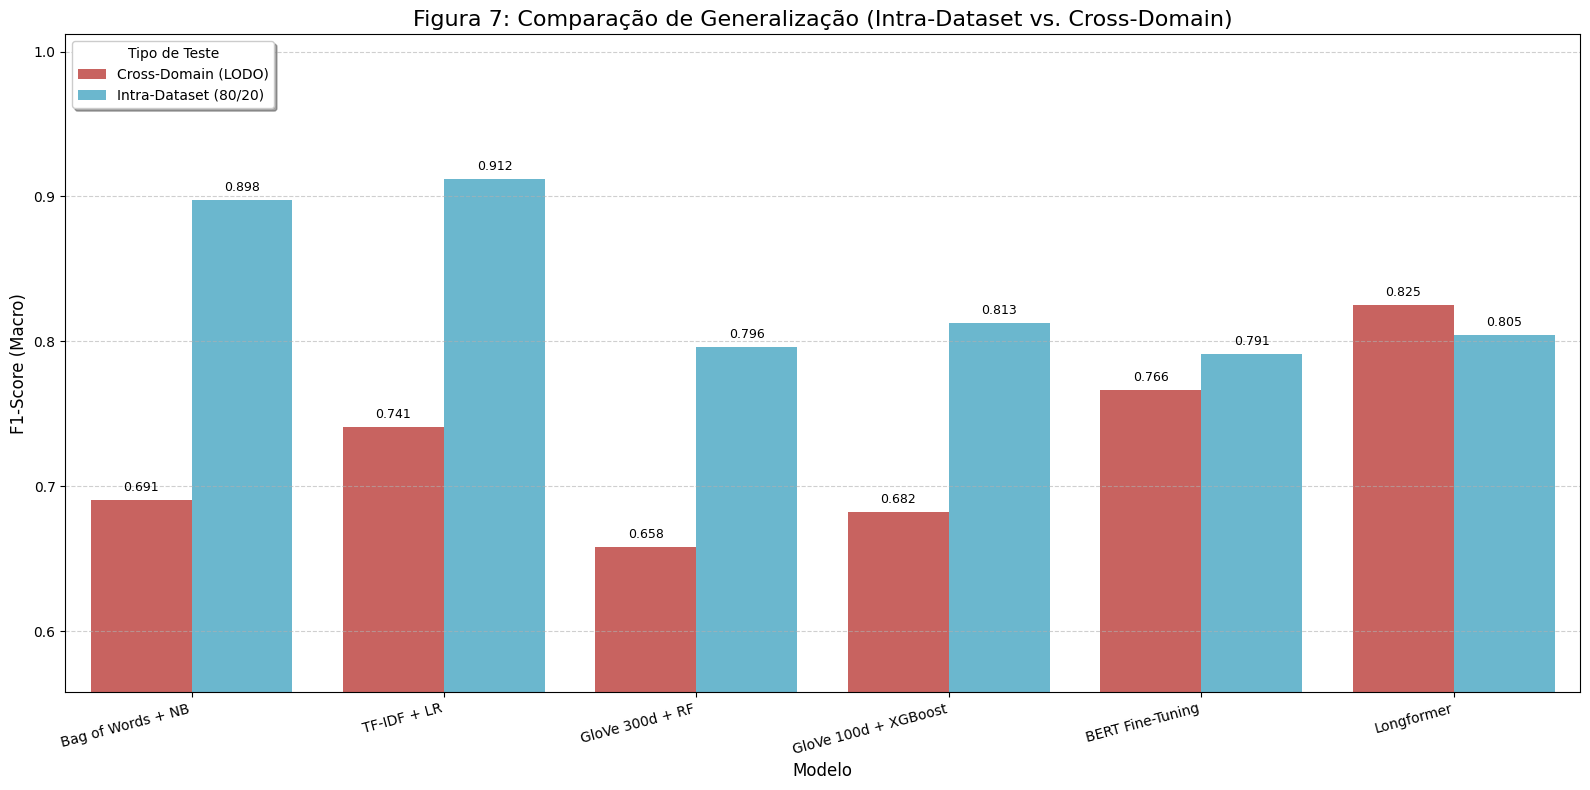

In [51]:
# ==========================================================
# 16.3 GRÁFICO DE COMPARAÇÃO FINAL (LODO vs. Baseline 80/20)
# ==========================================================
#
# Este script cria a Figura 7, comparando o desempenho de
# generalização (LODO, cross-domain) com o desempenho
# no cenário ideal (Baseline 80/20, intra-dataset).
#
# ==========================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("="*60)
print(" 📊 COMPARAÇÃO FINAL (LODO vs. Baseline 80/20) 📊")
print("="*60)

# --- ✨ CORREÇÃO AQUI ✨ ---
# A variável correta da Seção 8 é 'final_metrics_summary'
if 'final_metrics_summary' not in locals() or 'baseline_results' not in locals():
    print("❌ ERRO: 'final_metrics_summary' (Seção 8) ou 'baseline_results' (Seções 16.1/16.2) não encontrados.")
    print("   Por favor, execute a Seção 8 (AUROC) e as Seções 16.1/16.2 (Baseline) primeiro.")
# --- Fim da Correção ---
else:
    data_plot = []
    
    # Definir a lista de TODOS os modelos que queremos comparar
    model_list = [
        'Bag of Words + NB', 
        'TF-IDF + LR', 
        'GloVe 300d + RF', 
        'GloVe 100d + XGBoost',
        'BERT Fine-Tuning',
        'Longformer'
    ]

    # 1. Coletar dados do LODO (Cross-Domain)
    for model_name in model_list:
        # --- ✨ CORREÇÃO AQUI ✨ ---
        if model_name in final_metrics_summary:
            data_plot.append({
                'Modelo': model_name,
                # Usar .get() para segurança, caso a métrica não exista
                'F1-Score (Macro)': final_metrics_summary[model_name].get('F1-Score (Macro)'),
                'Tipo de Teste': 'Cross-Domain (LODO)'
            })
        # --- Fim da Correção ---
        else:
            print(f"⚠️ Aviso (LODO): Modelo '{model_name}' não encontrado em 'final_metrics_summary'.")

    # 2. Coletar dados do Baseline (Intra-Dataset 80/20)
    for model_name in model_list:
        if model_name in baseline_results:
            data_plot.append({
                'Modelo': model_name,
                'F1-Score (Macro)': baseline_results[model_name].get('F1-Score (Macro)'),
                'Tipo de Teste': 'Intra-Dataset (80/20)'
            })
        else:
            print(f"⚠️ Aviso (Baseline): Modelo '{model_name}' não encontrado em 'baseline_results'.")
    
    # Remover entradas onde o F1-Score não foi encontrado (None)
    data_plot_cleaned = [d for d in data_plot if d['F1-Score (Macro)'] is not None]

    # 3. Criar DataFrame e Plotar
    if not data_plot_cleaned:
        print("❌ ERRO: Nenhum dado válido encontrado para plotar.")
    else:
        df_plot = pd.DataFrame(data_plot_cleaned)
        
        plt.figure(figsize=(16, 8)) # Aumentar o tamanho para 6 modelos
        ax = sns.barplot(
            data=df_plot,
            x='Modelo',
            y='F1-Score (Macro)',
            hue='Tipo de Teste',
            palette={'Cross-Domain (LODO)': '#d9534f', 'Intra-Dataset (80/20)': '#5bc0de'},
            width=0.8
        )
        
        plt.title('Figura 7: Comparação de Generalização (Intra-Dataset vs. Cross-Domain)', fontsize=16)
        plt.ylabel('F1-Score (Macro)', fontsize=12)
        plt.xlabel('Modelo', fontsize=12)
        plt.xticks(rotation=15, ha='right') # Rotacionar labels para melhor leitura
        plt.legend(title='Tipo de Teste', loc='upper left', frameon=True, shadow=True)
        plt.grid(True, axis='y', linestyle='--', alpha=0.6)
        
        # Ajustar limite do eixo Y para dar espaço aos rótulos
        min_val = df_plot['F1-Score (Macro)'].min()
        max_val = df_plot['F1-Score (Macro)'].max()
        plt.ylim(bottom=max(0, min_val - 0.1), top=max_val + 0.1) 
        
        # Adicionar rótulos de dados
        for p in ax.patches:
            if p.get_height() > 0: # Não anotar barras de altura zero
                ax.annotate(f"{p.get_height():.3f}", 
                            (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha = 'center', va = 'center', 
                            xytext = (0, 9), 
                            textcoords = 'offset points',
                            fontsize=9, # Reduzir fonte para não sobrepor
                            color='black')
                        
        plt.tight_layout()
        plt.show()

# Ablation do Ensemble 

In [52]:
# ==========================================================
# 17. TABELA 2 (FINAL): ABLATION DO ENSEMBLE
# ==========================================================
#
# Este script cria a Tabela 2, comparando a calibração (NLL/ECE)
# dos modelos base com o Meta-Learner final.
#
# ==========================================================
import pandas as pd
import numpy as np # Importado para o caso de np.nan
from sklearn.metrics import log_loss # Mantido para referência, mas não deve ser usado no loop

print("="*80)
print(" 📊 TABELA 2 (FINAL): ABLATION DE CALIBRAÇÃO DO ENSEMBLE 📊")
print("="*80)
print("Lendo resultados das Seções 8 e 15...")

ablation_data = []

# --- 1. Carregar métricas dos modelos individuais ---
try:
    if 'final_metrics_summary' not in locals():
        raise NameError("'final_metrics_summary' não foi encontrado. Rode a Seção 8.")
    
    # Nomes dos modelos como eles aparecem no 'final_metrics_summary'
    models_to_include = ['TF-IDF + LR', 'BERT Fine-Tuning', 'Longformer']
    
    for model_name in models_to_include:
        if model_name in final_metrics_summary:
            metrics = final_metrics_summary[model_name]
            
            # --- INÍCIO DA CORREÇÃO ---
            # O NLL e o ECE já foram calculados na Seção 8.
            # Vamos apenas ler os valores do dicionário 'metrics'.
            
            # Usamos .get() para segurança, caso a métrica não exista
            nll = metrics.get('NLL (Log-Loss) (↓)')
            ece = metrics.get('ECE (↓) %')
            
            if nll is None or ece is None:
                print(f"⚠️ Aviso: Métricas NLL ou ECE não encontradas para '{model_name}'.")
                # Se o NLL foi o que falhou, podemos tentar recalcular SÓ SE os tamanhos baterem
                # Mas é mais seguro apenas pular
                continue

            ablation_data.append({
                'Modelo': model_name,
                'NLL (Log-Loss) (↓)': nll,
                'ECE (↓) %': ece,
                'Tipo': 'Modelo Base (LODO)'
            })
            # --- FIM DA CORREÇÃO ---
            
        else:
            print(f"⚠️ Aviso: Modelo base '{model_name}' não encontrado nos resultados.")

except Exception as e:
    print(f"❌ Erro ao carregar dados da Seção 8: {e}")
    # Imprime o traceback original se for um erro inesperado
    import traceback
    traceback.print_exc()


# --- 2. Carregar métricas do Meta-Learner ---
try:
    if 'summary_df_meta' not in locals():
        raise NameError("'summary_df_meta' não foi encontrado. Rode a Seção 15.")
        
    meta_learner_results = summary_df_meta.loc['Meta-Learner (LR + Calibração)']
    
    ablation_data.append({
        'Modelo': 'Meta-Learner (Stacking)',
        'NLL (Log-Loss) (↓)': meta_learner_results['NLL (Log-Loss) (↓)'],
        'ECE (↓) %': meta_learner_results['ECE (↓) %'],
        'Tipo': 'Ensemble (Calibrado)'
    })

except Exception as e:
    print(f"❌ Erro ao carregar dados da Seção 15: {e}")

# --- 3. Criar e Exibir a Tabela ---
if ablation_data:
    df_ablation = pd.DataFrame(ablation_data)
    df_ablation = df_ablation.set_index('Modelo')
    df_ablation = df_ablation.sort_values('ECE (↓) %')
    
    print("\n📋 TABELA 2 - RESULTADOS FINAIS (Ablação de Calibração):")
    print(df_ablation.to_markdown(floatfmt=".4f"))
else:
    print("❌ Não foi possível gerar a tabela de ablação.")

print("\n🎉 Análise de Ablação Concluída!")

 📊 TABELA 2 (FINAL): ABLATION DE CALIBRAÇÃO DO ENSEMBLE 📊
Lendo resultados das Seções 8 e 15...

📋 TABELA 2 - RESULTADOS FINAIS (Ablação de Calibração):
| Modelo                  |   NLL (Log-Loss) (↓) |   ECE (↓) % | Tipo                 |
|:------------------------|---------------------:|------------:|:---------------------|
| Meta-Learner (Stacking) |               0.4226 |      1.1256 | Ensemble (Calibrado) |
| TF-IDF + LR             |               0.5672 |      8.2160 | Modelo Base (LODO)   |
| BERT Fine-Tuning        |               0.7308 |     14.6239 | Modelo Base (LODO)   |
| Longformer              |               0.9190 |     25.8181 | Modelo Base (LODO)   |

🎉 Análise de Ablação Concluída!


# Meta-Leaner - Revisor

  INICIANDO EXPERIMENTO DE META-LEARNING (STACKING - REVISOR) 
 Preparando meta-dataset a partir das probabilidades do LODO...
  Tamanho de gabarito (y_meta) detectado: 7653 amostras.
  Construindo ensemble com os modelos solicitados: TF-IDF + LR, GloVe 100d + XGBoost, BERT Fine-Tuning
  Adicionando feature: TF-IDF + LR (Tamanho: 7653)
  Adicionando feature: GloVe 100d + XGBoost (Tamanho: 7653)
  Adicionando feature: BERT Fine-Tuning (Tamanho: 7653)

 Meta-Dataset criado com sucesso para o revisor.
 - Features (X_meta): (7653, 3) (Amostras, 3 Modelos)
 - Gabarito (y_meta): (7653,)

 Avaliando Meta-Learners (usando cross_val_predict)...

  RESULTADOS DO META-LEARNER (CONFORME REVISOR) 
| Modelo Stacking                |   Acurácia |   F1-Score (Macro) |   NLL (Log-Loss) (↓) |   Brier Score (↓) |   ECE (↓) % |
|:-------------------------------|-----------:|-------------------:|---------------------:|------------------:|------------:|
| Meta-Learner (LR Padrão)       |     0.7779 |       

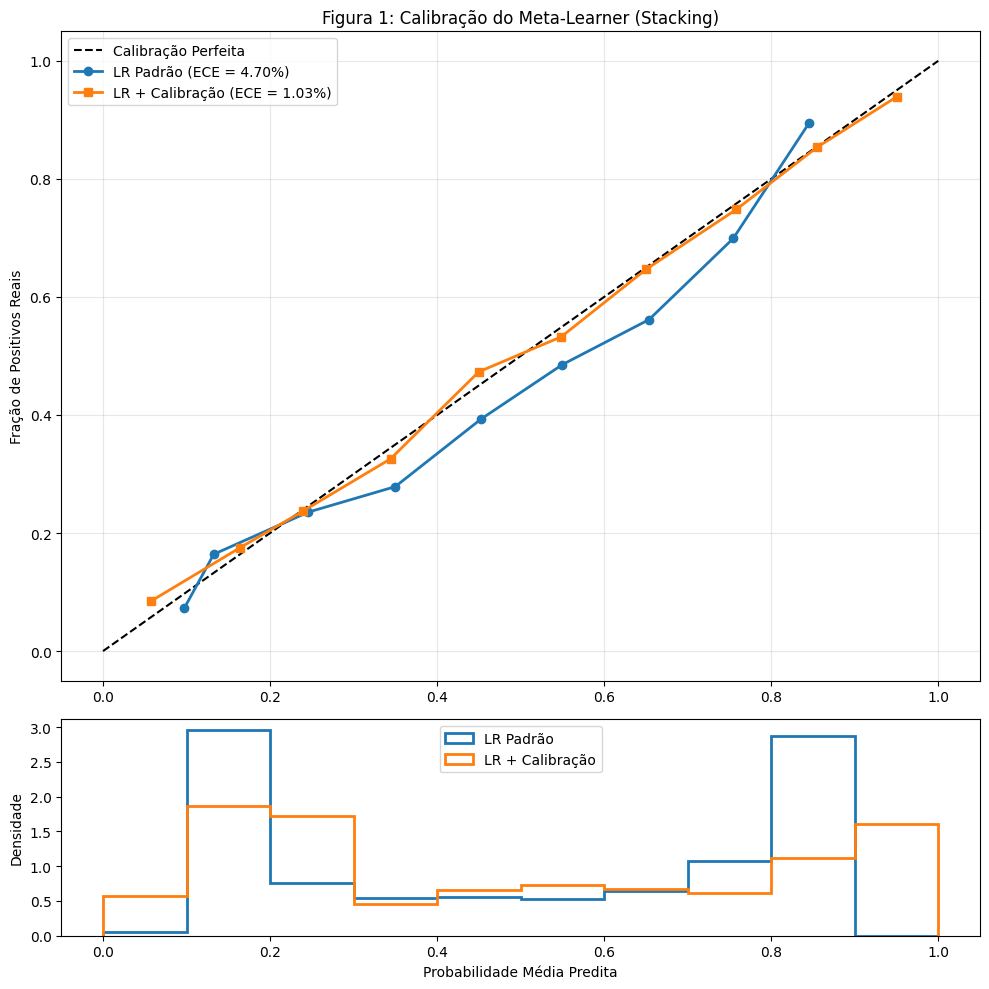


 ANÁLISE DE STACKING (CONFORME REVISOR) CONCLUÍDA!


In [53]:
# ==========================================================
# 20. META-LEARNER (STACKING - REVISOR) [CORRIGIDO]
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import (
    log_loss, brier_score_loss, roc_auc_score,
    f1_score, accuracy_score
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import warnings

warnings.filterwarnings('ignore')

print("="*60)
print("  INICIANDO EXPERIMENTO DE META-LEARNING (STACKING - REVISOR) ")
print("="*60)

# --- 1. Preparar o Meta-Dataset (Refatorado para o Revisor) ---
print(" Preparando meta-dataset a partir das probabilidades do LODO...")

# DEFINIR A LISTA EXATA DE MODELOS SOLICITADOS PELO REVISOR
MODELS_FOR_REVISOR_ENSEMBLE = [
    'TF-IDF + LR',
    'GloVe 100d + XGBoost',
    'BERT Fine-Tuning'
]

feature_names = []
meta_features = []

# Verificar se as variáveis globais da Seção 15 existem
if 'aggregated_y_true_global' not in locals() or 'roc_data_to_plot' not in locals():
    print(" ERRO: 'roc_data_to_plot' ou 'aggregated_y_true_global' não encontrados.")
    print(" Execute a Seção 15 (Area Under ROC) primeiro.")
    # Adicionar um raise para parar a execução
    raise RuntimeError("Variáveis essenciais não encontradas. Execute a Seção 15.")

y_meta = aggregated_y_true_global
target_length = len(y_meta)

print(f"  Tamanho de gabarito (y_meta) detectado: {target_length} amostras.")
print(f"  Construindo ensemble com os modelos solicitados: {', '.join(MODELS_FOR_REVISOR_ENSEMBLE)}")

# Loop para coletar apenas as probabilidades dos modelos ESPECIFICADOS
for model_name_required in MODELS_FOR_REVISOR_ENSEMBLE:
    if model_name_required in roc_data_to_plot:
        data_roc = roc_data_to_plot[model_name_required]
        if 'y_proba' in data_roc:
            proba_len = len(data_roc['y_proba'])
            # Verificação de compatibilidade de tamanho
            if proba_len == target_length:
                print(f"  Adicionando feature: {model_name_required} (Tamanho: {proba_len})")
                feature_names.append(model_name_required)
                
                # Garantir que a probabilidade é 1D (classe positiva)
                if data_roc['y_proba'].ndim == 2:
                    meta_features.append(data_roc['y_proba'][:, 1])
                else:
                    meta_features.append(data_roc['y_proba'])
            else:
                print(f"  PULANDO feature: {model_name_required}. Tamanho incompatível (Esperado: {target_length}, Encontrado: {proba_len}).")
        else:
            print(f"  Aviso: {model_name_required} não tem 'y_proba' em roc_data_to_plot. Pulando.")
    else:
        print(f"  Aviso: Modelo '{model_name_required}' não encontrado em roc_data_to_plot. Pulando.")

# --- [CORREÇÃO LÓGICA] ---
# O restante do script (partes 2, 3, 4, 5) SÓ DEVE EXECUTAR
# se a construção do meta-dataset (X_meta) for bem-sucedida.

if len(meta_features) < len(MODELS_FOR_REVISOR_ENSEMBLE):
    print(f"\n ERRO: Nem todos os modelos solicitados ({len(MODELS_FOR_REVISOR_ENSEMBLE)}) foram encontrados/adicionados para o stacking.")
    print("  Verifique se a Seção 15 (AUROC) foi executada para todos eles e se os nomes correspondem.")
    print("  A ANÁLISE DE STACKING (REVISOR) FOI INTERROMPIDA.")
else:
    # --- Somente prossiga se X_meta puder ser criado ---
    X_meta = np.stack(meta_features, axis=1)
    print(f"\n Meta-Dataset criado com sucesso para o revisor.")
    print(f" - Features (X_meta): {X_meta.shape} (Amostras, {len(feature_names)} Modelos)")
    print(f" - Gabarito (y_meta): {y_meta.shape}")

    # --- 2. Definir os Modelos ---
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    meta_learner_lr = LogisticRegression(random_state=42)
    calibrated_meta_learner = CalibratedClassifierCV(
        meta_learner_lr,
        method='isotonic', # Calibração no meta-nível
        cv=skf
    )

    # --- 3. Avaliar Meta-Learners ---
    print("\n" + "="*60)
    print(" Avaliando Meta-Learners (usando cross_val_predict)...")
    meta_probas_lr = cross_val_predict(meta_learner_lr, X_meta, y_meta, cv=skf, method='predict_proba')
    meta_preds_lr = np.argmax(meta_probas_lr, axis=1)
    
    meta_probas_calibrated = cross_val_predict(calibrated_meta_learner, X_meta, y_meta, cv=skf, method='predict_proba')
    meta_preds_calibrated = np.argmax(meta_probas_calibrated, axis=1)

    # ================================================
    # 4. REPORTAR MÉTRICAS (ECE, NLL, Brier)
    # ================================================
    print("\n" + "="*60)
    print("  RESULTADOS DO META-LEARNER (CONFORME REVISOR) ")
    print("="*60)

    # (Função calculate_ece copiada da célula 78)
    def calculate_ece(y_true, y_proba, n_bins=10):
        # Garantir que y_proba seja 1D para a classe positiva
        if y_proba.ndim == 2 and y_proba.shape[1] == 2:
            y_proba_pos = y_proba[:, 1]
        elif y_proba.ndim == 1:
            y_proba_pos = y_proba
        else:
            raise ValueError("y_proba deve ser 1D (probabilidades) ou 2D (shape (n_samples, 2))")
        
        bins = np.linspace(0., 1. + 1e-8, n_bins + 1)
        bin_indices = np.digitize(y_proba_pos, bins) - 1
        bin_indices[bin_indices == n_bins] = n_bins - 1
        bin_indices[bin_indices < 0] = 0

        bin_accuracies = np.zeros(n_bins)
        bin_confidences = np.zeros(n_bins)
        bin_counts = np.zeros(n_bins, dtype=int)

        for i in range(n_bins):
            in_bin = (bin_indices == i)
            num_in_bin = np.sum(in_bin)
            if num_in_bin > 0:
                bin_accuracies[i] = np.mean(y_true[in_bin])
                bin_confidences[i] = np.mean(y_proba_pos[in_bin])
                bin_counts[i] = num_in_bin

        bin_abs_diff = np.abs(bin_accuracies - bin_confidences)
        valid_bins = bin_counts > 0
        
        if np.sum(bin_counts) == 0:
            return 0.0

        bin_weights = bin_counts[valid_bins] / len(y_proba_pos)
        ece = np.sum(bin_weights * bin_abs_diff[valid_bins]) * 100
        return ece

    # --- Métricas do Modelo Padrão ---
    acc_lr = accuracy_score(y_meta, meta_preds_lr)
    f1_lr = f1_score(y_meta, meta_preds_lr, average='macro')
    nll_lr = log_loss(y_meta, meta_probas_lr) # NLL
    brier_lr = brier_score_loss(y_meta, meta_probas_lr[:, 1])
    ece_lr = calculate_ece(y_meta, meta_probas_lr)

    # --- Métricas do Modelo Calibrado ---
    acc_cal = accuracy_score(y_meta, meta_preds_calibrated)
    f1_cal = f1_score(y_meta, meta_preds_calibrated, average='macro')
    nll_cal = log_loss(y_meta, meta_probas_calibrated) # NLL
    brier_cal = brier_score_loss(y_meta, meta_probas_calibrated[:, 1])
    ece_cal = calculate_ece(y_meta, meta_probas_calibrated)

    # --- Criar Tabela de Resumo ---
    summary_data = {
        'Meta-Learner (LR Padrão)': {
            'Acurácia': acc_lr,
            'F1-Score (Macro)': f1_lr,
            'NLL (Log-Loss) (↓)': nll_lr,
            'Brier Score (↓)': brier_lr,
            'ECE (↓) %': ece_lr
        },
        'Meta-Learner (LR + Calibração)': {
            'Acurácia': acc_cal,
            'F1-Score (Macro)': f1_cal,
            'NLL (Log-Loss) (↓)': nll_cal,
            'Brier Score (↓)': brier_cal,
            'ECE (↓) %': ece_cal
        }
    }
    summary_df_meta_revisor = pd.DataFrame.from_dict(summary_data, orient='index')
    summary_df_meta_revisor.index.name = "Modelo Stacking"
    print(summary_df_meta_revisor.to_markdown(floatfmt=".4f"))

    # ================================================
    # 5. PLOT DE CALIBRAÇÃO FINAL
    # ================================================
    print("\n Gerando gráfico de calibração do Meta-Learner (Reliability Diagram)...")
    with plt.style.context('default'): # Forçar tema claro
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10),
                                        gridspec_kw={'height_ratios': [3, 1]})

        ax1.plot([0, 1], [0, 1], 'k--', label='Calibração Perfeita')
        # Curva Padrão
        prob_true_lr, prob_pred_lr = calibration_curve(y_meta, meta_probas_lr[:, 1], n_bins=10, strategy='uniform')
        ax1.plot(prob_pred_lr, prob_true_lr, marker='o', linewidth=2,
                label=f"LR Padrão (ECE = {ece_lr:.2f}%)")
        # Curva Calibrada
        prob_true_cal, prob_pred_cal = calibration_curve(y_meta, meta_probas_calibrated[:, 1], n_bins=10, strategy='uniform')
        ax1.plot(prob_pred_cal, prob_true_cal, marker='s', linewidth=2,
                label=f"LR + Calibração (ECE = {ece_cal:.2f}%)")
        
        ax1.set_ylabel("Fração de Positivos Reais")
        ax1.set_title("Figura 1: Calibração do Meta-Learner (Stacking)")
        ax1.legend(loc="upper left")
        ax1.grid(True, alpha=0.3)

        # Histograma de Probabilidades
        ax2.hist(meta_probas_lr[:, 1], bins=10, histtype='step', lw=2,
                label='LR Padrão', density=True, range=(0,1))
        ax2.hist(meta_probas_calibrated[:, 1], bins=10, histtype='step', lw=2,
                label='LR + Calibração', density=True, range=(0,1))
        ax2.set_xlabel("Probabilidade Média Predita")
        ax2.set_ylabel("Densidade")
        ax2.legend(loc="upper center")
        plt.tight_layout()
        plt.show()

    print("\n ANÁLISE DE STACKING (CONFORME REVISOR) CONCLUÍDA!")